In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

1


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,num_leaves=31,subsample=1,
               learning_rate=0.03,max_bin=127,
               min_data_in_leaf=20,lambda_l2=0,
               min_sum_hessian_in_leaf=1e-3, C=0.001,
               objective='binary' ):
        models=[]
        scores=[]
        d_train = lgb.Dataset(trainX, label=trainy,categorical_feature=[0])
        d_valid = lgb.Dataset(validX, label=validy,categorical_feature=[0])
        
        if 1:
            params = {
                'task': 'train',
                'boosting_type': 'gbdt',
                'objective': objective,
                'metric': {'rmse'},
                'num_leaves':num_leaves,
                'learning_rate': learning_rate,
                'feature_fraction': colsample_bytree,
                'bagging_fraction': subsample,
                'min_data_in_leaf': min_data_in_leaf,
                'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
                'lambda_l2': lambda_l2,
                'max_bin': max_bin,
                'bagging_freq': 5,
                'nthread': 8,
                'verbose': 0,
                'metric_freq': 50,
                'train_metric': True
            }
            print str(params)
            gbm = lgb.train(params,
                            d_train,
                            num_boost_round=1000,
                            valid_sets=d_valid,
                            early_stopping_rounds=50)

            models.append(gbm)
            validpred=gbm.predict(validX,num_iteration=gbm.best_iteration)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(trainX,num_iteration=gbm.best_iteration)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    test_pred=model.predict(testX,num_iteration=model.best_iteration)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        pred=model.predict(X,num_iteration=model.best_iteration).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    pred=model.predict(X,num_iteration=model.best_iteration)
    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'lambda_l2': 1,
 'learning_rate': 0.05,
 'max_bin': 255,
 'min_data_in_leaf': 30,
 'min_sum_hessian_in_leaf': 0.001,
 'num_leaves': 127,
 'objective': 'regression',
 'subsample': 0.8}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds, open('3001_lgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))



1


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


/home/bo/anaconda2/envs/tensorflow14/lib/python2.7/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's rmse: 0.775401
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.756709


[3]	valid_0's rmse: 0.73877


[4]	valid_0's rmse: 0.722269


[5]	valid_0's rmse: 0.707233


[6]	valid_0's rmse: 0.693319


[7]	valid_0's rmse: 0.679741


[8]	valid_0's rmse: 0.667186


[9]	valid_0's rmse: 0.656003


[10]	valid_0's rmse: 0.645315


[11]	valid_0's rmse: 0.635394


[12]	valid_0's rmse: 0.62656


[13]	valid_0's rmse: 0.618332


[14]	valid_0's rmse: 0.611036


[15]	valid_0's rmse: 0.60409


[16]	valid_0's rmse: 0.597668


[17]	valid_0's rmse: 0.591721


[18]	valid_0's rmse: 0.585964


[19]	valid_0's rmse: 0.580699


[20]	valid_0's rmse: 0.575861


[21]	valid_0's rmse: 0.571366


[22]	valid_0's rmse: 0.567381


[23]	valid_0's rmse: 0.563642


[24]	valid_0's rmse: 0.56029


[25]	valid_0's rmse: 0.557097


[26]	valid_0's rmse: 0.554309


[27]	valid_0's rmse: 0.551777


[28]	valid_0's rmse: 0.549294


[29]	valid_0's rmse: 0.547026


[30]	valid_0's rmse: 0.544882


[31]	valid_0's rmse: 0.542894


[32]	valid_0's rmse: 0.541097


[33]	valid_0's rmse: 0.539495


[34]	valid_0's rmse: 0.538025


[35]	valid_0's rmse: 0.53669


[36]	valid_0's rmse: 0.535464


[37]	valid_0's rmse: 0.534199


[38]	valid_0's rmse: 0.533065


[39]	valid_0's rmse: 0.531991


[40]	valid_0's rmse: 0.530882


[41]	valid_0's rmse: 0.529921


[42]	valid_0's rmse: 0.529162


[43]	valid_0's rmse: 0.528277


[44]	valid_0's rmse: 0.527517


[45]	valid_0's rmse: 0.526773


[46]	valid_0's rmse: 0.526167
[47]	valid_0's rmse: 0.525582


[48]	valid_0's rmse: 0.525066
[49]	valid_0's rmse: 0.524551


[50]	valid_0's rmse: 0.524108


[51]	valid_0's rmse: 0.523631
[52]	valid_0's rmse: 0.523126


[53]	valid_0's rmse: 0.522669
[54]	valid_0's rmse: 0.522344


[55]	valid_0's rmse: 0.521928


[56]	valid_0's rmse: 0.521566
[57]	valid_0's rmse: 0.521231


[58]	valid_0's rmse: 0.5209
[59]	valid_0's rmse: 0.520667


[60]	valid_0's rmse: 0.520342
[61]	valid_0's rmse: 0.520001


[62]	valid_0's rmse: 0.519741


[63]	valid_0's rmse: 0.519511
[64]	valid_0's rmse: 0.519242


[65]	valid_0's rmse: 0.519018


[66]	valid_0's rmse: 0.518761
[67]	valid_0's rmse: 0.518557


[68]	valid_0's rmse: 0.518353
[69]	valid_0's rmse: 0.518207


[70]	valid_0's rmse: 0.518022


[71]	valid_0's rmse: 0.517822
[72]	valid_0's rmse: 0.517632


[73]	valid_0's rmse: 0.517472
[74]	valid_0's rmse: 0.517287


[75]	valid_0's rmse: 0.51722


[76]	valid_0's rmse: 0.517098
[77]	valid_0's rmse: 0.516982


[78]	valid_0's rmse: 0.516877
[79]	valid_0's rmse: 0.516718


[80]	valid_0's rmse: 0.516564


[81]	valid_0's rmse: 0.516394
[82]	valid_0's rmse: 0.516243


[83]	valid_0's rmse: 0.516141
[84]	valid_0's rmse: 0.516071


[85]	valid_0's rmse: 0.515982
[86]	valid_0's rmse: 0.51581


[87]	valid_0's rmse: 0.515635
[88]	valid_0's rmse: 0.51554


[89]	valid_0's rmse: 0.515479
[90]	valid_0's rmse: 0.515376


[91]	valid_0's rmse: 0.515248
[92]	valid_0's rmse: 0.515134


[93]	valid_0's rmse: 0.515048
[94]	valid_0's rmse: 0.51501


[95]	valid_0's rmse: 0.51491
[96]	valid_0's rmse: 0.514845


[97]	valid_0's rmse: 0.514729
[98]	valid_0's rmse: 0.514654


[99]	valid_0's rmse: 0.514493
[100]	valid_0's rmse: 0.514445


[101]	valid_0's rmse: 0.514379
[102]	valid_0's rmse: 0.514268


[103]	valid_0's rmse: 0.514113
[104]	valid_0's rmse: 0.514052


[105]	valid_0's rmse: 0.514029
[106]	valid_0's rmse: 0.513914


[107]	valid_0's rmse: 0.51384
[108]	valid_0's rmse: 0.513782


[109]	valid_0's rmse: 0.513706
[110]	valid_0's rmse: 0.513611


[111]	valid_0's rmse: 0.513544
[112]	valid_0's rmse: 0.513491


[113]	valid_0's rmse: 0.51343
[114]	valid_0's rmse: 0.513367


[115]	valid_0's rmse: 0.513294
[116]	valid_0's rmse: 0.513274


[117]	valid_0's rmse: 0.513263
[118]	valid_0's rmse: 0.513252


[119]	valid_0's rmse: 0.513168
[120]	valid_0's rmse: 0.513129


[121]	valid_0's rmse: 0.51312
[122]	valid_0's rmse: 0.513132


[123]	valid_0's rmse: 0.51307
[124]	valid_0's rmse: 0.513045


[125]	valid_0's rmse: 0.512991
[126]	valid_0's rmse: 0.512958


[127]	valid_0's rmse: 0.512925
[128]	valid_0's rmse: 0.512924


[129]	valid_0's rmse: 0.512935
[130]	valid_0's rmse: 0.512913


[131]	valid_0's rmse: 0.512899
[132]	valid_0's rmse: 0.512871


[133]	valid_0's rmse: 0.512844
[134]	valid_0's rmse: 0.51284


[135]	valid_0's rmse: 0.51277
[136]	valid_0's rmse: 0.512745


[137]	valid_0's rmse: 0.512744
[138]	valid_0's rmse: 0.51278


[139]	valid_0's rmse: 0.512743
[140]	valid_0's rmse: 0.512756


[141]	valid_0's rmse: 0.512722
[142]	valid_0's rmse: 0.512631


[143]	valid_0's rmse: 0.512571
[144]	valid_0's rmse: 0.512478


[145]	valid_0's rmse: 0.512434
[146]	valid_0's rmse: 0.51241


[147]	valid_0's rmse: 0.512383
[148]	valid_0's rmse: 0.512368


[149]	valid_0's rmse: 0.512396
[150]	valid_0's rmse: 0.512381


[151]	valid_0's rmse: 0.512361
[152]	valid_0's rmse: 0.512332


[153]	valid_0's rmse: 0.512299
[154]	valid_0's rmse: 0.512262


[155]	valid_0's rmse: 0.512204
[156]	valid_0's rmse: 0.512189


[157]	valid_0's rmse: 0.512161
[158]	valid_0's rmse: 0.512161


[159]	valid_0's rmse: 0.512139
[160]	valid_0's rmse: 0.512134


[161]	valid_0's rmse: 0.512141
[162]	valid_0's rmse: 0.512097


[163]	valid_0's rmse: 0.51208
[164]	valid_0's rmse: 0.512073


[165]	valid_0's rmse: 0.51206
[166]	valid_0's rmse: 0.512044


[167]	valid_0's rmse: 0.511999
[168]	valid_0's rmse: 0.512027


[169]	valid_0's rmse: 0.512026
[170]	valid_0's rmse: 0.512004


[171]	valid_0's rmse: 0.512013
[172]	valid_0's rmse: 0.511992


[173]	valid_0's rmse: 0.511984
[174]	valid_0's rmse: 0.511995


[175]	valid_0's rmse: 0.512019
[176]	valid_0's rmse: 0.511992


[177]	valid_0's rmse: 0.511992
[178]	valid_0's rmse: 0.512001


[179]	valid_0's rmse: 0.51201
[180]	valid_0's rmse: 0.511989


[181]	valid_0's rmse: 0.511932
[182]	valid_0's rmse: 0.511934


[183]	valid_0's rmse: 0.511916
[184]	valid_0's rmse: 0.511879


[185]	valid_0's rmse: 0.511855
[186]	valid_0's rmse: 0.511867


[187]	valid_0's rmse: 0.511834
[188]	valid_0's rmse: 0.511842


[189]	valid_0's rmse: 0.511846
[190]	valid_0's rmse: 0.511849


[191]	valid_0's rmse: 0.51182
[192]	valid_0's rmse: 0.511804


[193]	valid_0's rmse: 0.511787
[194]	valid_0's rmse: 0.511783


[195]	valid_0's rmse: 0.511768
[196]	valid_0's rmse: 0.511753


[197]	valid_0's rmse: 0.511764
[198]	valid_0's rmse: 0.511769


[199]	valid_0's rmse: 0.511767
[200]	valid_0's rmse: 0.511766


[201]	valid_0's rmse: 0.511715
[202]	valid_0's rmse: 0.511697


[203]	valid_0's rmse: 0.51168
[204]	valid_0's rmse: 0.511621


[205]	valid_0's rmse: 0.511607
[206]	valid_0's rmse: 0.511598


[207]	valid_0's rmse: 0.511615
[208]	valid_0's rmse: 0.511617


[209]	valid_0's rmse: 0.511574
[210]	valid_0's rmse: 0.511551


[211]	valid_0's rmse: 0.511533
[212]	valid_0's rmse: 0.51152


[213]	valid_0's rmse: 0.51152
[214]	valid_0's rmse: 0.511493


[215]	valid_0's rmse: 0.511485
[216]	valid_0's rmse: 0.511497


[217]	valid_0's rmse: 0.5115
[218]	valid_0's rmse: 0.511493


[219]	valid_0's rmse: 0.511518
[220]	valid_0's rmse: 0.511492


[221]	valid_0's rmse: 0.5115
[222]	valid_0's rmse: 0.511461


[223]	valid_0's rmse: 0.511491
[224]	valid_0's rmse: 0.511468


[225]	valid_0's rmse: 0.51147
[226]	valid_0's rmse: 0.511444


[227]	valid_0's rmse: 0.511435
[228]	valid_0's rmse: 0.511434


[229]	valid_0's rmse: 0.511427
[230]	valid_0's rmse: 0.511433


[231]	valid_0's rmse: 0.511433
[232]	valid_0's rmse: 0.511428


[233]	valid_0's rmse: 0.511409
[234]	valid_0's rmse: 0.51139


[235]	valid_0's rmse: 0.51139
[236]	valid_0's rmse: 0.511367


[237]	valid_0's rmse: 0.511336
[238]	valid_0's rmse: 0.51133


[239]	valid_0's rmse: 0.511335
[240]	valid_0's rmse: 0.511335


[241]	valid_0's rmse: 0.511337
[242]	valid_0's rmse: 0.511318


[243]	valid_0's rmse: 0.511326
[244]	valid_0's rmse: 0.51132


[245]	valid_0's rmse: 0.511308
[246]	valid_0's rmse: 0.51129


[247]	valid_0's rmse: 0.511284
[248]	valid_0's rmse: 0.51127


[249]	valid_0's rmse: 0.511275
[250]	valid_0's rmse: 0.511272


[251]	valid_0's rmse: 0.511276
[252]	valid_0's rmse: 0.511284


[253]	valid_0's rmse: 0.511283
[254]	valid_0's rmse: 0.51127


[255]	valid_0's rmse: 0.511272
[256]	valid_0's rmse: 0.511258


[257]	valid_0's rmse: 0.511243
[258]	valid_0's rmse: 0.511227


[259]	valid_0's rmse: 0.511196
[260]	valid_0's rmse: 0.51118


[261]	valid_0's rmse: 0.511168
[262]	valid_0's rmse: 0.511169


[263]	valid_0's rmse: 0.511183
[264]	valid_0's rmse: 0.511191


[265]	valid_0's rmse: 0.51116
[266]	valid_0's rmse: 0.511171


[267]	valid_0's rmse: 0.511153
[268]	valid_0's rmse: 0.511153


[269]	valid_0's rmse: 0.511098
[270]	valid_0's rmse: 0.511087


[271]	valid_0's rmse: 0.511087
[272]	valid_0's rmse: 0.511089


[273]	valid_0's rmse: 0.511117
[274]	valid_0's rmse: 0.511116


[275]	valid_0's rmse: 0.511102
[276]	valid_0's rmse: 0.511102


[277]	valid_0's rmse: 0.5111
[278]	valid_0's rmse: 0.511097


[279]	valid_0's rmse: 0.511112
[280]	valid_0's rmse: 0.511108


[281]	valid_0's rmse: 0.511101
[282]	valid_0's rmse: 0.511096


[283]	valid_0's rmse: 0.511099
[284]	valid_0's rmse: 0.511101


[285]	valid_0's rmse: 0.511076
[286]	valid_0's rmse: 0.511051


[287]	valid_0's rmse: 0.511046
[288]	valid_0's rmse: 0.511037


[289]	valid_0's rmse: 0.511025
[290]	valid_0's rmse: 0.511041


[291]	valid_0's rmse: 0.511048
[292]	valid_0's rmse: 0.511035


[293]	valid_0's rmse: 0.511036
[294]	valid_0's rmse: 0.511037


[295]	valid_0's rmse: 0.511025
[296]	valid_0's rmse: 0.511012


[297]	valid_0's rmse: 0.511001
[298]	valid_0's rmse: 0.51099


[299]	valid_0's rmse: 0.511007
[300]	valid_0's rmse: 0.510996


[301]	valid_0's rmse: 0.510964
[302]	valid_0's rmse: 0.510967


[303]	valid_0's rmse: 0.510956
[304]	valid_0's rmse: 0.510933
[305]	valid_0's rmse: 0.510945


[306]	valid_0's rmse: 0.510924
[307]	valid_0's rmse: 0.510929


[308]	valid_0's rmse: 0.510919
[309]	valid_0's rmse: 0.510918


[310]	valid_0's rmse: 0.510907
[311]	valid_0's rmse: 0.51091


[312]	valid_0's rmse: 0.510922
[313]	valid_0's rmse: 0.51091


[314]	valid_0's rmse: 0.510894
[315]	valid_0's rmse: 0.510911
[316]	valid_0's rmse: 0.510926


[317]	valid_0's rmse: 0.510918
[318]	valid_0's rmse: 0.510897


[319]	valid_0's rmse: 0.51091
[320]	valid_0's rmse: 0.510902


[321]	valid_0's rmse: 0.510868
[322]	valid_0's rmse: 0.510867


[323]	valid_0's rmse: 0.510872
[324]	valid_0's rmse: 0.510859
[325]	valid_0's rmse: 0.51086


[326]	valid_0's rmse: 0.510868
[327]	valid_0's rmse: 0.510867


[328]	valid_0's rmse: 0.510868
[329]	valid_0's rmse: 0.510876


[330]	valid_0's rmse: 0.510852
[331]	valid_0's rmse: 0.510831


[332]	valid_0's rmse: 0.510807
[333]	valid_0's rmse: 0.510807


[334]	valid_0's rmse: 0.510802
[335]	valid_0's rmse: 0.510795


[336]	valid_0's rmse: 0.510792
[337]	valid_0's rmse: 0.510771


[338]	valid_0's rmse: 0.510806
[339]	valid_0's rmse: 0.510807


[340]	valid_0's rmse: 0.51081
[341]	valid_0's rmse: 0.510811


[342]	valid_0's rmse: 0.510798
[343]	valid_0's rmse: 0.51079
[344]	valid_0's rmse: 0.510792


[345]	valid_0's rmse: 0.510789
[346]	valid_0's rmse: 0.510784


[347]	valid_0's rmse: 0.510797
[348]	valid_0's rmse: 0.510786


[349]	valid_0's rmse: 0.510763
[350]	valid_0's rmse: 0.510743


[351]	valid_0's rmse: 0.510729
[352]	valid_0's rmse: 0.510727


[353]	valid_0's rmse: 0.510729
[354]	valid_0's rmse: 0.510709


[355]	valid_0's rmse: 0.510689
[356]	valid_0's rmse: 0.5107


[357]	valid_0's rmse: 0.510686
[358]	valid_0's rmse: 0.510704


[359]	valid_0's rmse: 0.510688
[360]	valid_0's rmse: 0.510657


[361]	valid_0's rmse: 0.510647
[362]	valid_0's rmse: 0.510655


[363]	valid_0's rmse: 0.510641
[364]	valid_0's rmse: 0.510642
[365]	valid_0's rmse: 0.510631


[366]	valid_0's rmse: 0.510627
[367]	valid_0's rmse: 0.510648


[368]	valid_0's rmse: 0.510644
[369]	valid_0's rmse: 0.510636


[370]	valid_0's rmse: 0.510633
[371]	valid_0's rmse: 0.510632


[372]	valid_0's rmse: 0.510633
[373]	valid_0's rmse: 0.510645


[374]	valid_0's rmse: 0.510635
[375]	valid_0's rmse: 0.510634


[376]	valid_0's rmse: 0.510643
[377]	valid_0's rmse: 0.510658
[378]	valid_0's rmse: 0.510677


[379]	valid_0's rmse: 0.510668
[380]	valid_0's rmse: 0.510679


[381]	valid_0's rmse: 0.510672
[382]	valid_0's rmse: 0.510651
[383]	valid_0's rmse: 0.510665


[384]	valid_0's rmse: 0.510652
[385]	valid_0's rmse: 0.510661


[386]	valid_0's rmse: 0.510674
[387]	valid_0's rmse: 0.510685


[388]	valid_0's rmse: 0.510705
[389]	valid_0's rmse: 0.510703


[390]	valid_0's rmse: 0.510696
[391]	valid_0's rmse: 0.510705


[392]	valid_0's rmse: 0.510718
[393]	valid_0's rmse: 0.510707
[394]	valid_0's rmse: 0.510727


[395]	valid_0's rmse: 0.510738
[396]	valid_0's rmse: 0.510738


[397]	valid_0's rmse: 0.51076
[398]	valid_0's rmse: 0.510755


[399]	valid_0's rmse: 0.510765
[400]	valid_0's rmse: 0.510751


[401]	valid_0's rmse: 0.510738
[402]	valid_0's rmse: 0.510727
[403]	valid_0's rmse: 0.51072


[404]	valid_0's rmse: 0.510704
[405]	valid_0's rmse: 0.510699


[406]	valid_0's rmse: 0.510682
[407]	valid_0's rmse: 0.510683


[408]	valid_0's rmse: 0.510663
[409]	valid_0's rmse: 0.510674


[410]	valid_0's rmse: 0.510659
[411]	valid_0's rmse: 0.510647


[412]	valid_0's rmse: 0.510654
[413]	valid_0's rmse: 0.510666


[414]	valid_0's rmse: 0.510672
[415]	valid_0's rmse: 0.510665


[416]	valid_0's rmse: 0.510677
Early stopping, best iteration is:
[366]	valid_0's rmse: 0.510627


0.182581937067 0.260740309881
[0.26074030988095526]
-1 mean score 0.260740309881


0.172056646618


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909304  0.019806  0.187534    7  2017-04-16
472     2.507290  2.529053 -0.021763  0.171356    1  2017-04-17
473     2.661330  2.665115 -0.003786  0.205043    2  2017-04-18
474     2.754815  2.724702  0.030113  0.168695    3  2017-04-19
475     2.713762  2.698193  0.015569  0.187908    4  2017-04-20
476     2.999000  3.000098 -0.001098  0.130249    5  2017-04-21
477     3.075529  3.090457 -0.014928  0.153611    6  2017-04-22

0.172056646618


pred         y     error    error2  day        date
dayidx                                                         
471     2.909304  2.929110  0.019806  0.187534    7  2017-04-16
472     2.529053  2.507290 -0.021763  0.171356    1  2017-04-17
473     2.665115  2.661330 -0.003786  0.205043    2  2017-04-18
474     2.724702  2.754815  0.030113  0.168695    3  2017-04-19
475     2.698193  2.713762  0.015569  0.187908    4  2017-04-20
476     3.000098  2.999000 -0.001098  0.130249    5  2017-04-21
477     3.090457  3.075529 -0.014928  0.153611    6  2017-04-22

(829, 242)




2


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.76409
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.74519


[3]	valid_0's rmse: 0.727667


[4]	valid_0's rmse: 0.711296


[5]	valid_0's rmse: 0.696091


[6]	valid_0's rmse: 0.682293


[7]	valid_0's rmse: 0.669434


[8]	valid_0's rmse: 0.657271


[9]	valid_0's rmse: 0.645985


[10]	valid_0's rmse: 0.635563


[11]	valid_0's rmse: 0.626464


[12]	valid_0's rmse: 0.617891


[13]	valid_0's rmse: 0.609595


[14]	valid_0's rmse: 0.602151


[15]	valid_0's rmse: 0.595513


[16]	valid_0's rmse: 0.589193


[17]	valid_0's rmse: 0.583351


[18]	valid_0's rmse: 0.577838
[19]	valid_0's rmse: 0.57282


[20]	valid_0's rmse: 0.56835


[21]	valid_0's rmse: 0.564183


[22]	valid_0's rmse: 0.560452


[23]	valid_0's rmse: 0.556896


[24]	valid_0's rmse: 0.553755
[25]	valid_0's rmse: 0.55079


[26]	valid_0's rmse: 0.548151


[27]	valid_0's rmse: 0.545551
[28]	valid_0's rmse: 0.543173


[29]	valid_0's rmse: 0.540996
[30]	valid_0's rmse: 0.538962


[31]	valid_0's rmse: 0.537052
[32]	valid_0's rmse: 0.535346


[33]	valid_0's rmse: 0.533695
[34]	valid_0's rmse: 0.532277


[35]	valid_0's rmse: 0.530979


[36]	valid_0's rmse: 0.529817
[37]	valid_0's rmse: 0.52861


[38]	valid_0's rmse: 0.527547
[39]	valid_0's rmse: 0.526585


[40]	valid_0's rmse: 0.525622
[41]	valid_0's rmse: 0.52479


[42]	valid_0's rmse: 0.524049
[43]	valid_0's rmse: 0.523294


[44]	valid_0's rmse: 0.522647
[45]	valid_0's rmse: 0.522125


[46]	valid_0's rmse: 0.521554
[47]	valid_0's rmse: 0.520997


[48]	valid_0's rmse: 0.520508
[49]	valid_0's rmse: 0.519984


[50]	valid_0's rmse: 0.519491
[51]	valid_0's rmse: 0.51909


[52]	valid_0's rmse: 0.518661
[53]	valid_0's rmse: 0.518313


[54]	valid_0's rmse: 0.517987
[55]	valid_0's rmse: 0.517669


[56]	valid_0's rmse: 0.517347
[57]	valid_0's rmse: 0.517004


[58]	valid_0's rmse: 0.516697
[59]	valid_0's rmse: 0.516477


[60]	valid_0's rmse: 0.5162
[61]	valid_0's rmse: 0.515895


[62]	valid_0's rmse: 0.515666
[63]	valid_0's rmse: 0.515453


[64]	valid_0's rmse: 0.515206
[65]	valid_0's rmse: 0.515017


[66]	valid_0's rmse: 0.514723
[67]	valid_0's rmse: 0.514553


[68]	valid_0's rmse: 0.514276
[69]	valid_0's rmse: 0.514131


[70]	valid_0's rmse: 0.51388
[71]	valid_0's rmse: 0.513591


[72]	valid_0's rmse: 0.513426
[73]	valid_0's rmse: 0.513245


[74]	valid_0's rmse: 0.513086
[75]	valid_0's rmse: 0.512878


[76]	valid_0's rmse: 0.512668
[77]	valid_0's rmse: 0.512512


[78]	valid_0's rmse: 0.512368
[79]	valid_0's rmse: 0.512219


[80]	valid_0's rmse: 0.512066
[81]	valid_0's rmse: 0.511953


[82]	valid_0's rmse: 0.511762
[83]	valid_0's rmse: 0.511612


[84]	valid_0's rmse: 0.511502
[85]	valid_0's rmse: 0.511354


[86]	valid_0's rmse: 0.51125
[87]	valid_0's rmse: 0.511201


[88]	valid_0's rmse: 0.511074
[89]	valid_0's rmse: 0.511017


[90]	valid_0's rmse: 0.510924
[91]	valid_0's rmse: 0.510813


[92]	valid_0's rmse: 0.510677
[93]	valid_0's rmse: 0.510569


[94]	valid_0's rmse: 0.510486
[95]	valid_0's rmse: 0.510359


[96]	valid_0's rmse: 0.510251
[97]	valid_0's rmse: 0.510184


[98]	valid_0's rmse: 0.510111
[99]	valid_0's rmse: 0.510085


[100]	valid_0's rmse: 0.51003
[101]	valid_0's rmse: 0.510002


[102]	valid_0's rmse: 0.509938
[103]	valid_0's rmse: 0.509879


[104]	valid_0's rmse: 0.509808
[105]	valid_0's rmse: 0.509677


[106]	valid_0's rmse: 0.509579
[107]	valid_0's rmse: 0.509546


[108]	valid_0's rmse: 0.509503
[109]	valid_0's rmse: 0.509458


[110]	valid_0's rmse: 0.509353
[111]	valid_0's rmse: 0.509247


[112]	valid_0's rmse: 0.509183
[113]	valid_0's rmse: 0.509079


[114]	valid_0's rmse: 0.509043
[115]	valid_0's rmse: 0.509021


[116]	valid_0's rmse: 0.508923
[117]	valid_0's rmse: 0.50888


[118]	valid_0's rmse: 0.508803
[119]	valid_0's rmse: 0.50875


[120]	valid_0's rmse: 0.508648
[121]	valid_0's rmse: 0.508527


[122]	valid_0's rmse: 0.508458
[123]	valid_0's rmse: 0.508371


[124]	valid_0's rmse: 0.508316
[125]	valid_0's rmse: 0.508287


[126]	valid_0's rmse: 0.508263
[127]	valid_0's rmse: 0.508211


[128]	valid_0's rmse: 0.508189
[129]	valid_0's rmse: 0.508135


[130]	valid_0's rmse: 0.508104
[131]	valid_0's rmse: 0.508005


[132]	valid_0's rmse: 0.507916
[133]	valid_0's rmse: 0.507907


[134]	valid_0's rmse: 0.507898
[135]	valid_0's rmse: 0.507853


[136]	valid_0's rmse: 0.507817
[137]	valid_0's rmse: 0.50781


[138]	valid_0's rmse: 0.507792
[139]	valid_0's rmse: 0.507755


[140]	valid_0's rmse: 0.507723
[141]	valid_0's rmse: 0.507702


[142]	valid_0's rmse: 0.507637
[143]	valid_0's rmse: 0.50765


[144]	valid_0's rmse: 0.507634
[145]	valid_0's rmse: 0.507618


[146]	valid_0's rmse: 0.507596
[147]	valid_0's rmse: 0.507578


[148]	valid_0's rmse: 0.50756
[149]	valid_0's rmse: 0.50755


[150]	valid_0's rmse: 0.507532
[151]	valid_0's rmse: 0.507553


[152]	valid_0's rmse: 0.50756
[153]	valid_0's rmse: 0.507511


[154]	valid_0's rmse: 0.507538
[155]	valid_0's rmse: 0.507524


[156]	valid_0's rmse: 0.507514
[157]	valid_0's rmse: 0.507474


[158]	valid_0's rmse: 0.507426
[159]	valid_0's rmse: 0.50741


[160]	valid_0's rmse: 0.50742
[161]	valid_0's rmse: 0.50736


[162]	valid_0's rmse: 0.507303
[163]	valid_0's rmse: 0.507271


[164]	valid_0's rmse: 0.50724
[165]	valid_0's rmse: 0.507197


[166]	valid_0's rmse: 0.507201
[167]	valid_0's rmse: 0.507223


[168]	valid_0's rmse: 0.50723
[169]	valid_0's rmse: 0.507241


[170]	valid_0's rmse: 0.507233
[171]	valid_0's rmse: 0.507233


[172]	valid_0's rmse: 0.507235
[173]	valid_0's rmse: 0.507235


[174]	valid_0's rmse: 0.507229
[175]	valid_0's rmse: 0.507213


[176]	valid_0's rmse: 0.507125
[177]	valid_0's rmse: 0.507089


[178]	valid_0's rmse: 0.507072
[179]	valid_0's rmse: 0.50704


[180]	valid_0's rmse: 0.507048
[181]	valid_0's rmse: 0.507026


[182]	valid_0's rmse: 0.507037
[183]	valid_0's rmse: 0.50705


[184]	valid_0's rmse: 0.507033
[185]	valid_0's rmse: 0.507026


[186]	valid_0's rmse: 0.506984
[187]	valid_0's rmse: 0.506976


[188]	valid_0's rmse: 0.506963
[189]	valid_0's rmse: 0.506969


[190]	valid_0's rmse: 0.506919
[191]	valid_0's rmse: 0.506928


[192]	valid_0's rmse: 0.506919
[193]	valid_0's rmse: 0.506909


[194]	valid_0's rmse: 0.506878
[195]	valid_0's rmse: 0.506859


[196]	valid_0's rmse: 0.506866
[197]	valid_0's rmse: 0.506876


[198]	valid_0's rmse: 0.506892
[199]	valid_0's rmse: 0.506895


[200]	valid_0's rmse: 0.506908
[201]	valid_0's rmse: 0.506893


[202]	valid_0's rmse: 0.506876
[203]	valid_0's rmse: 0.50687


[204]	valid_0's rmse: 0.506873
[205]	valid_0's rmse: 0.506831


[206]	valid_0's rmse: 0.50685
[207]	valid_0's rmse: 0.506828


[208]	valid_0's rmse: 0.506803
[209]	valid_0's rmse: 0.506811


[210]	valid_0's rmse: 0.506822
[211]	valid_0's rmse: 0.506816


[212]	valid_0's rmse: 0.506802
[213]	valid_0's rmse: 0.506808
[214]	valid_0's rmse: 0.506806


[215]	valid_0's rmse: 0.506813
[216]	valid_0's rmse: 0.506783


[217]	valid_0's rmse: 0.506786
[218]	valid_0's rmse: 0.506757


[219]	valid_0's rmse: 0.50675
[220]	valid_0's rmse: 0.506766


[221]	valid_0's rmse: 0.50679
[222]	valid_0's rmse: 0.506811


[223]	valid_0's rmse: 0.506841
[224]	valid_0's rmse: 0.50683


[225]	valid_0's rmse: 0.506837
[226]	valid_0's rmse: 0.50682


[227]	valid_0's rmse: 0.506861
[228]	valid_0's rmse: 0.506833


[229]	valid_0's rmse: 0.506825
[230]	valid_0's rmse: 0.506793


[231]	valid_0's rmse: 0.506806
[232]	valid_0's rmse: 0.506788


[233]	valid_0's rmse: 0.506814
[234]	valid_0's rmse: 0.506808
[235]	valid_0's rmse: 0.506779


[236]	valid_0's rmse: 0.506752
[237]	valid_0's rmse: 0.506737


[238]	valid_0's rmse: 0.506736
[239]	valid_0's rmse: 0.506734


[240]	valid_0's rmse: 0.506717
[241]	valid_0's rmse: 0.50671


[242]	valid_0's rmse: 0.50672
[243]	valid_0's rmse: 0.506732


[244]	valid_0's rmse: 0.506751
[245]	valid_0's rmse: 0.506745


[246]	valid_0's rmse: 0.506764
[247]	valid_0's rmse: 0.50675


[248]	valid_0's rmse: 0.506751
[249]	valid_0's rmse: 0.506709


[250]	valid_0's rmse: 0.506699
[251]	valid_0's rmse: 0.506694


[252]	valid_0's rmse: 0.506689
[253]	valid_0's rmse: 0.506683
[254]	valid_0's rmse: 0.506688


[255]	valid_0's rmse: 0.506669
[256]	valid_0's rmse: 0.506661


[257]	valid_0's rmse: 0.506635
[258]	valid_0's rmse: 0.506613
[259]	valid_0's rmse: 0.50664


[260]	valid_0's rmse: 0.506635
[261]	valid_0's rmse: 0.506601


[262]	valid_0's rmse: 0.506588
[263]	valid_0's rmse: 0.506565
[264]	valid_0's rmse: 0.506581


[265]	valid_0's rmse: 0.506575
[266]	valid_0's rmse: 0.506556


[267]	valid_0's rmse: 0.506544
[268]	valid_0's rmse: 0.506567
[269]	valid_0's rmse: 0.506567


[270]	valid_0's rmse: 0.506564
[271]	valid_0's rmse: 0.506564
[272]	valid_0's rmse: 0.50656


[273]	valid_0's rmse: 0.506551
[274]	valid_0's rmse: 0.506542
[275]	valid_0's rmse: 0.506539


[276]	valid_0's rmse: 0.506567
[277]	valid_0's rmse: 0.506561


[278]	valid_0's rmse: 0.506553
[279]	valid_0's rmse: 0.506537


[280]	valid_0's rmse: 0.506573
[281]	valid_0's rmse: 0.506567
[282]	valid_0's rmse: 0.506518


[283]	valid_0's rmse: 0.506512
[284]	valid_0's rmse: 0.506517
[285]	valid_0's rmse: 0.50651


[286]	valid_0's rmse: 0.506484
[287]	valid_0's rmse: 0.506482
[288]	valid_0's rmse: 0.506475


[289]	valid_0's rmse: 0.506512
[290]	valid_0's rmse: 0.506517


[291]	valid_0's rmse: 0.506515
[292]	valid_0's rmse: 0.506515


[293]	valid_0's rmse: 0.506483
[294]	valid_0's rmse: 0.506473


[295]	valid_0's rmse: 0.506453
[296]	valid_0's rmse: 0.506462


[297]	valid_0's rmse: 0.506478
[298]	valid_0's rmse: 0.506492
[299]	valid_0's rmse: 0.506478


[300]	valid_0's rmse: 0.506472
[301]	valid_0's rmse: 0.506495
[302]	valid_0's rmse: 0.506481


[303]	valid_0's rmse: 0.506456
[304]	valid_0's rmse: 0.506456
[305]	valid_0's rmse: 0.506456


[306]	valid_0's rmse: 0.506471
[307]	valid_0's rmse: 0.506479
[308]	valid_0's rmse: 0.506456


[309]	valid_0's rmse: 0.506432
[310]	valid_0's rmse: 0.506403


[311]	valid_0's rmse: 0.506386
[312]	valid_0's rmse: 0.506364


[313]	valid_0's rmse: 0.506355
[314]	valid_0's rmse: 0.506353


[315]	valid_0's rmse: 0.506344
[316]	valid_0's rmse: 0.506326


[317]	valid_0's rmse: 0.506324
[318]	valid_0's rmse: 0.506316


[319]	valid_0's rmse: 0.506336
[320]	valid_0's rmse: 0.506363


[321]	valid_0's rmse: 0.506357
[322]	valid_0's rmse: 0.506386


[323]	valid_0's rmse: 0.506399
[324]	valid_0's rmse: 0.506413
[325]	valid_0's rmse: 0.506407


[326]	valid_0's rmse: 0.506403
[327]	valid_0's rmse: 0.506406
[328]	valid_0's rmse: 0.506399


[329]	valid_0's rmse: 0.506407
[330]	valid_0's rmse: 0.506422


[331]	valid_0's rmse: 0.506421
[332]	valid_0's rmse: 0.506407
[333]	valid_0's rmse: 0.506394


[334]	valid_0's rmse: 0.506372
[335]	valid_0's rmse: 0.50636


[336]	valid_0's rmse: 0.506316
[337]	valid_0's rmse: 0.506314
[338]	valid_0's rmse: 0.506305


[339]	valid_0's rmse: 0.506284
[340]	valid_0's rmse: 0.506289


[341]	valid_0's rmse: 0.506276
[342]	valid_0's rmse: 0.506274
[343]	valid_0's rmse: 0.506288


[344]	valid_0's rmse: 0.506295
[345]	valid_0's rmse: 0.506302


[346]	valid_0's rmse: 0.506302
[347]	valid_0's rmse: 0.506288


[348]	valid_0's rmse: 0.506287
[349]	valid_0's rmse: 0.506298


[350]	valid_0's rmse: 0.506305
[351]	valid_0's rmse: 0.506311


[352]	valid_0's rmse: 0.506304
[353]	valid_0's rmse: 0.506296


[354]	valid_0's rmse: 0.506281
[355]	valid_0's rmse: 0.50627


[356]	valid_0's rmse: 0.506255
[357]	valid_0's rmse: 0.506252


[358]	valid_0's rmse: 0.506266
[359]	valid_0's rmse: 0.506283


[360]	valid_0's rmse: 0.506271
[361]	valid_0's rmse: 0.506278


[362]	valid_0's rmse: 0.506264
[363]	valid_0's rmse: 0.506255
[364]	valid_0's rmse: 0.506256


[365]	valid_0's rmse: 0.506274


[366]	valid_0's rmse: 0.506302
[367]	valid_0's rmse: 0.506275
[368]	valid_0's rmse: 0.506282


[369]	valid_0's rmse: 0.506283
[370]	valid_0's rmse: 0.506278
[371]	valid_0's rmse: 0.506275


[372]	valid_0's rmse: 0.506256
[373]	valid_0's rmse: 0.506231
[374]	valid_0's rmse: 0.506226


[375]	valid_0's rmse: 0.506208
[376]	valid_0's rmse: 0.506186


[377]	valid_0's rmse: 0.506179
[378]	valid_0's rmse: 0.506182


[379]	valid_0's rmse: 0.506209
[380]	valid_0's rmse: 0.506223
[381]	valid_0's rmse: 0.506222


[382]	valid_0's rmse: 0.506227
[383]	valid_0's rmse: 0.506248
[384]	valid_0's rmse: 0.506252


[385]	valid_0's rmse: 0.506228
[386]	valid_0's rmse: 0.506235
[387]	valid_0's rmse: 0.506242


[388]	valid_0's rmse: 0.506267
[389]	valid_0's rmse: 0.506227


[390]	valid_0's rmse: 0.506202
[391]	valid_0's rmse: 0.506201


[392]	valid_0's rmse: 0.5062
[393]	valid_0's rmse: 0.506182
[394]	valid_0's rmse: 0.506183


[395]	valid_0's rmse: 0.506182
[396]	valid_0's rmse: 0.50619


[397]	valid_0's rmse: 0.506206
[398]	valid_0's rmse: 0.506186
[399]	valid_0's rmse: 0.506219


[400]	valid_0's rmse: 0.506219
[401]	valid_0's rmse: 0.506241


[402]	valid_0's rmse: 0.506236
[403]	valid_0's rmse: 0.506241
[404]	valid_0's rmse: 0.506248


[405]	valid_0's rmse: 0.506247


[406]	valid_0's rmse: 0.506242
[407]	valid_0's rmse: 0.506234


[408]	valid_0's rmse: 0.506237
[409]	valid_0's rmse: 0.506216


[410]	valid_0's rmse: 0.506208
[411]	valid_0's rmse: 0.506196
[412]	valid_0's rmse: 0.506177


[413]	valid_0's rmse: 0.506189
[414]	valid_0's rmse: 0.506194


[415]	valid_0's rmse: 0.506199
[416]	valid_0's rmse: 0.506213


[417]	valid_0's rmse: 0.50623
[418]	valid_0's rmse: 0.50624
[419]	valid_0's rmse: 0.506238


[420]	valid_0's rmse: 0.506244
[421]	valid_0's rmse: 0.506251
[422]	valid_0's rmse: 0.506241


[423]	valid_0's rmse: 0.50623
[424]	valid_0's rmse: 0.506234
[425]	valid_0's rmse: 0.506234


[426]	valid_0's rmse: 0.506233
[427]	valid_0's rmse: 0.506216


[428]	valid_0's rmse: 0.506208
[429]	valid_0's rmse: 0.506196


[430]	valid_0's rmse: 0.506178
[431]	valid_0's rmse: 0.506179


[432]	valid_0's rmse: 0.506184
[433]	valid_0's rmse: 0.506166


[434]	valid_0's rmse: 0.506163
[435]	valid_0's rmse: 0.506163


[436]	valid_0's rmse: 0.506169
[437]	valid_0's rmse: 0.506161


[438]	valid_0's rmse: 0.506149
[439]	valid_0's rmse: 0.506143
[440]	valid_0's rmse: 0.506129


[441]	valid_0's rmse: 0.506129
[442]	valid_0's rmse: 0.506118


[443]	valid_0's rmse: 0.506132
[444]	valid_0's rmse: 0.506149


[445]	valid_0's rmse: 0.506158
[446]	valid_0's rmse: 0.506147


[447]	valid_0's rmse: 0.506147
[448]	valid_0's rmse: 0.506127
[449]	valid_0's rmse: 0.506124


[450]	valid_0's rmse: 0.506126
[451]	valid_0's rmse: 0.506123


[452]	valid_0's rmse: 0.506107
[453]	valid_0's rmse: 0.506131


[454]	valid_0's rmse: 0.506134
[455]	valid_0's rmse: 0.506131


[456]	valid_0's rmse: 0.506121
[457]	valid_0's rmse: 0.506108


[458]	valid_0's rmse: 0.506087
[459]	valid_0's rmse: 0.506085


[460]	valid_0's rmse: 0.50609
[461]	valid_0's rmse: 0.506076


[462]	valid_0's rmse: 0.506062
[463]	valid_0's rmse: 0.506052
[464]	valid_0's rmse: 0.506068


[465]	valid_0's rmse: 0.506066
[466]	valid_0's rmse: 0.506087


[467]	valid_0's rmse: 0.506088
[468]	valid_0's rmse: 0.506098
[469]	valid_0's rmse: 0.5061


[470]	valid_0's rmse: 0.506097
[471]	valid_0's rmse: 0.506094


[472]	valid_0's rmse: 0.506098
[473]	valid_0's rmse: 0.506099


[474]	valid_0's rmse: 0.506134
[475]	valid_0's rmse: 0.506123


[476]	valid_0's rmse: 0.506116
[477]	valid_0's rmse: 0.506102
[478]	valid_0's rmse: 0.506102


[479]	valid_0's rmse: 0.506091
[480]	valid_0's rmse: 0.506091


[481]	valid_0's rmse: 0.506091
[482]	valid_0's rmse: 0.50608
[483]	valid_0's rmse: 0.506075


[484]	valid_0's rmse: 0.506072
[485]	valid_0's rmse: 0.506062


[486]	valid_0's rmse: 0.506079
[487]	valid_0's rmse: 0.506074


[488]	valid_0's rmse: 0.506074
[489]	valid_0's rmse: 0.506082
[490]	valid_0's rmse: 0.506103


[491]	valid_0's rmse: 0.506136
[492]	valid_0's rmse: 0.506144
[493]	valid_0's rmse: 0.506142


[494]	valid_0's rmse: 0.506153
[495]	valid_0's rmse: 0.506147
[496]	valid_0's rmse: 0.506147


[497]	valid_0's rmse: 0.506159
[498]	valid_0's rmse: 0.50616


[499]	valid_0's rmse: 0.506166
[500]	valid_0's rmse: 0.506151


[501]	valid_0's rmse: 0.506134
[502]	valid_0's rmse: 0.506146
[503]	valid_0's rmse: 0.506107


[504]	valid_0's rmse: 0.506112
[505]	valid_0's rmse: 0.506117
[506]	valid_0's rmse: 0.506111


[507]	valid_0's rmse: 0.506106
[508]	valid_0's rmse: 0.506103


[509]	valid_0's rmse: 0.506111
[510]	valid_0's rmse: 0.506116


[511]	valid_0's rmse: 0.506116
[512]	valid_0's rmse: 0.506118


[513]	valid_0's rmse: 0.506122
Early stopping, best iteration is:
[463]	valid_0's rmse: 0.506052


0.159146726225 0.256089041877
[0.25608904187654874]
-1 mean score 0.256089041877
0.167309234012


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897974  0.031136  0.165856    7  2017-04-16
472     2.507290  2.512556 -0.005265  0.180221    1  2017-04-17
473     2.661330  2.661697 -0.000367  0.210599    2  2017-04-18
474     2.754815  2.733095  0.021720  0.158589    3  2017-04-19
475     2.713762  2.711188  0.002573  0.181869    4  2017-04-20
476     2.999000  3.004295 -0.005295  0.125755    5  2017-04-21
477     3.075529  3.084250 -0.008721  0.148275    6  2017-04-22

0.167309234012


pred         y     error    error2  day        date
dayidx                                                         
471     2.897974  2.929110  0.031136  0.165856    7  2017-04-16
472     2.512556  2.507290 -0.005265  0.180221    1  2017-04-17
473     2.661697  2.661330 -0.000367  0.210599    2  2017-04-18
474     2.733095  2.754815  0.021720  0.158589    3  2017-04-19
475     2.711188  2.713762  0.002573  0.181869    4  2017-04-20
476     3.004295  2.999000 -0.005295  0.125755    5  2017-04-21
477     3.084250  3.075529 -0.008721  0.148275    6  2017-04-22

(829, 242)




3


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(7461, 1, 18) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 242) (7461,) (7461,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.76833
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.749118


[3]	valid_0's rmse: 0.731758


[4]	valid_0's rmse: 0.715655


[5]	valid_0's rmse: 0.700623


[6]	valid_0's rmse: 0.686177


[7]	valid_0's rmse: 0.673359


[8]	valid_0's rmse: 0.661063


[9]	valid_0's rmse: 0.649978


[10]	valid_0's rmse: 0.639704


[11]	valid_0's rmse: 0.629906


[12]	valid_0's rmse: 0.621009


[13]	valid_0's rmse: 0.612651


[14]	valid_0's rmse: 0.605335


[15]	valid_0's rmse: 0.598412


[16]	valid_0's rmse: 0.592146


[17]	valid_0's rmse: 0.586139
[18]	valid_0's rmse: 0.580455


[19]	valid_0's rmse: 0.575556
[20]	valid_0's rmse: 0.571172

[21]	valid_0's rmse: 0.566828


[22]	valid_0's rmse: 0.563079
[23]	valid_0's rmse: 0.559427


[24]	valid_0's rmse: 0.556079
[25]	valid_0's rmse: 0.553078


[26]	valid_0's rmse: 0.550396
[27]	valid_0's rmse: 0.547824


[28]	valid_0's rmse: 0.545437


[29]	valid_0's rmse: 0.543223
[30]	valid_0's rmse: 0.541223


[31]	valid_0's rmse: 0.539324
[32]	valid_0's rmse: 0.537573


[33]	valid_0's rmse: 0.535973
[34]	valid_0's rmse: 0.534492


[35]	valid_0's rmse: 0.533114
[36]	valid_0's rmse: 0.53192


[37]	valid_0's rmse: 0.530827
[38]	valid_0's rmse: 0.529737


[39]	valid_0's rmse: 0.528777
[40]	valid_0's rmse: 0.527827


[41]	valid_0's rmse: 0.526934
[42]	valid_0's rmse: 0.526116


[43]	valid_0's rmse: 0.525367
[44]	valid_0's rmse: 0.524602


[45]	valid_0's rmse: 0.523928
[46]	valid_0's rmse: 0.523326


[47]	valid_0's rmse: 0.522836
[48]	valid_0's rmse: 0.522284


[49]	valid_0's rmse: 0.521794
[50]	valid_0's rmse: 0.521343


[51]	valid_0's rmse: 0.520894
[52]	valid_0's rmse: 0.520518


[53]	valid_0's rmse: 0.520136
[54]	valid_0's rmse: 0.519753


[55]	valid_0's rmse: 0.519406
[56]	valid_0's rmse: 0.519013


[57]	valid_0's rmse: 0.518674
[58]	valid_0's rmse: 0.518436


[59]	valid_0's rmse: 0.518162
[60]	valid_0's rmse: 0.517935


[61]	valid_0's rmse: 0.517663
[62]	valid_0's rmse: 0.517469


[63]	valid_0's rmse: 0.517264
[64]	valid_0's rmse: 0.517004


[65]	valid_0's rmse: 0.516796
[66]	valid_0's rmse: 0.516631


[67]	valid_0's rmse: 0.51643
[68]	valid_0's rmse: 0.516245


[69]	valid_0's rmse: 0.516072
[70]	valid_0's rmse: 0.515887


[71]	valid_0's rmse: 0.515644
[72]	valid_0's rmse: 0.515521


[73]	valid_0's rmse: 0.515348
[74]	valid_0's rmse: 0.515216


[75]	valid_0's rmse: 0.515111
[76]	valid_0's rmse: 0.515009


[77]	valid_0's rmse: 0.514848
[78]	valid_0's rmse: 0.514705


[79]	valid_0's rmse: 0.514576
[80]	valid_0's rmse: 0.514392


[81]	valid_0's rmse: 0.514325
[82]	valid_0's rmse: 0.514253


[83]	valid_0's rmse: 0.514087
[84]	valid_0's rmse: 0.513978


[85]	valid_0's rmse: 0.513913
[86]	valid_0's rmse: 0.513849


[87]	valid_0's rmse: 0.513763
[88]	valid_0's rmse: 0.513702


[89]	valid_0's rmse: 0.51362
[90]	valid_0's rmse: 0.513591


[91]	valid_0's rmse: 0.513446
[92]	valid_0's rmse: 0.513258


[93]	valid_0's rmse: 0.513171
[94]	valid_0's rmse: 0.51306


[95]	valid_0's rmse: 0.512998
[96]	valid_0's rmse: 0.512855


[97]	valid_0's rmse: 0.512764
[98]	valid_0's rmse: 0.512627


[99]	valid_0's rmse: 0.512542
[100]	valid_0's rmse: 0.512449


[101]	valid_0's rmse: 0.512412
[102]	valid_0's rmse: 0.512352


[103]	valid_0's rmse: 0.512204
[104]	valid_0's rmse: 0.5121


[105]	valid_0's rmse: 0.512
[106]	valid_0's rmse: 0.511804


[107]	valid_0's rmse: 0.511708
[108]	valid_0's rmse: 0.511664


[109]	valid_0's rmse: 0.51165
[110]	valid_0's rmse: 0.511532


[111]	valid_0's rmse: 0.51144
[112]	valid_0's rmse: 0.511406


[113]	valid_0's rmse: 0.511247
[114]	valid_0's rmse: 0.511182


[115]	valid_0's rmse: 0.511087
[116]	valid_0's rmse: 0.511074


[117]	valid_0's rmse: 0.511026
[118]	valid_0's rmse: 0.510939


[119]	valid_0's rmse: 0.510905
[120]	valid_0's rmse: 0.510821


[121]	valid_0's rmse: 0.510715
[122]	valid_0's rmse: 0.510734


[123]	valid_0's rmse: 0.510691
[124]	valid_0's rmse: 0.51064


[125]	valid_0's rmse: 0.510688
[126]	valid_0's rmse: 0.510653


[127]	valid_0's rmse: 0.5106
[128]	valid_0's rmse: 0.510594


[129]	valid_0's rmse: 0.510671
[130]	valid_0's rmse: 0.510619


[131]	valid_0's rmse: 0.510585
[132]	valid_0's rmse: 0.510587


[133]	valid_0's rmse: 0.510527
[134]	valid_0's rmse: 0.510523


[135]	valid_0's rmse: 0.510466
[136]	valid_0's rmse: 0.510415


[137]	valid_0's rmse: 0.510341
[138]	valid_0's rmse: 0.510327


[139]	valid_0's rmse: 0.510297
[140]	valid_0's rmse: 0.510232


[141]	valid_0's rmse: 0.510215
[142]	valid_0's rmse: 0.51015


[143]	valid_0's rmse: 0.510172
[144]	valid_0's rmse: 0.510183


[145]	valid_0's rmse: 0.510132
[146]	valid_0's rmse: 0.510121


[147]	valid_0's rmse: 0.510071
[148]	valid_0's rmse: 0.510049


[149]	valid_0's rmse: 0.509999
[150]	valid_0's rmse: 0.509953


[151]	valid_0's rmse: 0.509941
[152]	valid_0's rmse: 0.509956


[153]	valid_0's rmse: 0.509928
[154]	valid_0's rmse: 0.509943


[155]	valid_0's rmse: 0.509903
[156]	valid_0's rmse: 0.509955


[157]	valid_0's rmse: 0.509915
[158]	valid_0's rmse: 0.509904


[159]	valid_0's rmse: 0.509908
[160]	valid_0's rmse: 0.509877


[161]	valid_0's rmse: 0.509881
[162]	valid_0's rmse: 0.509863


[163]	valid_0's rmse: 0.509854
[164]	valid_0's rmse: 0.509872


[165]	valid_0's rmse: 0.509816
[166]	valid_0's rmse: 0.509795


[167]	valid_0's rmse: 0.509785
[168]	valid_0's rmse: 0.509761


[169]	valid_0's rmse: 0.509761
[170]	valid_0's rmse: 0.509753


[171]	valid_0's rmse: 0.509767
[172]	valid_0's rmse: 0.509759


[173]	valid_0's rmse: 0.509759
[174]	valid_0's rmse: 0.509778


[175]	valid_0's rmse: 0.50976
[176]	valid_0's rmse: 0.509725


[177]	valid_0's rmse: 0.509715
[178]	valid_0's rmse: 0.50971
[179]	valid_0's rmse: 0.50972


[180]	valid_0's rmse: 0.509706
[181]	valid_0's rmse: 0.509675


[182]	valid_0's rmse: 0.509678
[183]	valid_0's rmse: 0.509664


[184]	valid_0's rmse: 0.509636
[185]	valid_0's rmse: 0.509632


[186]	valid_0's rmse: 0.50962
[187]	valid_0's rmse: 0.509635


[188]	valid_0's rmse: 0.509618
[189]	valid_0's rmse: 0.509604


[190]	valid_0's rmse: 0.509587
[191]	valid_0's rmse: 0.509558


[192]	valid_0's rmse: 0.509551
[193]	valid_0's rmse: 0.509523


[194]	valid_0's rmse: 0.509553
[195]	valid_0's rmse: 0.509523


[196]	valid_0's rmse: 0.509522
[197]	valid_0's rmse: 0.50949


[198]	valid_0's rmse: 0.509459
[199]	valid_0's rmse: 0.509416


[200]	valid_0's rmse: 0.509397
[201]	valid_0's rmse: 0.509408


[202]	valid_0's rmse: 0.509415
[203]	valid_0's rmse: 0.509425


[204]	valid_0's rmse: 0.509401
[205]	valid_0's rmse: 0.509338


[206]	valid_0's rmse: 0.509292
[207]	valid_0's rmse: 0.509246


[208]	valid_0's rmse: 0.509227
[209]	valid_0's rmse: 0.509189


[210]	valid_0's rmse: 0.509203
[211]	valid_0's rmse: 0.509169


[212]	valid_0's rmse: 0.509162
[213]	valid_0's rmse: 0.509176


[214]	valid_0's rmse: 0.509179
[215]	valid_0's rmse: 0.509173


[216]	valid_0's rmse: 0.509193
[217]	valid_0's rmse: 0.509175


[218]	valid_0's rmse: 0.509145
[219]	valid_0's rmse: 0.509128


[220]	valid_0's rmse: 0.509133
[221]	valid_0's rmse: 0.509131


[222]	valid_0's rmse: 0.509178
[223]	valid_0's rmse: 0.509161


[224]	valid_0's rmse: 0.509205
[225]	valid_0's rmse: 0.509229


[226]	valid_0's rmse: 0.509206
[227]	valid_0's rmse: 0.509208
[228]	valid_0's rmse: 0.509207


[229]	valid_0's rmse: 0.509215
[230]	valid_0's rmse: 0.509218


[231]	valid_0's rmse: 0.509197
[232]	valid_0's rmse: 0.509163
[233]	valid_0's rmse: 0.50917


[234]	valid_0's rmse: 0.509194
[235]	valid_0's rmse: 0.509195


[236]	valid_0's rmse: 0.509191
[237]	valid_0's rmse: 0.509181


[238]	valid_0's rmse: 0.509201
[239]	valid_0's rmse: 0.509191
[240]	valid_0's rmse: 0.509188


[241]	valid_0's rmse: 0.509185
[242]	valid_0's rmse: 0.509197


[243]	valid_0's rmse: 0.509213
[244]	valid_0's rmse: 0.509204


[245]	valid_0's rmse: 0.509216
[246]	valid_0's rmse: 0.509217


[247]	valid_0's rmse: 0.509224
[248]	valid_0's rmse: 0.509227


[249]	valid_0's rmse: 0.509212
[250]	valid_0's rmse: 0.509212


[251]	valid_0's rmse: 0.509231
[252]	valid_0's rmse: 0.509221


[253]	valid_0's rmse: 0.509273
[254]	valid_0's rmse: 0.50927
[255]	valid_0's rmse: 0.50928


[256]	valid_0's rmse: 0.509266
[257]	valid_0's rmse: 0.509262
[258]	valid_0's rmse: 0.50927


[259]	valid_0's rmse: 0.509249
[260]	valid_0's rmse: 0.509228
[261]	valid_0's rmse: 0.509231


[262]	valid_0's rmse: 0.509238
[263]	valid_0's rmse: 0.509231


[264]	valid_0's rmse: 0.509222
[265]	valid_0's rmse: 0.509222


[266]	valid_0's rmse: 0.50923
[267]	valid_0's rmse: 0.509237
[268]	valid_0's rmse: 0.509252


[269]	valid_0's rmse: 0.509227
Early stopping, best iteration is:
[219]	valid_0's rmse: 0.509128


0.199629402072 0.259211662952
[0.25921166295189962]
-1 mean score 0.259211662952
0.195889202345


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892144  0.036966  0.201438    7  2017-04-16
472     2.507290  2.527316 -0.020026  0.203161    1  2017-04-17
473     2.661330  2.645227  0.016103  0.234398    2  2017-04-18
474     2.754815  2.742538  0.012277  0.199919    3  2017-04-19
475     2.713762  2.701746  0.012016  0.215017    4  2017-04-20
476     2.999000  2.999624 -0.000625  0.146673    5  2017-04-21
477     3.075529  3.085576 -0.010047  0.170617    6  2017-04-22

0.195889202345


pred         y     error    error2  day        date
dayidx                                                         
471     2.892144  2.929110  0.036966  0.201438    7  2017-04-16
472     2.527316  2.507290 -0.020026  0.203161    1  2017-04-17
473     2.645227  2.661330  0.016103  0.234398    2  2017-04-18
474     2.742538  2.754815  0.012277  0.199919    3  2017-04-19
475     2.701746  2.713762  0.012016  0.215017    4  2017-04-20
476     2.999624  2.999000 -0.000625  0.146673    5  2017-04-21
477     3.085576  3.075529 -0.010047  0.170617    6  2017-04-22

(829, 242)




4


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)
(8290, 1, 18) (8290, 7, 32) (8290, 1) (8290, 1)


(8290, 242) (8290,) (8290,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.768916
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.750172


[3]	valid_0's rmse: 0.732282


[4]	valid_0's rmse: 0.715848


[5]	valid_0's rmse: 0.700848


[6]	valid_0's rmse: 0.68679
[7]	valid_0's rmse: 0.674029


[8]	valid_0's rmse: 0.662186
[9]	valid_0's rmse: 0.651112


[10]	valid_0's rmse: 0.640555


[11]	valid_0's rmse: 0.631143


[12]	valid_0's rmse: 0.622484


[13]	valid_0's rmse: 0.614479


[14]	valid_0's rmse: 0.607131
[15]	valid_0's rmse: 0.600055


[16]	valid_0's rmse: 0.593715
[17]	valid_0's rmse: 0.587914


[18]	valid_0's rmse: 0.582298
[19]	valid_0's rmse: 0.577092


[20]	valid_0's rmse: 0.572543


[21]	valid_0's rmse: 0.568419
[22]	valid_0's rmse: 0.564695


[23]	valid_0's rmse: 0.561109
[24]	valid_0's rmse: 0.557865


[25]	valid_0's rmse: 0.554718


[26]	valid_0's rmse: 0.552034
[27]	valid_0's rmse: 0.549485


[28]	valid_0's rmse: 0.546981
[29]	valid_0's rmse: 0.544668


[30]	valid_0's rmse: 0.542517
[31]	valid_0's rmse: 0.540671


[32]	valid_0's rmse: 0.538823
[33]	valid_0's rmse: 0.53713


[34]	valid_0's rmse: 0.535683
[35]	valid_0's rmse: 0.534452


[36]	valid_0's rmse: 0.533273
[37]	valid_0's rmse: 0.532071


[38]	valid_0's rmse: 0.53091
[39]	valid_0's rmse: 0.529962


[40]	valid_0's rmse: 0.529078
[41]	valid_0's rmse: 0.528227


[42]	valid_0's rmse: 0.527379
[43]	valid_0's rmse: 0.526629


[44]	valid_0's rmse: 0.525896
[45]	valid_0's rmse: 0.525213


[46]	valid_0's rmse: 0.524571
[47]	valid_0's rmse: 0.524016


[48]	valid_0's rmse: 0.523554
[49]	valid_0's rmse: 0.523024


[50]	valid_0's rmse: 0.522506
[51]	valid_0's rmse: 0.522065


[52]	valid_0's rmse: 0.521618
[53]	valid_0's rmse: 0.521252


[54]	valid_0's rmse: 0.520894
[55]	valid_0's rmse: 0.520522


[56]	valid_0's rmse: 0.5201
[57]	valid_0's rmse: 0.519751


[58]	valid_0's rmse: 0.519532
[59]	valid_0's rmse: 0.519299


[60]	valid_0's rmse: 0.519041
[61]	valid_0's rmse: 0.518756


[62]	valid_0's rmse: 0.518504
[63]	valid_0's rmse: 0.518266


[64]	valid_0's rmse: 0.518027
[65]	valid_0's rmse: 0.517759


[66]	valid_0's rmse: 0.517516
[67]	valid_0's rmse: 0.517296


[68]	valid_0's rmse: 0.517089
[69]	valid_0's rmse: 0.516975


[70]	valid_0's rmse: 0.516794
[71]	valid_0's rmse: 0.516602


[72]	valid_0's rmse: 0.516414
[73]	valid_0's rmse: 0.51621


[74]	valid_0's rmse: 0.51605
[75]	valid_0's rmse: 0.515947


[76]	valid_0's rmse: 0.515805
[77]	valid_0's rmse: 0.515707


[78]	valid_0's rmse: 0.515614
[79]	valid_0's rmse: 0.515437


[80]	valid_0's rmse: 0.515309
[81]	valid_0's rmse: 0.515167


[82]	valid_0's rmse: 0.515023
[83]	valid_0's rmse: 0.514917


[84]	valid_0's rmse: 0.514776
[85]	valid_0's rmse: 0.5147


[86]	valid_0's rmse: 0.514512
[87]	valid_0's rmse: 0.514391


[88]	valid_0's rmse: 0.514315
[89]	valid_0's rmse: 0.514182


[90]	valid_0's rmse: 0.514107
[91]	valid_0's rmse: 0.514039


[92]	valid_0's rmse: 0.513867
[93]	valid_0's rmse: 0.513679


[94]	valid_0's rmse: 0.513551
[95]	valid_0's rmse: 0.51349


[96]	valid_0's rmse: 0.513394
[97]	valid_0's rmse: 0.513335


[98]	valid_0's rmse: 0.513144
[99]	valid_0's rmse: 0.513015


[100]	valid_0's rmse: 0.51293
[101]	valid_0's rmse: 0.51282


[102]	valid_0's rmse: 0.512741
[103]	valid_0's rmse: 0.512717


[104]	valid_0's rmse: 0.512652
[105]	valid_0's rmse: 0.512594


[106]	valid_0's rmse: 0.512518
[107]	valid_0's rmse: 0.51236


[108]	valid_0's rmse: 0.512193
[109]	valid_0's rmse: 0.512096


[110]	valid_0's rmse: 0.511977
[111]	valid_0's rmse: 0.511879


[112]	valid_0's rmse: 0.511804
[113]	valid_0's rmse: 0.51171


[114]	valid_0's rmse: 0.511637
[115]	valid_0's rmse: 0.511592


[116]	valid_0's rmse: 0.511602
[117]	valid_0's rmse: 0.511585


[118]	valid_0's rmse: 0.511561
[119]	valid_0's rmse: 0.511492


[120]	valid_0's rmse: 0.511409
[121]	valid_0's rmse: 0.511333


[122]	valid_0's rmse: 0.511318
[123]	valid_0's rmse: 0.51121


[124]	valid_0's rmse: 0.511153
[125]	valid_0's rmse: 0.511023


[126]	valid_0's rmse: 0.511023
[127]	valid_0's rmse: 0.510969


[128]	valid_0's rmse: 0.510952
[129]	valid_0's rmse: 0.510952


[130]	valid_0's rmse: 0.510914
[131]	valid_0's rmse: 0.510816


[132]	valid_0's rmse: 0.510807
[133]	valid_0's rmse: 0.510862


[134]	valid_0's rmse: 0.510849
[135]	valid_0's rmse: 0.510779


[136]	valid_0's rmse: 0.510743
[137]	valid_0's rmse: 0.510724


[138]	valid_0's rmse: 0.510711
[139]	valid_0's rmse: 0.510722


[140]	valid_0's rmse: 0.51066
[141]	valid_0's rmse: 0.510604


[142]	valid_0's rmse: 0.510583
[143]	valid_0's rmse: 0.510551


[144]	valid_0's rmse: 0.510549
[145]	valid_0's rmse: 0.510498


[146]	valid_0's rmse: 0.510497
[147]	valid_0's rmse: 0.510498


[148]	valid_0's rmse: 0.5105
[149]	valid_0's rmse: 0.510473


[150]	valid_0's rmse: 0.510479
[151]	valid_0's rmse: 0.510484


[152]	valid_0's rmse: 0.510463
[153]	valid_0's rmse: 0.510473


[154]	valid_0's rmse: 0.510487
[155]	valid_0's rmse: 0.51042


[156]	valid_0's rmse: 0.510369
[157]	valid_0's rmse: 0.510319


[158]	valid_0's rmse: 0.510295
[159]	valid_0's rmse: 0.510277
[160]	valid_0's rmse: 0.51027


[161]	valid_0's rmse: 0.510238


[162]	valid_0's rmse: 0.510186
[163]	valid_0's rmse: 0.510158


[164]	valid_0's rmse: 0.510152
[165]	valid_0's rmse: 0.510161


[166]	valid_0's rmse: 0.510115
[167]	valid_0's rmse: 0.510067


[168]	valid_0's rmse: 0.510097
[169]	valid_0's rmse: 0.5101


[170]	valid_0's rmse: 0.510102
[171]	valid_0's rmse: 0.51002


[172]	valid_0's rmse: 0.510035
[173]	valid_0's rmse: 0.510007
[174]	valid_0's rmse: 0.509993


[175]	valid_0's rmse: 0.510007
[176]	valid_0's rmse: 0.509988


[177]	valid_0's rmse: 0.509989
[178]	valid_0's rmse: 0.509979


[179]	valid_0's rmse: 0.509944
[180]	valid_0's rmse: 0.509902


[181]	valid_0's rmse: 0.509866
[182]	valid_0's rmse: 0.509844


[183]	valid_0's rmse: 0.509857
[184]	valid_0's rmse: 0.509814


[185]	valid_0's rmse: 0.509823
[186]	valid_0's rmse: 0.509829
[187]	valid_0's rmse: 0.509846


[188]	valid_0's rmse: 0.509842
[189]	valid_0's rmse: 0.509851


[190]	valid_0's rmse: 0.509852
[191]	valid_0's rmse: 0.509797


[192]	valid_0's rmse: 0.509792
[193]	valid_0's rmse: 0.50978


[194]	valid_0's rmse: 0.50977
[195]	valid_0's rmse: 0.509773


[196]	valid_0's rmse: 0.509751
[197]	valid_0's rmse: 0.50971


[198]	valid_0's rmse: 0.509707
[199]	valid_0's rmse: 0.509695
[200]	valid_0's rmse: 0.509668


[201]	valid_0's rmse: 0.509656
[202]	valid_0's rmse: 0.50967


[203]	valid_0's rmse: 0.509653
[204]	valid_0's rmse: 0.509707
[205]	valid_0's rmse: 0.509722


[206]	valid_0's rmse: 0.509715
[207]	valid_0's rmse: 0.509691
[208]	valid_0's rmse: 0.509679


[209]	valid_0's rmse: 0.509693
[210]	valid_0's rmse: 0.509699


[211]	valid_0's rmse: 0.509693
[212]	valid_0's rmse: 0.509714
[213]	valid_0's rmse: 0.509709


[214]	valid_0's rmse: 0.509684
[215]	valid_0's rmse: 0.509648


[216]	valid_0's rmse: 0.509665
[217]	valid_0's rmse: 0.509696


[218]	valid_0's rmse: 0.509705
[219]	valid_0's rmse: 0.509698


[220]	valid_0's rmse: 0.509702
[221]	valid_0's rmse: 0.509693


[222]	valid_0's rmse: 0.50969
[223]	valid_0's rmse: 0.509667
[224]	valid_0's rmse: 0.509668


[225]	valid_0's rmse: 0.509659
[226]	valid_0's rmse: 0.509633


[227]	valid_0's rmse: 0.509613
[228]	valid_0's rmse: 0.509607
[229]	valid_0's rmse: 0.509615


[230]	valid_0's rmse: 0.509611
[231]	valid_0's rmse: 0.509602
[232]	valid_0's rmse: 0.509583


[233]	valid_0's rmse: 0.509572
[234]	valid_0's rmse: 0.50956
[235]	valid_0's rmse: 0.50955


[236]	valid_0's rmse: 0.509552
[237]	valid_0's rmse: 0.50955


[238]	valid_0's rmse: 0.50952
[239]	valid_0's rmse: 0.509556
[240]	valid_0's rmse: 0.509537


[241]	valid_0's rmse: 0.509529
[242]	valid_0's rmse: 0.509539
[243]	valid_0's rmse: 0.509537


[244]	valid_0's rmse: 0.509529
[245]	valid_0's rmse: 0.509543


[246]	valid_0's rmse: 0.509549
[247]	valid_0's rmse: 0.509544


[248]	valid_0's rmse: 0.509548
[249]	valid_0's rmse: 0.509543
[250]	valid_0's rmse: 0.509527


[251]	valid_0's rmse: 0.509535
[252]	valid_0's rmse: 0.50951


[253]	valid_0's rmse: 0.509501
[254]	valid_0's rmse: 0.509515
[255]	valid_0's rmse: 0.509513


[256]	valid_0's rmse: 0.509515
[257]	valid_0's rmse: 0.509524
[258]	valid_0's rmse: 0.509513


[259]	valid_0's rmse: 0.509518
[260]	valid_0's rmse: 0.509503


[261]	valid_0's rmse: 0.509502
[262]	valid_0's rmse: 0.509494
[263]	valid_0's rmse: 0.509486


[264]	valid_0's rmse: 0.509456
[265]	valid_0's rmse: 0.509485


[266]	valid_0's rmse: 0.509508
[267]	valid_0's rmse: 0.509512


[268]	valid_0's rmse: 0.509513
[269]	valid_0's rmse: 0.509525
[270]	valid_0's rmse: 0.509545


[271]	valid_0's rmse: 0.509554
[272]	valid_0's rmse: 0.509553
[273]	valid_0's rmse: 0.509534


[274]	valid_0's rmse: 0.509534
[275]	valid_0's rmse: 0.509557


[276]	valid_0's rmse: 0.509558
[277]	valid_0's rmse: 0.509557
[278]	valid_0's rmse: 0.509524


[279]	valid_0's rmse: 0.509541
[280]	valid_0's rmse: 0.509537


[281]	valid_0's rmse: 0.509519
[282]	valid_0's rmse: 0.509474


[283]	valid_0's rmse: 0.509449
[284]	valid_0's rmse: 0.509441


[285]	valid_0's rmse: 0.509448
[286]	valid_0's rmse: 0.509444


[287]	valid_0's rmse: 0.509401
[288]	valid_0's rmse: 0.50938
[289]	valid_0's rmse: 0.509369


[290]	valid_0's rmse: 0.509353
[291]	valid_0's rmse: 0.509369
[292]	valid_0's rmse: 0.509348


[293]	valid_0's rmse: 0.509361
[294]	valid_0's rmse: 0.509347
[295]	valid_0's rmse: 0.509346


[296]	valid_0's rmse: 0.509331
[297]	valid_0's rmse: 0.509355
[298]	valid_0's rmse: 0.509367


[299]	valid_0's rmse: 0.509358
[300]	valid_0's rmse: 0.509355
[301]	valid_0's rmse: 0.509358


[302]	valid_0's rmse: 0.509355
[303]	valid_0's rmse: 0.509339
[304]	valid_0's rmse: 0.509325


[305]	valid_0's rmse: 0.509328
[306]	valid_0's rmse: 0.509301
[307]	valid_0's rmse: 0.509302


[308]	valid_0's rmse: 0.509281
[309]	valid_0's rmse: 0.509287
[310]	valid_0's rmse: 0.509281


[311]	valid_0's rmse: 0.509286
[312]	valid_0's rmse: 0.509271


[313]	valid_0's rmse: 0.509286
[314]	valid_0's rmse: 0.509284
[315]	valid_0's rmse: 0.509281


[316]	valid_0's rmse: 0.509273
[317]	valid_0's rmse: 0.509274


[318]	valid_0's rmse: 0.509248
[319]	valid_0's rmse: 0.50925
[320]	valid_0's rmse: 0.509247


[321]	valid_0's rmse: 0.509229
[322]	valid_0's rmse: 0.509214


[323]	valid_0's rmse: 0.509224
[324]	valid_0's rmse: 0.50922
[325]	valid_0's rmse: 0.50921


[326]	valid_0's rmse: 0.50925
[327]	valid_0's rmse: 0.509232
[328]	valid_0's rmse: 0.509225


[329]	valid_0's rmse: 0.50921
[330]	valid_0's rmse: 0.50921


[331]	valid_0's rmse: 0.509209
[332]	valid_0's rmse: 0.509213
[333]	valid_0's rmse: 0.509203


[334]	valid_0's rmse: 0.509224
[335]	valid_0's rmse: 0.509242


[336]	valid_0's rmse: 0.509239
[337]	valid_0's rmse: 0.509242


[338]	valid_0's rmse: 0.509229
[339]	valid_0's rmse: 0.509247
[340]	valid_0's rmse: 0.509235


[341]	valid_0's rmse: 0.50924
[342]	valid_0's rmse: 0.509224
[343]	valid_0's rmse: 0.509209


[344]	valid_0's rmse: 0.509207
[345]	valid_0's rmse: 0.509193


[346]	valid_0's rmse: 0.509178
[347]	valid_0's rmse: 0.509178
[348]	valid_0's rmse: 0.509187


[349]	valid_0's rmse: 0.509177
[350]	valid_0's rmse: 0.509194
[351]	valid_0's rmse: 0.509208


[352]	valid_0's rmse: 0.509216
[353]	valid_0's rmse: 0.509203
[354]	valid_0's rmse: 0.509209


[355]	valid_0's rmse: 0.509214
[356]	valid_0's rmse: 0.509216


[357]	valid_0's rmse: 0.509219
[358]	valid_0's rmse: 0.509206
[359]	valid_0's rmse: 0.509191


[360]	valid_0's rmse: 0.509165
[361]	valid_0's rmse: 0.509134
[362]	valid_0's rmse: 0.50912


[363]	valid_0's rmse: 0.509128
[364]	valid_0's rmse: 0.509138
[365]	valid_0's rmse: 0.50914


[366]	valid_0's rmse: 0.509138
[367]	valid_0's rmse: 0.509142
[368]	valid_0's rmse: 0.509124


[369]	valid_0's rmse: 0.509111
[370]	valid_0's rmse: 0.509092
[371]	valid_0's rmse: 0.509106


[372]	valid_0's rmse: 0.509097
[373]	valid_0's rmse: 0.509098
[374]	valid_0's rmse: 0.509058


[375]	valid_0's rmse: 0.509069
[376]	valid_0's rmse: 0.509079
[377]	valid_0's rmse: 0.509103


[378]	valid_0's rmse: 0.509091
[379]	valid_0's rmse: 0.509119
[380]	valid_0's rmse: 0.509084


[381]	valid_0's rmse: 0.509081
[382]	valid_0's rmse: 0.509082
[383]	valid_0's rmse: 0.509086


[384]	valid_0's rmse: 0.509064
[385]	valid_0's rmse: 0.509065
[386]	valid_0's rmse: 0.509062


[387]	valid_0's rmse: 0.509058
[388]	valid_0's rmse: 0.509046


[389]	valid_0's rmse: 0.509044
[390]	valid_0's rmse: 0.509044
[391]	valid_0's rmse: 0.509044


[392]	valid_0's rmse: 0.509046
[393]	valid_0's rmse: 0.509045


[394]	valid_0's rmse: 0.509039
[395]	valid_0's rmse: 0.509058
[396]	valid_0's rmse: 0.50906


[397]	valid_0's rmse: 0.509057
[398]	valid_0's rmse: 0.509062
[399]	valid_0's rmse: 0.509054


[400]	valid_0's rmse: 0.509071
[401]	valid_0's rmse: 0.509043


[402]	valid_0's rmse: 0.509052
[403]	valid_0's rmse: 0.509066
[404]	valid_0's rmse: 0.509052


[405]	valid_0's rmse: 0.509081
[406]	valid_0's rmse: 0.509097


[407]	valid_0's rmse: 0.50908
[408]	valid_0's rmse: 0.509087
[409]	valid_0's rmse: 0.509095


[410]	valid_0's rmse: 0.509101
[411]	valid_0's rmse: 0.50911


[412]	valid_0's rmse: 0.509109
[413]	valid_0's rmse: 0.509113
[414]	valid_0's rmse: 0.509115


[415]	valid_0's rmse: 0.509111
[416]	valid_0's rmse: 0.509093
[417]	valid_0's rmse: 0.509076


[418]	valid_0's rmse: 0.509089
[419]	valid_0's rmse: 0.50907
[420]	valid_0's rmse: 0.509052


[421]	valid_0's rmse: 0.509045
[422]	valid_0's rmse: 0.509024


[423]	valid_0's rmse: 0.509034
[424]	valid_0's rmse: 0.509005
[425]	valid_0's rmse: 0.509027


[426]	valid_0's rmse: 0.509035
[427]	valid_0's rmse: 0.509036
[428]	valid_0's rmse: 0.509034


[429]	valid_0's rmse: 0.509026
[430]	valid_0's rmse: 0.509033
[431]	valid_0's rmse: 0.50906


[432]	valid_0's rmse: 0.509056
[433]	valid_0's rmse: 0.509053
[434]	valid_0's rmse: 0.509047


[435]	valid_0's rmse: 0.509033


[436]	valid_0's rmse: 0.50903
[437]	valid_0's rmse: 0.509018


[438]	valid_0's rmse: 0.509014
[439]	valid_0's rmse: 0.509029
[440]	valid_0's rmse: 0.50903


[441]	valid_0's rmse: 0.509037
[442]	valid_0's rmse: 0.509039
[443]	valid_0's rmse: 0.50904


[444]	valid_0's rmse: 0.509036
[445]	valid_0's rmse: 0.509039
[446]	valid_0's rmse: 0.50905


[447]	valid_0's rmse: 0.50903
[448]	valid_0's rmse: 0.509015
[449]	valid_0's rmse: 0.509028


[450]	valid_0's rmse: 0.509017
[451]	valid_0's rmse: 0.50901


[452]	valid_0's rmse: 0.509008
[453]	valid_0's rmse: 0.509019
[454]	valid_0's rmse: 0.509006


[455]	valid_0's rmse: 0.509018
[456]	valid_0's rmse: 0.509025
[457]	valid_0's rmse: 0.509033


[458]	valid_0's rmse: 0.509034
[459]	valid_0's rmse: 0.509027
[460]	valid_0's rmse: 0.509016


[461]	valid_0's rmse: 0.509029
[462]	valid_0's rmse: 0.509044
[463]	valid_0's rmse: 0.509034


[464]	valid_0's rmse: 0.509016
[465]	valid_0's rmse: 0.509028
[466]	valid_0's rmse: 0.509012


[467]	valid_0's rmse: 0.508999
[468]	valid_0's rmse: 0.508996
[469]	valid_0's rmse: 0.508975


[470]	valid_0's rmse: 0.508981
[471]	valid_0's rmse: 0.508984
[472]	valid_0's rmse: 0.508993


[473]	valid_0's rmse: 0.509
[474]	valid_0's rmse: 0.508986
[475]	valid_0's rmse: 0.508979


[476]	valid_0's rmse: 0.508984
[477]	valid_0's rmse: 0.508991
[478]	valid_0's rmse: 0.508995


[479]	valid_0's rmse: 0.508995
[480]	valid_0's rmse: 0.50902


[481]	valid_0's rmse: 0.509027
[482]	valid_0's rmse: 0.509007


[483]	valid_0's rmse: 0.509001
[484]	valid_0's rmse: 0.508996


[485]	valid_0's rmse: 0.508981
[486]	valid_0's rmse: 0.508991
[487]	valid_0's rmse: 0.508983


[488]	valid_0's rmse: 0.508962
[489]	valid_0's rmse: 0.508966
[490]	valid_0's rmse: 0.508966


[491]	valid_0's rmse: 0.508949
[492]	valid_0's rmse: 0.508951
[493]	valid_0's rmse: 0.508954


[494]	valid_0's rmse: 0.508945
[495]	valid_0's rmse: 0.508938
[496]	valid_0's rmse: 0.50894


[497]	valid_0's rmse: 0.508939
[498]	valid_0's rmse: 0.508952
[499]	valid_0's rmse: 0.508952


[500]	valid_0's rmse: 0.508945
[501]	valid_0's rmse: 0.508951


[502]	valid_0's rmse: 0.508971
[503]	valid_0's rmse: 0.50896


[504]	valid_0's rmse: 0.50894
[505]	valid_0's rmse: 0.508937


[506]	valid_0's rmse: 0.508929
[507]	valid_0's rmse: 0.508946
[508]	valid_0's rmse: 0.508938


[509]	valid_0's rmse: 0.50894
[510]	valid_0's rmse: 0.50894
[511]	valid_0's rmse: 0.508943


[512]	valid_0's rmse: 0.50893
[513]	valid_0's rmse: 0.508921
[514]	valid_0's rmse: 0.508929


[515]	valid_0's rmse: 0.508919
[516]	valid_0's rmse: 0.508899
[517]	valid_0's rmse: 0.508893


[518]	valid_0's rmse: 0.508909
[519]	valid_0's rmse: 0.508913
[520]	valid_0's rmse: 0.508932


[521]	valid_0's rmse: 0.508935
[522]	valid_0's rmse: 0.508951
[523]	valid_0's rmse: 0.508965


[524]	valid_0's rmse: 0.508987
[525]	valid_0's rmse: 0.508994
[526]	valid_0's rmse: 0.508993


[527]	valid_0's rmse: 0.509004
[528]	valid_0's rmse: 0.508987
[529]	valid_0's rmse: 0.509004


[530]	valid_0's rmse: 0.509014
[531]	valid_0's rmse: 0.50902
[532]	valid_0's rmse: 0.509029


[533]	valid_0's rmse: 0.509023
[534]	valid_0's rmse: 0.50904
[535]	valid_0's rmse: 0.509031


[536]	valid_0's rmse: 0.50903
[537]	valid_0's rmse: 0.509026
[538]	valid_0's rmse: 0.509016


[539]	valid_0's rmse: 0.509018
[540]	valid_0's rmse: 0.509018
[541]	valid_0's rmse: 0.509018


[542]	valid_0's rmse: 0.509038
[543]	valid_0's rmse: 0.50905
[544]	valid_0's rmse: 0.509071


[545]	valid_0's rmse: 0.509072
[546]	valid_0's rmse: 0.509071
[547]	valid_0's rmse: 0.509063


[548]	valid_0's rmse: 0.509067
[549]	valid_0's rmse: 0.509065
[550]	valid_0's rmse: 0.509042


[551]	valid_0's rmse: 0.509052
[552]	valid_0's rmse: 0.509056
[553]	valid_0's rmse: 0.509072


[554]	valid_0's rmse: 0.509097
[555]	valid_0's rmse: 0.5091
[556]	valid_0's rmse: 0.509093


[557]	valid_0's rmse: 0.5091
[558]	valid_0's rmse: 0.509099
[559]	valid_0's rmse: 0.509091


[560]	valid_0's rmse: 0.509097
[561]	valid_0's rmse: 0.509076


[562]	valid_0's rmse: 0.50909
[563]	valid_0's rmse: 0.509068
[564]	valid_0's rmse: 0.509068


[565]	valid_0's rmse: 0.509077
[566]	valid_0's rmse: 0.509082
[567]	valid_0's rmse: 0.509071
Early stopping, best iteration is:
[517]	valid_0's rmse: 0.508893


0.154203523368 0.258972209772
[0.25897220977197771]
-1 mean score 0.258972209772
0.163982998097


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903960  0.025150  0.168694    7  2017-04-16
472     2.507290  2.517450 -0.010160  0.159695    1  2017-04-17
473     2.661330  2.659741  0.001589  0.197890    2  2017-04-18
474     2.754815  2.730958  0.023857  0.162811    3  2017-04-19
475     2.713762  2.712512  0.001249  0.188985    4  2017-04-20
476     2.999000  2.991721  0.007279  0.127848    5  2017-04-21
477     3.075529  3.068078  0.007451  0.141959    6  2017-04-22

0.163982998097


pred         y     error    error2  day        date
dayidx                                                         
471     2.903960  2.929110  0.025150  0.168694    7  2017-04-16
472     2.517450  2.507290 -0.010160  0.159695    1  2017-04-17
473     2.659741  2.661330  0.001589  0.197890    2  2017-04-18
474     2.730958  2.754815  0.023857  0.162811    3  2017-04-19
475     2.712512  2.713762  0.001249  0.188985    4  2017-04-20
476     2.991721  2.999000  0.007279  0.127848    5  2017-04-21
477     3.068078  3.075529  0.007451  0.141959    6  2017-04-22

(829, 242)




5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 14.8043


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 242) (9119,) (9119,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.7685
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.749902


[3]	valid_0's rmse: 0.732573


[4]	valid_0's rmse: 0.715874


[5]	valid_0's rmse: 0.700877


[6]	valid_0's rmse: 0.686938


[7]	valid_0's rmse: 0.674022


[8]	valid_0's rmse: 0.661933


[9]	valid_0's rmse: 0.65054


[10]	valid_0's rmse: 0.64029


[11]	valid_0's rmse: 0.630939


[12]	valid_0's rmse: 0.622306


[13]	valid_0's rmse: 0.613912


[14]	valid_0's rmse: 0.606332


[15]	valid_0's rmse: 0.599326


[16]	valid_0's rmse: 0.59291


[17]	valid_0's rmse: 0.587236
[18]	valid_0's rmse: 0.581656


[19]	valid_0's rmse: 0.576604


[20]	valid_0's rmse: 0.572114


[21]	valid_0's rmse: 0.568142
[22]	valid_0's rmse: 0.56444


[23]	valid_0's rmse: 0.561033
[24]	valid_0's rmse: 0.557915


[25]	valid_0's rmse: 0.554925


[26]	valid_0's rmse: 0.552237
[27]	valid_0's rmse: 0.549658


[28]	valid_0's rmse: 0.547244
[29]	valid_0's rmse: 0.545049


[30]	valid_0's rmse: 0.542981


[31]	valid_0's rmse: 0.541049
[32]	valid_0's rmse: 0.539411


[33]	valid_0's rmse: 0.537879
[34]	valid_0's rmse: 0.536494


[35]	valid_0's rmse: 0.535158
[36]	valid_0's rmse: 0.533994


[37]	valid_0's rmse: 0.532841
[38]	valid_0's rmse: 0.531794


[39]	valid_0's rmse: 0.530789
[40]	valid_0's rmse: 0.529839


[41]	valid_0's rmse: 0.529007
[42]	valid_0's rmse: 0.528327


[43]	valid_0's rmse: 0.527634
[44]	valid_0's rmse: 0.526998


[45]	valid_0's rmse: 0.526385
[46]	valid_0's rmse: 0.525899


[47]	valid_0's rmse: 0.525405
[48]	valid_0's rmse: 0.524895


[49]	valid_0's rmse: 0.524413
[50]	valid_0's rmse: 0.52389


[51]	valid_0's rmse: 0.523414
[52]	valid_0's rmse: 0.523121


[53]	valid_0's rmse: 0.522751
[54]	valid_0's rmse: 0.522388


[55]	valid_0's rmse: 0.522073
[56]	valid_0's rmse: 0.521773


[57]	valid_0's rmse: 0.521495
[58]	valid_0's rmse: 0.521249


[59]	valid_0's rmse: 0.521042
[60]	valid_0's rmse: 0.520768


[61]	valid_0's rmse: 0.520466
[62]	valid_0's rmse: 0.520271


[63]	valid_0's rmse: 0.520112
[64]	valid_0's rmse: 0.519902


[65]	valid_0's rmse: 0.51967
[66]	valid_0's rmse: 0.519414


[67]	valid_0's rmse: 0.519265
[68]	valid_0's rmse: 0.519087


[69]	valid_0's rmse: 0.518874
[70]	valid_0's rmse: 0.518668


[71]	valid_0's rmse: 0.518476
[72]	valid_0's rmse: 0.518341


[73]	valid_0's rmse: 0.518182
[74]	valid_0's rmse: 0.518002


[75]	valid_0's rmse: 0.517785
[76]	valid_0's rmse: 0.517611


[77]	valid_0's rmse: 0.517508
[78]	valid_0's rmse: 0.517337


[79]	valid_0's rmse: 0.51721
[80]	valid_0's rmse: 0.517088


[81]	valid_0's rmse: 0.516919
[82]	valid_0's rmse: 0.516803


[83]	valid_0's rmse: 0.516667
[84]	valid_0's rmse: 0.516611


[85]	valid_0's rmse: 0.516526
[86]	valid_0's rmse: 0.516314


[87]	valid_0's rmse: 0.516191
[88]	valid_0's rmse: 0.516047


[89]	valid_0's rmse: 0.515992
[90]	valid_0's rmse: 0.515887


[91]	valid_0's rmse: 0.515673
[92]	valid_0's rmse: 0.515571


[93]	valid_0's rmse: 0.515413
[94]	valid_0's rmse: 0.515333


[95]	valid_0's rmse: 0.515251
[96]	valid_0's rmse: 0.51512


[97]	valid_0's rmse: 0.515038
[98]	valid_0's rmse: 0.514894


[99]	valid_0's rmse: 0.514862
[100]	valid_0's rmse: 0.514757


[101]	valid_0's rmse: 0.514707
[102]	valid_0's rmse: 0.514675


[103]	valid_0's rmse: 0.514564
[104]	valid_0's rmse: 0.514451


[105]	valid_0's rmse: 0.514382
[106]	valid_0's rmse: 0.514299


[107]	valid_0's rmse: 0.51425
[108]	valid_0's rmse: 0.514251


[109]	valid_0's rmse: 0.514215
[110]	valid_0's rmse: 0.514165


[111]	valid_0's rmse: 0.514064
[112]	valid_0's rmse: 0.514057


[113]	valid_0's rmse: 0.514004
[114]	valid_0's rmse: 0.513933


[115]	valid_0's rmse: 0.513846
[116]	valid_0's rmse: 0.513737


[117]	valid_0's rmse: 0.513753
[118]	valid_0's rmse: 0.513693


[119]	valid_0's rmse: 0.513606
[120]	valid_0's rmse: 0.513556


[121]	valid_0's rmse: 0.513532
[122]	valid_0's rmse: 0.513495


[123]	valid_0's rmse: 0.513474
[124]	valid_0's rmse: 0.51346


[125]	valid_0's rmse: 0.513492
[126]	valid_0's rmse: 0.513454


[127]	valid_0's rmse: 0.513489
[128]	valid_0's rmse: 0.513475


[129]	valid_0's rmse: 0.513494
[130]	valid_0's rmse: 0.51353


[131]	valid_0's rmse: 0.513496
[132]	valid_0's rmse: 0.513465


[133]	valid_0's rmse: 0.513458
[134]	valid_0's rmse: 0.513386


[135]	valid_0's rmse: 0.5134
[136]	valid_0's rmse: 0.513428


[137]	valid_0's rmse: 0.51332
[138]	valid_0's rmse: 0.513274


[139]	valid_0's rmse: 0.513273
[140]	valid_0's rmse: 0.513261


[141]	valid_0's rmse: 0.513231
[142]	valid_0's rmse: 0.513096


[143]	valid_0's rmse: 0.513093
[144]	valid_0's rmse: 0.513066


[145]	valid_0's rmse: 0.513052
[146]	valid_0's rmse: 0.513053


[147]	valid_0's rmse: 0.513001
[148]	valid_0's rmse: 0.512976


[149]	valid_0's rmse: 0.512952
[150]	valid_0's rmse: 0.512929


[151]	valid_0's rmse: 0.51293
[152]	valid_0's rmse: 0.512901


[153]	valid_0's rmse: 0.512881
[154]	valid_0's rmse: 0.512879


[155]	valid_0's rmse: 0.512859
[156]	valid_0's rmse: 0.512798


[157]	valid_0's rmse: 0.512804
[158]	valid_0's rmse: 0.512788


[159]	valid_0's rmse: 0.512776
[160]	valid_0's rmse: 0.512761


[161]	valid_0's rmse: 0.512724
[162]	valid_0's rmse: 0.512749


[163]	valid_0's rmse: 0.512735
[164]	valid_0's rmse: 0.51271


[165]	valid_0's rmse: 0.512685
[166]	valid_0's rmse: 0.512676


[167]	valid_0's rmse: 0.512664
[168]	valid_0's rmse: 0.512666


[169]	valid_0's rmse: 0.512664
[170]	valid_0's rmse: 0.512675


[171]	valid_0's rmse: 0.512661
[172]	valid_0's rmse: 0.512615


[173]	valid_0's rmse: 0.51258
[174]	valid_0's rmse: 0.512573
[175]	valid_0's rmse: 0.512562


[176]	valid_0's rmse: 0.512559
[177]	valid_0's rmse: 0.51256


[178]	valid_0's rmse: 0.512551
[179]	valid_0's rmse: 0.512535


[180]	valid_0's rmse: 0.512454
[181]	valid_0's rmse: 0.51245


[182]	valid_0's rmse: 0.512412
[183]	valid_0's rmse: 0.512374


[184]	valid_0's rmse: 0.512389
[185]	valid_0's rmse: 0.512363


[186]	valid_0's rmse: 0.512319
[187]	valid_0's rmse: 0.512287


[188]	valid_0's rmse: 0.512273
[189]	valid_0's rmse: 0.512276


[190]	valid_0's rmse: 0.512262
[191]	valid_0's rmse: 0.512226


[192]	valid_0's rmse: 0.512206
[193]	valid_0's rmse: 0.512203


[194]	valid_0's rmse: 0.512204
[195]	valid_0's rmse: 0.512226
[196]	valid_0's rmse: 0.512221


[197]	valid_0's rmse: 0.512256
[198]	valid_0's rmse: 0.512254


[199]	valid_0's rmse: 0.512273
[200]	valid_0's rmse: 0.512279


[201]	valid_0's rmse: 0.512265
[202]	valid_0's rmse: 0.512263


[203]	valid_0's rmse: 0.512256
[204]	valid_0's rmse: 0.51227
[205]	valid_0's rmse: 0.512267


[206]	valid_0's rmse: 0.512245
[207]	valid_0's rmse: 0.512269
[208]	valid_0's rmse: 0.51226


[209]	valid_0's rmse: 0.512243
[210]	valid_0's rmse: 0.512251


[211]	valid_0's rmse: 0.512258
[212]	valid_0's rmse: 0.512245
[213]	valid_0's rmse: 0.512254


[214]	valid_0's rmse: 0.512238
[215]	valid_0's rmse: 0.512231


[216]	valid_0's rmse: 0.512223
[217]	valid_0's rmse: 0.512237
[218]	valid_0's rmse: 0.512234


[219]	valid_0's rmse: 0.512239
[220]	valid_0's rmse: 0.512245
[221]	valid_0's rmse: 0.512272


[222]	valid_0's rmse: 0.512275
[223]	valid_0's rmse: 0.512277


[224]	valid_0's rmse: 0.51229
[225]	valid_0's rmse: 0.512284


[226]	valid_0's rmse: 0.512289
[227]	valid_0's rmse: 0.512297


[228]	valid_0's rmse: 0.512262
[229]	valid_0's rmse: 0.51223
[230]	valid_0's rmse: 0.512253


[231]	valid_0's rmse: 0.512253
[232]	valid_0's rmse: 0.512272


[233]	valid_0's rmse: 0.512283
[234]	valid_0's rmse: 0.5123


[235]	valid_0's rmse: 0.512309
[236]	valid_0's rmse: 0.512306
[237]	valid_0's rmse: 0.512294


[238]	valid_0's rmse: 0.512299
[239]	valid_0's rmse: 0.51228


[240]	valid_0's rmse: 0.512284
[241]	valid_0's rmse: 0.512266
[242]	valid_0's rmse: 0.512241


[243]	valid_0's rmse: 0.512254
Early stopping, best iteration is:
[193]	valid_0's rmse: 0.512203


0.206323201911 0.262351466002
[0.26235146600221254]
-1 mean score 0.262351466002
0.199847167958


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891412  0.037698  0.211426    7  2017-04-16
472     2.507290  2.533566 -0.026276  0.205717    1  2017-04-17
473     2.661330  2.646565  0.014765  0.238015    2  2017-04-18
474     2.754815  2.735968  0.018847  0.192239    3  2017-04-19
475     2.713762  2.728214 -0.014453  0.221580    4  2017-04-20
476     2.999000  2.988603  0.010397  0.155037    5  2017-04-21
477     3.075529  3.090144 -0.014615  0.174916    6  2017-04-22

0.199847167958


pred         y     error    error2  day        date
dayidx                                                         
471     2.891412  2.929110  0.037698  0.211426    7  2017-04-16
472     2.533566  2.507290 -0.026276  0.205717    1  2017-04-17
473     2.646565  2.661330  0.014765  0.238015    2  2017-04-18
474     2.735968  2.754815  0.018847  0.192239    3  2017-04-19
475     2.728214  2.713762 -0.014453  0.221580    4  2017-04-20
476     2.988603  2.999000  0.010397  0.155037    5  2017-04-21
477     3.090144  3.075529 -0.014615  0.174916    6  2017-04-22

(829, 242)




6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 15.1334


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 242) (9948,) (9948,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769382
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.75037
[3]	valid_0's rmse: 0.732979


[4]	valid_0's rmse: 0.716812


[5]	valid_0's rmse: 0.701855
[6]	valid_0's rmse: 0.687708


[7]	valid_0's rmse: 0.674379


[8]	valid_0's rmse: 0.662532
[9]	valid_0's rmse: 0.651423


[10]	valid_0's rmse: 0.641277


[11]	valid_0's rmse: 0.631513
[12]	valid_0's rmse: 0.622518


[13]	valid_0's rmse: 0.614117
[14]	valid_0's rmse: 0.606613


[15]	valid_0's rmse: 0.599934


[16]	valid_0's rmse: 0.59373
[17]	valid_0's rmse: 0.587991


[18]	valid_0's rmse: 0.582674
[19]	valid_0's rmse: 0.577713


[20]	valid_0's rmse: 0.573269


[21]	valid_0's rmse: 0.568982
[22]	valid_0's rmse: 0.565152


[23]	valid_0's rmse: 0.561771
[24]	valid_0's rmse: 0.558531


[25]	valid_0's rmse: 0.55556
[26]	valid_0's rmse: 0.55302


[27]	valid_0's rmse: 0.550591
[28]	valid_0's rmse: 0.548221


[29]	valid_0's rmse: 0.546008
[30]	valid_0's rmse: 0.544


[31]	valid_0's rmse: 0.542137
[32]	valid_0's rmse: 0.540536


[33]	valid_0's rmse: 0.538855
[34]	valid_0's rmse: 0.537397


[35]	valid_0's rmse: 0.536105
[36]	valid_0's rmse: 0.535019


[37]	valid_0's rmse: 0.533867
[38]	valid_0's rmse: 0.53281


[39]	valid_0's rmse: 0.531777
[40]	valid_0's rmse: 0.530915


[41]	valid_0's rmse: 0.530078
[42]	valid_0's rmse: 0.52935


[43]	valid_0's rmse: 0.528638
[44]	valid_0's rmse: 0.52793


[45]	valid_0's rmse: 0.527274
[46]	valid_0's rmse: 0.526723


[47]	valid_0's rmse: 0.526216
[48]	valid_0's rmse: 0.525719


[49]	valid_0's rmse: 0.525275
[50]	valid_0's rmse: 0.524786


[51]	valid_0's rmse: 0.524329
[52]	valid_0's rmse: 0.523974


[53]	valid_0's rmse: 0.523598
[54]	valid_0's rmse: 0.523203


[55]	valid_0's rmse: 0.522844
[56]	valid_0's rmse: 0.522419


[57]	valid_0's rmse: 0.522097
[58]	valid_0's rmse: 0.521828


[59]	valid_0's rmse: 0.521625
[60]	valid_0's rmse: 0.521415


[61]	valid_0's rmse: 0.521206
[62]	valid_0's rmse: 0.521008


[63]	valid_0's rmse: 0.520772
[64]	valid_0's rmse: 0.520512


[65]	valid_0's rmse: 0.52025
[66]	valid_0's rmse: 0.520023


[67]	valid_0's rmse: 0.519886
[68]	valid_0's rmse: 0.519757


[69]	valid_0's rmse: 0.519532
[70]	valid_0's rmse: 0.519343


[71]	valid_0's rmse: 0.519117
[72]	valid_0's rmse: 0.518903


[73]	valid_0's rmse: 0.518727
[74]	valid_0's rmse: 0.518555


[75]	valid_0's rmse: 0.518447
[76]	valid_0's rmse: 0.518326


[77]	valid_0's rmse: 0.518216
[78]	valid_0's rmse: 0.518027


[79]	valid_0's rmse: 0.517915
[80]	valid_0's rmse: 0.517792


[81]	valid_0's rmse: 0.517647
[82]	valid_0's rmse: 0.517496


[83]	valid_0's rmse: 0.517385
[84]	valid_0's rmse: 0.517316


[85]	valid_0's rmse: 0.517204
[86]	valid_0's rmse: 0.516984


[87]	valid_0's rmse: 0.516812
[88]	valid_0's rmse: 0.51663


[89]	valid_0's rmse: 0.516576
[90]	valid_0's rmse: 0.516474


[91]	valid_0's rmse: 0.516403
[92]	valid_0's rmse: 0.516313


[93]	valid_0's rmse: 0.516218
[94]	valid_0's rmse: 0.516189


[95]	valid_0's rmse: 0.516119
[96]	valid_0's rmse: 0.516014


[97]	valid_0's rmse: 0.515898
[98]	valid_0's rmse: 0.515693


[99]	valid_0's rmse: 0.515596
[100]	valid_0's rmse: 0.515486


[101]	valid_0's rmse: 0.515368
[102]	valid_0's rmse: 0.51524


[103]	valid_0's rmse: 0.515118
[104]	valid_0's rmse: 0.514985


[105]	valid_0's rmse: 0.514938
[106]	valid_0's rmse: 0.514904


[107]	valid_0's rmse: 0.51487
[108]	valid_0's rmse: 0.514835


[109]	valid_0's rmse: 0.51481
[110]	valid_0's rmse: 0.514767


[111]	valid_0's rmse: 0.514619
[112]	valid_0's rmse: 0.514528


[113]	valid_0's rmse: 0.514457
[114]	valid_0's rmse: 0.514396


[115]	valid_0's rmse: 0.514293
[116]	valid_0's rmse: 0.514233


[117]	valid_0's rmse: 0.51417
[118]	valid_0's rmse: 0.514163


[119]	valid_0's rmse: 0.514133
[120]	valid_0's rmse: 0.514106


[121]	valid_0's rmse: 0.514085
[122]	valid_0's rmse: 0.514012


[123]	valid_0's rmse: 0.51397
[124]	valid_0's rmse: 0.513883


[125]	valid_0's rmse: 0.513841
[126]	valid_0's rmse: 0.513818


[127]	valid_0's rmse: 0.513819
[128]	valid_0's rmse: 0.513825


[129]	valid_0's rmse: 0.513765
[130]	valid_0's rmse: 0.513725


[131]	valid_0's rmse: 0.513701
[132]	valid_0's rmse: 0.513679


[133]	valid_0's rmse: 0.513685
[134]	valid_0's rmse: 0.51364


[135]	valid_0's rmse: 0.513612
[136]	valid_0's rmse: 0.513558


[137]	valid_0's rmse: 0.513531
[138]	valid_0's rmse: 0.513474
[139]	valid_0's rmse: 0.513463


[140]	valid_0's rmse: 0.513406
[141]	valid_0's rmse: 0.513367


[142]	valid_0's rmse: 0.513354
[143]	valid_0's rmse: 0.513287


[144]	valid_0's rmse: 0.513241
[145]	valid_0's rmse: 0.513228


[146]	valid_0's rmse: 0.5132
[147]	valid_0's rmse: 0.513161
[148]	valid_0's rmse: 0.513191


[149]	valid_0's rmse: 0.513187
[150]	valid_0's rmse: 0.513172
[151]	valid_0's rmse: 0.513136


[152]	valid_0's rmse: 0.513106
[153]	valid_0's rmse: 0.513091


[154]	valid_0's rmse: 0.513086
[155]	valid_0's rmse: 0.513086


[156]	valid_0's rmse: 0.513077
[157]	valid_0's rmse: 0.513043


[158]	valid_0's rmse: 0.513029
[159]	valid_0's rmse: 0.512981


[160]	valid_0's rmse: 0.512981
[161]	valid_0's rmse: 0.512867


[162]	valid_0's rmse: 0.512875
[163]	valid_0's rmse: 0.512852


[164]	valid_0's rmse: 0.512824
[165]	valid_0's rmse: 0.512853


[166]	valid_0's rmse: 0.512802
[167]	valid_0's rmse: 0.512798


[168]	valid_0's rmse: 0.512729
[169]	valid_0's rmse: 0.512716


[170]	valid_0's rmse: 0.512695
[171]	valid_0's rmse: 0.51271


[172]	valid_0's rmse: 0.512714
[173]	valid_0's rmse: 0.512724
[174]	valid_0's rmse: 0.512704


[175]	valid_0's rmse: 0.51266
[176]	valid_0's rmse: 0.512671


[177]	valid_0's rmse: 0.512656
[178]	valid_0's rmse: 0.512639


[179]	valid_0's rmse: 0.51264
[180]	valid_0's rmse: 0.512647


[181]	valid_0's rmse: 0.512641
[182]	valid_0's rmse: 0.512647


[183]	valid_0's rmse: 0.512624
[184]	valid_0's rmse: 0.512619
[185]	valid_0's rmse: 0.512654


[186]	valid_0's rmse: 0.512641


[187]	valid_0's rmse: 0.512602
[188]	valid_0's rmse: 0.512597


[189]	valid_0's rmse: 0.512601
[190]	valid_0's rmse: 0.512575


[191]	valid_0's rmse: 0.512567
[192]	valid_0's rmse: 0.512529
[193]	valid_0's rmse: 0.51252


[194]	valid_0's rmse: 0.512522
[195]	valid_0's rmse: 0.51251
[196]	valid_0's rmse: 0.512531


[197]	valid_0's rmse: 0.51254
[198]	valid_0's rmse: 0.512499


[199]	valid_0's rmse: 0.512482
[200]	valid_0's rmse: 0.512471
[201]	valid_0's rmse: 0.512431


[202]	valid_0's rmse: 0.512379
[203]	valid_0's rmse: 0.512372
[204]	valid_0's rmse: 0.512386


[205]	valid_0's rmse: 0.512375
[206]	valid_0's rmse: 0.512394


[207]	valid_0's rmse: 0.512419
[208]	valid_0's rmse: 0.512444
[209]	valid_0's rmse: 0.512457


[210]	valid_0's rmse: 0.512439
[211]	valid_0's rmse: 0.512442
[212]	valid_0's rmse: 0.512444


[213]	valid_0's rmse: 0.512432
[214]	valid_0's rmse: 0.512389


[215]	valid_0's rmse: 0.512362
[216]	valid_0's rmse: 0.512357
[217]	valid_0's rmse: 0.51236


[218]	valid_0's rmse: 0.512358
[219]	valid_0's rmse: 0.512362
[220]	valid_0's rmse: 0.51234


[221]	valid_0's rmse: 0.512361
[222]	valid_0's rmse: 0.512355
[223]	valid_0's rmse: 0.512335


[224]	valid_0's rmse: 0.512326
[225]	valid_0's rmse: 0.512308
[226]	valid_0's rmse: 0.512316


[227]	valid_0's rmse: 0.512309
[228]	valid_0's rmse: 0.512329
[229]	valid_0's rmse: 0.512351


[230]	valid_0's rmse: 0.512352
[231]	valid_0's rmse: 0.512307


[232]	valid_0's rmse: 0.512293
[233]	valid_0's rmse: 0.512305
[234]	valid_0's rmse: 0.512302


[235]	valid_0's rmse: 0.512285
[236]	valid_0's rmse: 0.51228


[237]	valid_0's rmse: 0.512259
[238]	valid_0's rmse: 0.51228


[239]	valid_0's rmse: 0.512251
[240]	valid_0's rmse: 0.512238
[241]	valid_0's rmse: 0.512229


[242]	valid_0's rmse: 0.512201
[243]	valid_0's rmse: 0.512208
[244]	valid_0's rmse: 0.512202


[245]	valid_0's rmse: 0.51223
[246]	valid_0's rmse: 0.512217


[247]	valid_0's rmse: 0.512227
[248]	valid_0's rmse: 0.512216


[249]	valid_0's rmse: 0.512217
[250]	valid_0's rmse: 0.512217
[251]	valid_0's rmse: 0.512227


[252]	valid_0's rmse: 0.51221
[253]	valid_0's rmse: 0.512191
[254]	valid_0's rmse: 0.512186


[255]	valid_0's rmse: 0.512212
[256]	valid_0's rmse: 0.512208
[257]	valid_0's rmse: 0.512227


[258]	valid_0's rmse: 0.512209
[259]	valid_0's rmse: 0.512181
[260]	valid_0's rmse: 0.512158


[261]	valid_0's rmse: 0.512182
[262]	valid_0's rmse: 0.51217
[263]	valid_0's rmse: 0.51219


[264]	valid_0's rmse: 0.512197
[265]	valid_0's rmse: 0.512201
[266]	valid_0's rmse: 0.512187


[267]	valid_0's rmse: 0.512179
[268]	valid_0's rmse: 0.512195
[269]	valid_0's rmse: 0.512207


[270]	valid_0's rmse: 0.512225
[271]	valid_0's rmse: 0.512213
[272]	valid_0's rmse: 0.512234


[273]	valid_0's rmse: 0.512256
[274]	valid_0's rmse: 0.512254
[275]	valid_0's rmse: 0.512242


[276]	valid_0's rmse: 0.512241
[277]	valid_0's rmse: 0.512255


[278]	valid_0's rmse: 0.512236
[279]	valid_0's rmse: 0.512232
[280]	valid_0's rmse: 0.512213


[281]	valid_0's rmse: 0.512221
[282]	valid_0's rmse: 0.512234
[283]	valid_0's rmse: 0.512261


[284]	valid_0's rmse: 0.51225
[285]	valid_0's rmse: 0.51226
[286]	valid_0's rmse: 0.512266


[287]	valid_0's rmse: 0.512219
[288]	valid_0's rmse: 0.512204
[289]	valid_0's rmse: 0.51221


[290]	valid_0's rmse: 0.512208
[291]	valid_0's rmse: 0.51223
[292]	valid_0's rmse: 0.512214


[293]	valid_0's rmse: 0.512207
[294]	valid_0's rmse: 0.51222
[295]	valid_0's rmse: 0.512239


[296]	valid_0's rmse: 0.51225
[297]	valid_0's rmse: 0.512262
[298]	valid_0's rmse: 0.51227


[299]	valid_0's rmse: 0.512295
[300]	valid_0's rmse: 0.512291


[301]	valid_0's rmse: 0.512262
[302]	valid_0's rmse: 0.512226


[303]	valid_0's rmse: 0.5122
[304]	valid_0's rmse: 0.512219
[305]	valid_0's rmse: 0.512223


[306]	valid_0's rmse: 0.512193
[307]	valid_0's rmse: 0.512207
[308]	valid_0's rmse: 0.512205


[309]	valid_0's rmse: 0.512198
[310]	valid_0's rmse: 0.512186
Early stopping, best iteration is:
[260]	valid_0's rmse: 0.512158


0.194888414997 0.262305670694
[0.26230567069433636]
-1 mean score 0.262305670694
0.191745511171


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898369  0.030740  0.206427    7  2017-04-16
472     2.507290  2.530261 -0.022971  0.194884    1  2017-04-17
473     2.661330  2.638104  0.023226  0.229722    2  2017-04-18
474     2.754815  2.733506  0.021309  0.186668    3  2017-04-19
475     2.713762  2.716250 -0.002489  0.206897    4  2017-04-20
476     2.999000  2.976485  0.022515  0.150318    5  2017-04-21
477     3.075529  3.100195 -0.024666  0.167302    6  2017-04-22

0.191745511171


pred         y     error    error2  day        date
dayidx                                                         
471     2.898369  2.929110  0.030740  0.206427    7  2017-04-16
472     2.530261  2.507290 -0.022971  0.194884    1  2017-04-17
473     2.638104  2.661330  0.023226  0.229722    2  2017-04-18
474     2.733506  2.754815  0.021309  0.186668    3  2017-04-19
475     2.716250  2.713762 -0.002489  0.206897    4  2017-04-20
476     2.976485  2.999000  0.022515  0.150318    5  2017-04-21
477     3.100195  3.075529 -0.024666  0.167302    6  2017-04-22

(829, 242)




7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 16.3101


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 242) (10777,) (10777,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.763999
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.745504


[3]	valid_0's rmse: 0.727938


[4]	valid_0's rmse: 0.711547


[5]	valid_0's rmse: 0.696658


[6]	valid_0's rmse: 0.682867


[7]	valid_0's rmse: 0.669726


[8]	valid_0's rmse: 0.657625


[9]	valid_0's rmse: 0.64626


[10]	valid_0's rmse: 0.636125


[11]	valid_0's rmse: 0.626719


[12]	valid_0's rmse: 0.61798


[13]	valid_0's rmse: 0.609911


[14]	valid_0's rmse: 0.602445


[15]	valid_0's rmse: 0.595802


[16]	valid_0's rmse: 0.589648


[17]	valid_0's rmse: 0.583972


[18]	valid_0's rmse: 0.578723
[19]	valid_0's rmse: 0.573677


[20]	valid_0's rmse: 0.569089


[21]	valid_0's rmse: 0.564954
[22]	valid_0's rmse: 0.561297


[23]	valid_0's rmse: 0.557794
[24]	valid_0's rmse: 0.55465


[25]	valid_0's rmse: 0.551826


[26]	valid_0's rmse: 0.549242
[27]	valid_0's rmse: 0.546867


[28]	valid_0's rmse: 0.544538
[29]	valid_0's rmse: 0.542342


[30]	valid_0's rmse: 0.540288


[31]	valid_0's rmse: 0.538378
[32]	valid_0's rmse: 0.536744


[33]	valid_0's rmse: 0.535115
[34]	valid_0's rmse: 0.533688


[35]	valid_0's rmse: 0.532421
[36]	valid_0's rmse: 0.531267


[37]	valid_0's rmse: 0.530082
[38]	valid_0's rmse: 0.529011


[39]	valid_0's rmse: 0.527973
[40]	valid_0's rmse: 0.527092


[41]	valid_0's rmse: 0.526303
[42]	valid_0's rmse: 0.525631


[43]	valid_0's rmse: 0.524915
[44]	valid_0's rmse: 0.524262


[45]	valid_0's rmse: 0.523675
[46]	valid_0's rmse: 0.523145


[47]	valid_0's rmse: 0.522687
[48]	valid_0's rmse: 0.522151


[49]	valid_0's rmse: 0.521641
[50]	valid_0's rmse: 0.521224


[51]	valid_0's rmse: 0.520771
[52]	valid_0's rmse: 0.520358


[53]	valid_0's rmse: 0.520015
[54]	valid_0's rmse: 0.51968


[55]	valid_0's rmse: 0.519295
[56]	valid_0's rmse: 0.518943


[57]	valid_0's rmse: 0.518659
[58]	valid_0's rmse: 0.518396


[59]	valid_0's rmse: 0.518121
[60]	valid_0's rmse: 0.517835


[61]	valid_0's rmse: 0.517546
[62]	valid_0's rmse: 0.517293


[63]	valid_0's rmse: 0.517079
[64]	valid_0's rmse: 0.516795


[65]	valid_0's rmse: 0.516631
[66]	valid_0's rmse: 0.516317


[67]	valid_0's rmse: 0.516062
[68]	valid_0's rmse: 0.515854


[69]	valid_0's rmse: 0.51562
[70]	valid_0's rmse: 0.515495


[71]	valid_0's rmse: 0.515295
[72]	valid_0's rmse: 0.515075


[73]	valid_0's rmse: 0.514968
[74]	valid_0's rmse: 0.514741


[75]	valid_0's rmse: 0.514519
[76]	valid_0's rmse: 0.514398


[77]	valid_0's rmse: 0.514176
[78]	valid_0's rmse: 0.51395


[79]	valid_0's rmse: 0.513718
[80]	valid_0's rmse: 0.513498


[81]	valid_0's rmse: 0.513309
[82]	valid_0's rmse: 0.513233


[83]	valid_0's rmse: 0.513106
[84]	valid_0's rmse: 0.513012


[85]	valid_0's rmse: 0.512879
[86]	valid_0's rmse: 0.512687


[87]	valid_0's rmse: 0.512621
[88]	valid_0's rmse: 0.51243


[89]	valid_0's rmse: 0.51225
[90]	valid_0's rmse: 0.512162


[91]	valid_0's rmse: 0.511998
[92]	valid_0's rmse: 0.511894


[93]	valid_0's rmse: 0.51186
[94]	valid_0's rmse: 0.511818


[95]	valid_0's rmse: 0.511648
[96]	valid_0's rmse: 0.511648


[97]	valid_0's rmse: 0.511553
[98]	valid_0's rmse: 0.511466


[99]	valid_0's rmse: 0.511428
[100]	valid_0's rmse: 0.511405


[101]	valid_0's rmse: 0.511365
[102]	valid_0's rmse: 0.511277


[103]	valid_0's rmse: 0.51119
[104]	valid_0's rmse: 0.511009


[105]	valid_0's rmse: 0.510992
[106]	valid_0's rmse: 0.510918


[107]	valid_0's rmse: 0.510887
[108]	valid_0's rmse: 0.510869


[109]	valid_0's rmse: 0.51077
[110]	valid_0's rmse: 0.510712


[111]	valid_0's rmse: 0.510602
[112]	valid_0's rmse: 0.510542


[113]	valid_0's rmse: 0.510538
[114]	valid_0's rmse: 0.510474


[115]	valid_0's rmse: 0.510381
[116]	valid_0's rmse: 0.510314


[117]	valid_0's rmse: 0.510293
[118]	valid_0's rmse: 0.510264


[119]	valid_0's rmse: 0.51022
[120]	valid_0's rmse: 0.510202


[121]	valid_0's rmse: 0.510151
[122]	valid_0's rmse: 0.510127


[123]	valid_0's rmse: 0.510108
[124]	valid_0's rmse: 0.510095


[125]	valid_0's rmse: 0.510041
[126]	valid_0's rmse: 0.509995


[127]	valid_0's rmse: 0.509936
[128]	valid_0's rmse: 0.509891


[129]	valid_0's rmse: 0.509792
[130]	valid_0's rmse: 0.509754


[131]	valid_0's rmse: 0.509684
[132]	valid_0's rmse: 0.509677


[133]	valid_0's rmse: 0.509667
[134]	valid_0's rmse: 0.509606


[135]	valid_0's rmse: 0.509614
[136]	valid_0's rmse: 0.509584


[137]	valid_0's rmse: 0.509576
[138]	valid_0's rmse: 0.509562


[139]	valid_0's rmse: 0.509554
[140]	valid_0's rmse: 0.509499


[141]	valid_0's rmse: 0.509459
[142]	valid_0's rmse: 0.509424


[143]	valid_0's rmse: 0.509408
[144]	valid_0's rmse: 0.509383


[145]	valid_0's rmse: 0.509385
[146]	valid_0's rmse: 0.509305


[147]	valid_0's rmse: 0.509297
[148]	valid_0's rmse: 0.509311


[149]	valid_0's rmse: 0.509284
[150]	valid_0's rmse: 0.509268


[151]	valid_0's rmse: 0.509259
[152]	valid_0's rmse: 0.509245


[153]	valid_0's rmse: 0.50923
[154]	valid_0's rmse: 0.50923
[155]	valid_0's rmse: 0.509221


[156]	valid_0's rmse: 0.509199
[157]	valid_0's rmse: 0.509165


[158]	valid_0's rmse: 0.509164
[159]	valid_0's rmse: 0.509186


[160]	valid_0's rmse: 0.509142
[161]	valid_0's rmse: 0.509163


[162]	valid_0's rmse: 0.509123
[163]	valid_0's rmse: 0.509115


[164]	valid_0's rmse: 0.509054
[165]	valid_0's rmse: 0.508949


[166]	valid_0's rmse: 0.508948
[167]	valid_0's rmse: 0.508937


[168]	valid_0's rmse: 0.508959
[169]	valid_0's rmse: 0.508928


[170]	valid_0's rmse: 0.508917
[171]	valid_0's rmse: 0.508885


[172]	valid_0's rmse: 0.508836
[173]	valid_0's rmse: 0.508808


[174]	valid_0's rmse: 0.508784
[175]	valid_0's rmse: 0.508775


[176]	valid_0's rmse: 0.508767
[177]	valid_0's rmse: 0.508756


[178]	valid_0's rmse: 0.508735
[179]	valid_0's rmse: 0.508737
[180]	valid_0's rmse: 0.508724


[181]	valid_0's rmse: 0.508696
[182]	valid_0's rmse: 0.508685


[183]	valid_0's rmse: 0.508699
[184]	valid_0's rmse: 0.508716


[185]	valid_0's rmse: 0.508717
[186]	valid_0's rmse: 0.508715


[187]	valid_0's rmse: 0.508714
[188]	valid_0's rmse: 0.508662


[189]	valid_0's rmse: 0.508638
[190]	valid_0's rmse: 0.508617


[191]	valid_0's rmse: 0.508625
[192]	valid_0's rmse: 0.508636


[193]	valid_0's rmse: 0.508613
[194]	valid_0's rmse: 0.50857


[195]	valid_0's rmse: 0.508541
[196]	valid_0's rmse: 0.508527


[197]	valid_0's rmse: 0.508466
[198]	valid_0's rmse: 0.508386


[199]	valid_0's rmse: 0.508371
[200]	valid_0's rmse: 0.508338


[201]	valid_0's rmse: 0.508316
[202]	valid_0's rmse: 0.508264


[203]	valid_0's rmse: 0.508262
[204]	valid_0's rmse: 0.508262
[205]	valid_0's rmse: 0.50828


[206]	valid_0's rmse: 0.508249
[207]	valid_0's rmse: 0.508229


[208]	valid_0's rmse: 0.508207
[209]	valid_0's rmse: 0.508189
[210]	valid_0's rmse: 0.508182


[211]	valid_0's rmse: 0.508155
[212]	valid_0's rmse: 0.508152


[213]	valid_0's rmse: 0.508139
[214]	valid_0's rmse: 0.508123


[215]	valid_0's rmse: 0.508124
[216]	valid_0's rmse: 0.508094


[217]	valid_0's rmse: 0.508099
[218]	valid_0's rmse: 0.508076


[219]	valid_0's rmse: 0.508117
[220]	valid_0's rmse: 0.508115


[221]	valid_0's rmse: 0.508124
[222]	valid_0's rmse: 0.508105
[223]	valid_0's rmse: 0.508121


[224]	valid_0's rmse: 0.508098
[225]	valid_0's rmse: 0.508056


[226]	valid_0's rmse: 0.50806
[227]	valid_0's rmse: 0.50807
[228]	valid_0's rmse: 0.508116


[229]	valid_0's rmse: 0.508115
[230]	valid_0's rmse: 0.508098


[231]	valid_0's rmse: 0.50809
[232]	valid_0's rmse: 0.508093


[233]	valid_0's rmse: 0.508073
[234]	valid_0's rmse: 0.508086


[235]	valid_0's rmse: 0.50809
[236]	valid_0's rmse: 0.508064


[237]	valid_0's rmse: 0.508056
[238]	valid_0's rmse: 0.508039


[239]	valid_0's rmse: 0.508038
[240]	valid_0's rmse: 0.508015


[241]	valid_0's rmse: 0.508032
[242]	valid_0's rmse: 0.508045
[243]	valid_0's rmse: 0.508033


[244]	valid_0's rmse: 0.508052
[245]	valid_0's rmse: 0.50809


[246]	valid_0's rmse: 0.508081
[247]	valid_0's rmse: 0.508063


[248]	valid_0's rmse: 0.508081
[249]	valid_0's rmse: 0.508067
[250]	valid_0's rmse: 0.508077


[251]	valid_0's rmse: 0.50808
[252]	valid_0's rmse: 0.508057


[253]	valid_0's rmse: 0.508076
[254]	valid_0's rmse: 0.508066


[255]	valid_0's rmse: 0.508039
[256]	valid_0's rmse: 0.508032
[257]	valid_0's rmse: 0.508016


[258]	valid_0's rmse: 0.508013
[259]	valid_0's rmse: 0.50798


[260]	valid_0's rmse: 0.507996
[261]	valid_0's rmse: 0.508014


[262]	valid_0's rmse: 0.508013
[263]	valid_0's rmse: 0.508014
[264]	valid_0's rmse: 0.508028


[265]	valid_0's rmse: 0.508038
[266]	valid_0's rmse: 0.508029


[267]	valid_0's rmse: 0.508037
[268]	valid_0's rmse: 0.508035


[269]	valid_0's rmse: 0.508053
[270]	valid_0's rmse: 0.508065


[271]	valid_0's rmse: 0.508081
[272]	valid_0's rmse: 0.508078
[273]	valid_0's rmse: 0.508068


[274]	valid_0's rmse: 0.508062
[275]	valid_0's rmse: 0.508044
[276]	valid_0's rmse: 0.508026


[277]	valid_0's rmse: 0.50802
[278]	valid_0's rmse: 0.508008


[279]	valid_0's rmse: 0.50802
[280]	valid_0's rmse: 0.508029


[281]	valid_0's rmse: 0.508044
[282]	valid_0's rmse: 0.50803


[283]	valid_0's rmse: 0.508055
[284]	valid_0's rmse: 0.508049
[285]	valid_0's rmse: 0.508024


[286]	valid_0's rmse: 0.508016
[287]	valid_0's rmse: 0.50806


[288]	valid_0's rmse: 0.508022
[289]	valid_0's rmse: 0.508008


[290]	valid_0's rmse: 0.508012
[291]	valid_0's rmse: 0.507989


[292]	valid_0's rmse: 0.508007
[293]	valid_0's rmse: 0.508008


[294]	valid_0's rmse: 0.508001
[295]	valid_0's rmse: 0.508002


[296]	valid_0's rmse: 0.508001
[297]	valid_0's rmse: 0.508036
[298]	valid_0's rmse: 0.508033


[299]	valid_0's rmse: 0.508025
[300]	valid_0's rmse: 0.508024


[301]	valid_0's rmse: 0.508018
[302]	valid_0's rmse: 0.508018
[303]	valid_0's rmse: 0.508026


[304]	valid_0's rmse: 0.508024
[305]	valid_0's rmse: 0.508032
[306]	valid_0's rmse: 0.508076


[307]	valid_0's rmse: 0.508073
[308]	valid_0's rmse: 0.508089
[309]	valid_0's rmse: 0.508081
Early stopping, best iteration is:
[259]	valid_0's rmse: 0.50798


0.192980216821 0.258043934948
[0.25804393494754541]
-1 mean score 0.258043934948
0.197983720771


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.915184  0.013926  0.216813    7  2017-04-16
472     2.507290  2.551049 -0.043758  0.206293    1  2017-04-17
473     2.661330  2.647145  0.014184  0.236489    2  2017-04-18
474     2.754815  2.723249  0.031566  0.190172    3  2017-04-19
475     2.713762  2.710037  0.003725  0.207676    4  2017-04-20
476     2.999000  2.981574  0.017426  0.144735    5  2017-04-21
477     3.075529  3.119407 -0.043878  0.183708    6  2017-04-22

0.197983720771


pred         y     error    error2  day        date
dayidx                                                         
471     2.915184  2.929110  0.013926  0.216813    7  2017-04-16
472     2.551049  2.507290 -0.043758  0.206293    1  2017-04-17
473     2.647145  2.661330  0.014184  0.236489    2  2017-04-18
474     2.723249  2.754815  0.031566  0.190172    3  2017-04-19
475     2.710037  2.713762  0.003725  0.207676    4  2017-04-20
476     2.981574  2.999000  0.017426  0.144735    5  2017-04-21
477     3.119407  3.075529 -0.043878  0.183708    6  2017-04-22

(829, 242)




8


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 17.5743


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 242) (11606,) (11606,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.754021
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.736308


[3]	valid_0's rmse: 0.719279


[4]	valid_0's rmse: 0.70379


[5]	valid_0's rmse: 0.689563


[6]	valid_0's rmse: 0.676583


[7]	valid_0's rmse: 0.663943


[8]	valid_0's rmse: 0.652291


[9]	valid_0's rmse: 0.641733


[10]	valid_0's rmse: 0.631673


[11]	valid_0's rmse: 0.622313


[12]	valid_0's rmse: 0.613943


[13]	valid_0's rmse: 0.606284


[14]	valid_0's rmse: 0.599317


[15]	valid_0's rmse: 0.592958


[16]	valid_0's rmse: 0.587048


[17]	valid_0's rmse: 0.581662


[18]	valid_0's rmse: 0.576358


[19]	valid_0's rmse: 0.571496


[20]	valid_0's rmse: 0.567054


[21]	valid_0's rmse: 0.563005


[22]	valid_0's rmse: 0.559413


[23]	valid_0's rmse: 0.555967


[24]	valid_0's rmse: 0.552922


[25]	valid_0's rmse: 0.55002


[26]	valid_0's rmse: 0.54749


[27]	valid_0's rmse: 0.54509
[28]	valid_0's rmse: 0.542734


[29]	valid_0's rmse: 0.540652
[30]	valid_0's rmse: 0.53874


[31]	valid_0's rmse: 0.536915
[32]	valid_0's rmse: 0.535235


[33]	valid_0's rmse: 0.533737


[34]	valid_0's rmse: 0.532341


[35]	valid_0's rmse: 0.531107


[36]	valid_0's rmse: 0.529995
[37]	valid_0's rmse: 0.528905


[38]	valid_0's rmse: 0.527876
[39]	valid_0's rmse: 0.52688


[40]	valid_0's rmse: 0.52592


[41]	valid_0's rmse: 0.525092
[42]	valid_0's rmse: 0.524403


[43]	valid_0's rmse: 0.523703
[44]	valid_0's rmse: 0.522991


[45]	valid_0's rmse: 0.522279
[46]	valid_0's rmse: 0.521781


[47]	valid_0's rmse: 0.521179
[48]	valid_0's rmse: 0.520697


[49]	valid_0's rmse: 0.520255
[50]	valid_0's rmse: 0.519776


[51]	valid_0's rmse: 0.519319
[52]	valid_0's rmse: 0.518848


[53]	valid_0's rmse: 0.518448
[54]	valid_0's rmse: 0.518054


[55]	valid_0's rmse: 0.517654
[56]	valid_0's rmse: 0.51736


[57]	valid_0's rmse: 0.517092
[58]	valid_0's rmse: 0.516826


[59]	valid_0's rmse: 0.516556
[60]	valid_0's rmse: 0.516269


[61]	valid_0's rmse: 0.515866
[62]	valid_0's rmse: 0.51561


[63]	valid_0's rmse: 0.515261
[64]	valid_0's rmse: 0.514984


[65]	valid_0's rmse: 0.514775
[66]	valid_0's rmse: 0.514475


[67]	valid_0's rmse: 0.514191
[68]	valid_0's rmse: 0.513916


[69]	valid_0's rmse: 0.513579
[70]	valid_0's rmse: 0.513309


[71]	valid_0's rmse: 0.513056
[72]	valid_0's rmse: 0.512787


[73]	valid_0's rmse: 0.512588
[74]	valid_0's rmse: 0.512308


[75]	valid_0's rmse: 0.51213
[76]	valid_0's rmse: 0.511953


[77]	valid_0's rmse: 0.511728
[78]	valid_0's rmse: 0.511515


[79]	valid_0's rmse: 0.511429
[80]	valid_0's rmse: 0.511299


[81]	valid_0's rmse: 0.511134
[82]	valid_0's rmse: 0.511002


[83]	valid_0's rmse: 0.510743
[84]	valid_0's rmse: 0.510662


[85]	valid_0's rmse: 0.510523
[86]	valid_0's rmse: 0.510377


[87]	valid_0's rmse: 0.510255
[88]	valid_0's rmse: 0.510208


[89]	valid_0's rmse: 0.51006
[90]	valid_0's rmse: 0.509909


[91]	valid_0's rmse: 0.509709
[92]	valid_0's rmse: 0.509569


[93]	valid_0's rmse: 0.509491
[94]	valid_0's rmse: 0.50942


[95]	valid_0's rmse: 0.509332
[96]	valid_0's rmse: 0.509257


[97]	valid_0's rmse: 0.509216
[98]	valid_0's rmse: 0.509047


[99]	valid_0's rmse: 0.50899
[100]	valid_0's rmse: 0.508892


[101]	valid_0's rmse: 0.508824
[102]	valid_0's rmse: 0.508794


[103]	valid_0's rmse: 0.508802
[104]	valid_0's rmse: 0.508731


[105]	valid_0's rmse: 0.508651
[106]	valid_0's rmse: 0.508564


[107]	valid_0's rmse: 0.508509
[108]	valid_0's rmse: 0.508408


[109]	valid_0's rmse: 0.508401
[110]	valid_0's rmse: 0.508335


[111]	valid_0's rmse: 0.508244
[112]	valid_0's rmse: 0.508155


[113]	valid_0's rmse: 0.508084
[114]	valid_0's rmse: 0.508063


[115]	valid_0's rmse: 0.508024
[116]	valid_0's rmse: 0.508017


[117]	valid_0's rmse: 0.507987
[118]	valid_0's rmse: 0.507944


[119]	valid_0's rmse: 0.507898
[120]	valid_0's rmse: 0.507876


[121]	valid_0's rmse: 0.507857
[122]	valid_0's rmse: 0.507825


[123]	valid_0's rmse: 0.507787
[124]	valid_0's rmse: 0.507775


[125]	valid_0's rmse: 0.507754
[126]	valid_0's rmse: 0.507762


[127]	valid_0's rmse: 0.507701
[128]	valid_0's rmse: 0.50765


[129]	valid_0's rmse: 0.507618
[130]	valid_0's rmse: 0.507572


[131]	valid_0's rmse: 0.507502
[132]	valid_0's rmse: 0.507504


[133]	valid_0's rmse: 0.507487
[134]	valid_0's rmse: 0.507425


[135]	valid_0's rmse: 0.50741
[136]	valid_0's rmse: 0.507381


[137]	valid_0's rmse: 0.507359
[138]	valid_0's rmse: 0.507333


[139]	valid_0's rmse: 0.507243
[140]	valid_0's rmse: 0.507259


[141]	valid_0's rmse: 0.507194
[142]	valid_0's rmse: 0.507163


[143]	valid_0's rmse: 0.507142
[144]	valid_0's rmse: 0.507125


[145]	valid_0's rmse: 0.507128
[146]	valid_0's rmse: 0.507139


[147]	valid_0's rmse: 0.507141
[148]	valid_0's rmse: 0.507168
[149]	valid_0's rmse: 0.507161


[150]	valid_0's rmse: 0.50714
[151]	valid_0's rmse: 0.507155


[152]	valid_0's rmse: 0.507102
[153]	valid_0's rmse: 0.507084


[154]	valid_0's rmse: 0.50708
[155]	valid_0's rmse: 0.507067


[156]	valid_0's rmse: 0.507077
[157]	valid_0's rmse: 0.507097


[158]	valid_0's rmse: 0.507081
[159]	valid_0's rmse: 0.507063


[160]	valid_0's rmse: 0.507071
[161]	valid_0's rmse: 0.50704


[162]	valid_0's rmse: 0.507009
[163]	valid_0's rmse: 0.506999


[164]	valid_0's rmse: 0.507016
[165]	valid_0's rmse: 0.507021


[166]	valid_0's rmse: 0.506972
[167]	valid_0's rmse: 0.506959


[168]	valid_0's rmse: 0.506897
[169]	valid_0's rmse: 0.506817


[170]	valid_0's rmse: 0.506742
[171]	valid_0's rmse: 0.506774


[172]	valid_0's rmse: 0.506769
[173]	valid_0's rmse: 0.506803


[174]	valid_0's rmse: 0.506772
[175]	valid_0's rmse: 0.506773


[176]	valid_0's rmse: 0.506778
[177]	valid_0's rmse: 0.506766


[178]	valid_0's rmse: 0.506762
[179]	valid_0's rmse: 0.506742


[180]	valid_0's rmse: 0.506752
[181]	valid_0's rmse: 0.506708


[182]	valid_0's rmse: 0.506702
[183]	valid_0's rmse: 0.506693


[184]	valid_0's rmse: 0.506651
[185]	valid_0's rmse: 0.506651


[186]	valid_0's rmse: 0.50668
[187]	valid_0's rmse: 0.506711
[188]	valid_0's rmse: 0.506715


[189]	valid_0's rmse: 0.506702
[190]	valid_0's rmse: 0.506655


[191]	valid_0's rmse: 0.506642
[192]	valid_0's rmse: 0.506631


[193]	valid_0's rmse: 0.506621
[194]	valid_0's rmse: 0.506634


[195]	valid_0's rmse: 0.506654
[196]	valid_0's rmse: 0.50664


[197]	valid_0's rmse: 0.506645
[198]	valid_0's rmse: 0.506621


[199]	valid_0's rmse: 0.506583
[200]	valid_0's rmse: 0.506561


[201]	valid_0's rmse: 0.506605
[202]	valid_0's rmse: 0.506618


[203]	valid_0's rmse: 0.506637
[204]	valid_0's rmse: 0.506649


[205]	valid_0's rmse: 0.506635
[206]	valid_0's rmse: 0.506626


[207]	valid_0's rmse: 0.506638
[208]	valid_0's rmse: 0.506636


[209]	valid_0's rmse: 0.506664
[210]	valid_0's rmse: 0.506657


[211]	valid_0's rmse: 0.506624
[212]	valid_0's rmse: 0.506604


[213]	valid_0's rmse: 0.506599
[214]	valid_0's rmse: 0.5066


[215]	valid_0's rmse: 0.506603
[216]	valid_0's rmse: 0.506612


[217]	valid_0's rmse: 0.50661
[218]	valid_0's rmse: 0.506614


[219]	valid_0's rmse: 0.506635
[220]	valid_0's rmse: 0.506648
[221]	valid_0's rmse: 0.506653


[222]	valid_0's rmse: 0.506603


[223]	valid_0's rmse: 0.506621
[224]	valid_0's rmse: 0.50663


[225]	valid_0's rmse: 0.506632
[226]	valid_0's rmse: 0.506644


[227]	valid_0's rmse: 0.506656
[228]	valid_0's rmse: 0.506671


[229]	valid_0's rmse: 0.506655
[230]	valid_0's rmse: 0.50666


[231]	valid_0's rmse: 0.506635
[232]	valid_0's rmse: 0.506636


[233]	valid_0's rmse: 0.506641
[234]	valid_0's rmse: 0.506647


[235]	valid_0's rmse: 0.506634
[236]	valid_0's rmse: 0.506585


[237]	valid_0's rmse: 0.506593
[238]	valid_0's rmse: 0.506574


[239]	valid_0's rmse: 0.506584
[240]	valid_0's rmse: 0.506573


[241]	valid_0's rmse: 0.506575
[242]	valid_0's rmse: 0.506568


[243]	valid_0's rmse: 0.506548
[244]	valid_0's rmse: 0.506555


[245]	valid_0's rmse: 0.506546
[246]	valid_0's rmse: 0.506544


[247]	valid_0's rmse: 0.506456
[248]	valid_0's rmse: 0.50644


[249]	valid_0's rmse: 0.506438
[250]	valid_0's rmse: 0.506381


[251]	valid_0's rmse: 0.506361
[252]	valid_0's rmse: 0.506361


[253]	valid_0's rmse: 0.506357
[254]	valid_0's rmse: 0.506336
[255]	valid_0's rmse: 0.506342


[256]	valid_0's rmse: 0.506348
[257]	valid_0's rmse: 0.506347


[258]	valid_0's rmse: 0.506321
[259]	valid_0's rmse: 0.5063


[260]	valid_0's rmse: 0.5063
[261]	valid_0's rmse: 0.506299
[262]	valid_0's rmse: 0.506283


[263]	valid_0's rmse: 0.506307
[264]	valid_0's rmse: 0.506304
[265]	valid_0's rmse: 0.506314


[266]	valid_0's rmse: 0.506311
[267]	valid_0's rmse: 0.506303


[268]	valid_0's rmse: 0.506302
[269]	valid_0's rmse: 0.506312


[270]	valid_0's rmse: 0.506316
[271]	valid_0's rmse: 0.506306


[272]	valid_0's rmse: 0.506309
[273]	valid_0's rmse: 0.506306


[274]	valid_0's rmse: 0.506294
[275]	valid_0's rmse: 0.506266


[276]	valid_0's rmse: 0.506249
[277]	valid_0's rmse: 0.506253


[278]	valid_0's rmse: 0.506247
[279]	valid_0's rmse: 0.506245
[280]	valid_0's rmse: 0.506259


[281]	valid_0's rmse: 0.506268
[282]	valid_0's rmse: 0.506269
[283]	valid_0's rmse: 0.50628


[284]	valid_0's rmse: 0.506263
[285]	valid_0's rmse: 0.506254


[286]	valid_0's rmse: 0.506251
[287]	valid_0's rmse: 0.506256


[288]	valid_0's rmse: 0.506251
[289]	valid_0's rmse: 0.506258


[290]	valid_0's rmse: 0.50625
[291]	valid_0's rmse: 0.506232


[292]	valid_0's rmse: 0.506222
[293]	valid_0's rmse: 0.506208


[294]	valid_0's rmse: 0.50622
[295]	valid_0's rmse: 0.506225


[296]	valid_0's rmse: 0.506245
[297]	valid_0's rmse: 0.506228


[298]	valid_0's rmse: 0.50626
[299]	valid_0's rmse: 0.50625
[300]	valid_0's rmse: 0.506258


[301]	valid_0's rmse: 0.506247
[302]	valid_0's rmse: 0.506248


[303]	valid_0's rmse: 0.506225
[304]	valid_0's rmse: 0.506217


[305]	valid_0's rmse: 0.5062
[306]	valid_0's rmse: 0.506196


[307]	valid_0's rmse: 0.506202
[308]	valid_0's rmse: 0.506198


[309]	valid_0's rmse: 0.506212
[310]	valid_0's rmse: 0.506205


[311]	valid_0's rmse: 0.506222
[312]	valid_0's rmse: 0.506215
[313]	valid_0's rmse: 0.506217


[314]	valid_0's rmse: 0.506242
[315]	valid_0's rmse: 0.506268


[316]	valid_0's rmse: 0.50625
[317]	valid_0's rmse: 0.506261
[318]	valid_0's rmse: 0.506245


[319]	valid_0's rmse: 0.506225
[320]	valid_0's rmse: 0.506212


[321]	valid_0's rmse: 0.506233
[322]	valid_0's rmse: 0.506234


[323]	valid_0's rmse: 0.506218
[324]	valid_0's rmse: 0.506217


[325]	valid_0's rmse: 0.506213
[326]	valid_0's rmse: 0.506205


[327]	valid_0's rmse: 0.506195
[328]	valid_0's rmse: 0.506168


[329]	valid_0's rmse: 0.506149
[330]	valid_0's rmse: 0.506172


[331]	valid_0's rmse: 0.506188
[332]	valid_0's rmse: 0.506175


[333]	valid_0's rmse: 0.506197
[334]	valid_0's rmse: 0.506218
[335]	valid_0's rmse: 0.506215


[336]	valid_0's rmse: 0.50622
[337]	valid_0's rmse: 0.506225


[338]	valid_0's rmse: 0.506241
[339]	valid_0's rmse: 0.506251


[340]	valid_0's rmse: 0.506263
[341]	valid_0's rmse: 0.506253


[342]	valid_0's rmse: 0.506259
[343]	valid_0's rmse: 0.506255


[344]	valid_0's rmse: 0.506254
[345]	valid_0's rmse: 0.506284


[346]	valid_0's rmse: 0.506289
[347]	valid_0's rmse: 0.506287
[348]	valid_0's rmse: 0.506275


[349]	valid_0's rmse: 0.506262
[350]	valid_0's rmse: 0.506267


[351]	valid_0's rmse: 0.506262
[352]	valid_0's rmse: 0.50627


[353]	valid_0's rmse: 0.506279
[354]	valid_0's rmse: 0.506268
[355]	valid_0's rmse: 0.506255


[356]	valid_0's rmse: 0.506265
[357]	valid_0's rmse: 0.506263
[358]	valid_0's rmse: 0.506248


[359]	valid_0's rmse: 0.506236
[360]	valid_0's rmse: 0.506266


[361]	valid_0's rmse: 0.506256
[362]	valid_0's rmse: 0.506247


[363]	valid_0's rmse: 0.506261
[364]	valid_0's rmse: 0.506251


[365]	valid_0's rmse: 0.506243
[366]	valid_0's rmse: 0.506235
[367]	valid_0's rmse: 0.506242


[368]	valid_0's rmse: 0.506238
[369]	valid_0's rmse: 0.506263


[370]	valid_0's rmse: 0.506243
[371]	valid_0's rmse: 0.506249


[372]	valid_0's rmse: 0.506257
[373]	valid_0's rmse: 0.506228


[374]	valid_0's rmse: 0.506214
[375]	valid_0's rmse: 0.5062
[376]	valid_0's rmse: 0.506198


[377]	valid_0's rmse: 0.506202
[378]	valid_0's rmse: 0.506189


[379]	valid_0's rmse: 0.506216
Early stopping, best iteration is:
[329]	valid_0's rmse: 0.506149


0.182346783913 0.256186646337
[0.25618664633662708]
-1 mean score 0.256186646337
0.193359359392


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.936350 -0.007240  0.209750    7  2017-04-16
472     2.507290  2.560689 -0.053399  0.206032    1  2017-04-17
473     2.661330  2.654255  0.007075  0.230675    2  2017-04-18
474     2.754815  2.740602  0.014213  0.188195    3  2017-04-19
475     2.713762  2.721510 -0.007748  0.206306    4  2017-04-20
476     2.999000  2.963774  0.035226  0.143424    5  2017-04-21
477     3.075529  3.097942 -0.022413  0.169133    6  2017-04-22

0.193359359392


pred         y     error    error2  day        date
dayidx                                                         
471     2.936350  2.929110 -0.007240  0.209750    7  2017-04-16
472     2.560689  2.507290 -0.053399  0.206032    1  2017-04-17
473     2.654255  2.661330  0.007075  0.230675    2  2017-04-18
474     2.740602  2.754815  0.014213  0.188195    3  2017-04-19
475     2.721510  2.713762 -0.007748  0.206306    4  2017-04-20
476     2.963774  2.999000  0.035226  0.143424    5  2017-04-21
477     3.097942  3.075529 -0.022413  0.169133    6  2017-04-22

(829, 242)




9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 18.8065


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 242) (12435,) (12435,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.764348
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.745871


[3]	valid_0's rmse: 0.728745


[4]	valid_0's rmse: 0.71279


[5]	valid_0's rmse: 0.698044


[6]	valid_0's rmse: 0.684854


[7]	valid_0's rmse: 0.672653


[8]	valid_0's rmse: 0.661009


[9]	valid_0's rmse: 0.650121
[10]	valid_0's rmse: 0.640101


[11]	valid_0's rmse: 0.631315


[12]	valid_0's rmse: 0.622997
[13]	valid_0's rmse: 0.615131


[14]	valid_0's rmse: 0.607967


[15]	valid_0's rmse: 0.601536


[16]	valid_0's rmse: 0.595546


[17]	valid_0's rmse: 0.58996
[18]	valid_0's rmse: 0.584711


[19]	valid_0's rmse: 0.580012
[20]	valid_0's rmse: 0.575705

[21]	valid_0's rmse: 0.571756
[22]	valid_0's rmse: 0.568225


[23]	valid_0's rmse: 0.564708


[24]	valid_0's rmse: 0.561775
[25]	valid_0's rmse: 0.558868


[26]	valid_0's rmse: 0.556351
[27]	valid_0's rmse: 0.553988


[28]	valid_0's rmse: 0.551783
[29]	valid_0's rmse: 0.549606


[30]	valid_0's rmse: 0.547631
[31]	valid_0's rmse: 0.545776


[32]	valid_0's rmse: 0.54418
[33]	valid_0's rmse: 0.542664


[34]	valid_0's rmse: 0.541345
[35]	valid_0's rmse: 0.540005


[36]	valid_0's rmse: 0.538915
[37]	valid_0's rmse: 0.537789


[38]	valid_0's rmse: 0.536785
[39]	valid_0's rmse: 0.535784


[40]	valid_0's rmse: 0.534815
[41]	valid_0's rmse: 0.533992


[42]	valid_0's rmse: 0.533235
[43]	valid_0's rmse: 0.53251


[44]	valid_0's rmse: 0.531788
[45]	valid_0's rmse: 0.531115


[46]	valid_0's rmse: 0.530583
[47]	valid_0's rmse: 0.530055


[48]	valid_0's rmse: 0.529529
[49]	valid_0's rmse: 0.529048


[50]	valid_0's rmse: 0.528571
[51]	valid_0's rmse: 0.528084


[52]	valid_0's rmse: 0.527638
[53]	valid_0's rmse: 0.527246


[54]	valid_0's rmse: 0.526907
[55]	valid_0's rmse: 0.526503


[56]	valid_0's rmse: 0.526135
[57]	valid_0's rmse: 0.525817


[58]	valid_0's rmse: 0.525539
[59]	valid_0's rmse: 0.525266


[60]	valid_0's rmse: 0.524943
[61]	valid_0's rmse: 0.524641


[62]	valid_0's rmse: 0.5244
[63]	valid_0's rmse: 0.524154


[64]	valid_0's rmse: 0.523866
[65]	valid_0's rmse: 0.523648


[66]	valid_0's rmse: 0.523379
[67]	valid_0's rmse: 0.523045


[68]	valid_0's rmse: 0.522802
[69]	valid_0's rmse: 0.522589


[70]	valid_0's rmse: 0.522408
[71]	valid_0's rmse: 0.522181


[72]	valid_0's rmse: 0.521979
[73]	valid_0's rmse: 0.521891


[74]	valid_0's rmse: 0.521623
[75]	valid_0's rmse: 0.521484


[76]	valid_0's rmse: 0.521332
[77]	valid_0's rmse: 0.521119


[78]	valid_0's rmse: 0.520941
[79]	valid_0's rmse: 0.520792


[80]	valid_0's rmse: 0.520516
[81]	valid_0's rmse: 0.520405


[82]	valid_0's rmse: 0.52016
[83]	valid_0's rmse: 0.519993


[84]	valid_0's rmse: 0.519944
[85]	valid_0's rmse: 0.519655


[86]	valid_0's rmse: 0.519505
[87]	valid_0's rmse: 0.519399


[88]	valid_0's rmse: 0.519282
[89]	valid_0's rmse: 0.519108


[90]	valid_0's rmse: 0.518995
[91]	valid_0's rmse: 0.518814


[92]	valid_0's rmse: 0.518576
[93]	valid_0's rmse: 0.518334


[94]	valid_0's rmse: 0.518212
[95]	valid_0's rmse: 0.51815


[96]	valid_0's rmse: 0.518104
[97]	valid_0's rmse: 0.518064


[98]	valid_0's rmse: 0.517947
[99]	valid_0's rmse: 0.517856


[100]	valid_0's rmse: 0.517771
[101]	valid_0's rmse: 0.517632


[102]	valid_0's rmse: 0.517514
[103]	valid_0's rmse: 0.517539


[104]	valid_0's rmse: 0.517359
[105]	valid_0's rmse: 0.517333


[106]	valid_0's rmse: 0.517346
[107]	valid_0's rmse: 0.517314


[108]	valid_0's rmse: 0.517176
[109]	valid_0's rmse: 0.517023


[110]	valid_0's rmse: 0.516976
[111]	valid_0's rmse: 0.516812


[112]	valid_0's rmse: 0.516809
[113]	valid_0's rmse: 0.5168


[114]	valid_0's rmse: 0.516677
[115]	valid_0's rmse: 0.516581


[116]	valid_0's rmse: 0.516571
[117]	valid_0's rmse: 0.516492


[118]	valid_0's rmse: 0.51645
[119]	valid_0's rmse: 0.516389


[120]	valid_0's rmse: 0.516396
[121]	valid_0's rmse: 0.516304


[122]	valid_0's rmse: 0.516195
[123]	valid_0's rmse: 0.516086


[124]	valid_0's rmse: 0.516061
[125]	valid_0's rmse: 0.516029


[126]	valid_0's rmse: 0.515956
[127]	valid_0's rmse: 0.515965


[128]	valid_0's rmse: 0.515925
[129]	valid_0's rmse: 0.515941


[130]	valid_0's rmse: 0.515931
[131]	valid_0's rmse: 0.51593


[132]	valid_0's rmse: 0.515844
[133]	valid_0's rmse: 0.515835


[134]	valid_0's rmse: 0.515829
[135]	valid_0's rmse: 0.515775


[136]	valid_0's rmse: 0.515763
[137]	valid_0's rmse: 0.515631


[138]	valid_0's rmse: 0.515592
[139]	valid_0's rmse: 0.515567


[140]	valid_0's rmse: 0.515523
[141]	valid_0's rmse: 0.515502


[142]	valid_0's rmse: 0.515458
[143]	valid_0's rmse: 0.51543


[144]	valid_0's rmse: 0.515385
[145]	valid_0's rmse: 0.515334


[146]	valid_0's rmse: 0.515323
[147]	valid_0's rmse: 0.515295


[148]	valid_0's rmse: 0.515264
[149]	valid_0's rmse: 0.515301


[150]	valid_0's rmse: 0.51528
[151]	valid_0's rmse: 0.515269


[152]	valid_0's rmse: 0.515231
[153]	valid_0's rmse: 0.51516


[154]	valid_0's rmse: 0.515145
[155]	valid_0's rmse: 0.515114


[156]	valid_0's rmse: 0.515106
[157]	valid_0's rmse: 0.51509


[158]	valid_0's rmse: 0.515073
[159]	valid_0's rmse: 0.515063


[160]	valid_0's rmse: 0.515021
[161]	valid_0's rmse: 0.514973


[162]	valid_0's rmse: 0.514952
[163]	valid_0's rmse: 0.514933


[164]	valid_0's rmse: 0.514916
[165]	valid_0's rmse: 0.514908


[166]	valid_0's rmse: 0.514866
[167]	valid_0's rmse: 0.514857


[168]	valid_0's rmse: 0.514838
[169]	valid_0's rmse: 0.514822


[170]	valid_0's rmse: 0.514849
[171]	valid_0's rmse: 0.514815


[172]	valid_0's rmse: 0.514837
[173]	valid_0's rmse: 0.514821


[174]	valid_0's rmse: 0.514807
[175]	valid_0's rmse: 0.514768


[176]	valid_0's rmse: 0.514771
[177]	valid_0's rmse: 0.514771


[178]	valid_0's rmse: 0.514726
[179]	valid_0's rmse: 0.514716


[180]	valid_0's rmse: 0.514719
[181]	valid_0's rmse: 0.51472


[182]	valid_0's rmse: 0.5147
[183]	valid_0's rmse: 0.514674


[184]	valid_0's rmse: 0.514652
[185]	valid_0's rmse: 0.51464


[186]	valid_0's rmse: 0.514616
[187]	valid_0's rmse: 0.514596


[188]	valid_0's rmse: 0.514579
[189]	valid_0's rmse: 0.514594


[190]	valid_0's rmse: 0.514543
[191]	valid_0's rmse: 0.514535


[192]	valid_0's rmse: 0.514479
[193]	valid_0's rmse: 0.514447


[194]	valid_0's rmse: 0.51444
[195]	valid_0's rmse: 0.514425


[196]	valid_0's rmse: 0.514433
[197]	valid_0's rmse: 0.514425


[198]	valid_0's rmse: 0.514418
[199]	valid_0's rmse: 0.514432
[200]	valid_0's rmse: 0.514435


[201]	valid_0's rmse: 0.514446
[202]	valid_0's rmse: 0.514461


[203]	valid_0's rmse: 0.514464
[204]	valid_0's rmse: 0.514455
[205]	valid_0's rmse: 0.514476


[206]	valid_0's rmse: 0.514466
[207]	valid_0's rmse: 0.514472


[208]	valid_0's rmse: 0.514454
[209]	valid_0's rmse: 0.514466


[210]	valid_0's rmse: 0.514489
[211]	valid_0's rmse: 0.514442


[212]	valid_0's rmse: 0.514441
[213]	valid_0's rmse: 0.514448
[214]	valid_0's rmse: 0.514452


[215]	valid_0's rmse: 0.514427
[216]	valid_0's rmse: 0.514425


[217]	valid_0's rmse: 0.514392
[218]	valid_0's rmse: 0.514319


[219]	valid_0's rmse: 0.514321
[220]	valid_0's rmse: 0.514296


[221]	valid_0's rmse: 0.514266
[222]	valid_0's rmse: 0.514249


[223]	valid_0's rmse: 0.514227
[224]	valid_0's rmse: 0.514217


[225]	valid_0's rmse: 0.514255
[226]	valid_0's rmse: 0.51428


[227]	valid_0's rmse: 0.514262
[228]	valid_0's rmse: 0.51428


[229]	valid_0's rmse: 0.514295
[230]	valid_0's rmse: 0.514272


[231]	valid_0's rmse: 0.514266
[232]	valid_0's rmse: 0.514265
[233]	valid_0's rmse: 0.514248


[234]	valid_0's rmse: 0.514243
[235]	valid_0's rmse: 0.514216


[236]	valid_0's rmse: 0.514217
[237]	valid_0's rmse: 0.514212


[238]	valid_0's rmse: 0.514183
[239]	valid_0's rmse: 0.514181


[240]	valid_0's rmse: 0.514178
[241]	valid_0's rmse: 0.514153
[242]	valid_0's rmse: 0.514156


[243]	valid_0's rmse: 0.514176
[244]	valid_0's rmse: 0.514148


[245]	valid_0's rmse: 0.514127
[246]	valid_0's rmse: 0.514099


[247]	valid_0's rmse: 0.51409
[248]	valid_0's rmse: 0.514092


[249]	valid_0's rmse: 0.514076
[250]	valid_0's rmse: 0.514092


[251]	valid_0's rmse: 0.5141
[252]	valid_0's rmse: 0.514103


[253]	valid_0's rmse: 0.514111
[254]	valid_0's rmse: 0.514107


[255]	valid_0's rmse: 0.514099
[256]	valid_0's rmse: 0.514097


[257]	valid_0's rmse: 0.514085
[258]	valid_0's rmse: 0.514075
[259]	valid_0's rmse: 0.51406


[260]	valid_0's rmse: 0.514086


[261]	valid_0's rmse: 0.514097
[262]	valid_0's rmse: 0.514114
[263]	valid_0's rmse: 0.51411


[264]	valid_0's rmse: 0.514121
[265]	valid_0's rmse: 0.51409


[266]	valid_0's rmse: 0.51408
[267]	valid_0's rmse: 0.514086
[268]	valid_0's rmse: 0.514109


[269]	valid_0's rmse: 0.514114
[270]	valid_0's rmse: 0.514126


[271]	valid_0's rmse: 0.514134
[272]	valid_0's rmse: 0.514113
[273]	valid_0's rmse: 0.514123


[274]	valid_0's rmse: 0.514144
[275]	valid_0's rmse: 0.51414


[276]	valid_0's rmse: 0.514131
[277]	valid_0's rmse: 0.514154


[278]	valid_0's rmse: 0.514146
[279]	valid_0's rmse: 0.514137
[280]	valid_0's rmse: 0.51415


[281]	valid_0's rmse: 0.514148
[282]	valid_0's rmse: 0.514184


[283]	valid_0's rmse: 0.514174
[284]	valid_0's rmse: 0.514176


[285]	valid_0's rmse: 0.514173
[286]	valid_0's rmse: 0.514154
[287]	valid_0's rmse: 0.514173


[288]	valid_0's rmse: 0.514182
[289]	valid_0's rmse: 0.514187
[290]	valid_0's rmse: 0.514184


[291]	valid_0's rmse: 0.514188
[292]	valid_0's rmse: 0.514169
[293]	valid_0's rmse: 0.514167


[294]	valid_0's rmse: 0.514169
[295]	valid_0's rmse: 0.514172


[296]	valid_0's rmse: 0.514187
[297]	valid_0's rmse: 0.514174


[298]	valid_0's rmse: 0.514188
[299]	valid_0's rmse: 0.514186


[300]	valid_0's rmse: 0.514187
[301]	valid_0's rmse: 0.51417
[302]	valid_0's rmse: 0.514188


[303]	valid_0's rmse: 0.514187
[304]	valid_0's rmse: 0.514172
[305]	valid_0's rmse: 0.514143


[306]	valid_0's rmse: 0.514115
[307]	valid_0's rmse: 0.514108
[308]	valid_0's rmse: 0.514116


[309]	valid_0's rmse: 0.514112
Early stopping, best iteration is:
[259]	valid_0's rmse: 0.51406


0.195620200825 0.264258064352
[0.26425806435171523]
-1 mean score 0.264258064352
0.201419458169


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.917389  0.011721  0.210547    7  2017-04-16
472     2.507290  2.563781 -0.056490  0.217765    1  2017-04-17
473     2.661330  2.670263 -0.008933  0.243884    2  2017-04-18
474     2.754815  2.737678  0.017137  0.199914    3  2017-04-19
475     2.713762  2.718803 -0.005042  0.217001    4  2017-04-20
476     2.999000  2.965670  0.033330  0.151459    5  2017-04-21
477     3.075529  3.094948 -0.019419  0.169367    6  2017-04-22

0.201419458169


pred         y     error    error2  day        date
dayidx                                                         
471     2.917389  2.929110  0.011721  0.210547    7  2017-04-16
472     2.563781  2.507290 -0.056490  0.217765    1  2017-04-17
473     2.670263  2.661330 -0.008933  0.243884    2  2017-04-18
474     2.737678  2.754815  0.017137  0.199914    3  2017-04-19
475     2.718803  2.713762 -0.005042  0.217001    4  2017-04-20
476     2.965670  2.999000  0.033330  0.151459    5  2017-04-21
477     3.094948  3.075529 -0.019419  0.169367    6  2017-04-22

(829, 242)




10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 19.9265


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 242) (13264,) (13264,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.770488
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.75178


[3]	valid_0's rmse: 0.735021


[4]	valid_0's rmse: 0.719459


[5]	valid_0's rmse: 0.704904


[6]	valid_0's rmse: 0.691165


[7]	valid_0's rmse: 0.678923


[8]	valid_0's rmse: 0.667031


[9]	valid_0's rmse: 0.656463


[10]	valid_0's rmse: 0.646663


[11]	valid_0's rmse: 0.636989


[12]	valid_0's rmse: 0.628213
[13]	valid_0's rmse: 0.620066


[14]	valid_0's rmse: 0.612924


[15]	valid_0's rmse: 0.606269


[16]	valid_0's rmse: 0.600195


[17]	valid_0's rmse: 0.594307
[18]	valid_0's rmse: 0.588886


[19]	valid_0's rmse: 0.584188
[20]	valid_0's rmse: 0.580012


[21]	valid_0's rmse: 0.575821


[22]	valid_0's rmse: 0.572214
[23]	valid_0's rmse: 0.568709


[24]	valid_0's rmse: 0.565468
[25]	valid_0's rmse: 0.562503


[26]	valid_0's rmse: 0.559955
[27]	valid_0's rmse: 0.557401


[28]	valid_0's rmse: 0.555035
[29]	valid_0's rmse: 0.55285


[30]	valid_0's rmse: 0.550899


[31]	valid_0's rmse: 0.54908
[32]	valid_0's rmse: 0.54737


[33]	valid_0's rmse: 0.545881
[34]	valid_0's rmse: 0.544369


[35]	valid_0's rmse: 0.543022
[36]	valid_0's rmse: 0.541794


[37]	valid_0's rmse: 0.540632
[38]	valid_0's rmse: 0.5396


[39]	valid_0's rmse: 0.538533
[40]	valid_0's rmse: 0.537548


[41]	valid_0's rmse: 0.536747
[42]	valid_0's rmse: 0.53594


[43]	valid_0's rmse: 0.535231
[44]	valid_0's rmse: 0.534521


[45]	valid_0's rmse: 0.533824
[46]	valid_0's rmse: 0.533251


[47]	valid_0's rmse: 0.53273
[48]	valid_0's rmse: 0.532159


[49]	valid_0's rmse: 0.531644
[50]	valid_0's rmse: 0.531139


[51]	valid_0's rmse: 0.530675
[52]	valid_0's rmse: 0.530254


[53]	valid_0's rmse: 0.529839
[54]	valid_0's rmse: 0.529495


[55]	valid_0's rmse: 0.529138
[56]	valid_0's rmse: 0.528842


[57]	valid_0's rmse: 0.528534
[58]	valid_0's rmse: 0.528205


[59]	valid_0's rmse: 0.527839
[60]	valid_0's rmse: 0.527526


[61]	valid_0's rmse: 0.527213
[62]	valid_0's rmse: 0.526983


[63]	valid_0's rmse: 0.526794
[64]	valid_0's rmse: 0.526556


[65]	valid_0's rmse: 0.52633
[66]	valid_0's rmse: 0.525993


[67]	valid_0's rmse: 0.525749
[68]	valid_0's rmse: 0.525547


[69]	valid_0's rmse: 0.525336
[70]	valid_0's rmse: 0.52516


[71]	valid_0's rmse: 0.524923
[72]	valid_0's rmse: 0.524761


[73]	valid_0's rmse: 0.524593
[74]	valid_0's rmse: 0.52442


[75]	valid_0's rmse: 0.524115
[76]	valid_0's rmse: 0.524


[77]	valid_0's rmse: 0.523819
[78]	valid_0's rmse: 0.523686


[79]	valid_0's rmse: 0.523473
[80]	valid_0's rmse: 0.523383


[81]	valid_0's rmse: 0.523224
[82]	valid_0's rmse: 0.523079


[83]	valid_0's rmse: 0.52293
[84]	valid_0's rmse: 0.522805


[85]	valid_0's rmse: 0.522645
[86]	valid_0's rmse: 0.522556


[87]	valid_0's rmse: 0.52234
[88]	valid_0's rmse: 0.522065


[89]	valid_0's rmse: 0.522007
[90]	valid_0's rmse: 0.521783


[91]	valid_0's rmse: 0.52156
[92]	valid_0's rmse: 0.521463


[93]	valid_0's rmse: 0.521312
[94]	valid_0's rmse: 0.521221


[95]	valid_0's rmse: 0.521197
[96]	valid_0's rmse: 0.521052


[97]	valid_0's rmse: 0.520957
[98]	valid_0's rmse: 0.520857


[99]	valid_0's rmse: 0.520757
[100]	valid_0's rmse: 0.520712


[101]	valid_0's rmse: 0.520728
[102]	valid_0's rmse: 0.520672


[103]	valid_0's rmse: 0.520538
[104]	valid_0's rmse: 0.520489


[105]	valid_0's rmse: 0.520458
[106]	valid_0's rmse: 0.520423


[107]	valid_0's rmse: 0.520424
[108]	valid_0's rmse: 0.52031


[109]	valid_0's rmse: 0.520286
[110]	valid_0's rmse: 0.520186


[111]	valid_0's rmse: 0.520086
[112]	valid_0's rmse: 0.520014


[113]	valid_0's rmse: 0.520001
[114]	valid_0's rmse: 0.51992


[115]	valid_0's rmse: 0.519853
[116]	valid_0's rmse: 0.519803


[117]	valid_0's rmse: 0.519754
[118]	valid_0's rmse: 0.519666


[119]	valid_0's rmse: 0.519651
[120]	valid_0's rmse: 0.519563


[121]	valid_0's rmse: 0.519424
[122]	valid_0's rmse: 0.519389


[123]	valid_0's rmse: 0.519329
[124]	valid_0's rmse: 0.519344


[125]	valid_0's rmse: 0.519283
[126]	valid_0's rmse: 0.519238


[127]	valid_0's rmse: 0.519202
[128]	valid_0's rmse: 0.519166


[129]	valid_0's rmse: 0.519135
[130]	valid_0's rmse: 0.519122


[131]	valid_0's rmse: 0.51897
[132]	valid_0's rmse: 0.518903


[133]	valid_0's rmse: 0.518917
[134]	valid_0's rmse: 0.51882


[135]	valid_0's rmse: 0.518785
[136]	valid_0's rmse: 0.518761


[137]	valid_0's rmse: 0.518734
[138]	valid_0's rmse: 0.518758


[139]	valid_0's rmse: 0.518728
[140]	valid_0's rmse: 0.518702


[141]	valid_0's rmse: 0.518697
[142]	valid_0's rmse: 0.518646


[143]	valid_0's rmse: 0.518614
[144]	valid_0's rmse: 0.518603


[145]	valid_0's rmse: 0.518603
[146]	valid_0's rmse: 0.518559


[147]	valid_0's rmse: 0.518522
[148]	valid_0's rmse: 0.518512


[149]	valid_0's rmse: 0.518515
[150]	valid_0's rmse: 0.518509


[151]	valid_0's rmse: 0.518489
[152]	valid_0's rmse: 0.518501


[153]	valid_0's rmse: 0.518468
[154]	valid_0's rmse: 0.518461


[155]	valid_0's rmse: 0.518396
[156]	valid_0's rmse: 0.518402


[157]	valid_0's rmse: 0.518384
[158]	valid_0's rmse: 0.518429


[159]	valid_0's rmse: 0.518367
[160]	valid_0's rmse: 0.518345


[161]	valid_0's rmse: 0.518291
[162]	valid_0's rmse: 0.518276


[163]	valid_0's rmse: 0.518315
[164]	valid_0's rmse: 0.518295


[165]	valid_0's rmse: 0.518292
[166]	valid_0's rmse: 0.51829


[167]	valid_0's rmse: 0.518288
[168]	valid_0's rmse: 0.518269


[169]	valid_0's rmse: 0.518235
[170]	valid_0's rmse: 0.518254


[171]	valid_0's rmse: 0.518267
[172]	valid_0's rmse: 0.518213


[173]	valid_0's rmse: 0.518187
[174]	valid_0's rmse: 0.518178


[175]	valid_0's rmse: 0.518156
[176]	valid_0's rmse: 0.518149


[177]	valid_0's rmse: 0.5181
[178]	valid_0's rmse: 0.518073


[179]	valid_0's rmse: 0.518083
[180]	valid_0's rmse: 0.518112


[181]	valid_0's rmse: 0.518106
[182]	valid_0's rmse: 0.518103


[183]	valid_0's rmse: 0.518093
[184]	valid_0's rmse: 0.518086
[185]	valid_0's rmse: 0.518132


[186]	valid_0's rmse: 0.518121
[187]	valid_0's rmse: 0.518081


[188]	valid_0's rmse: 0.518053
[189]	valid_0's rmse: 0.518064
[190]	valid_0's rmse: 0.518053


[191]	valid_0's rmse: 0.518052
[192]	valid_0's rmse: 0.518043


[193]	valid_0's rmse: 0.518037
[194]	valid_0's rmse: 0.518039


[195]	valid_0's rmse: 0.518102
[196]	valid_0's rmse: 0.518115


[197]	valid_0's rmse: 0.518097
[198]	valid_0's rmse: 0.518067


[199]	valid_0's rmse: 0.518086
[200]	valid_0's rmse: 0.518079


[201]	valid_0's rmse: 0.518064
[202]	valid_0's rmse: 0.518054


[203]	valid_0's rmse: 0.518044
[204]	valid_0's rmse: 0.518051


[205]	valid_0's rmse: 0.518022
[206]	valid_0's rmse: 0.518025


[207]	valid_0's rmse: 0.518013
[208]	valid_0's rmse: 0.517982


[209]	valid_0's rmse: 0.517975
[210]	valid_0's rmse: 0.517959


[211]	valid_0's rmse: 0.517941
[212]	valid_0's rmse: 0.517933


[213]	valid_0's rmse: 0.517904
[214]	valid_0's rmse: 0.517901


[215]	valid_0's rmse: 0.517876
[216]	valid_0's rmse: 0.517867


[217]	valid_0's rmse: 0.517871
[218]	valid_0's rmse: 0.517868


[219]	valid_0's rmse: 0.517863
[220]	valid_0's rmse: 0.517857


[221]	valid_0's rmse: 0.517835
[222]	valid_0's rmse: 0.517804


[223]	valid_0's rmse: 0.517788
[224]	valid_0's rmse: 0.517758


[225]	valid_0's rmse: 0.517749
[226]	valid_0's rmse: 0.517758


[227]	valid_0's rmse: 0.517777
[228]	valid_0's rmse: 0.517821
[229]	valid_0's rmse: 0.517837


[230]	valid_0's rmse: 0.517844
[231]	valid_0's rmse: 0.517848


[232]	valid_0's rmse: 0.517824
[233]	valid_0's rmse: 0.517804


[234]	valid_0's rmse: 0.517801
[235]	valid_0's rmse: 0.517807
[236]	valid_0's rmse: 0.517795


[237]	valid_0's rmse: 0.517785
[238]	valid_0's rmse: 0.517765
[239]	valid_0's rmse: 0.517759


[240]	valid_0's rmse: 0.517759
[241]	valid_0's rmse: 0.517783


[242]	valid_0's rmse: 0.517806
[243]	valid_0's rmse: 0.517838


[244]	valid_0's rmse: 0.517836
[245]	valid_0's rmse: 0.517842


[246]	valid_0's rmse: 0.517836
[247]	valid_0's rmse: 0.517856


[248]	valid_0's rmse: 0.517839
[249]	valid_0's rmse: 0.517799


[250]	valid_0's rmse: 0.517783
[251]	valid_0's rmse: 0.517761


[252]	valid_0's rmse: 0.517743
[253]	valid_0's rmse: 0.517734
[254]	valid_0's rmse: 0.517737


[255]	valid_0's rmse: 0.517714
[256]	valid_0's rmse: 0.517714


[257]	valid_0's rmse: 0.517734
[258]	valid_0's rmse: 0.517702


[259]	valid_0's rmse: 0.517711
[260]	valid_0's rmse: 0.517689


[261]	valid_0's rmse: 0.517693
[262]	valid_0's rmse: 0.517692
[263]	valid_0's rmse: 0.517695


[264]	valid_0's rmse: 0.517693
[265]	valid_0's rmse: 0.517694


[266]	valid_0's rmse: 0.51772
[267]	valid_0's rmse: 0.517736


[268]	valid_0's rmse: 0.517729
[269]	valid_0's rmse: 0.517731
[270]	valid_0's rmse: 0.517733


[271]	valid_0's rmse: 0.517725
[272]	valid_0's rmse: 0.517702
[273]	valid_0's rmse: 0.517678


[274]	valid_0's rmse: 0.517658
[275]	valid_0's rmse: 0.51764
[276]	valid_0's rmse: 0.517636


[277]	valid_0's rmse: 0.517648
[278]	valid_0's rmse: 0.517652
[279]	valid_0's rmse: 0.517657


[280]	valid_0's rmse: 0.51763
[281]	valid_0's rmse: 0.517642


[282]	valid_0's rmse: 0.517627
[283]	valid_0's rmse: 0.517597


[284]	valid_0's rmse: 0.51758
[285]	valid_0's rmse: 0.51758


[286]	valid_0's rmse: 0.517548
[287]	valid_0's rmse: 0.517542
[288]	valid_0's rmse: 0.517566


[289]	valid_0's rmse: 0.517578
[290]	valid_0's rmse: 0.517585


[291]	valid_0's rmse: 0.517565
[292]	valid_0's rmse: 0.517561
[293]	valid_0's rmse: 0.517571


[294]	valid_0's rmse: 0.51757
[295]	valid_0's rmse: 0.517546


[296]	valid_0's rmse: 0.517567
[297]	valid_0's rmse: 0.517579
[298]	valid_0's rmse: 0.517556


[299]	valid_0's rmse: 0.517557
[300]	valid_0's rmse: 0.517547


[301]	valid_0's rmse: 0.517524
[302]	valid_0's rmse: 0.517507


[303]	valid_0's rmse: 0.517494
[304]	valid_0's rmse: 0.51751
[305]	valid_0's rmse: 0.517514


[306]	valid_0's rmse: 0.517513
[307]	valid_0's rmse: 0.517518


[308]	valid_0's rmse: 0.517542
[309]	valid_0's rmse: 0.517529
[310]	valid_0's rmse: 0.517511


[311]	valid_0's rmse: 0.517525
[312]	valid_0's rmse: 0.517503


[313]	valid_0's rmse: 0.517494
[314]	valid_0's rmse: 0.517485


[315]	valid_0's rmse: 0.517484
[316]	valid_0's rmse: 0.517512


[317]	valid_0's rmse: 0.517495
[318]	valid_0's rmse: 0.517518
[319]	valid_0's rmse: 0.517501


[320]	valid_0's rmse: 0.517507
[321]	valid_0's rmse: 0.517488


[322]	valid_0's rmse: 0.517495
[323]	valid_0's rmse: 0.517493
[324]	valid_0's rmse: 0.517479


[325]	valid_0's rmse: 0.517478
[326]	valid_0's rmse: 0.517481


[327]	valid_0's rmse: 0.517483
[328]	valid_0's rmse: 0.517482
[329]	valid_0's rmse: 0.517491


[330]	valid_0's rmse: 0.517492
[331]	valid_0's rmse: 0.517493


[332]	valid_0's rmse: 0.517498
[333]	valid_0's rmse: 0.517481


[334]	valid_0's rmse: 0.517489
[335]	valid_0's rmse: 0.517478


[336]	valid_0's rmse: 0.517456
[337]	valid_0's rmse: 0.517443


[338]	valid_0's rmse: 0.517462
[339]	valid_0's rmse: 0.517447
[340]	valid_0's rmse: 0.517471


[341]	valid_0's rmse: 0.517476
[342]	valid_0's rmse: 0.517507
[343]	valid_0's rmse: 0.517538


[344]	valid_0's rmse: 0.517554
[345]	valid_0's rmse: 0.517563
[346]	valid_0's rmse: 0.517557


[347]	valid_0's rmse: 0.517564
[348]	valid_0's rmse: 0.517577
[349]	valid_0's rmse: 0.51755


[350]	valid_0's rmse: 0.517562
[351]	valid_0's rmse: 0.517569


[352]	valid_0's rmse: 0.517566
[353]	valid_0's rmse: 0.517568
[354]	valid_0's rmse: 0.517572


[355]	valid_0's rmse: 0.517569
[356]	valid_0's rmse: 0.517567
[357]	valid_0's rmse: 0.517565


[358]	valid_0's rmse: 0.51756
[359]	valid_0's rmse: 0.517531


[360]	valid_0's rmse: 0.517515
[361]	valid_0's rmse: 0.517488


[362]	valid_0's rmse: 0.517494
[363]	valid_0's rmse: 0.517495
[364]	valid_0's rmse: 0.517489


[365]	valid_0's rmse: 0.517467
[366]	valid_0's rmse: 0.517484


[367]	valid_0's rmse: 0.517495
[368]	valid_0's rmse: 0.517474
[369]	valid_0's rmse: 0.517473


[370]	valid_0's rmse: 0.517497
[371]	valid_0's rmse: 0.517495


[372]	valid_0's rmse: 0.517466
[373]	valid_0's rmse: 0.517478
[374]	valid_0's rmse: 0.517473


[375]	valid_0's rmse: 0.517482
[376]	valid_0's rmse: 0.517507
[377]	valid_0's rmse: 0.517488


[378]	valid_0's rmse: 0.517503
[379]	valid_0's rmse: 0.517499


[380]	valid_0's rmse: 0.517496
[381]	valid_0's rmse: 0.517512
[382]	valid_0's rmse: 0.517521


[383]	valid_0's rmse: 0.517502
[384]	valid_0's rmse: 0.517516
[385]	valid_0's rmse: 0.517515


[386]	valid_0's rmse: 0.51752
[387]	valid_0's rmse: 0.517519
Early stopping, best iteration is:
[337]	valid_0's rmse: 0.517443


0.1838176718 0.267747300543
[0.26774730054320572]
-1 mean score 0.267747300543
0.191644126211


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924952  0.004158  0.195810    7  2017-04-16
472     2.507290  2.545573 -0.038282  0.197172    1  2017-04-17
473     2.661330  2.657123  0.004206  0.238157    2  2017-04-18
474     2.754815  2.737435  0.017380  0.193146    3  2017-04-19
475     2.713762  2.729237 -0.015476  0.208182    4  2017-04-20
476     2.999000  2.968621  0.030379  0.150185    5  2017-04-21
477     3.075529  3.082093 -0.006563  0.158858    6  2017-04-22

0.191644126211


pred         y     error    error2  day        date
dayidx                                                         
471     2.924952  2.929110  0.004158  0.195810    7  2017-04-16
472     2.545573  2.507290 -0.038282  0.197172    1  2017-04-17
473     2.657123  2.661330  0.004206  0.238157    2  2017-04-18
474     2.737435  2.754815  0.017380  0.193146    3  2017-04-19
475     2.729237  2.713762 -0.015476  0.208182    4  2017-04-20
476     2.968621  2.999000  0.030379  0.150185    5  2017-04-21
477     3.082093  3.075529 -0.006563  0.158858    6  2017-04-22

(829, 242)




11


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 21.0577


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 242) (14093,) (14093,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769098
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751022
[3]	valid_0's rmse: 0.733701


[4]	valid_0's rmse: 0.717885


[5]	valid_0's rmse: 0.703438


[6]	valid_0's rmse: 0.689982
[7]	valid_0's rmse: 0.677605


[8]	valid_0's rmse: 0.666188
[9]	valid_0's rmse: 0.655498


[10]	valid_0's rmse: 0.645301


[11]	valid_0's rmse: 0.636347


[12]	valid_0's rmse: 0.62811
[13]	valid_0's rmse: 0.620432


[14]	valid_0's rmse: 0.613351
[15]	valid_0's rmse: 0.606473


[16]	valid_0's rmse: 0.600477
[17]	valid_0's rmse: 0.59485


[18]	valid_0's rmse: 0.589501
[19]	valid_0's rmse: 0.584462


[20]	valid_0's rmse: 0.580168


[21]	valid_0's rmse: 0.576189
[22]	valid_0's rmse: 0.572576


[23]	valid_0's rmse: 0.569143
[24]	valid_0's rmse: 0.566075


[25]	valid_0's rmse: 0.563113


[26]	valid_0's rmse: 0.560563
[27]	valid_0's rmse: 0.558239


[28]	valid_0's rmse: 0.555821
[29]	valid_0's rmse: 0.553677


[30]	valid_0's rmse: 0.55166
[31]	valid_0's rmse: 0.549942


[32]	valid_0's rmse: 0.548175
[33]	valid_0's rmse: 0.54652


[34]	valid_0's rmse: 0.545142
[35]	valid_0's rmse: 0.543959


[36]	valid_0's rmse: 0.54284
[37]	valid_0's rmse: 0.541661


[38]	valid_0's rmse: 0.540532
[39]	valid_0's rmse: 0.539544


[40]	valid_0's rmse: 0.538583
[41]	valid_0's rmse: 0.537655


[42]	valid_0's rmse: 0.536899
[43]	valid_0's rmse: 0.53612


[44]	valid_0's rmse: 0.53547
[45]	valid_0's rmse: 0.534811


[46]	valid_0's rmse: 0.534214
[47]	valid_0's rmse: 0.533602


[48]	valid_0's rmse: 0.533115
[49]	valid_0's rmse: 0.532568


[50]	valid_0's rmse: 0.53214
[51]	valid_0's rmse: 0.531675


[52]	valid_0's rmse: 0.531237
[53]	valid_0's rmse: 0.53087


[54]	valid_0's rmse: 0.530512
[55]	valid_0's rmse: 0.530126


[56]	valid_0's rmse: 0.529825
[57]	valid_0's rmse: 0.529562


[58]	valid_0's rmse: 0.529235
[59]	valid_0's rmse: 0.528879


[60]	valid_0's rmse: 0.528581
[61]	valid_0's rmse: 0.528225


[62]	valid_0's rmse: 0.527951
[63]	valid_0's rmse: 0.527646


[64]	valid_0's rmse: 0.527265
[65]	valid_0's rmse: 0.526994


[66]	valid_0's rmse: 0.526793
[67]	valid_0's rmse: 0.526476


[68]	valid_0's rmse: 0.526184
[69]	valid_0's rmse: 0.526003


[70]	valid_0's rmse: 0.525879
[71]	valid_0's rmse: 0.525618


[72]	valid_0's rmse: 0.525354
[73]	valid_0's rmse: 0.525195


[74]	valid_0's rmse: 0.524926
[75]	valid_0's rmse: 0.524753


[76]	valid_0's rmse: 0.524558
[77]	valid_0's rmse: 0.524373


[78]	valid_0's rmse: 0.52417
[79]	valid_0's rmse: 0.523987


[80]	valid_0's rmse: 0.523838
[81]	valid_0's rmse: 0.523662


[82]	valid_0's rmse: 0.523583
[83]	valid_0's rmse: 0.523488


[84]	valid_0's rmse: 0.523364
[85]	valid_0's rmse: 0.523135


[86]	valid_0's rmse: 0.523079
[87]	valid_0's rmse: 0.522937


[88]	valid_0's rmse: 0.522866
[89]	valid_0's rmse: 0.522752


[90]	valid_0's rmse: 0.522632
[91]	valid_0's rmse: 0.522548


[92]	valid_0's rmse: 0.522517
[93]	valid_0's rmse: 0.522495


[94]	valid_0's rmse: 0.522436
[95]	valid_0's rmse: 0.522436


[96]	valid_0's rmse: 0.522331
[97]	valid_0's rmse: 0.522205


[98]	valid_0's rmse: 0.521967
[99]	valid_0's rmse: 0.521786


[100]	valid_0's rmse: 0.521693
[101]	valid_0's rmse: 0.5216


[102]	valid_0's rmse: 0.521384
[103]	valid_0's rmse: 0.521191


[104]	valid_0's rmse: 0.520948
[105]	valid_0's rmse: 0.520838


[106]	valid_0's rmse: 0.520774
[107]	valid_0's rmse: 0.520711


[108]	valid_0's rmse: 0.520641
[109]	valid_0's rmse: 0.520663


[110]	valid_0's rmse: 0.520606
[111]	valid_0's rmse: 0.520493


[112]	valid_0's rmse: 0.520436
[113]	valid_0's rmse: 0.520354


[114]	valid_0's rmse: 0.520293
[115]	valid_0's rmse: 0.520237


[116]	valid_0's rmse: 0.520189
[117]	valid_0's rmse: 0.520191


[118]	valid_0's rmse: 0.520122
[119]	valid_0's rmse: 0.520064


[120]	valid_0's rmse: 0.519896
[121]	valid_0's rmse: 0.519877


[122]	valid_0's rmse: 0.51985
[123]	valid_0's rmse: 0.519821


[124]	valid_0's rmse: 0.519756
[125]	valid_0's rmse: 0.519661


[126]	valid_0's rmse: 0.519613
[127]	valid_0's rmse: 0.519591


[128]	valid_0's rmse: 0.519567
[129]	valid_0's rmse: 0.519485


[130]	valid_0's rmse: 0.519446
[131]	valid_0's rmse: 0.519451


[132]	valid_0's rmse: 0.51941
[133]	valid_0's rmse: 0.519331


[134]	valid_0's rmse: 0.519182
[135]	valid_0's rmse: 0.51916


[136]	valid_0's rmse: 0.519169
[137]	valid_0's rmse: 0.519194
[138]	valid_0's rmse: 0.519211


[139]	valid_0's rmse: 0.519191


[140]	valid_0's rmse: 0.5191
[141]	valid_0's rmse: 0.519083


[142]	valid_0's rmse: 0.519055
[143]	valid_0's rmse: 0.519046


[144]	valid_0's rmse: 0.518969
[145]	valid_0's rmse: 0.518954


[146]	valid_0's rmse: 0.518973
[147]	valid_0's rmse: 0.518949


[148]	valid_0's rmse: 0.518892
[149]	valid_0's rmse: 0.518858


[150]	valid_0's rmse: 0.518792
[151]	valid_0's rmse: 0.518766


[152]	valid_0's rmse: 0.518787
[153]	valid_0's rmse: 0.518758


[154]	valid_0's rmse: 0.518775
[155]	valid_0's rmse: 0.518786


[156]	valid_0's rmse: 0.518788
[157]	valid_0's rmse: 0.518742


[158]	valid_0's rmse: 0.518695
[159]	valid_0's rmse: 0.518675


[160]	valid_0's rmse: 0.518672
[161]	valid_0's rmse: 0.518634


[162]	valid_0's rmse: 0.518579
[163]	valid_0's rmse: 0.51857


[164]	valid_0's rmse: 0.518569
[165]	valid_0's rmse: 0.518574
[166]	valid_0's rmse: 0.518582


[167]	valid_0's rmse: 0.518567
[168]	valid_0's rmse: 0.518561


[169]	valid_0's rmse: 0.518562
[170]	valid_0's rmse: 0.518551


[171]	valid_0's rmse: 0.518493
[172]	valid_0's rmse: 0.518436


[173]	valid_0's rmse: 0.518413
[174]	valid_0's rmse: 0.518413
[175]	valid_0's rmse: 0.518391


[176]	valid_0's rmse: 0.518364
[177]	valid_0's rmse: 0.518394


[178]	valid_0's rmse: 0.518386
[179]	valid_0's rmse: 0.518397


[180]	valid_0's rmse: 0.518386
[181]	valid_0's rmse: 0.518349


[182]	valid_0's rmse: 0.518361
[183]	valid_0's rmse: 0.518367
[184]	valid_0's rmse: 0.518318


[185]	valid_0's rmse: 0.518312
[186]	valid_0's rmse: 0.518291
[187]	valid_0's rmse: 0.518299


[188]	valid_0's rmse: 0.51827
[189]	valid_0's rmse: 0.518269


[190]	valid_0's rmse: 0.518257
[191]	valid_0's rmse: 0.518289


[192]	valid_0's rmse: 0.518313
[193]	valid_0's rmse: 0.518323
[194]	valid_0's rmse: 0.518319


[195]	valid_0's rmse: 0.518331
[196]	valid_0's rmse: 0.518268


[197]	valid_0's rmse: 0.518246
[198]	valid_0's rmse: 0.518241


[199]	valid_0's rmse: 0.518272
[200]	valid_0's rmse: 0.518252


[201]	valid_0's rmse: 0.518296
[202]	valid_0's rmse: 0.518295
[203]	valid_0's rmse: 0.518259


[204]	valid_0's rmse: 0.518227
[205]	valid_0's rmse: 0.518214
[206]	valid_0's rmse: 0.518218


[207]	valid_0's rmse: 0.518213
[208]	valid_0's rmse: 0.518194
[209]	valid_0's rmse: 0.518181


[210]	valid_0's rmse: 0.518171
[211]	valid_0's rmse: 0.518111
[212]	valid_0's rmse: 0.518093


[213]	valid_0's rmse: 0.518106
[214]	valid_0's rmse: 0.518116
[215]	valid_0's rmse: 0.518119


[216]	valid_0's rmse: 0.518135
[217]	valid_0's rmse: 0.518121
[218]	valid_0's rmse: 0.518104


[219]	valid_0's rmse: 0.518102
[220]	valid_0's rmse: 0.518119
[221]	valid_0's rmse: 0.518168


[222]	valid_0's rmse: 0.518161
[223]	valid_0's rmse: 0.518162
[224]	valid_0's rmse: 0.51818


[225]	valid_0's rmse: 0.518158


[226]	valid_0's rmse: 0.518191
[227]	valid_0's rmse: 0.518182
[228]	valid_0's rmse: 0.518202


[229]	valid_0's rmse: 0.518199
[230]	valid_0's rmse: 0.518207
[231]	valid_0's rmse: 0.518203


[232]	valid_0's rmse: 0.518176
[233]	valid_0's rmse: 0.518188
[234]	valid_0's rmse: 0.518183


[235]	valid_0's rmse: 0.518189
[236]	valid_0's rmse: 0.518141


[237]	valid_0's rmse: 0.51815
[238]	valid_0's rmse: 0.518126
[239]	valid_0's rmse: 0.518099


[240]	valid_0's rmse: 0.518075
[241]	valid_0's rmse: 0.518072


[242]	valid_0's rmse: 0.51806
[243]	valid_0's rmse: 0.518055


[244]	valid_0's rmse: 0.518037
[245]	valid_0's rmse: 0.518034


[246]	valid_0's rmse: 0.518017
[247]	valid_0's rmse: 0.51808


[248]	valid_0's rmse: 0.518091
[249]	valid_0's rmse: 0.518104
[250]	valid_0's rmse: 0.518062


[251]	valid_0's rmse: 0.518055
[252]	valid_0's rmse: 0.518071
[253]	valid_0's rmse: 0.518047


[254]	valid_0's rmse: 0.518054
[255]	valid_0's rmse: 0.518033


[256]	valid_0's rmse: 0.518043
[257]	valid_0's rmse: 0.518056
[258]	valid_0's rmse: 0.518071


[259]	valid_0's rmse: 0.518062
[260]	valid_0's rmse: 0.518042


[261]	valid_0's rmse: 0.518034
[262]	valid_0's rmse: 0.518055
[263]	valid_0's rmse: 0.518027


[264]	valid_0's rmse: 0.518021
[265]	valid_0's rmse: 0.518012
[266]	valid_0's rmse: 0.518036


[267]	valid_0's rmse: 0.51803
[268]	valid_0's rmse: 0.518019
[269]	valid_0's rmse: 0.518035


[270]	valid_0's rmse: 0.51804
[271]	valid_0's rmse: 0.51805
[272]	valid_0's rmse: 0.518032


[273]	valid_0's rmse: 0.518021
[274]	valid_0's rmse: 0.518009


[275]	valid_0's rmse: 0.517985
[276]	valid_0's rmse: 0.517975
[277]	valid_0's rmse: 0.517965


[278]	valid_0's rmse: 0.517955
[279]	valid_0's rmse: 0.517953
[280]	valid_0's rmse: 0.517976


[281]	valid_0's rmse: 0.517975
[282]	valid_0's rmse: 0.517979
[283]	valid_0's rmse: 0.517978


[284]	valid_0's rmse: 0.517981
[285]	valid_0's rmse: 0.51798
[286]	valid_0's rmse: 0.517957


[287]	valid_0's rmse: 0.517954
[288]	valid_0's rmse: 0.517958
[289]	valid_0's rmse: 0.517924


[290]	valid_0's rmse: 0.517926
[291]	valid_0's rmse: 0.517906
[292]	valid_0's rmse: 0.517911


[293]	valid_0's rmse: 0.517923
[294]	valid_0's rmse: 0.517913
[295]	valid_0's rmse: 0.517908


[296]	valid_0's rmse: 0.517918
[297]	valid_0's rmse: 0.517932
[298]	valid_0's rmse: 0.517954


[299]	valid_0's rmse: 0.517954
[300]	valid_0's rmse: 0.517973


[301]	valid_0's rmse: 0.517987
[302]	valid_0's rmse: 0.517974
[303]	valid_0's rmse: 0.51797


[304]	valid_0's rmse: 0.517983
[305]	valid_0's rmse: 0.517989
[306]	valid_0's rmse: 0.517993


[307]	valid_0's rmse: 0.517993
[308]	valid_0's rmse: 0.518003
[309]	valid_0's rmse: 0.517995


[310]	valid_0's rmse: 0.518007
[311]	valid_0's rmse: 0.517984


[312]	valid_0's rmse: 0.517991
[313]	valid_0's rmse: 0.517995
[314]	valid_0's rmse: 0.517995


[315]	valid_0's rmse: 0.517993
[316]	valid_0's rmse: 0.517993


[317]	valid_0's rmse: 0.517993
[318]	valid_0's rmse: 0.517977
[319]	valid_0's rmse: 0.517994


[320]	valid_0's rmse: 0.517998
[321]	valid_0's rmse: 0.518


[322]	valid_0's rmse: 0.517987
[323]	valid_0's rmse: 0.517978
[324]	valid_0's rmse: 0.517981


[325]	valid_0's rmse: 0.517993
[326]	valid_0's rmse: 0.517992


[327]	valid_0's rmse: 0.518002
[328]	valid_0's rmse: 0.518006
[329]	valid_0's rmse: 0.518012


[330]	valid_0's rmse: 0.518014
[331]	valid_0's rmse: 0.518002
[332]	valid_0's rmse: 0.518008


[333]	valid_0's rmse: 0.518031
[334]	valid_0's rmse: 0.518051
[335]	valid_0's rmse: 0.518049


[336]	valid_0's rmse: 0.518045
[337]	valid_0's rmse: 0.51804
[338]	valid_0's rmse: 0.518028


[339]	valid_0's rmse: 0.518022
[340]	valid_0's rmse: 0.518045
[341]	valid_0's rmse: 0.518048


Early stopping, best iteration is:
[291]	valid_0's rmse: 0.517906


0.191985773661 0.268226925406
[0.26822692540602727]
-1 mean score 0.268226925406
0.196948872437


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899416  0.029694  0.204164    7  2017-04-16
472     2.507290  2.545795 -0.038504  0.197859    1  2017-04-17
473     2.661330  2.659052  0.002278  0.238480    2  2017-04-18
474     2.754815  2.733529  0.021286  0.201806    3  2017-04-19
475     2.713762  2.745369 -0.031607  0.221043    4  2017-04-20
476     2.999000  2.977738  0.021262  0.148112    5  2017-04-21
477     3.075529  3.079425 -0.003896  0.167177    6  2017-04-22

0.196948872437


pred         y     error    error2  day        date
dayidx                                                         
471     2.899416  2.929110  0.029694  0.204164    7  2017-04-16
472     2.545795  2.507290 -0.038504  0.197859    1  2017-04-17
473     2.659052  2.661330  0.002278  0.238480    2  2017-04-18
474     2.733529  2.754815  0.021286  0.201806    3  2017-04-19
475     2.745369  2.713762 -0.031607  0.221043    4  2017-04-20
476     2.977738  2.999000  0.021262  0.148112    5  2017-04-21
477     3.079425  3.075529 -0.003896  0.167177    6  2017-04-22

(829, 242)




12


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 22.1151


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 242) (14922,) (14922,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769876
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751741


[3]	valid_0's rmse: 0.734945


[4]	valid_0's rmse: 0.718804


[5]	valid_0's rmse: 0.70435


[6]	valid_0's rmse: 0.690803


[7]	valid_0's rmse: 0.678445


[8]	valid_0's rmse: 0.666752
[9]	valid_0's rmse: 0.655853


[10]	valid_0's rmse: 0.646033


[11]	valid_0's rmse: 0.63692


[12]	valid_0's rmse: 0.628641
[13]	valid_0's rmse: 0.620631


[14]	valid_0's rmse: 0.61335


[15]	valid_0's rmse: 0.606656


[16]	valid_0's rmse: 0.600526


[17]	valid_0's rmse: 0.595101
[18]	valid_0's rmse: 0.589705


[19]	valid_0's rmse: 0.584849


[20]	valid_0's rmse: 0.580619


[21]	valid_0's rmse: 0.576798
[22]	valid_0's rmse: 0.573139


[23]	valid_0's rmse: 0.569826
[24]	valid_0's rmse: 0.566844


[25]	valid_0's rmse: 0.563988
[26]	valid_0's rmse: 0.561418


[27]	valid_0's rmse: 0.558947
[28]	valid_0's rmse: 0.556637


[29]	valid_0's rmse: 0.554525
[30]	valid_0's rmse: 0.552581


[31]	valid_0's rmse: 0.550722
[32]	valid_0's rmse: 0.549127


[33]	valid_0's rmse: 0.547567
[34]	valid_0's rmse: 0.54618


[35]	valid_0's rmse: 0.544928
[36]	valid_0's rmse: 0.543878


[37]	valid_0's rmse: 0.542733
[38]	valid_0's rmse: 0.541701


[39]	valid_0's rmse: 0.540708
[40]	valid_0's rmse: 0.539804


[41]	valid_0's rmse: 0.53901
[42]	valid_0's rmse: 0.538309


[43]	valid_0's rmse: 0.537622
[44]	valid_0's rmse: 0.536898


[45]	valid_0's rmse: 0.536288
[46]	valid_0's rmse: 0.535746


[47]	valid_0's rmse: 0.535219
[48]	valid_0's rmse: 0.534701


[49]	valid_0's rmse: 0.534254
[50]	valid_0's rmse: 0.533767


[51]	valid_0's rmse: 0.533342
[52]	valid_0's rmse: 0.532958


[53]	valid_0's rmse: 0.532566
[54]	valid_0's rmse: 0.532209


[55]	valid_0's rmse: 0.531791
[56]	valid_0's rmse: 0.531453


[57]	valid_0's rmse: 0.531194
[58]	valid_0's rmse: 0.530879


[59]	valid_0's rmse: 0.530639
[60]	valid_0's rmse: 0.530397


[61]	valid_0's rmse: 0.530097
[62]	valid_0's rmse: 0.529831


[63]	valid_0's rmse: 0.529609
[64]	valid_0's rmse: 0.529305


[65]	valid_0's rmse: 0.529114
[66]	valid_0's rmse: 0.528799


[67]	valid_0's rmse: 0.528532
[68]	valid_0's rmse: 0.528291


[69]	valid_0's rmse: 0.528041
[70]	valid_0's rmse: 0.527848


[71]	valid_0's rmse: 0.52766
[72]	valid_0's rmse: 0.527501


[73]	valid_0's rmse: 0.527273
[74]	valid_0's rmse: 0.52708


[75]	valid_0's rmse: 0.526951
[76]	valid_0's rmse: 0.526729


[77]	valid_0's rmse: 0.526546
[78]	valid_0's rmse: 0.5264


[79]	valid_0's rmse: 0.52622
[80]	valid_0's rmse: 0.526037


[81]	valid_0's rmse: 0.525898
[82]	valid_0's rmse: 0.525694


[83]	valid_0's rmse: 0.525549
[84]	valid_0's rmse: 0.525518


[85]	valid_0's rmse: 0.525433
[86]	valid_0's rmse: 0.525362


[87]	valid_0's rmse: 0.525283
[88]	valid_0's rmse: 0.525167


[89]	valid_0's rmse: 0.525057
[90]	valid_0's rmse: 0.524976


[91]	valid_0's rmse: 0.524888
[92]	valid_0's rmse: 0.524795


[93]	valid_0's rmse: 0.524705
[94]	valid_0's rmse: 0.52466


[95]	valid_0's rmse: 0.524555
[96]	valid_0's rmse: 0.524419


[97]	valid_0's rmse: 0.524366
[98]	valid_0's rmse: 0.524243


[99]	valid_0's rmse: 0.524099
[100]	valid_0's rmse: 0.52406


[101]	valid_0's rmse: 0.523978
[102]	valid_0's rmse: 0.523926


[103]	valid_0's rmse: 0.523768
[104]	valid_0's rmse: 0.523604


[105]	valid_0's rmse: 0.523594
[106]	valid_0's rmse: 0.523477


[107]	valid_0's rmse: 0.523341
[108]	valid_0's rmse: 0.523158


[109]	valid_0's rmse: 0.523112
[110]	valid_0's rmse: 0.523049


[111]	valid_0's rmse: 0.522977
[112]	valid_0's rmse: 0.522932


[113]	valid_0's rmse: 0.522855
[114]	valid_0's rmse: 0.522803


[115]	valid_0's rmse: 0.5227
[116]	valid_0's rmse: 0.522646


[117]	valid_0's rmse: 0.522646
[118]	valid_0's rmse: 0.522636


[119]	valid_0's rmse: 0.522546
[120]	valid_0's rmse: 0.522548


[121]	valid_0's rmse: 0.522496
[122]	valid_0's rmse: 0.522506


[123]	valid_0's rmse: 0.522477
[124]	valid_0's rmse: 0.522471


[125]	valid_0's rmse: 0.522463
[126]	valid_0's rmse: 0.52244


[127]	valid_0's rmse: 0.522423
[128]	valid_0's rmse: 0.522408


[129]	valid_0's rmse: 0.522312
[130]	valid_0's rmse: 0.522323


[131]	valid_0's rmse: 0.522336
[132]	valid_0's rmse: 0.522324


[133]	valid_0's rmse: 0.522294
[134]	valid_0's rmse: 0.522276


[135]	valid_0's rmse: 0.522256
[136]	valid_0's rmse: 0.522221


[137]	valid_0's rmse: 0.522208
[138]	valid_0's rmse: 0.522186


[139]	valid_0's rmse: 0.522173
[140]	valid_0's rmse: 0.522135


[141]	valid_0's rmse: 0.522096
[142]	valid_0's rmse: 0.522066


[143]	valid_0's rmse: 0.522057
[144]	valid_0's rmse: 0.522032


[145]	valid_0's rmse: 0.522038
[146]	valid_0's rmse: 0.522015


[147]	valid_0's rmse: 0.52199
[148]	valid_0's rmse: 0.521968


[149]	valid_0's rmse: 0.521943
[150]	valid_0's rmse: 0.521947


[151]	valid_0's rmse: 0.521945
[152]	valid_0's rmse: 0.521928


[153]	valid_0's rmse: 0.521892
[154]	valid_0's rmse: 0.521851


[155]	valid_0's rmse: 0.521842
[156]	valid_0's rmse: 0.52181


[157]	valid_0's rmse: 0.521799
[158]	valid_0's rmse: 0.52178


[159]	valid_0's rmse: 0.521689
[160]	valid_0's rmse: 0.521675


[161]	valid_0's rmse: 0.521703
[162]	valid_0's rmse: 0.521708


[163]	valid_0's rmse: 0.521693
[164]	valid_0's rmse: 0.521706


[165]	valid_0's rmse: 0.521673
[166]	valid_0's rmse: 0.521673


[167]	valid_0's rmse: 0.521641
[168]	valid_0's rmse: 0.521634


[169]	valid_0's rmse: 0.521574
[170]	valid_0's rmse: 0.521579


[171]	valid_0's rmse: 0.521545
[172]	valid_0's rmse: 0.521527
[173]	valid_0's rmse: 0.521513


[174]	valid_0's rmse: 0.521504
[175]	valid_0's rmse: 0.521495


[176]	valid_0's rmse: 0.521499
[177]	valid_0's rmse: 0.521501


[178]	valid_0's rmse: 0.521472
[179]	valid_0's rmse: 0.521512
[180]	valid_0's rmse: 0.521558


[181]	valid_0's rmse: 0.521517
[182]	valid_0's rmse: 0.521526


[183]	valid_0's rmse: 0.521469
[184]	valid_0's rmse: 0.521445


[185]	valid_0's rmse: 0.521418
[186]	valid_0's rmse: 0.521395


[187]	valid_0's rmse: 0.521359
[188]	valid_0's rmse: 0.521374


[189]	valid_0's rmse: 0.521357
[190]	valid_0's rmse: 0.521339


[191]	valid_0's rmse: 0.521331
[192]	valid_0's rmse: 0.521295


[193]	valid_0's rmse: 0.521289
[194]	valid_0's rmse: 0.521301


[195]	valid_0's rmse: 0.52132
[196]	valid_0's rmse: 0.521322
[197]	valid_0's rmse: 0.521306


[198]	valid_0's rmse: 0.52131
[199]	valid_0's rmse: 0.521285
[200]	valid_0's rmse: 0.521272


[201]	valid_0's rmse: 0.521266
[202]	valid_0's rmse: 0.521252


[203]	valid_0's rmse: 0.521257
[204]	valid_0's rmse: 0.52126


[205]	valid_0's rmse: 0.521241
[206]	valid_0's rmse: 0.521244


[207]	valid_0's rmse: 0.521229
[208]	valid_0's rmse: 0.521247


[209]	valid_0's rmse: 0.521256
[210]	valid_0's rmse: 0.521265


[211]	valid_0's rmse: 0.52126
[212]	valid_0's rmse: 0.521266


[213]	valid_0's rmse: 0.521272
[214]	valid_0's rmse: 0.521251
[215]	valid_0's rmse: 0.521257


[216]	valid_0's rmse: 0.521238
[217]	valid_0's rmse: 0.521259


[218]	valid_0's rmse: 0.521272
[219]	valid_0's rmse: 0.521278


[220]	valid_0's rmse: 0.521263
[221]	valid_0's rmse: 0.521282


[222]	valid_0's rmse: 0.521317
[223]	valid_0's rmse: 0.521321


[224]	valid_0's rmse: 0.521316
[225]	valid_0's rmse: 0.521359


[226]	valid_0's rmse: 0.521402
[227]	valid_0's rmse: 0.52141
[228]	valid_0's rmse: 0.521424


[229]	valid_0's rmse: 0.521398
[230]	valid_0's rmse: 0.521416


[231]	valid_0's rmse: 0.521395
[232]	valid_0's rmse: 0.521418


[233]	valid_0's rmse: 0.521398
[234]	valid_0's rmse: 0.521382
[235]	valid_0's rmse: 0.521376


[236]	valid_0's rmse: 0.521356
[237]	valid_0's rmse: 0.521363
[238]	valid_0's rmse: 0.52132


[239]	valid_0's rmse: 0.521326
[240]	valid_0's rmse: 0.521316


[241]	valid_0's rmse: 0.521311
[242]	valid_0's rmse: 0.521291
[243]	valid_0's rmse: 0.521302


[244]	valid_0's rmse: 0.521299
[245]	valid_0's rmse: 0.521319
[246]	valid_0's rmse: 0.521313


[247]	valid_0's rmse: 0.52128
[248]	valid_0's rmse: 0.521249


[249]	valid_0's rmse: 0.521243
[250]	valid_0's rmse: 0.521237


[251]	valid_0's rmse: 0.521245
[252]	valid_0's rmse: 0.521246


[253]	valid_0's rmse: 0.521231
[254]	valid_0's rmse: 0.521201


[255]	valid_0's rmse: 0.521177
[256]	valid_0's rmse: 0.521147


[257]	valid_0's rmse: 0.521174
[258]	valid_0's rmse: 0.521199


[259]	valid_0's rmse: 0.521203
[260]	valid_0's rmse: 0.5212


[261]	valid_0's rmse: 0.521213
[262]	valid_0's rmse: 0.521191


[263]	valid_0's rmse: 0.521176
[264]	valid_0's rmse: 0.521183


[265]	valid_0's rmse: 0.521189
[266]	valid_0's rmse: 0.521178


[267]	valid_0's rmse: 0.521164
[268]	valid_0's rmse: 0.521148


[269]	valid_0's rmse: 0.52111
[270]	valid_0's rmse: 0.521113


[271]	valid_0's rmse: 0.521103
[272]	valid_0's rmse: 0.521097
[273]	valid_0's rmse: 0.521101


[274]	valid_0's rmse: 0.521098
[275]	valid_0's rmse: 0.521079
[276]	valid_0's rmse: 0.521071


[277]	valid_0's rmse: 0.52108
[278]	valid_0's rmse: 0.521097


[279]	valid_0's rmse: 0.521105
[280]	valid_0's rmse: 0.521123
[281]	valid_0's rmse: 0.521119


[282]	valid_0's rmse: 0.521132
[283]	valid_0's rmse: 0.521112
[284]	valid_0's rmse: 0.521122


[285]	valid_0's rmse: 0.521132
[286]	valid_0's rmse: 0.521152
[287]	valid_0's rmse: 0.521145


[288]	valid_0's rmse: 0.521148
[289]	valid_0's rmse: 0.521134
[290]	valid_0's rmse: 0.521166


[291]	valid_0's rmse: 0.521146
[292]	valid_0's rmse: 0.521106


[293]	valid_0's rmse: 0.521083
[294]	valid_0's rmse: 0.521069
[295]	valid_0's rmse: 0.521078


[296]	valid_0's rmse: 0.521076
[297]	valid_0's rmse: 0.521043
[298]	valid_0's rmse: 0.52105


[299]	valid_0's rmse: 0.521046
[300]	valid_0's rmse: 0.521056


[301]	valid_0's rmse: 0.521064
[302]	valid_0's rmse: 0.52107


[303]	valid_0's rmse: 0.521046
[304]	valid_0's rmse: 0.521032
[305]	valid_0's rmse: 0.521028


[306]	valid_0's rmse: 0.521036
[307]	valid_0's rmse: 0.521023
[308]	valid_0's rmse: 0.521024


[309]	valid_0's rmse: 0.521019
[310]	valid_0's rmse: 0.521025


[311]	valid_0's rmse: 0.521052
[312]	valid_0's rmse: 0.521067


[313]	valid_0's rmse: 0.521091
[314]	valid_0's rmse: 0.521096


[315]	valid_0's rmse: 0.521098
[316]	valid_0's rmse: 0.521094


[317]	valid_0's rmse: 0.52106
[318]	valid_0's rmse: 0.521054


[319]	valid_0's rmse: 0.521054
[320]	valid_0's rmse: 0.521049


[321]	valid_0's rmse: 0.521035
[322]	valid_0's rmse: 0.521026
[323]	valid_0's rmse: 0.521039


[324]	valid_0's rmse: 0.521051
[325]	valid_0's rmse: 0.521054
[326]	valid_0's rmse: 0.521042


[327]	valid_0's rmse: 0.521055
[328]	valid_0's rmse: 0.521072


[329]	valid_0's rmse: 0.521057
[330]	valid_0's rmse: 0.521055
[331]	valid_0's rmse: 0.521054


[332]	valid_0's rmse: 0.521042
[333]	valid_0's rmse: 0.521034
[334]	valid_0's rmse: 0.521024


[335]	valid_0's rmse: 0.521016
[336]	valid_0's rmse: 0.520992


[337]	valid_0's rmse: 0.521011
[338]	valid_0's rmse: 0.521019
[339]	valid_0's rmse: 0.521024


[340]	valid_0's rmse: 0.521018
[341]	valid_0's rmse: 0.521026
[342]	valid_0's rmse: 0.520995


[343]	valid_0's rmse: 0.521001
[344]	valid_0's rmse: 0.520972


[345]	valid_0's rmse: 0.520935
[346]	valid_0's rmse: 0.520931


[347]	valid_0's rmse: 0.52095
[348]	valid_0's rmse: 0.520982
[349]	valid_0's rmse: 0.520956


[350]	valid_0's rmse: 0.520957
[351]	valid_0's rmse: 0.520965
[352]	valid_0's rmse: 0.520962


[353]	valid_0's rmse: 0.520959
[354]	valid_0's rmse: 0.520956
[355]	valid_0's rmse: 0.520957


[356]	valid_0's rmse: 0.520947
[357]	valid_0's rmse: 0.520925


[358]	valid_0's rmse: 0.52094
[359]	valid_0's rmse: 0.520947


[360]	valid_0's rmse: 0.520949
[361]	valid_0's rmse: 0.520955


[362]	valid_0's rmse: 0.520947
[363]	valid_0's rmse: 0.520953
[364]	valid_0's rmse: 0.520944


[365]	valid_0's rmse: 0.52097
[366]	valid_0's rmse: 0.520964
[367]	valid_0's rmse: 0.520986


[368]	valid_0's rmse: 0.52101
[369]	valid_0's rmse: 0.521
[370]	valid_0's rmse: 0.520974


[371]	valid_0's rmse: 0.520973
[372]	valid_0's rmse: 0.520987
[373]	valid_0's rmse: 0.520985


[374]	valid_0's rmse: 0.520988
[375]	valid_0's rmse: 0.52101
[376]	valid_0's rmse: 0.521013


[377]	valid_0's rmse: 0.521011
[378]	valid_0's rmse: 0.521018
[379]	valid_0's rmse: 0.521023


[380]	valid_0's rmse: 0.521017
[381]	valid_0's rmse: 0.520999
[382]	valid_0's rmse: 0.521004


[383]	valid_0's rmse: 0.520993
[384]	valid_0's rmse: 0.520971


[385]	valid_0's rmse: 0.520959
[386]	valid_0's rmse: 0.520968


[387]	valid_0's rmse: 0.520961
[388]	valid_0's rmse: 0.520983


[389]	valid_0's rmse: 0.521004
[390]	valid_0's rmse: 0.521005


[391]	valid_0's rmse: 0.521015
[392]	valid_0's rmse: 0.521041


[393]	valid_0's rmse: 0.521046
[394]	valid_0's rmse: 0.521032
[395]	valid_0's rmse: 0.521055


[396]	valid_0's rmse: 0.521037
[397]	valid_0's rmse: 0.521021
[398]	valid_0's rmse: 0.521016


[399]	valid_0's rmse: 0.521023
[400]	valid_0's rmse: 0.521023
[401]	valid_0's rmse: 0.521048


[402]	valid_0's rmse: 0.521039
[403]	valid_0's rmse: 0.521031


[404]	valid_0's rmse: 0.521036
[405]	valid_0's rmse: 0.521057


[406]	valid_0's rmse: 0.521066
[407]	valid_0's rmse: 0.521079
Early stopping, best iteration is:
[357]	valid_0's rmse: 0.520925


0.181283921314 0.271362684915
[0.271362684914844]
-1 mean score 0.271362684915
0.190066401683


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901477  0.027633  0.197601    7  2017-04-16
472     2.507290  2.544296 -0.037005  0.191002    1  2017-04-17
473     2.661330  2.667950 -0.006620  0.226631    2  2017-04-18
474     2.754815  2.740083  0.014732  0.190180    3  2017-04-19
475     2.713762  2.741666 -0.027904  0.215046    4  2017-04-20
476     2.999000  2.976416  0.022584  0.150056    5  2017-04-21
477     3.075529  3.077658 -0.002129  0.159950    6  2017-04-22

0.190066401683


pred         y     error    error2  day        date
dayidx                                                         
471     2.901477  2.929110  0.027633  0.197601    7  2017-04-16
472     2.544296  2.507290 -0.037005  0.191002    1  2017-04-17
473     2.667950  2.661330 -0.006620  0.226631    2  2017-04-18
474     2.740083  2.754815  0.014732  0.190180    3  2017-04-19
475     2.741666  2.713762 -0.027904  0.215046    4  2017-04-20
476     2.976416  2.999000  0.022584  0.150056    5  2017-04-21
477     3.077658  3.075529 -0.002129  0.159950    6  2017-04-22

(829, 242)




13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 23.1552


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 242) (15751,) (15751,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.76917
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.750528


[3]	valid_0's rmse: 0.733585


[4]	valid_0's rmse: 0.717973


[5]	valid_0's rmse: 0.703488


[6]	valid_0's rmse: 0.689848


[7]	valid_0's rmse: 0.676999


[8]	valid_0's rmse: 0.66581
[9]	valid_0's rmse: 0.655167


[10]	valid_0's rmse: 0.645461


[11]	valid_0's rmse: 0.635868


[12]	valid_0's rmse: 0.627212
[13]	valid_0's rmse: 0.619157


[14]	valid_0's rmse: 0.611703
[15]	valid_0's rmse: 0.605224


[16]	valid_0's rmse: 0.599298
[17]	valid_0's rmse: 0.593808

[18]	valid_0's rmse: 0.588716
[19]	valid_0's rmse: 0.584085


[20]	valid_0's rmse: 0.579909
[21]	valid_0's rmse: 0.575701


[22]	valid_0's rmse: 0.57198
[23]	valid_0's rmse: 0.568661


[24]	valid_0's rmse: 0.565452
[25]	valid_0's rmse: 0.562518


[26]	valid_0's rmse: 0.560041
[27]	valid_0's rmse: 0.557748


[28]	valid_0's rmse: 0.555395
[29]	valid_0's rmse: 0.553253


[30]	valid_0's rmse: 0.551374
[31]	valid_0's rmse: 0.549607


[32]	valid_0's rmse: 0.548046
[33]	valid_0's rmse: 0.546386


[34]	valid_0's rmse: 0.544972
[35]	valid_0's rmse: 0.543613


[36]	valid_0's rmse: 0.54249
[37]	valid_0's rmse: 0.541353


[38]	valid_0's rmse: 0.540394
[39]	valid_0's rmse: 0.539422


[40]	valid_0's rmse: 0.53857
[41]	valid_0's rmse: 0.537701


[42]	valid_0's rmse: 0.537057
[43]	valid_0's rmse: 0.536273


[44]	valid_0's rmse: 0.535591
[45]	valid_0's rmse: 0.534877


[46]	valid_0's rmse: 0.534338
[47]	valid_0's rmse: 0.53383


[48]	valid_0's rmse: 0.533382
[49]	valid_0's rmse: 0.532915


[50]	valid_0's rmse: 0.532389
[51]	valid_0's rmse: 0.531925


[52]	valid_0's rmse: 0.53157
[53]	valid_0's rmse: 0.531174


[54]	valid_0's rmse: 0.530798
[55]	valid_0's rmse: 0.530467


[56]	valid_0's rmse: 0.530045
[57]	valid_0's rmse: 0.529685


[58]	valid_0's rmse: 0.529393
[59]	valid_0's rmse: 0.529125


[60]	valid_0's rmse: 0.528843
[61]	valid_0's rmse: 0.528593


[62]	valid_0's rmse: 0.528371
[63]	valid_0's rmse: 0.528061


[64]	valid_0's rmse: 0.527782
[65]	valid_0's rmse: 0.527497


[66]	valid_0's rmse: 0.52727
[67]	valid_0's rmse: 0.526999


[68]	valid_0's rmse: 0.526801
[69]	valid_0's rmse: 0.526588


[70]	valid_0's rmse: 0.526392
[71]	valid_0's rmse: 0.526182


[72]	valid_0's rmse: 0.52605
[73]	valid_0's rmse: 0.525899


[74]	valid_0's rmse: 0.525635
[75]	valid_0's rmse: 0.525388


[76]	valid_0's rmse: 0.525267
[77]	valid_0's rmse: 0.525086


[78]	valid_0's rmse: 0.524894
[79]	valid_0's rmse: 0.524572


[80]	valid_0's rmse: 0.524408
[81]	valid_0's rmse: 0.524251


[82]	valid_0's rmse: 0.524061
[83]	valid_0's rmse: 0.523977


[84]	valid_0's rmse: 0.523905
[85]	valid_0's rmse: 0.523734


[86]	valid_0's rmse: 0.523674
[87]	valid_0's rmse: 0.523454


[88]	valid_0's rmse: 0.523261
[89]	valid_0's rmse: 0.523175


[90]	valid_0's rmse: 0.523009
[91]	valid_0's rmse: 0.522896


[92]	valid_0's rmse: 0.522807
[93]	valid_0's rmse: 0.522636


[94]	valid_0's rmse: 0.52256
[95]	valid_0's rmse: 0.522497


[96]	valid_0's rmse: 0.522494
[97]	valid_0's rmse: 0.522439


[98]	valid_0's rmse: 0.522352
[99]	valid_0's rmse: 0.522224


[100]	valid_0's rmse: 0.522157
[101]	valid_0's rmse: 0.52211


[102]	valid_0's rmse: 0.522055
[103]	valid_0's rmse: 0.521911


[104]	valid_0's rmse: 0.521807
[105]	valid_0's rmse: 0.521771


[106]	valid_0's rmse: 0.521701
[107]	valid_0's rmse: 0.521579


[108]	valid_0's rmse: 0.521508
[109]	valid_0's rmse: 0.521437


[110]	valid_0's rmse: 0.521281
[111]	valid_0's rmse: 0.52123


[112]	valid_0's rmse: 0.521152
[113]	valid_0's rmse: 0.521036


[114]	valid_0's rmse: 0.520934
[115]	valid_0's rmse: 0.520861


[116]	valid_0's rmse: 0.520755
[117]	valid_0's rmse: 0.52073


[118]	valid_0's rmse: 0.52067
[119]	valid_0's rmse: 0.520663


[120]	valid_0's rmse: 0.5206
[121]	valid_0's rmse: 0.520507


[122]	valid_0's rmse: 0.520425
[123]	valid_0's rmse: 0.520391


[124]	valid_0's rmse: 0.520308
[125]	valid_0's rmse: 0.520292


[126]	valid_0's rmse: 0.52027
[127]	valid_0's rmse: 0.520287


[128]	valid_0's rmse: 0.520275
[129]	valid_0's rmse: 0.520319


[130]	valid_0's rmse: 0.520348
[131]	valid_0's rmse: 0.520315


[132]	valid_0's rmse: 0.520277
[133]	valid_0's rmse: 0.520238


[134]	valid_0's rmse: 0.520146
[135]	valid_0's rmse: 0.52011


[136]	valid_0's rmse: 0.520034
[137]	valid_0's rmse: 0.520008


[138]	valid_0's rmse: 0.520047
[139]	valid_0's rmse: 0.52003


[140]	valid_0's rmse: 0.519963
[141]	valid_0's rmse: 0.519933


[142]	valid_0's rmse: 0.519912
[143]	valid_0's rmse: 0.519891


[144]	valid_0's rmse: 0.51981
[145]	valid_0's rmse: 0.519816


[146]	valid_0's rmse: 0.519826
[147]	valid_0's rmse: 0.519808


[148]	valid_0's rmse: 0.519822
[149]	valid_0's rmse: 0.519785


[150]	valid_0's rmse: 0.519807
[151]	valid_0's rmse: 0.519791


[152]	valid_0's rmse: 0.519728
[153]	valid_0's rmse: 0.519708


[154]	valid_0's rmse: 0.519701
[155]	valid_0's rmse: 0.519724


[156]	valid_0's rmse: 0.519717
[157]	valid_0's rmse: 0.519716


[158]	valid_0's rmse: 0.519713
[159]	valid_0's rmse: 0.519698
[160]	valid_0's rmse: 0.519709


[161]	valid_0's rmse: 0.519745
[162]	valid_0's rmse: 0.519745


[163]	valid_0's rmse: 0.519731
[164]	valid_0's rmse: 0.5197


[165]	valid_0's rmse: 0.519688
[166]	valid_0's rmse: 0.519705


[167]	valid_0's rmse: 0.51966
[168]	valid_0's rmse: 0.519682


[169]	valid_0's rmse: 0.519667
[170]	valid_0's rmse: 0.519654


[171]	valid_0's rmse: 0.519665
[172]	valid_0's rmse: 0.519691
[173]	valid_0's rmse: 0.519662


[174]	valid_0's rmse: 0.519663


[175]	valid_0's rmse: 0.519626
[176]	valid_0's rmse: 0.519627


[177]	valid_0's rmse: 0.519642
[178]	valid_0's rmse: 0.519664


[179]	valid_0's rmse: 0.519642
[180]	valid_0's rmse: 0.519619


[181]	valid_0's rmse: 0.519604
[182]	valid_0's rmse: 0.519623
[183]	valid_0's rmse: 0.519606


[184]	valid_0's rmse: 0.51958
[185]	valid_0's rmse: 0.51955


[186]	valid_0's rmse: 0.519542
[187]	valid_0's rmse: 0.519552


[188]	valid_0's rmse: 0.519539
[189]	valid_0's rmse: 0.519526
[190]	valid_0's rmse: 0.519543


[191]	valid_0's rmse: 0.519555
[192]	valid_0's rmse: 0.519543


[193]	valid_0's rmse: 0.519487
[194]	valid_0's rmse: 0.519466


[195]	valid_0's rmse: 0.519481
[196]	valid_0's rmse: 0.519463


[197]	valid_0's rmse: 0.519456
[198]	valid_0's rmse: 0.51946


[199]	valid_0's rmse: 0.519473
[200]	valid_0's rmse: 0.519452


[201]	valid_0's rmse: 0.51945
[202]	valid_0's rmse: 0.519455
[203]	valid_0's rmse: 0.519463


[204]	valid_0's rmse: 0.519475
[205]	valid_0's rmse: 0.519498


[206]	valid_0's rmse: 0.519498
[207]	valid_0's rmse: 0.51951
[208]	valid_0's rmse: 0.5195


[209]	valid_0's rmse: 0.519481
[210]	valid_0's rmse: 0.519507


[211]	valid_0's rmse: 0.519497
[212]	valid_0's rmse: 0.519501
[213]	valid_0's rmse: 0.519515


[214]	valid_0's rmse: 0.519488
[215]	valid_0's rmse: 0.519475
[216]	valid_0's rmse: 0.519457


[217]	valid_0's rmse: 0.519445
[218]	valid_0's rmse: 0.519418


[219]	valid_0's rmse: 0.519399
[220]	valid_0's rmse: 0.519403


[221]	valid_0's rmse: 0.519399
[222]	valid_0's rmse: 0.519392


[223]	valid_0's rmse: 0.519405
[224]	valid_0's rmse: 0.519391
[225]	valid_0's rmse: 0.519358


[226]	valid_0's rmse: 0.51933
[227]	valid_0's rmse: 0.519339
[228]	valid_0's rmse: 0.519347


[229]	valid_0's rmse: 0.519346
[230]	valid_0's rmse: 0.51936
[231]	valid_0's rmse: 0.51935


[232]	valid_0's rmse: 0.519366
[233]	valid_0's rmse: 0.519374


[234]	valid_0's rmse: 0.519385
[235]	valid_0's rmse: 0.519371


[236]	valid_0's rmse: 0.519356
[237]	valid_0's rmse: 0.519339


[238]	valid_0's rmse: 0.519335
[239]	valid_0's rmse: 0.519334


[240]	valid_0's rmse: 0.519327
[241]	valid_0's rmse: 0.519322


[242]	valid_0's rmse: 0.519324
[243]	valid_0's rmse: 0.519321
[244]	valid_0's rmse: 0.51931


[245]	valid_0's rmse: 0.519321
[246]	valid_0's rmse: 0.519309


[247]	valid_0's rmse: 0.519319
[248]	valid_0's rmse: 0.519351


[249]	valid_0's rmse: 0.519324
[250]	valid_0's rmse: 0.519294


[251]	valid_0's rmse: 0.519289
[252]	valid_0's rmse: 0.519309


[253]	valid_0's rmse: 0.519304
[254]	valid_0's rmse: 0.51928
[255]	valid_0's rmse: 0.519262


[256]	valid_0's rmse: 0.519244


[257]	valid_0's rmse: 0.519227
[258]	valid_0's rmse: 0.519242
[259]	valid_0's rmse: 0.519238


[260]	valid_0's rmse: 0.519239
[261]	valid_0's rmse: 0.519242


[262]	valid_0's rmse: 0.519256
[263]	valid_0's rmse: 0.519273


[264]	valid_0's rmse: 0.519296
[265]	valid_0's rmse: 0.519285


[266]	valid_0's rmse: 0.519303
[267]	valid_0's rmse: 0.519318


[268]	valid_0's rmse: 0.519279
[269]	valid_0's rmse: 0.519277
[270]	valid_0's rmse: 0.519271


[271]	valid_0's rmse: 0.519288
[272]	valid_0's rmse: 0.519279
[273]	valid_0's rmse: 0.519295


[274]	valid_0's rmse: 0.519284
[275]	valid_0's rmse: 0.519285


[276]	valid_0's rmse: 0.519274
[277]	valid_0's rmse: 0.519245


[278]	valid_0's rmse: 0.519249
[279]	valid_0's rmse: 0.519261
[280]	valid_0's rmse: 0.519263


[281]	valid_0's rmse: 0.519259
[282]	valid_0's rmse: 0.51925


[283]	valid_0's rmse: 0.519249
[284]	valid_0's rmse: 0.51926
[285]	valid_0's rmse: 0.519268


[286]	valid_0's rmse: 0.519282
[287]	valid_0's rmse: 0.519276


[288]	valid_0's rmse: 0.519255
[289]	valid_0's rmse: 0.51924


[290]	valid_0's rmse: 0.519236
[291]	valid_0's rmse: 0.519245


[292]	valid_0's rmse: 0.519221
[293]	valid_0's rmse: 0.519234
[294]	valid_0's rmse: 0.519225


[295]	valid_0's rmse: 0.519242
[296]	valid_0's rmse: 0.519254
[297]	valid_0's rmse: 0.519255


[298]	valid_0's rmse: 0.519244
[299]	valid_0's rmse: 0.519229


[300]	valid_0's rmse: 0.519242
[301]	valid_0's rmse: 0.519257


[302]	valid_0's rmse: 0.51926
[303]	valid_0's rmse: 0.519253
[304]	valid_0's rmse: 0.519227


[305]	valid_0's rmse: 0.519205
[306]	valid_0's rmse: 0.519235


[307]	valid_0's rmse: 0.519227
[308]	valid_0's rmse: 0.519243
[309]	valid_0's rmse: 0.519218


[310]	valid_0's rmse: 0.519219
[311]	valid_0's rmse: 0.519225
[312]	valid_0's rmse: 0.519223


[313]	valid_0's rmse: 0.519225
[314]	valid_0's rmse: 0.51921
[315]	valid_0's rmse: 0.519185


[316]	valid_0's rmse: 0.519186
[317]	valid_0's rmse: 0.519169


[318]	valid_0's rmse: 0.519177
[319]	valid_0's rmse: 0.519196
[320]	valid_0's rmse: 0.5192


[321]	valid_0's rmse: 0.519225
[322]	valid_0's rmse: 0.5192
[323]	valid_0's rmse: 0.519209


[324]	valid_0's rmse: 0.519223
[325]	valid_0's rmse: 0.519223


[326]	valid_0's rmse: 0.519216
[327]	valid_0's rmse: 0.519225
[328]	valid_0's rmse: 0.519251


[329]	valid_0's rmse: 0.51925
[330]	valid_0's rmse: 0.519258
[331]	valid_0's rmse: 0.519265


[332]	valid_0's rmse: 0.519259
[333]	valid_0's rmse: 0.519252
[334]	valid_0's rmse: 0.519253


[335]	valid_0's rmse: 0.519243
[336]	valid_0's rmse: 0.519255


[337]	valid_0's rmse: 0.519247
[338]	valid_0's rmse: 0.519248
[339]	valid_0's rmse: 0.519216


[340]	valid_0's rmse: 0.519219
[341]	valid_0's rmse: 0.519199


[342]	valid_0's rmse: 0.519181
[343]	valid_0's rmse: 0.51918


[344]	valid_0's rmse: 0.519164
[345]	valid_0's rmse: 0.519152


[346]	valid_0's rmse: 0.519145
[347]	valid_0's rmse: 0.519145


[348]	valid_0's rmse: 0.51918
[349]	valid_0's rmse: 0.519187
[350]	valid_0's rmse: 0.519238


[351]	valid_0's rmse: 0.519229
[352]	valid_0's rmse: 0.519256


[353]	valid_0's rmse: 0.519263
[354]	valid_0's rmse: 0.519266
[355]	valid_0's rmse: 0.519259


[356]	valid_0's rmse: 0.519243
[357]	valid_0's rmse: 0.519233
[358]	valid_0's rmse: 0.519234


[359]	valid_0's rmse: 0.519224
[360]	valid_0's rmse: 0.51923
[361]	valid_0's rmse: 0.519249


[362]	valid_0's rmse: 0.519261
[363]	valid_0's rmse: 0.519254
[364]	valid_0's rmse: 0.519263


[365]	valid_0's rmse: 0.519262
[366]	valid_0's rmse: 0.519255
[367]	valid_0's rmse: 0.519264


[368]	valid_0's rmse: 0.519268
[369]	valid_0's rmse: 0.519267
[370]	valid_0's rmse: 0.519264


[371]	valid_0's rmse: 0.519269
[372]	valid_0's rmse: 0.519276
[373]	valid_0's rmse: 0.519284


[374]	valid_0's rmse: 0.519281
[375]	valid_0's rmse: 0.519289
[376]	valid_0's rmse: 0.519291


[377]	valid_0's rmse: 0.519295
[378]	valid_0's rmse: 0.519296
[379]	valid_0's rmse: 0.519285


[380]	valid_0's rmse: 0.519297
[381]	valid_0's rmse: 0.519284
[382]	valid_0's rmse: 0.519283


[383]	valid_0's rmse: 0.519277
[384]	valid_0's rmse: 0.519307


[385]	valid_0's rmse: 0.519295
[386]	valid_0's rmse: 0.519292
[387]	valid_0's rmse: 0.519295


[388]	valid_0's rmse: 0.51928
[389]	valid_0's rmse: 0.519267
[390]	valid_0's rmse: 0.519262


[391]	valid_0's rmse: 0.519261
[392]	valid_0's rmse: 0.51926
[393]	valid_0's rmse: 0.519232


[394]	valid_0's rmse: 0.519237
[395]	valid_0's rmse: 0.519241


[396]	valid_0's rmse: 0.519236
[397]	valid_0's rmse: 0.519243
Early stopping, best iteration is:
[347]	valid_0's rmse: 0.519145


0.183971027313 0.269511508352
[0.26951150835170101]
-1 mean score 0.269511508352
0.190061641584


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898938  0.030172  0.195507    7  2017-04-16
472     2.507290  2.540115 -0.032825  0.187952    1  2017-04-17
473     2.661330  2.668587 -0.007257  0.232385    2  2017-04-18
474     2.754815  2.738228  0.016587  0.191500    3  2017-04-19
475     2.713762  2.757272 -0.043510  0.209630    4  2017-04-20
476     2.999000  2.981552  0.017447  0.149379    5  2017-04-21
477     3.075529  3.075359  0.000170  0.164079    6  2017-04-22

0.190061641584


pred         y     error    error2  day        date
dayidx                                                         
471     2.898938  2.929110  0.030172  0.195507    7  2017-04-16
472     2.540115  2.507290 -0.032825  0.187952    1  2017-04-17
473     2.668587  2.661330 -0.007257  0.232385    2  2017-04-18
474     2.738228  2.754815  0.016587  0.191500    3  2017-04-19
475     2.757272  2.713762 -0.043510  0.209630    4  2017-04-20
476     2.981552  2.999000  0.017447  0.149379    5  2017-04-21
477     3.075359  3.075529  0.000170  0.164079    6  2017-04-22

(829, 242)




14


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 24.2264


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 242) (16580,) (16580,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.763479
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.745298


[3]	valid_0's rmse: 0.728289


[4]	valid_0's rmse: 0.712327


[5]	valid_0's rmse: 0.6977


[6]	valid_0's rmse: 0.684337


[7]	valid_0's rmse: 0.671472


[8]	valid_0's rmse: 0.659821
[9]	valid_0's rmse: 0.648811


[10]	valid_0's rmse: 0.639024


[11]	valid_0's rmse: 0.629808


[12]	valid_0's rmse: 0.621374


[13]	valid_0's rmse: 0.613529
[14]	valid_0's rmse: 0.606234


[15]	valid_0's rmse: 0.599688


[16]	valid_0's rmse: 0.593742
[17]	valid_0's rmse: 0.58831


[18]	valid_0's rmse: 0.583221
[19]	valid_0's rmse: 0.578421


[20]	valid_0's rmse: 0.573962


[21]	valid_0's rmse: 0.569919
[22]	valid_0's rmse: 0.566378


[23]	valid_0's rmse: 0.562939
[24]	valid_0's rmse: 0.559895


[25]	valid_0's rmse: 0.55723


[26]	valid_0's rmse: 0.554633
[27]	valid_0's rmse: 0.552254


[28]	valid_0's rmse: 0.549905
[29]	valid_0's rmse: 0.547806


[30]	valid_0's rmse: 0.5458
[31]	valid_0's rmse: 0.543956


[32]	valid_0's rmse: 0.542265
[33]	valid_0's rmse: 0.540625


[34]	valid_0's rmse: 0.539273
[35]	valid_0's rmse: 0.538143


[36]	valid_0's rmse: 0.536935
[37]	valid_0's rmse: 0.535795


[38]	valid_0's rmse: 0.534752
[39]	valid_0's rmse: 0.533749


[40]	valid_0's rmse: 0.53285
[41]	valid_0's rmse: 0.532021


[42]	valid_0's rmse: 0.531345
[43]	valid_0's rmse: 0.530615


[44]	valid_0's rmse: 0.529921
[45]	valid_0's rmse: 0.529282


[46]	valid_0's rmse: 0.528776
[47]	valid_0's rmse: 0.528213


[48]	valid_0's rmse: 0.527702
[49]	valid_0's rmse: 0.527168


[50]	valid_0's rmse: 0.526758


[51]	valid_0's rmse: 0.526239
[52]	valid_0's rmse: 0.525863


[53]	valid_0's rmse: 0.525462
[54]	valid_0's rmse: 0.525109


[55]	valid_0's rmse: 0.524795
[56]	valid_0's rmse: 0.524494


[57]	valid_0's rmse: 0.524185
[58]	valid_0's rmse: 0.523991


[59]	valid_0's rmse: 0.52364
[60]	valid_0's rmse: 0.523374


[61]	valid_0's rmse: 0.523175
[62]	valid_0's rmse: 0.522947


[63]	valid_0's rmse: 0.522691
[64]	valid_0's rmse: 0.52251


[65]	valid_0's rmse: 0.522256
[66]	valid_0's rmse: 0.522037


[67]	valid_0's rmse: 0.521784
[68]	valid_0's rmse: 0.521482


[69]	valid_0's rmse: 0.5212
[70]	valid_0's rmse: 0.521002


[71]	valid_0's rmse: 0.520672
[72]	valid_0's rmse: 0.52054


[73]	valid_0's rmse: 0.52032
[74]	valid_0's rmse: 0.520142


[75]	valid_0's rmse: 0.519843
[76]	valid_0's rmse: 0.519693


[77]	valid_0's rmse: 0.5194
[78]	valid_0's rmse: 0.519247


[79]	valid_0's rmse: 0.519044
[80]	valid_0's rmse: 0.518834


[81]	valid_0's rmse: 0.518737
[82]	valid_0's rmse: 0.518632


[83]	valid_0's rmse: 0.518467
[84]	valid_0's rmse: 0.518381


[85]	valid_0's rmse: 0.518142
[86]	valid_0's rmse: 0.518028


[87]	valid_0's rmse: 0.51785
[88]	valid_0's rmse: 0.517647


[89]	valid_0's rmse: 0.517552
[90]	valid_0's rmse: 0.517539


[91]	valid_0's rmse: 0.517464
[92]	valid_0's rmse: 0.517328


[93]	valid_0's rmse: 0.517118
[94]	valid_0's rmse: 0.516971


[95]	valid_0's rmse: 0.516797
[96]	valid_0's rmse: 0.51682


[97]	valid_0's rmse: 0.516781
[98]	valid_0's rmse: 0.516656


[99]	valid_0's rmse: 0.516641
[100]	valid_0's rmse: 0.51657


[101]	valid_0's rmse: 0.51649
[102]	valid_0's rmse: 0.516377


[103]	valid_0's rmse: 0.516293
[104]	valid_0's rmse: 0.516179


[105]	valid_0's rmse: 0.516148
[106]	valid_0's rmse: 0.516089


[107]	valid_0's rmse: 0.515988
[108]	valid_0's rmse: 0.516019


[109]	valid_0's rmse: 0.516027
[110]	valid_0's rmse: 0.515914


[111]	valid_0's rmse: 0.515854
[112]	valid_0's rmse: 0.515834


[113]	valid_0's rmse: 0.515824
[114]	valid_0's rmse: 0.515723


[115]	valid_0's rmse: 0.515643
[116]	valid_0's rmse: 0.515682


[117]	valid_0's rmse: 0.515697
[118]	valid_0's rmse: 0.515643


[119]	valid_0's rmse: 0.515643
[120]	valid_0's rmse: 0.51553


[121]	valid_0's rmse: 0.51552
[122]	valid_0's rmse: 0.515496


[123]	valid_0's rmse: 0.515459
[124]	valid_0's rmse: 0.515431


[125]	valid_0's rmse: 0.515397
[126]	valid_0's rmse: 0.515368


[127]	valid_0's rmse: 0.515341
[128]	valid_0's rmse: 0.515359


[129]	valid_0's rmse: 0.51532
[130]	valid_0's rmse: 0.51529


[131]	valid_0's rmse: 0.515307
[132]	valid_0's rmse: 0.515251


[133]	valid_0's rmse: 0.515202
[134]	valid_0's rmse: 0.515183


[135]	valid_0's rmse: 0.515151
[136]	valid_0's rmse: 0.51519
[137]	valid_0's rmse: 0.515191


[138]	valid_0's rmse: 0.515191
[139]	valid_0's rmse: 0.5152


[140]	valid_0's rmse: 0.515187
[141]	valid_0's rmse: 0.515096


[142]	valid_0's rmse: 0.515067
[143]	valid_0's rmse: 0.515078


[144]	valid_0's rmse: 0.515026
[145]	valid_0's rmse: 0.515031


[146]	valid_0's rmse: 0.515054
[147]	valid_0's rmse: 0.514996


[148]	valid_0's rmse: 0.515001
[149]	valid_0's rmse: 0.514952


[150]	valid_0's rmse: 0.514898
[151]	valid_0's rmse: 0.514869


[152]	valid_0's rmse: 0.514839
[153]	valid_0's rmse: 0.514844


[154]	valid_0's rmse: 0.514845
[155]	valid_0's rmse: 0.514874


[156]	valid_0's rmse: 0.514848
[157]	valid_0's rmse: 0.514834


[158]	valid_0's rmse: 0.514846
[159]	valid_0's rmse: 0.514807


[160]	valid_0's rmse: 0.514782
[161]	valid_0's rmse: 0.514781


[162]	valid_0's rmse: 0.514784
[163]	valid_0's rmse: 0.514791


[164]	valid_0's rmse: 0.514772
[165]	valid_0's rmse: 0.514715


[166]	valid_0's rmse: 0.514714
[167]	valid_0's rmse: 0.514697


[168]	valid_0's rmse: 0.514694
[169]	valid_0's rmse: 0.514703


[170]	valid_0's rmse: 0.51463
[171]	valid_0's rmse: 0.51459


[172]	valid_0's rmse: 0.514576
[173]	valid_0's rmse: 0.514549


[174]	valid_0's rmse: 0.514546
[175]	valid_0's rmse: 0.514552


[176]	valid_0's rmse: 0.514571
[177]	valid_0's rmse: 0.514581


[178]	valid_0's rmse: 0.514573
[179]	valid_0's rmse: 0.514553


[180]	valid_0's rmse: 0.514541
[181]	valid_0's rmse: 0.514546


[182]	valid_0's rmse: 0.514531
[183]	valid_0's rmse: 0.514537


[184]	valid_0's rmse: 0.514514
[185]	valid_0's rmse: 0.514519


[186]	valid_0's rmse: 0.514507
[187]	valid_0's rmse: 0.514508


[188]	valid_0's rmse: 0.514505
[189]	valid_0's rmse: 0.514505
[190]	valid_0's rmse: 0.514518


[191]	valid_0's rmse: 0.514481
[192]	valid_0's rmse: 0.514449


[193]	valid_0's rmse: 0.514421
[194]	valid_0's rmse: 0.514405
[195]	valid_0's rmse: 0.514408


[196]	valid_0's rmse: 0.514412
[197]	valid_0's rmse: 0.514458


[198]	valid_0's rmse: 0.514438
[199]	valid_0's rmse: 0.514437


[200]	valid_0's rmse: 0.514423
[201]	valid_0's rmse: 0.514422


[202]	valid_0's rmse: 0.514457
[203]	valid_0's rmse: 0.514421


[204]	valid_0's rmse: 0.514421
[205]	valid_0's rmse: 0.5144


[206]	valid_0's rmse: 0.514394
[207]	valid_0's rmse: 0.514364


[208]	valid_0's rmse: 0.514367
[209]	valid_0's rmse: 0.514377


[210]	valid_0's rmse: 0.514345
[211]	valid_0's rmse: 0.514284


[212]	valid_0's rmse: 0.514251
[213]	valid_0's rmse: 0.51426


[214]	valid_0's rmse: 0.514243
[215]	valid_0's rmse: 0.514242


[216]	valid_0's rmse: 0.514223
[217]	valid_0's rmse: 0.514243
[218]	valid_0's rmse: 0.514204


[219]	valid_0's rmse: 0.514194
[220]	valid_0's rmse: 0.514173


[221]	valid_0's rmse: 0.514193
[222]	valid_0's rmse: 0.514201


[223]	valid_0's rmse: 0.51423
[224]	valid_0's rmse: 0.514236
[225]	valid_0's rmse: 0.514223


[226]	valid_0's rmse: 0.51421
[227]	valid_0's rmse: 0.514225
[228]	valid_0's rmse: 0.514223


[229]	valid_0's rmse: 0.514205
[230]	valid_0's rmse: 0.514202


[231]	valid_0's rmse: 0.514199
[232]	valid_0's rmse: 0.514196


[233]	valid_0's rmse: 0.514204
[234]	valid_0's rmse: 0.514211


[235]	valid_0's rmse: 0.514191
[236]	valid_0's rmse: 0.514213


[237]	valid_0's rmse: 0.514197
[238]	valid_0's rmse: 0.5142
[239]	valid_0's rmse: 0.514193


[240]	valid_0's rmse: 0.514189
[241]	valid_0's rmse: 0.5142
[242]	valid_0's rmse: 0.514194


[243]	valid_0's rmse: 0.514178
[244]	valid_0's rmse: 0.514174
[245]	valid_0's rmse: 0.51417


[246]	valid_0's rmse: 0.514195
[247]	valid_0's rmse: 0.514214


[248]	valid_0's rmse: 0.514205
[249]	valid_0's rmse: 0.51422


[250]	valid_0's rmse: 0.514246
[251]	valid_0's rmse: 0.514237


[252]	valid_0's rmse: 0.514248
[253]	valid_0's rmse: 0.514264


[254]	valid_0's rmse: 0.514266
[255]	valid_0's rmse: 0.514234


[256]	valid_0's rmse: 0.514226
[257]	valid_0's rmse: 0.514232
[258]	valid_0's rmse: 0.514213


[259]	valid_0's rmse: 0.514216
[260]	valid_0's rmse: 0.514213


[261]	valid_0's rmse: 0.514216
[262]	valid_0's rmse: 0.514181
[263]	valid_0's rmse: 0.514173


[264]	valid_0's rmse: 0.51418
[265]	valid_0's rmse: 0.514184


[266]	valid_0's rmse: 0.514167
[267]	valid_0's rmse: 0.514169
[268]	valid_0's rmse: 0.514156


[269]	valid_0's rmse: 0.514166
[270]	valid_0's rmse: 0.514185
[271]	valid_0's rmse: 0.514208


[272]	valid_0's rmse: 0.514187
[273]	valid_0's rmse: 0.514203


[274]	valid_0's rmse: 0.514197
[275]	valid_0's rmse: 0.514195


[276]	valid_0's rmse: 0.514197
[277]	valid_0's rmse: 0.514199
[278]	valid_0's rmse: 0.514186


[279]	valid_0's rmse: 0.514188
[280]	valid_0's rmse: 0.51419


[281]	valid_0's rmse: 0.514167
[282]	valid_0's rmse: 0.514164


[283]	valid_0's rmse: 0.514155
[284]	valid_0's rmse: 0.514158
[285]	valid_0's rmse: 0.51417


[286]	valid_0's rmse: 0.514154
[287]	valid_0's rmse: 0.514132


[288]	valid_0's rmse: 0.514129
[289]	valid_0's rmse: 0.514105
[290]	valid_0's rmse: 0.514105


[291]	valid_0's rmse: 0.514073
[292]	valid_0's rmse: 0.514047
[293]	valid_0's rmse: 0.514048


[294]	valid_0's rmse: 0.514033
[295]	valid_0's rmse: 0.514018


[296]	valid_0's rmse: 0.514008
[297]	valid_0's rmse: 0.513979
[298]	valid_0's rmse: 0.513977


[299]	valid_0's rmse: 0.513998
[300]	valid_0's rmse: 0.513999
[301]	valid_0's rmse: 0.51399


[302]	valid_0's rmse: 0.514015
[303]	valid_0's rmse: 0.514015


[304]	valid_0's rmse: 0.514022
[305]	valid_0's rmse: 0.514009


[306]	valid_0's rmse: 0.51401
[307]	valid_0's rmse: 0.514013
[308]	valid_0's rmse: 0.514003


[309]	valid_0's rmse: 0.513999
[310]	valid_0's rmse: 0.513997
[311]	valid_0's rmse: 0.513978


[312]	valid_0's rmse: 0.513973
[313]	valid_0's rmse: 0.513979


[314]	valid_0's rmse: 0.513986
[315]	valid_0's rmse: 0.513994
[316]	valid_0's rmse: 0.514024


[317]	valid_0's rmse: 0.514027
[318]	valid_0's rmse: 0.514012


[319]	valid_0's rmse: 0.513981
[320]	valid_0's rmse: 0.513983


[321]	valid_0's rmse: 0.514008
[322]	valid_0's rmse: 0.514009


[323]	valid_0's rmse: 0.514
[324]	valid_0's rmse: 0.514008


[325]	valid_0's rmse: 0.514019
[326]	valid_0's rmse: 0.514013


[327]	valid_0's rmse: 0.514003
[328]	valid_0's rmse: 0.514002


[329]	valid_0's rmse: 0.514008
[330]	valid_0's rmse: 0.51401
[331]	valid_0's rmse: 0.514036


[332]	valid_0's rmse: 0.514033
[333]	valid_0's rmse: 0.514036


[334]	valid_0's rmse: 0.514041
[335]	valid_0's rmse: 0.514034
[336]	valid_0's rmse: 0.514032


[337]	valid_0's rmse: 0.51409
[338]	valid_0's rmse: 0.514148
[339]	valid_0's rmse: 0.514144


[340]	valid_0's rmse: 0.514147
[341]	valid_0's rmse: 0.514133


[342]	valid_0's rmse: 0.51412
[343]	valid_0's rmse: 0.514123


[344]	valid_0's rmse: 0.514132
[345]	valid_0's rmse: 0.514135


[346]	valid_0's rmse: 0.514122
[347]	valid_0's rmse: 0.514143
[348]	valid_0's rmse: 0.514161


[349]	valid_0's rmse: 0.51415
[350]	valid_0's rmse: 0.514168
[351]	valid_0's rmse: 0.514167


[352]	valid_0's rmse: 0.514146
[353]	valid_0's rmse: 0.514126


[354]	valid_0's rmse: 0.514157
[355]	valid_0's rmse: 0.514181


[356]	valid_0's rmse: 0.514187
[357]	valid_0's rmse: 0.514199


[358]	valid_0's rmse: 0.514195
[359]	valid_0's rmse: 0.514213
[360]	valid_0's rmse: 0.5142


[361]	valid_0's rmse: 0.514214
[362]	valid_0's rmse: 0.514206
Early stopping, best iteration is:
[312]	valid_0's rmse: 0.513973


0.187777636601 0.264167833338
[0.26416783333762539]
-1 mean score 0.264167833338
0.19786181723


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887977  0.041133  0.221915    7  2017-04-16
472     2.507290  2.531400 -0.024110  0.200383    1  2017-04-17
473     2.661330  2.662356 -0.001027  0.236235    2  2017-04-18
474     2.754815  2.740378  0.014437  0.200142    3  2017-04-19
475     2.713762  2.747580 -0.033819  0.206101    4  2017-04-20
476     2.999000  2.985498  0.013502  0.142272    5  2017-04-21
477     3.075529  3.106174 -0.030645  0.177985    6  2017-04-22

0.19786181723


pred         y     error    error2  day        date
dayidx                                                         
471     2.887977  2.929110  0.041133  0.221915    7  2017-04-16
472     2.531400  2.507290 -0.024110  0.200383    1  2017-04-17
473     2.662356  2.661330 -0.001027  0.236235    2  2017-04-18
474     2.740378  2.754815  0.014437  0.200142    3  2017-04-19
475     2.747580  2.713762 -0.033819  0.206101    4  2017-04-20
476     2.985498  2.999000  0.013502  0.142272    5  2017-04-21
477     3.106174  3.075529 -0.030645  0.177985    6  2017-04-22

(829, 242)




15


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 25.3577


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 242) (17409,) (17409,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.756042
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.738774


[3]	valid_0's rmse: 0.722074


[4]	valid_0's rmse: 0.706931


[5]	valid_0's rmse: 0.692845


[6]	valid_0's rmse: 0.680221


[7]	valid_0's rmse: 0.667987


[8]	valid_0's rmse: 0.656564


[9]	valid_0's rmse: 0.646483


[10]	valid_0's rmse: 0.636732


[11]	valid_0's rmse: 0.627742


[12]	valid_0's rmse: 0.619696


[13]	valid_0's rmse: 0.612381


[14]	valid_0's rmse: 0.605686


[15]	valid_0's rmse: 0.599552


[16]	valid_0's rmse: 0.593951


[17]	valid_0's rmse: 0.588675
[18]	valid_0's rmse: 0.583601


[19]	valid_0's rmse: 0.578952
[20]	valid_0's rmse: 0.574711


[21]	valid_0's rmse: 0.57081
[22]	valid_0's rmse: 0.567288


[23]	valid_0's rmse: 0.563949


[24]	valid_0's rmse: 0.560991
[25]	valid_0's rmse: 0.558143


[26]	valid_0's rmse: 0.555715


[27]	valid_0's rmse: 0.553412
[28]	valid_0's rmse: 0.551219


[29]	valid_0's rmse: 0.549285
[30]	valid_0's rmse: 0.54744


[31]	valid_0's rmse: 0.545742
[32]	valid_0's rmse: 0.544216


[33]	valid_0's rmse: 0.542799
[34]	valid_0's rmse: 0.541523


[35]	valid_0's rmse: 0.540229


[36]	valid_0's rmse: 0.539138
[37]	valid_0's rmse: 0.538101


[38]	valid_0's rmse: 0.537095
[39]	valid_0's rmse: 0.536173


[40]	valid_0's rmse: 0.535247
[41]	valid_0's rmse: 0.53438


[42]	valid_0's rmse: 0.533671
[43]	valid_0's rmse: 0.532941


[44]	valid_0's rmse: 0.532287
[45]	valid_0's rmse: 0.531638


[46]	valid_0's rmse: 0.531011
[47]	valid_0's rmse: 0.530441


[48]	valid_0's rmse: 0.529928
[49]	valid_0's rmse: 0.529427


[50]	valid_0's rmse: 0.528907


[51]	valid_0's rmse: 0.528423
[52]	valid_0's rmse: 0.527907


[53]	valid_0's rmse: 0.527422
[54]	valid_0's rmse: 0.527077


[55]	valid_0's rmse: 0.526558
[56]	valid_0's rmse: 0.526167


[57]	valid_0's rmse: 0.525834
[58]	valid_0's rmse: 0.52553


[59]	valid_0's rmse: 0.525248
[60]	valid_0's rmse: 0.524933


[61]	valid_0's rmse: 0.524644
[62]	valid_0's rmse: 0.524397


[63]	valid_0's rmse: 0.524146
[64]	valid_0's rmse: 0.523915


[65]	valid_0's rmse: 0.523745
[66]	valid_0's rmse: 0.52346


[67]	valid_0's rmse: 0.523184
[68]	valid_0's rmse: 0.522908


[69]	valid_0's rmse: 0.522631
[70]	valid_0's rmse: 0.522436


[71]	valid_0's rmse: 0.522187
[72]	valid_0's rmse: 0.521984


[73]	valid_0's rmse: 0.521782
[74]	valid_0's rmse: 0.521523


[75]	valid_0's rmse: 0.521266
[76]	valid_0's rmse: 0.521096


[77]	valid_0's rmse: 0.520946
[78]	valid_0's rmse: 0.520727


[79]	valid_0's rmse: 0.520516
[80]	valid_0's rmse: 0.520287


[81]	valid_0's rmse: 0.520152
[82]	valid_0's rmse: 0.520019


[83]	valid_0's rmse: 0.519818
[84]	valid_0's rmse: 0.519718


[85]	valid_0's rmse: 0.519593
[86]	valid_0's rmse: 0.519516


[87]	valid_0's rmse: 0.519298
[88]	valid_0's rmse: 0.519171


[89]	valid_0's rmse: 0.519035
[90]	valid_0's rmse: 0.518936


[91]	valid_0's rmse: 0.518736
[92]	valid_0's rmse: 0.518714


[93]	valid_0's rmse: 0.518569
[94]	valid_0's rmse: 0.51846


[95]	valid_0's rmse: 0.518404
[96]	valid_0's rmse: 0.518326


[97]	valid_0's rmse: 0.518214
[98]	valid_0's rmse: 0.518073


[99]	valid_0's rmse: 0.518043
[100]	valid_0's rmse: 0.517944


[101]	valid_0's rmse: 0.517829
[102]	valid_0's rmse: 0.517778


[103]	valid_0's rmse: 0.517652
[104]	valid_0's rmse: 0.517561


[105]	valid_0's rmse: 0.517508
[106]	valid_0's rmse: 0.517414


[107]	valid_0's rmse: 0.517402
[108]	valid_0's rmse: 0.517395


[109]	valid_0's rmse: 0.5173
[110]	valid_0's rmse: 0.517267


[111]	valid_0's rmse: 0.517139
[112]	valid_0's rmse: 0.517176


[113]	valid_0's rmse: 0.51708
[114]	valid_0's rmse: 0.517011


[115]	valid_0's rmse: 0.516876
[116]	valid_0's rmse: 0.516809


[117]	valid_0's rmse: 0.516799
[118]	valid_0's rmse: 0.516659


[119]	valid_0's rmse: 0.516632
[120]	valid_0's rmse: 0.516612


[121]	valid_0's rmse: 0.516592
[122]	valid_0's rmse: 0.516546


[123]	valid_0's rmse: 0.516527
[124]	valid_0's rmse: 0.51648


[125]	valid_0's rmse: 0.516468
[126]	valid_0's rmse: 0.516418


[127]	valid_0's rmse: 0.516423
[128]	valid_0's rmse: 0.516383


[129]	valid_0's rmse: 0.516361
[130]	valid_0's rmse: 0.516333


[131]	valid_0's rmse: 0.516227
[132]	valid_0's rmse: 0.516191


[133]	valid_0's rmse: 0.51615
[134]	valid_0's rmse: 0.516065


[135]	valid_0's rmse: 0.516073
[136]	valid_0's rmse: 0.516025


[137]	valid_0's rmse: 0.516024
[138]	valid_0's rmse: 0.516036


[139]	valid_0's rmse: 0.51602
[140]	valid_0's rmse: 0.516043


[141]	valid_0's rmse: 0.515995
[142]	valid_0's rmse: 0.515928


[143]	valid_0's rmse: 0.515842
[144]	valid_0's rmse: 0.51578


[145]	valid_0's rmse: 0.515751
[146]	valid_0's rmse: 0.515741


[147]	valid_0's rmse: 0.515652
[148]	valid_0's rmse: 0.515615


[149]	valid_0's rmse: 0.515554
[150]	valid_0's rmse: 0.515527


[151]	valid_0's rmse: 0.515514
[152]	valid_0's rmse: 0.515504


[153]	valid_0's rmse: 0.515484
[154]	valid_0's rmse: 0.51546


[155]	valid_0's rmse: 0.515452
[156]	valid_0's rmse: 0.515441


[157]	valid_0's rmse: 0.51542
[158]	valid_0's rmse: 0.515392


[159]	valid_0's rmse: 0.515376
[160]	valid_0's rmse: 0.515314


[161]	valid_0's rmse: 0.515314
[162]	valid_0's rmse: 0.515262


[163]	valid_0's rmse: 0.515278
[164]	valid_0's rmse: 0.51526


[165]	valid_0's rmse: 0.515284
[166]	valid_0's rmse: 0.515301


[167]	valid_0's rmse: 0.515297
[168]	valid_0's rmse: 0.515287


[169]	valid_0's rmse: 0.515266
[170]	valid_0's rmse: 0.515241


[171]	valid_0's rmse: 0.515234
[172]	valid_0's rmse: 0.51518


[173]	valid_0's rmse: 0.515137
[174]	valid_0's rmse: 0.515116


[175]	valid_0's rmse: 0.515084
[176]	valid_0's rmse: 0.515067


[177]	valid_0's rmse: 0.515046
[178]	valid_0's rmse: 0.515051
[179]	valid_0's rmse: 0.515045


[180]	valid_0's rmse: 0.515037
[181]	valid_0's rmse: 0.515066


[182]	valid_0's rmse: 0.515091
[183]	valid_0's rmse: 0.515025


[184]	valid_0's rmse: 0.514986
[185]	valid_0's rmse: 0.514967


[186]	valid_0's rmse: 0.514962
[187]	valid_0's rmse: 0.514957


[188]	valid_0's rmse: 0.514944
[189]	valid_0's rmse: 0.514909


[190]	valid_0's rmse: 0.514914
[191]	valid_0's rmse: 0.514905


[192]	valid_0's rmse: 0.514908
[193]	valid_0's rmse: 0.514871


[194]	valid_0's rmse: 0.51486
[195]	valid_0's rmse: 0.514838


[196]	valid_0's rmse: 0.514801
[197]	valid_0's rmse: 0.514774


[198]	valid_0's rmse: 0.514744
[199]	valid_0's rmse: 0.514734


[200]	valid_0's rmse: 0.514742
[201]	valid_0's rmse: 0.514747


[202]	valid_0's rmse: 0.514768
[203]	valid_0's rmse: 0.514776


[204]	valid_0's rmse: 0.514761
[205]	valid_0's rmse: 0.514725


[206]	valid_0's rmse: 0.514711
[207]	valid_0's rmse: 0.514687


[208]	valid_0's rmse: 0.514701
[209]	valid_0's rmse: 0.514688


[210]	valid_0's rmse: 0.514727
[211]	valid_0's rmse: 0.514675


[212]	valid_0's rmse: 0.514648
[213]	valid_0's rmse: 0.514657


[214]	valid_0's rmse: 0.514666
[215]	valid_0's rmse: 0.514646


[216]	valid_0's rmse: 0.514649
[217]	valid_0's rmse: 0.514637


[218]	valid_0's rmse: 0.514602
[219]	valid_0's rmse: 0.51459


[220]	valid_0's rmse: 0.514601
[221]	valid_0's rmse: 0.514583


[222]	valid_0's rmse: 0.514571
[223]	valid_0's rmse: 0.514534


[224]	valid_0's rmse: 0.514502
[225]	valid_0's rmse: 0.514477


[226]	valid_0's rmse: 0.514458
[227]	valid_0's rmse: 0.514464


[228]	valid_0's rmse: 0.514452
[229]	valid_0's rmse: 0.514462


[230]	valid_0's rmse: 0.514482
[231]	valid_0's rmse: 0.514475


[232]	valid_0's rmse: 0.514501
[233]	valid_0's rmse: 0.514492


[234]	valid_0's rmse: 0.514466
[235]	valid_0's rmse: 0.514435


[236]	valid_0's rmse: 0.514453
[237]	valid_0's rmse: 0.514444


[238]	valid_0's rmse: 0.514449
[239]	valid_0's rmse: 0.514426


[240]	valid_0's rmse: 0.514411
[241]	valid_0's rmse: 0.514425


[242]	valid_0's rmse: 0.514443
[243]	valid_0's rmse: 0.514451


[244]	valid_0's rmse: 0.514429
[245]	valid_0's rmse: 0.5144


[246]	valid_0's rmse: 0.514393
[247]	valid_0's rmse: 0.514386


[248]	valid_0's rmse: 0.514375
[249]	valid_0's rmse: 0.514377


[250]	valid_0's rmse: 0.514355
[251]	valid_0's rmse: 0.514365


[252]	valid_0's rmse: 0.514378
[253]	valid_0's rmse: 0.514372


[254]	valid_0's rmse: 0.514392
[255]	valid_0's rmse: 0.514395


[256]	valid_0's rmse: 0.514394
[257]	valid_0's rmse: 0.5144


[258]	valid_0's rmse: 0.514396
[259]	valid_0's rmse: 0.514407


[260]	valid_0's rmse: 0.514389
[261]	valid_0's rmse: 0.514398


[262]	valid_0's rmse: 0.514419
[263]	valid_0's rmse: 0.514429
[264]	valid_0's rmse: 0.514436


[265]	valid_0's rmse: 0.514416
[266]	valid_0's rmse: 0.51444


[267]	valid_0's rmse: 0.514449
[268]	valid_0's rmse: 0.514477


[269]	valid_0's rmse: 0.514499
[270]	valid_0's rmse: 0.514491
[271]	valid_0's rmse: 0.514493


[272]	valid_0's rmse: 0.51449
[273]	valid_0's rmse: 0.514479


[274]	valid_0's rmse: 0.514481
[275]	valid_0's rmse: 0.514477
[276]	valid_0's rmse: 0.514502


[277]	valid_0's rmse: 0.514489
[278]	valid_0's rmse: 0.51446


[279]	valid_0's rmse: 0.514465
[280]	valid_0's rmse: 0.514475


[281]	valid_0's rmse: 0.514509
[282]	valid_0's rmse: 0.514496


[283]	valid_0's rmse: 0.514524
[284]	valid_0's rmse: 0.514519
[285]	valid_0's rmse: 0.514511


[286]	valid_0's rmse: 0.514504
[287]	valid_0's rmse: 0.514506


[288]	valid_0's rmse: 0.51453
[289]	valid_0's rmse: 0.514535


[290]	valid_0's rmse: 0.514534
[291]	valid_0's rmse: 0.514551


[292]	valid_0's rmse: 0.51451
[293]	valid_0's rmse: 0.514502
[294]	valid_0's rmse: 0.514506


[295]	valid_0's rmse: 0.514476
[296]	valid_0's rmse: 0.514461


[297]	valid_0's rmse: 0.514478
[298]	valid_0's rmse: 0.514479


[299]	valid_0's rmse: 0.514489
[300]	valid_0's rmse: 0.51448
Early stopping, best iteration is:
[250]	valid_0's rmse: 0.514355


0.198310047349 0.264561419132
[0.26456141913154296]
-1 mean score 0.264561419132
0.212085680734


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907822  0.021288  0.244533    7  2017-04-16
472     2.507290  2.549468 -0.042178  0.221963    1  2017-04-17
473     2.661330  2.665789 -0.004459  0.255645    2  2017-04-18
474     2.754815  2.748582  0.006232  0.199715    3  2017-04-19
475     2.713762  2.763045 -0.049284  0.227812    4  2017-04-20
476     2.999000  2.993428  0.005572  0.153317    5  2017-04-21
477     3.075529  3.098381 -0.022852  0.181615    6  2017-04-22

0.212085680734


pred         y     error    error2  day        date
dayidx                                                         
471     2.907822  2.929110  0.021288  0.244533    7  2017-04-16
472     2.549468  2.507290 -0.042178  0.221963    1  2017-04-17
473     2.665789  2.661330 -0.004459  0.255645    2  2017-04-18
474     2.748582  2.754815  0.006232  0.199715    3  2017-04-19
475     2.763045  2.713762 -0.049284  0.227812    4  2017-04-20
476     2.993428  2.999000  0.005572  0.153317    5  2017-04-21
477     3.098381  3.075529 -0.022852  0.181615    6  2017-04-22

(829, 242)




16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 26.4659


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 242) (18238,) (18238,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.764566
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.746411


[3]	valid_0's rmse: 0.729637
[4]	valid_0's rmse: 0.713967


[5]	valid_0's rmse: 0.699465


[6]	valid_0's rmse: 0.68655


[7]	valid_0's rmse: 0.674522
[8]	valid_0's rmse: 0.663304


[9]	valid_0's rmse: 0.652805
[10]	valid_0's rmse: 0.64305


[11]	valid_0's rmse: 0.634437
[12]	valid_0's rmse: 0.626306


[13]	valid_0's rmse: 0.61867


[14]	valid_0's rmse: 0.611687
[15]	valid_0's rmse: 0.605513


[16]	valid_0's rmse: 0.599713
[17]	valid_0's rmse: 0.594283


[18]	valid_0's rmse: 0.589227
[19]	valid_0's rmse: 0.584612


[20]	valid_0's rmse: 0.580487


[21]	valid_0's rmse: 0.57664
[22]	valid_0's rmse: 0.573274


[23]	valid_0's rmse: 0.569949
[24]	valid_0's rmse: 0.567075


[25]	valid_0's rmse: 0.564424


[26]	valid_0's rmse: 0.561936
[27]	valid_0's rmse: 0.559569


[28]	valid_0's rmse: 0.55736
[29]	valid_0's rmse: 0.555314


[30]	valid_0's rmse: 0.553546
[31]	valid_0's rmse: 0.551707


[32]	valid_0's rmse: 0.550195


[33]	valid_0's rmse: 0.548676
[34]	valid_0's rmse: 0.547343


[35]	valid_0's rmse: 0.546141
[36]	valid_0's rmse: 0.545086


[37]	valid_0's rmse: 0.543938
[38]	valid_0's rmse: 0.542849


[39]	valid_0's rmse: 0.541872
[40]	valid_0's rmse: 0.540928


[41]	valid_0's rmse: 0.540112
[42]	valid_0's rmse: 0.53942


[43]	valid_0's rmse: 0.538685
[44]	valid_0's rmse: 0.53803


[45]	valid_0's rmse: 0.537458
[46]	valid_0's rmse: 0.536876


[47]	valid_0's rmse: 0.536336
[48]	valid_0's rmse: 0.535748


[49]	valid_0's rmse: 0.535252
[50]	valid_0's rmse: 0.534702


[51]	valid_0's rmse: 0.534191
[52]	valid_0's rmse: 0.533812


[53]	valid_0's rmse: 0.533408
[54]	valid_0's rmse: 0.533076


[55]	valid_0's rmse: 0.532712
[56]	valid_0's rmse: 0.532296


[57]	valid_0's rmse: 0.531991
[58]	valid_0's rmse: 0.531675


[59]	valid_0's rmse: 0.531303
[60]	valid_0's rmse: 0.531089


[61]	valid_0's rmse: 0.530769
[62]	valid_0's rmse: 0.530525


[63]	valid_0's rmse: 0.530323
[64]	valid_0's rmse: 0.530043


[65]	valid_0's rmse: 0.529886
[66]	valid_0's rmse: 0.529529


[67]	valid_0's rmse: 0.529327
[68]	valid_0's rmse: 0.529151


[69]	valid_0's rmse: 0.528964
[70]	valid_0's rmse: 0.5288


[71]	valid_0's rmse: 0.528418
[72]	valid_0's rmse: 0.528221


[73]	valid_0's rmse: 0.527973
[74]	valid_0's rmse: 0.527728


[75]	valid_0's rmse: 0.527421
[76]	valid_0's rmse: 0.527232


[77]	valid_0's rmse: 0.526981
[78]	valid_0's rmse: 0.526791


[79]	valid_0's rmse: 0.52659
[80]	valid_0's rmse: 0.52634


[81]	valid_0's rmse: 0.526145
[82]	valid_0's rmse: 0.526029


[83]	valid_0's rmse: 0.525832
[84]	valid_0's rmse: 0.525679


[85]	valid_0's rmse: 0.525538
[86]	valid_0's rmse: 0.525435


[87]	valid_0's rmse: 0.525319
[88]	valid_0's rmse: 0.52525


[89]	valid_0's rmse: 0.525175
[90]	valid_0's rmse: 0.525075


[91]	valid_0's rmse: 0.525016
[92]	valid_0's rmse: 0.524912


[93]	valid_0's rmse: 0.524705
[94]	valid_0's rmse: 0.524636


[95]	valid_0's rmse: 0.524578
[96]	valid_0's rmse: 0.524439


[97]	valid_0's rmse: 0.524369
[98]	valid_0's rmse: 0.524315


[99]	valid_0's rmse: 0.524231
[100]	valid_0's rmse: 0.524143


[101]	valid_0's rmse: 0.524035
[102]	valid_0's rmse: 0.523942


[103]	valid_0's rmse: 0.523829
[104]	valid_0's rmse: 0.523776


[105]	valid_0's rmse: 0.52376
[106]	valid_0's rmse: 0.523747


[107]	valid_0's rmse: 0.523727
[108]	valid_0's rmse: 0.523608


[109]	valid_0's rmse: 0.523559
[110]	valid_0's rmse: 0.523426


[111]	valid_0's rmse: 0.523246
[112]	valid_0's rmse: 0.523225


[113]	valid_0's rmse: 0.523127
[114]	valid_0's rmse: 0.523073


[115]	valid_0's rmse: 0.523059
[116]	valid_0's rmse: 0.523064


[117]	valid_0's rmse: 0.523015
[118]	valid_0's rmse: 0.522923


[119]	valid_0's rmse: 0.522861
[120]	valid_0's rmse: 0.522714


[121]	valid_0's rmse: 0.522537
[122]	valid_0's rmse: 0.522489


[123]	valid_0's rmse: 0.52241
[124]	valid_0's rmse: 0.522389


[125]	valid_0's rmse: 0.522354
[126]	valid_0's rmse: 0.52234


[127]	valid_0's rmse: 0.522348
[128]	valid_0's rmse: 0.522312


[129]	valid_0's rmse: 0.522263
[130]	valid_0's rmse: 0.522228


[131]	valid_0's rmse: 0.522178
[132]	valid_0's rmse: 0.522139


[133]	valid_0's rmse: 0.522101
[134]	valid_0's rmse: 0.52209


[135]	valid_0's rmse: 0.522032
[136]	valid_0's rmse: 0.521947


[137]	valid_0's rmse: 0.521965
[138]	valid_0's rmse: 0.521974


[139]	valid_0's rmse: 0.521927
[140]	valid_0's rmse: 0.521934


[141]	valid_0's rmse: 0.521894
[142]	valid_0's rmse: 0.521888


[143]	valid_0's rmse: 0.521844
[144]	valid_0's rmse: 0.521842


[145]	valid_0's rmse: 0.521821
[146]	valid_0's rmse: 0.521755


[147]	valid_0's rmse: 0.52167
[148]	valid_0's rmse: 0.521619


[149]	valid_0's rmse: 0.521559
[150]	valid_0's rmse: 0.521566


[151]	valid_0's rmse: 0.521575
[152]	valid_0's rmse: 0.521561


[153]	valid_0's rmse: 0.521548
[154]	valid_0's rmse: 0.521535


[155]	valid_0's rmse: 0.521488
[156]	valid_0's rmse: 0.521457


[157]	valid_0's rmse: 0.521427
[158]	valid_0's rmse: 0.521421


[159]	valid_0's rmse: 0.521416
[160]	valid_0's rmse: 0.52137


[161]	valid_0's rmse: 0.521341
[162]	valid_0's rmse: 0.521332


[163]	valid_0's rmse: 0.521314
[164]	valid_0's rmse: 0.521292


[165]	valid_0's rmse: 0.521316
[166]	valid_0's rmse: 0.521314


[167]	valid_0's rmse: 0.521258
[168]	valid_0's rmse: 0.521257


[169]	valid_0's rmse: 0.521237
[170]	valid_0's rmse: 0.521214


[171]	valid_0's rmse: 0.521194
[172]	valid_0's rmse: 0.521167


[173]	valid_0's rmse: 0.521128
[174]	valid_0's rmse: 0.521128


[175]	valid_0's rmse: 0.521108
[176]	valid_0's rmse: 0.521089


[177]	valid_0's rmse: 0.521105
[178]	valid_0's rmse: 0.521095


[179]	valid_0's rmse: 0.521064
[180]	valid_0's rmse: 0.521069


[181]	valid_0's rmse: 0.521028
[182]	valid_0's rmse: 0.52099


[183]	valid_0's rmse: 0.520951
[184]	valid_0's rmse: 0.520957


[185]	valid_0's rmse: 0.520932
[186]	valid_0's rmse: 0.520924


[187]	valid_0's rmse: 0.520897
[188]	valid_0's rmse: 0.520847


[189]	valid_0's rmse: 0.520842
[190]	valid_0's rmse: 0.520816


[191]	valid_0's rmse: 0.520803
[192]	valid_0's rmse: 0.520823


[193]	valid_0's rmse: 0.520794
[194]	valid_0's rmse: 0.520813


[195]	valid_0's rmse: 0.52082
[196]	valid_0's rmse: 0.520838


[197]	valid_0's rmse: 0.520843
[198]	valid_0's rmse: 0.520837


[199]	valid_0's rmse: 0.520848
[200]	valid_0's rmse: 0.520879


[201]	valid_0's rmse: 0.520852
[202]	valid_0's rmse: 0.520832
[203]	valid_0's rmse: 0.520852


[204]	valid_0's rmse: 0.520797
[205]	valid_0's rmse: 0.520807


[206]	valid_0's rmse: 0.520777
[207]	valid_0's rmse: 0.520759


[208]	valid_0's rmse: 0.520749
[209]	valid_0's rmse: 0.520693


[210]	valid_0's rmse: 0.520679
[211]	valid_0's rmse: 0.520655
[212]	valid_0's rmse: 0.520672


[213]	valid_0's rmse: 0.520679
[214]	valid_0's rmse: 0.520682


[215]	valid_0's rmse: 0.52069
[216]	valid_0's rmse: 0.520663


[217]	valid_0's rmse: 0.520676
[218]	valid_0's rmse: 0.520669


[219]	valid_0's rmse: 0.520664
[220]	valid_0's rmse: 0.520661


[221]	valid_0's rmse: 0.520649
[222]	valid_0's rmse: 0.520627


[223]	valid_0's rmse: 0.52058
[224]	valid_0's rmse: 0.520573


[225]	valid_0's rmse: 0.520587
[226]	valid_0's rmse: 0.520604
[227]	valid_0's rmse: 0.520608


[228]	valid_0's rmse: 0.520627
[229]	valid_0's rmse: 0.520613
[230]	valid_0's rmse: 0.520631


[231]	valid_0's rmse: 0.520642
[232]	valid_0's rmse: 0.520634
[233]	valid_0's rmse: 0.520608


[234]	valid_0's rmse: 0.520585
[235]	valid_0's rmse: 0.520586
[236]	valid_0's rmse: 0.520583


[237]	valid_0's rmse: 0.520614
[238]	valid_0's rmse: 0.520631


[239]	valid_0's rmse: 0.520643
[240]	valid_0's rmse: 0.520674
[241]	valid_0's rmse: 0.520647


[242]	valid_0's rmse: 0.520677
[243]	valid_0's rmse: 0.520698
[244]	valid_0's rmse: 0.520734


[245]	valid_0's rmse: 0.52073
[246]	valid_0's rmse: 0.520698


[247]	valid_0's rmse: 0.520702
[248]	valid_0's rmse: 0.5207
[249]	valid_0's rmse: 0.520699


[250]	valid_0's rmse: 0.520689
[251]	valid_0's rmse: 0.520705


[252]	valid_0's rmse: 0.520697
[253]	valid_0's rmse: 0.520703


[254]	valid_0's rmse: 0.520666
[255]	valid_0's rmse: 0.520675


[256]	valid_0's rmse: 0.520683
[257]	valid_0's rmse: 0.520679


[258]	valid_0's rmse: 0.520668
[259]	valid_0's rmse: 0.520676


[260]	valid_0's rmse: 0.520657
[261]	valid_0's rmse: 0.520649


[262]	valid_0's rmse: 0.520644
[263]	valid_0's rmse: 0.520658


[264]	valid_0's rmse: 0.52066
[265]	valid_0's rmse: 0.520662


[266]	valid_0's rmse: 0.520662
[267]	valid_0's rmse: 0.520689
[268]	valid_0's rmse: 0.520679


[269]	valid_0's rmse: 0.520653
[270]	valid_0's rmse: 0.520637


[271]	valid_0's rmse: 0.520653
[272]	valid_0's rmse: 0.520656
[273]	valid_0's rmse: 0.520646


[274]	valid_0's rmse: 0.520653
Early stopping, best iteration is:
[224]	valid_0's rmse: 0.520573


0.206410353544 0.270996020242
[0.27099602024178659]
-1 mean score 0.270996020242
0.213108423188


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893644  0.035466  0.226396    7  2017-04-16
472     2.507290  2.541704 -0.034414  0.223168    1  2017-04-17
473     2.661330  2.651791  0.009539  0.262289    2  2017-04-18
474     2.754815  2.731189  0.023625  0.206217    3  2017-04-19
475     2.713762  2.751418 -0.037656  0.234478    4  2017-04-20
476     2.999000  2.995576  0.003424  0.158878    5  2017-04-21
477     3.075529  3.091842 -0.016313  0.180334    6  2017-04-22

0.213108423188


pred         y     error    error2  day        date
dayidx                                                         
471     2.893644  2.929110  0.035466  0.226396    7  2017-04-16
472     2.541704  2.507290 -0.034414  0.223168    1  2017-04-17
473     2.651791  2.661330  0.009539  0.262289    2  2017-04-18
474     2.731189  2.754815  0.023625  0.206217    3  2017-04-19
475     2.751418  2.713762 -0.037656  0.234478    4  2017-04-20
476     2.995576  2.999000  0.003424  0.158878    5  2017-04-21
477     3.091842  3.075529 -0.016313  0.180334    6  2017-04-22

(829, 242)




17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 27.6058


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 242) (19067,) (19067,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.767661
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.749455


[3]	valid_0's rmse: 0.733054


[4]	valid_0's rmse: 0.717832


[5]	valid_0's rmse: 0.703581


[6]	valid_0's rmse: 0.690132
[7]	valid_0's rmse: 0.678195


[8]	valid_0's rmse: 0.666569


[9]	valid_0's rmse: 0.656238


[10]	valid_0's rmse: 0.646686


[11]	valid_0's rmse: 0.637525


[12]	valid_0's rmse: 0.629065
[13]	valid_0's rmse: 0.621243


[14]	valid_0's rmse: 0.614403


[15]	valid_0's rmse: 0.608092


[16]	valid_0's rmse: 0.602349
[17]	valid_0's rmse: 0.596829


[18]	valid_0's rmse: 0.59167
[19]	valid_0's rmse: 0.58724


[20]	valid_0's rmse: 0.583176


[21]	valid_0's rmse: 0.579204
[22]	valid_0's rmse: 0.575684


[23]	valid_0's rmse: 0.572167
[24]	valid_0's rmse: 0.569057


[25]	valid_0's rmse: 0.566223


[26]	valid_0's rmse: 0.563762
[27]	valid_0's rmse: 0.561306


[28]	valid_0's rmse: 0.559042
[29]	valid_0's rmse: 0.556966


[30]	valid_0's rmse: 0.555139


[31]	valid_0's rmse: 0.553349
[32]	valid_0's rmse: 0.55174


[33]	valid_0's rmse: 0.550343
[34]	valid_0's rmse: 0.548934


[35]	valid_0's rmse: 0.547724
[36]	valid_0's rmse: 0.546597


[37]	valid_0's rmse: 0.545519
[38]	valid_0's rmse: 0.544449


[39]	valid_0's rmse: 0.543532
[40]	valid_0's rmse: 0.542613


[41]	valid_0's rmse: 0.541854
[42]	valid_0's rmse: 0.541141


[43]	valid_0's rmse: 0.540388
[44]	valid_0's rmse: 0.539611


[45]	valid_0's rmse: 0.538926
[46]	valid_0's rmse: 0.538275


[47]	valid_0's rmse: 0.53769
[48]	valid_0's rmse: 0.537207


[49]	valid_0's rmse: 0.536655
[50]	valid_0's rmse: 0.536234


[51]	valid_0's rmse: 0.535782
[52]	valid_0's rmse: 0.535427


[53]	valid_0's rmse: 0.535047
[54]	valid_0's rmse: 0.534715


[55]	valid_0's rmse: 0.534331
[56]	valid_0's rmse: 0.534027


[57]	valid_0's rmse: 0.533688
[58]	valid_0's rmse: 0.533364


[59]	valid_0's rmse: 0.533013
[60]	valid_0's rmse: 0.532737


[61]	valid_0's rmse: 0.5325
[62]	valid_0's rmse: 0.532218


[63]	valid_0's rmse: 0.531889
[64]	valid_0's rmse: 0.531627


[65]	valid_0's rmse: 0.531418
[66]	valid_0's rmse: 0.531109


[67]	valid_0's rmse: 0.530827
[68]	valid_0's rmse: 0.530583


[69]	valid_0's rmse: 0.530295
[70]	valid_0's rmse: 0.530081


[71]	valid_0's rmse: 0.529744
[72]	valid_0's rmse: 0.529582


[73]	valid_0's rmse: 0.529417
[74]	valid_0's rmse: 0.529132


[75]	valid_0's rmse: 0.528961
[76]	valid_0's rmse: 0.528816


[77]	valid_0's rmse: 0.528571
[78]	valid_0's rmse: 0.528375


[79]	valid_0's rmse: 0.528134
[80]	valid_0's rmse: 0.527859


[81]	valid_0's rmse: 0.52782
[82]	valid_0's rmse: 0.527605


[83]	valid_0's rmse: 0.52745
[84]	valid_0's rmse: 0.527327


[85]	valid_0's rmse: 0.527094
[86]	valid_0's rmse: 0.52699


[87]	valid_0's rmse: 0.526913
[88]	valid_0's rmse: 0.526789


[89]	valid_0's rmse: 0.526759
[90]	valid_0's rmse: 0.526682


[91]	valid_0's rmse: 0.526579
[92]	valid_0's rmse: 0.52638


[93]	valid_0's rmse: 0.526209
[94]	valid_0's rmse: 0.526136


[95]	valid_0's rmse: 0.525991
[96]	valid_0's rmse: 0.525933


[97]	valid_0's rmse: 0.525842
[98]	valid_0's rmse: 0.525791


[99]	valid_0's rmse: 0.525714
[100]	valid_0's rmse: 0.525648


[101]	valid_0's rmse: 0.525589
[102]	valid_0's rmse: 0.525406


[103]	valid_0's rmse: 0.525204
[104]	valid_0's rmse: 0.52516


[105]	valid_0's rmse: 0.525148
[106]	valid_0's rmse: 0.525091


[107]	valid_0's rmse: 0.525043
[108]	valid_0's rmse: 0.524966


[109]	valid_0's rmse: 0.524938
[110]	valid_0's rmse: 0.524805


[111]	valid_0's rmse: 0.524757
[112]	valid_0's rmse: 0.524714


[113]	valid_0's rmse: 0.524661
[114]	valid_0's rmse: 0.52457


[115]	valid_0's rmse: 0.524425
[116]	valid_0's rmse: 0.524414


[117]	valid_0's rmse: 0.524397
[118]	valid_0's rmse: 0.524339


[119]	valid_0's rmse: 0.524263
[120]	valid_0's rmse: 0.524216


[121]	valid_0's rmse: 0.524165
[122]	valid_0's rmse: 0.52416


[123]	valid_0's rmse: 0.524152
[124]	valid_0's rmse: 0.524075


[125]	valid_0's rmse: 0.524086
[126]	valid_0's rmse: 0.524043


[127]	valid_0's rmse: 0.523986
[128]	valid_0's rmse: 0.523987


[129]	valid_0's rmse: 0.52392
[130]	valid_0's rmse: 0.523892


[131]	valid_0's rmse: 0.523743
[132]	valid_0's rmse: 0.523692


[133]	valid_0's rmse: 0.523608
[134]	valid_0's rmse: 0.523546


[135]	valid_0's rmse: 0.523508
[136]	valid_0's rmse: 0.523488


[137]	valid_0's rmse: 0.523443
[138]	valid_0's rmse: 0.523397


[139]	valid_0's rmse: 0.52342
[140]	valid_0's rmse: 0.523367


[141]	valid_0's rmse: 0.523344
[142]	valid_0's rmse: 0.523337


[143]	valid_0's rmse: 0.523341
[144]	valid_0's rmse: 0.523317


[145]	valid_0's rmse: 0.523306
[146]	valid_0's rmse: 0.523283


[147]	valid_0's rmse: 0.523276
[148]	valid_0's rmse: 0.523285


[149]	valid_0's rmse: 0.523258
[150]	valid_0's rmse: 0.523293


[151]	valid_0's rmse: 0.523328
[152]	valid_0's rmse: 0.523325


[153]	valid_0's rmse: 0.523312
[154]	valid_0's rmse: 0.523282


[155]	valid_0's rmse: 0.523249
[156]	valid_0's rmse: 0.523272


[157]	valid_0's rmse: 0.523289
[158]	valid_0's rmse: 0.523266


[159]	valid_0's rmse: 0.52324
[160]	valid_0's rmse: 0.523248


[161]	valid_0's rmse: 0.523238
[162]	valid_0's rmse: 0.523213
[163]	valid_0's rmse: 0.523215


[164]	valid_0's rmse: 0.523206
[165]	valid_0's rmse: 0.523133


[166]	valid_0's rmse: 0.523161
[167]	valid_0's rmse: 0.523153


[168]	valid_0's rmse: 0.523122
[169]	valid_0's rmse: 0.523057


[170]	valid_0's rmse: 0.523054
[171]	valid_0's rmse: 0.523021


[172]	valid_0's rmse: 0.522971
[173]	valid_0's rmse: 0.522894


[174]	valid_0's rmse: 0.522941
[175]	valid_0's rmse: 0.522916


[176]	valid_0's rmse: 0.522956
[177]	valid_0's rmse: 0.522955


[178]	valid_0's rmse: 0.522931
[179]	valid_0's rmse: 0.522914


[180]	valid_0's rmse: 0.522917
[181]	valid_0's rmse: 0.522866


[182]	valid_0's rmse: 0.522884
[183]	valid_0's rmse: 0.522862


[184]	valid_0's rmse: 0.522874
[185]	valid_0's rmse: 0.522851


[186]	valid_0's rmse: 0.522854
[187]	valid_0's rmse: 0.522831


[188]	valid_0's rmse: 0.522824
[189]	valid_0's rmse: 0.522806


[190]	valid_0's rmse: 0.52279
[191]	valid_0's rmse: 0.522773


[192]	valid_0's rmse: 0.522792
[193]	valid_0's rmse: 0.522815
[194]	valid_0's rmse: 0.522822


[195]	valid_0's rmse: 0.522787
[196]	valid_0's rmse: 0.522738


[197]	valid_0's rmse: 0.522722
[198]	valid_0's rmse: 0.522709


[199]	valid_0's rmse: 0.522712
[200]	valid_0's rmse: 0.522708


[201]	valid_0's rmse: 0.522706
[202]	valid_0's rmse: 0.52271


[203]	valid_0's rmse: 0.522676
[204]	valid_0's rmse: 0.522645


[205]	valid_0's rmse: 0.522633
[206]	valid_0's rmse: 0.522608


[207]	valid_0's rmse: 0.522629
[208]	valid_0's rmse: 0.522597


[209]	valid_0's rmse: 0.52258
[210]	valid_0's rmse: 0.522583


[211]	valid_0's rmse: 0.522561
[212]	valid_0's rmse: 0.522577
[213]	valid_0's rmse: 0.522574


[214]	valid_0's rmse: 0.522545
[215]	valid_0's rmse: 0.52253


[216]	valid_0's rmse: 0.522557
[217]	valid_0's rmse: 0.522542


[218]	valid_0's rmse: 0.522526
[219]	valid_0's rmse: 0.522546
[220]	valid_0's rmse: 0.52254


[221]	valid_0's rmse: 0.522479
[222]	valid_0's rmse: 0.52249


[223]	valid_0's rmse: 0.522481
[224]	valid_0's rmse: 0.522476


[225]	valid_0's rmse: 0.522462
[226]	valid_0's rmse: 0.522443


[227]	valid_0's rmse: 0.522433
[228]	valid_0's rmse: 0.522431


[229]	valid_0's rmse: 0.522435
[230]	valid_0's rmse: 0.522438


[231]	valid_0's rmse: 0.522483
[232]	valid_0's rmse: 0.522471


[233]	valid_0's rmse: 0.522469
[234]	valid_0's rmse: 0.52248
[235]	valid_0's rmse: 0.522487


[236]	valid_0's rmse: 0.522479
[237]	valid_0's rmse: 0.522472


[238]	valid_0's rmse: 0.522471
[239]	valid_0's rmse: 0.522477
[240]	valid_0's rmse: 0.522483


[241]	valid_0's rmse: 0.522461
[242]	valid_0's rmse: 0.522424


[243]	valid_0's rmse: 0.522412
[244]	valid_0's rmse: 0.522406


[245]	valid_0's rmse: 0.522386
[246]	valid_0's rmse: 0.522363


[247]	valid_0's rmse: 0.522346
[248]	valid_0's rmse: 0.522348
[249]	valid_0's rmse: 0.522344


[250]	valid_0's rmse: 0.522307
[251]	valid_0's rmse: 0.522299


[252]	valid_0's rmse: 0.522309
[253]	valid_0's rmse: 0.522307
[254]	valid_0's rmse: 0.522312


[255]	valid_0's rmse: 0.522301
[256]	valid_0's rmse: 0.522329
[257]	valid_0's rmse: 0.52234


[258]	valid_0's rmse: 0.522351
[259]	valid_0's rmse: 0.522341
[260]	valid_0's rmse: 0.522331


[261]	valid_0's rmse: 0.522334
[262]	valid_0's rmse: 0.522332
[263]	valid_0's rmse: 0.522307


[264]	valid_0's rmse: 0.522348
[265]	valid_0's rmse: 0.522324


[266]	valid_0's rmse: 0.52234
[267]	valid_0's rmse: 0.522349


[268]	valid_0's rmse: 0.522361
[269]	valid_0's rmse: 0.522374


[270]	valid_0's rmse: 0.522364
[271]	valid_0's rmse: 0.52238
[272]	valid_0's rmse: 0.522391


[273]	valid_0's rmse: 0.522372
[274]	valid_0's rmse: 0.52235


[275]	valid_0's rmse: 0.522345
[276]	valid_0's rmse: 0.522321


[277]	valid_0's rmse: 0.522335
[278]	valid_0's rmse: 0.522311


[279]	valid_0's rmse: 0.522297
[280]	valid_0's rmse: 0.522272


[281]	valid_0's rmse: 0.522258
[282]	valid_0's rmse: 0.522244


[283]	valid_0's rmse: 0.522239
[284]	valid_0's rmse: 0.522244


[285]	valid_0's rmse: 0.522238
[286]	valid_0's rmse: 0.522242
[287]	valid_0's rmse: 0.522234


[288]	valid_0's rmse: 0.522273
[289]	valid_0's rmse: 0.522295
[290]	valid_0's rmse: 0.522333


[291]	valid_0's rmse: 0.522357
[292]	valid_0's rmse: 0.522368
[293]	valid_0's rmse: 0.522366


[294]	valid_0's rmse: 0.522362
[295]	valid_0's rmse: 0.522361


[296]	valid_0's rmse: 0.522376
[297]	valid_0's rmse: 0.522357
[298]	valid_0's rmse: 0.522338


[299]	valid_0's rmse: 0.522315
[300]	valid_0's rmse: 0.522331


[301]	valid_0's rmse: 0.522325
[302]	valid_0's rmse: 0.522284


[303]	valid_0's rmse: 0.522285
[304]	valid_0's rmse: 0.52227


[305]	valid_0's rmse: 0.522294
[306]	valid_0's rmse: 0.522282


[307]	valid_0's rmse: 0.522247
[308]	valid_0's rmse: 0.522253


[309]	valid_0's rmse: 0.522265
[310]	valid_0's rmse: 0.522274


[311]	valid_0's rmse: 0.522234
[312]	valid_0's rmse: 0.522242


[313]	valid_0's rmse: 0.522251
[314]	valid_0's rmse: 0.522274
[315]	valid_0's rmse: 0.522261


[316]	valid_0's rmse: 0.522279
[317]	valid_0's rmse: 0.522255
[318]	valid_0's rmse: 0.522247


[319]	valid_0's rmse: 0.522257
[320]	valid_0's rmse: 0.522264
[321]	valid_0's rmse: 0.522266


[322]	valid_0's rmse: 0.522289
[323]	valid_0's rmse: 0.52232
[324]	valid_0's rmse: 0.522319


[325]	valid_0's rmse: 0.522348
[326]	valid_0's rmse: 0.522357
[327]	valid_0's rmse: 0.52234


[328]	valid_0's rmse: 0.522334
[329]	valid_0's rmse: 0.522326
[330]	valid_0's rmse: 0.522334


[331]	valid_0's rmse: 0.522358
[332]	valid_0's rmse: 0.522361
[333]	valid_0's rmse: 0.52238


[334]	valid_0's rmse: 0.522375
[335]	valid_0's rmse: 0.522402


[336]	valid_0's rmse: 0.522424
[337]	valid_0's rmse: 0.522424
Early stopping, best iteration is:
[287]	valid_0's rmse: 0.522234


0.195285151396 0.272728101893
[0.27272810189331131]
-1 mean score 0.272728101893
0.205721856553


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878784  0.050326  0.223274    7  2017-04-16
472     2.507290  2.518407 -0.011117  0.198468    1  2017-04-17
473     2.661330  2.653418  0.007912  0.251445    2  2017-04-18
474     2.754815  2.731769  0.023046  0.207657    3  2017-04-19
475     2.713762  2.751830 -0.038069  0.233408    4  2017-04-20
476     2.999000  3.002759 -0.003759  0.148534    5  2017-04-21
477     3.075529  3.084905 -0.009376  0.177266    6  2017-04-22

0.205721856553


pred         y     error    error2  day        date
dayidx                                                         
471     2.878784  2.929110  0.050326  0.223274    7  2017-04-16
472     2.518407  2.507290 -0.011117  0.198468    1  2017-04-17
473     2.653418  2.661330  0.007912  0.251445    2  2017-04-18
474     2.731769  2.754815  0.023046  0.207657    3  2017-04-19
475     2.751830  2.713762 -0.038069  0.233408    4  2017-04-20
476     3.002759  2.999000 -0.003759  0.148534    5  2017-04-21
477     3.084905  3.075529 -0.009376  0.177266    6  2017-04-22

(829, 242)




18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 28.7513


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 242) (19896,) (19896,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769126
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751392
[3]	valid_0's rmse: 0.734282


[4]	valid_0's rmse: 0.718799


[5]	valid_0's rmse: 0.704529


[6]	valid_0's rmse: 0.691274
[7]	valid_0's rmse: 0.679246


[8]	valid_0's rmse: 0.668117


[9]	valid_0's rmse: 0.65769
[10]	valid_0's rmse: 0.647739


[11]	valid_0's rmse: 0.639016


[12]	valid_0's rmse: 0.630944


[13]	valid_0's rmse: 0.623466
[14]	valid_0's rmse: 0.616506


[15]	valid_0's rmse: 0.609814


[16]	valid_0's rmse: 0.603963
[17]	valid_0's rmse: 0.59857


[18]	valid_0's rmse: 0.593304
[19]	valid_0's rmse: 0.588476


[20]	valid_0's rmse: 0.584343


[21]	valid_0's rmse: 0.580632
[22]	valid_0's rmse: 0.577107


[23]	valid_0's rmse: 0.573839
[24]	valid_0's rmse: 0.570748


[25]	valid_0's rmse: 0.567843


[26]	valid_0's rmse: 0.565363
[27]	valid_0's rmse: 0.563035


[28]	valid_0's rmse: 0.560648
[29]	valid_0's rmse: 0.558609


[30]	valid_0's rmse: 0.556678
[31]	valid_0's rmse: 0.555039


[32]	valid_0's rmse: 0.553326
[33]	valid_0's rmse: 0.551716


[34]	valid_0's rmse: 0.550421
[35]	valid_0's rmse: 0.549204


[36]	valid_0's rmse: 0.548098
[37]	valid_0's rmse: 0.54693


[38]	valid_0's rmse: 0.54584
[39]	valid_0's rmse: 0.544928


[40]	valid_0's rmse: 0.544017
[41]	valid_0's rmse: 0.543173


[42]	valid_0's rmse: 0.542351
[43]	valid_0's rmse: 0.541598


[44]	valid_0's rmse: 0.540897
[45]	valid_0's rmse: 0.540243


[46]	valid_0's rmse: 0.539625
[47]	valid_0's rmse: 0.539115


[48]	valid_0's rmse: 0.53865
[49]	valid_0's rmse: 0.538074


[50]	valid_0's rmse: 0.537509
[51]	valid_0's rmse: 0.536917


[52]	valid_0's rmse: 0.536505
[53]	valid_0's rmse: 0.53612


[54]	valid_0's rmse: 0.535766
[55]	valid_0's rmse: 0.535317


[56]	valid_0's rmse: 0.534856
[57]	valid_0's rmse: 0.534551


[58]	valid_0's rmse: 0.534214
[59]	valid_0's rmse: 0.533868


[60]	valid_0's rmse: 0.533627
[61]	valid_0's rmse: 0.533339


[62]	valid_0's rmse: 0.533026
[63]	valid_0's rmse: 0.53264


[64]	valid_0's rmse: 0.532305
[65]	valid_0's rmse: 0.532095


[66]	valid_0's rmse: 0.531716
[67]	valid_0's rmse: 0.531452


[68]	valid_0's rmse: 0.53119
[69]	valid_0's rmse: 0.530881


[70]	valid_0's rmse: 0.530732
[71]	valid_0's rmse: 0.530494


[72]	valid_0's rmse: 0.530345
[73]	valid_0's rmse: 0.530136


[74]	valid_0's rmse: 0.529955
[75]	valid_0's rmse: 0.529815


[76]	valid_0's rmse: 0.529662
[77]	valid_0's rmse: 0.529434


[78]	valid_0's rmse: 0.529234
[79]	valid_0's rmse: 0.529156


[80]	valid_0's rmse: 0.528821
[81]	valid_0's rmse: 0.528707


[82]	valid_0's rmse: 0.528506
[83]	valid_0's rmse: 0.528451


[84]	valid_0's rmse: 0.528375
[85]	valid_0's rmse: 0.528261


[86]	valid_0's rmse: 0.528156
[87]	valid_0's rmse: 0.527839


[88]	valid_0's rmse: 0.527702
[89]	valid_0's rmse: 0.527543


[90]	valid_0's rmse: 0.527322
[91]	valid_0's rmse: 0.527147


[92]	valid_0's rmse: 0.527005
[93]	valid_0's rmse: 0.526803


[94]	valid_0's rmse: 0.526744
[95]	valid_0's rmse: 0.526732


[96]	valid_0's rmse: 0.526609
[97]	valid_0's rmse: 0.526513


[98]	valid_0's rmse: 0.526289
[99]	valid_0's rmse: 0.526157


[100]	valid_0's rmse: 0.525986
[101]	valid_0's rmse: 0.52595


[102]	valid_0's rmse: 0.525828
[103]	valid_0's rmse: 0.525754


[104]	valid_0's rmse: 0.525615
[105]	valid_0's rmse: 0.525519


[106]	valid_0's rmse: 0.525365
[107]	valid_0's rmse: 0.525173


[108]	valid_0's rmse: 0.525014
[109]	valid_0's rmse: 0.524941


[110]	valid_0's rmse: 0.524829
[111]	valid_0's rmse: 0.524715


[112]	valid_0's rmse: 0.52472
[113]	valid_0's rmse: 0.524714


[114]	valid_0's rmse: 0.524696
[115]	valid_0's rmse: 0.524582


[116]	valid_0's rmse: 0.524495
[117]	valid_0's rmse: 0.524439


[118]	valid_0's rmse: 0.524365
[119]	valid_0's rmse: 0.524314


[120]	valid_0's rmse: 0.524199
[121]	valid_0's rmse: 0.524132


[122]	valid_0's rmse: 0.524126
[123]	valid_0's rmse: 0.524038


[124]	valid_0's rmse: 0.524022
[125]	valid_0's rmse: 0.523964


[126]	valid_0's rmse: 0.523967
[127]	valid_0's rmse: 0.52393


[128]	valid_0's rmse: 0.52392
[129]	valid_0's rmse: 0.523913


[130]	valid_0's rmse: 0.523909
[131]	valid_0's rmse: 0.523875


[132]	valid_0's rmse: 0.523858
[133]	valid_0's rmse: 0.523863


[134]	valid_0's rmse: 0.523821
[135]	valid_0's rmse: 0.523799


[136]	valid_0's rmse: 0.523712
[137]	valid_0's rmse: 0.523626


[138]	valid_0's rmse: 0.523637
[139]	valid_0's rmse: 0.523588


[140]	valid_0's rmse: 0.523573
[141]	valid_0's rmse: 0.523544


[142]	valid_0's rmse: 0.523511
[143]	valid_0's rmse: 0.523521


[144]	valid_0's rmse: 0.523526
[145]	valid_0's rmse: 0.523487


[146]	valid_0's rmse: 0.523397
[147]	valid_0's rmse: 0.523349


[148]	valid_0's rmse: 0.523332
[149]	valid_0's rmse: 0.523299


[150]	valid_0's rmse: 0.523244
[151]	valid_0's rmse: 0.523213


[152]	valid_0's rmse: 0.523231
[153]	valid_0's rmse: 0.523202


[154]	valid_0's rmse: 0.523177
[155]	valid_0's rmse: 0.523155


[156]	valid_0's rmse: 0.523157
[157]	valid_0's rmse: 0.52318


[158]	valid_0's rmse: 0.523172
[159]	valid_0's rmse: 0.523163


[160]	valid_0's rmse: 0.523126
[161]	valid_0's rmse: 0.52308


[162]	valid_0's rmse: 0.523098
[163]	valid_0's rmse: 0.523082


[164]	valid_0's rmse: 0.523114
[165]	valid_0's rmse: 0.523046


[166]	valid_0's rmse: 0.523026
[167]	valid_0's rmse: 0.523057


[168]	valid_0's rmse: 0.523047
[169]	valid_0's rmse: 0.523048
[170]	valid_0's rmse: 0.523084


[171]	valid_0's rmse: 0.523062
[172]	valid_0's rmse: 0.523082


[173]	valid_0's rmse: 0.523068
[174]	valid_0's rmse: 0.523096


[175]	valid_0's rmse: 0.523096
[176]	valid_0's rmse: 0.523065


[177]	valid_0's rmse: 0.523051
[178]	valid_0's rmse: 0.523036


[179]	valid_0's rmse: 0.523038
[180]	valid_0's rmse: 0.523064


[181]	valid_0's rmse: 0.523048
[182]	valid_0's rmse: 0.523045


[183]	valid_0's rmse: 0.523004
[184]	valid_0's rmse: 0.522967


[185]	valid_0's rmse: 0.522952
[186]	valid_0's rmse: 0.522933


[187]	valid_0's rmse: 0.522891
[188]	valid_0's rmse: 0.522855


[189]	valid_0's rmse: 0.522846
[190]	valid_0's rmse: 0.522818


[191]	valid_0's rmse: 0.522863
[192]	valid_0's rmse: 0.522852


[193]	valid_0's rmse: 0.522857
[194]	valid_0's rmse: 0.522871


[195]	valid_0's rmse: 0.522844
[196]	valid_0's rmse: 0.522822


[197]	valid_0's rmse: 0.522794
[198]	valid_0's rmse: 0.522771


[199]	valid_0's rmse: 0.522797
[200]	valid_0's rmse: 0.52277


[201]	valid_0's rmse: 0.52279
[202]	valid_0's rmse: 0.522796


[203]	valid_0's rmse: 0.522787
[204]	valid_0's rmse: 0.522787
[205]	valid_0's rmse: 0.522782


[206]	valid_0's rmse: 0.522782
[207]	valid_0's rmse: 0.522786
[208]	valid_0's rmse: 0.522789


[209]	valid_0's rmse: 0.522781
[210]	valid_0's rmse: 0.522805


[211]	valid_0's rmse: 0.522756
[212]	valid_0's rmse: 0.522806


[213]	valid_0's rmse: 0.522772
[214]	valid_0's rmse: 0.522793
[215]	valid_0's rmse: 0.522813


[216]	valid_0's rmse: 0.522817
[217]	valid_0's rmse: 0.522784


[218]	valid_0's rmse: 0.522812
[219]	valid_0's rmse: 0.522802


[220]	valid_0's rmse: 0.522822
[221]	valid_0's rmse: 0.522804


[222]	valid_0's rmse: 0.522786
[223]	valid_0's rmse: 0.522772


[224]	valid_0's rmse: 0.522749
[225]	valid_0's rmse: 0.522729


[226]	valid_0's rmse: 0.522714
[227]	valid_0's rmse: 0.522721


[228]	valid_0's rmse: 0.522704
[229]	valid_0's rmse: 0.522709


[230]	valid_0's rmse: 0.522704
[231]	valid_0's rmse: 0.522722


[232]	valid_0's rmse: 0.522723
[233]	valid_0's rmse: 0.52271


[234]	valid_0's rmse: 0.522697
[235]	valid_0's rmse: 0.522668


[236]	valid_0's rmse: 0.522652
[237]	valid_0's rmse: 0.522693


[238]	valid_0's rmse: 0.52267
[239]	valid_0's rmse: 0.522675


[240]	valid_0's rmse: 0.522689
[241]	valid_0's rmse: 0.522705


[242]	valid_0's rmse: 0.52269
[243]	valid_0's rmse: 0.522665


[244]	valid_0's rmse: 0.522663
[245]	valid_0's rmse: 0.522683


[246]	valid_0's rmse: 0.52272
[247]	valid_0's rmse: 0.52271


[248]	valid_0's rmse: 0.522736
[249]	valid_0's rmse: 0.522715


[250]	valid_0's rmse: 0.522725
[251]	valid_0's rmse: 0.522717


[252]	valid_0's rmse: 0.522695
[253]	valid_0's rmse: 0.522673


[254]	valid_0's rmse: 0.522687
[255]	valid_0's rmse: 0.522672


[256]	valid_0's rmse: 0.522655
[257]	valid_0's rmse: 0.522652
[258]	valid_0's rmse: 0.522654


[259]	valid_0's rmse: 0.522655
[260]	valid_0's rmse: 0.522668


[261]	valid_0's rmse: 0.522657
[262]	valid_0's rmse: 0.522651
[263]	valid_0's rmse: 0.522645


[264]	valid_0's rmse: 0.522646
[265]	valid_0's rmse: 0.522664


[266]	valid_0's rmse: 0.522682
[267]	valid_0's rmse: 0.522648


[268]	valid_0's rmse: 0.522672
[269]	valid_0's rmse: 0.522708


[270]	valid_0's rmse: 0.522714
[271]	valid_0's rmse: 0.522763
[272]	valid_0's rmse: 0.522758


[273]	valid_0's rmse: 0.522767
[274]	valid_0's rmse: 0.522776
[275]	valid_0's rmse: 0.522771


[276]	valid_0's rmse: 0.52277
[277]	valid_0's rmse: 0.522751


[278]	valid_0's rmse: 0.52276
[279]	valid_0's rmse: 0.522757


[280]	valid_0's rmse: 0.52277
[281]	valid_0's rmse: 0.522782


[282]	valid_0's rmse: 0.522786
[283]	valid_0's rmse: 0.522785


[284]	valid_0's rmse: 0.522772
[285]	valid_0's rmse: 0.522752


[286]	valid_0's rmse: 0.522748
[287]	valid_0's rmse: 0.522743
[288]	valid_0's rmse: 0.522744


[289]	valid_0's rmse: 0.522744
[290]	valid_0's rmse: 0.522743


[291]	valid_0's rmse: 0.522744
[292]	valid_0's rmse: 0.522759


[293]	valid_0's rmse: 0.52277
[294]	valid_0's rmse: 0.522795
[295]	valid_0's rmse: 0.522804


[296]	valid_0's rmse: 0.522822
[297]	valid_0's rmse: 0.522834


[298]	valid_0's rmse: 0.522835
[299]	valid_0's rmse: 0.522844
[300]	valid_0's rmse: 0.522837


[301]	valid_0's rmse: 0.522823
[302]	valid_0's rmse: 0.522832
[303]	valid_0's rmse: 0.522816


[304]	valid_0's rmse: 0.522888
[305]	valid_0's rmse: 0.522903


[306]	valid_0's rmse: 0.5229
[307]	valid_0's rmse: 0.522906


[308]	valid_0's rmse: 0.522916
[309]	valid_0's rmse: 0.522919


[310]	valid_0's rmse: 0.522908
[311]	valid_0's rmse: 0.522911


[312]	valid_0's rmse: 0.522889
[313]	valid_0's rmse: 0.522861
Early stopping, best iteration is:
[263]	valid_0's rmse: 0.522645


0.200223732056 0.273157725039
[0.27315772503942393]
-1 mean score 0.273157725039
0.208585854372


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887390  0.041720  0.227277    7  2017-04-16
472     2.507290  2.529004 -0.021714  0.207411    1  2017-04-17
473     2.661330  2.655001  0.006329  0.247991    2  2017-04-18
474     2.754815  2.712066  0.042749  0.213944    3  2017-04-19
475     2.713762  2.738134 -0.024373  0.226718    4  2017-04-20
476     2.999000  2.990873  0.008127  0.159578    5  2017-04-21
477     3.075529  3.070179  0.005351  0.177183    6  2017-04-22

0.208585854372


pred         y     error    error2  day        date
dayidx                                                         
471     2.887390  2.929110  0.041720  0.227277    7  2017-04-16
472     2.529004  2.507290 -0.021714  0.207411    1  2017-04-17
473     2.655001  2.661330  0.006329  0.247991    2  2017-04-18
474     2.712066  2.754815  0.042749  0.213944    3  2017-04-19
475     2.738134  2.713762 -0.024373  0.226718    4  2017-04-20
476     2.990873  2.999000  0.008127  0.159578    5  2017-04-21
477     3.070179  3.075529  0.005351  0.177183    6  2017-04-22

(829, 242)




19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 29.7986


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 242) (20725,) (20725,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769295
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.751589


[3]	valid_0's rmse: 0.735073
[4]	valid_0's rmse: 0.719351


[5]	valid_0's rmse: 0.705242


[6]	valid_0's rmse: 0.692108


[7]	valid_0's rmse: 0.679971
[8]	valid_0's rmse: 0.66866


[9]	valid_0's rmse: 0.657913
[10]	valid_0's rmse: 0.648326


[11]	valid_0's rmse: 0.639492


[12]	valid_0's rmse: 0.631447
[13]	valid_0's rmse: 0.623574


[14]	valid_0's rmse: 0.61647


[15]	valid_0's rmse: 0.609872


[16]	valid_0's rmse: 0.603832
[17]	valid_0's rmse: 0.598521


[18]	valid_0's rmse: 0.593412
[19]	valid_0's rmse: 0.588631


[20]	valid_0's rmse: 0.584496


[21]	valid_0's rmse: 0.580753
[22]	valid_0's rmse: 0.577128


[23]	valid_0's rmse: 0.573879
[24]	valid_0's rmse: 0.570954


[25]	valid_0's rmse: 0.568091
[26]	valid_0's rmse: 0.565518


[27]	valid_0's rmse: 0.563154
[28]	valid_0's rmse: 0.560873


[29]	valid_0's rmse: 0.558797
[30]	valid_0's rmse: 0.556947


[31]	valid_0's rmse: 0.555134
[32]	valid_0's rmse: 0.553579


[33]	valid_0's rmse: 0.552085
[34]	valid_0's rmse: 0.550757


[35]	valid_0's rmse: 0.549544
[36]	valid_0's rmse: 0.548452


[37]	valid_0's rmse: 0.547387
[38]	valid_0's rmse: 0.546406


[39]	valid_0's rmse: 0.545473
[40]	valid_0's rmse: 0.544548


[41]	valid_0's rmse: 0.543782
[42]	valid_0's rmse: 0.543097


[43]	valid_0's rmse: 0.542416
[44]	valid_0's rmse: 0.541768


[45]	valid_0's rmse: 0.541108
[46]	valid_0's rmse: 0.540502


[47]	valid_0's rmse: 0.53992
[48]	valid_0's rmse: 0.539361


[49]	valid_0's rmse: 0.538882
[50]	valid_0's rmse: 0.538435


[51]	valid_0's rmse: 0.537953
[52]	valid_0's rmse: 0.537507


[53]	valid_0's rmse: 0.53702
[54]	valid_0's rmse: 0.536657


[55]	valid_0's rmse: 0.53634
[56]	valid_0's rmse: 0.535953


[57]	valid_0's rmse: 0.535588
[58]	valid_0's rmse: 0.535232


[59]	valid_0's rmse: 0.53499
[60]	valid_0's rmse: 0.534648


[61]	valid_0's rmse: 0.534359
[62]	valid_0's rmse: 0.534059


[63]	valid_0's rmse: 0.533841
[64]	valid_0's rmse: 0.533537


[65]	valid_0's rmse: 0.533352
[66]	valid_0's rmse: 0.533161


[67]	valid_0's rmse: 0.532916
[68]	valid_0's rmse: 0.53266


[69]	valid_0's rmse: 0.532449
[70]	valid_0's rmse: 0.532213


[71]	valid_0's rmse: 0.532012
[72]	valid_0's rmse: 0.531854


[73]	valid_0's rmse: 0.531664
[74]	valid_0's rmse: 0.531426


[75]	valid_0's rmse: 0.531136
[76]	valid_0's rmse: 0.530989


[77]	valid_0's rmse: 0.530866
[78]	valid_0's rmse: 0.530633


[79]	valid_0's rmse: 0.530503
[80]	valid_0's rmse: 0.530307


[81]	valid_0's rmse: 0.530107
[82]	valid_0's rmse: 0.529956


[83]	valid_0's rmse: 0.529846
[84]	valid_0's rmse: 0.529777


[85]	valid_0's rmse: 0.529529
[86]	valid_0's rmse: 0.529382


[87]	valid_0's rmse: 0.5293
[88]	valid_0's rmse: 0.52924


[89]	valid_0's rmse: 0.529132
[90]	valid_0's rmse: 0.529027


[91]	valid_0's rmse: 0.528893
[92]	valid_0's rmse: 0.528819


[93]	valid_0's rmse: 0.52866
[94]	valid_0's rmse: 0.528547


[95]	valid_0's rmse: 0.528374
[96]	valid_0's rmse: 0.528247


[97]	valid_0's rmse: 0.52812
[98]	valid_0's rmse: 0.527939


[99]	valid_0's rmse: 0.527803
[100]	valid_0's rmse: 0.52777


[101]	valid_0's rmse: 0.52777
[102]	valid_0's rmse: 0.527564


[103]	valid_0's rmse: 0.527514
[104]	valid_0's rmse: 0.52748


[105]	valid_0's rmse: 0.52745
[106]	valid_0's rmse: 0.527392


[107]	valid_0's rmse: 0.527316
[108]	valid_0's rmse: 0.527319


[109]	valid_0's rmse: 0.527306
[110]	valid_0's rmse: 0.527285


[111]	valid_0's rmse: 0.527258
[112]	valid_0's rmse: 0.527188


[113]	valid_0's rmse: 0.527097
[114]	valid_0's rmse: 0.527049


[115]	valid_0's rmse: 0.527008
[116]	valid_0's rmse: 0.526886


[117]	valid_0's rmse: 0.526888
[118]	valid_0's rmse: 0.52679


[119]	valid_0's rmse: 0.526747
[120]	valid_0's rmse: 0.526669


[121]	valid_0's rmse: 0.526621
[122]	valid_0's rmse: 0.526616


[123]	valid_0's rmse: 0.52661
[124]	valid_0's rmse: 0.526606


[125]	valid_0's rmse: 0.52654
[126]	valid_0's rmse: 0.526541


[127]	valid_0's rmse: 0.526473
[128]	valid_0's rmse: 0.526488


[129]	valid_0's rmse: 0.526379
[130]	valid_0's rmse: 0.526414


[131]	valid_0's rmse: 0.526414
[132]	valid_0's rmse: 0.526393


[133]	valid_0's rmse: 0.526398
[134]	valid_0's rmse: 0.526418


[135]	valid_0's rmse: 0.52643
[136]	valid_0's rmse: 0.526374


[137]	valid_0's rmse: 0.52639
[138]	valid_0's rmse: 0.526427


[139]	valid_0's rmse: 0.526417
[140]	valid_0's rmse: 0.52641


[141]	valid_0's rmse: 0.526418
[142]	valid_0's rmse: 0.526403


[143]	valid_0's rmse: 0.526369
[144]	valid_0's rmse: 0.526379


[145]	valid_0's rmse: 0.526386
[146]	valid_0's rmse: 0.526356


[147]	valid_0's rmse: 0.526383
[148]	valid_0's rmse: 0.526381


[149]	valid_0's rmse: 0.526342
[150]	valid_0's rmse: 0.526312


[151]	valid_0's rmse: 0.526343
[152]	valid_0's rmse: 0.526329


[153]	valid_0's rmse: 0.526308
[154]	valid_0's rmse: 0.526324


[155]	valid_0's rmse: 0.526322
[156]	valid_0's rmse: 0.526238


[157]	valid_0's rmse: 0.526252
[158]	valid_0's rmse: 0.526241


[159]	valid_0's rmse: 0.526199
[160]	valid_0's rmse: 0.526203


[161]	valid_0's rmse: 0.526214
[162]	valid_0's rmse: 0.526202


[163]	valid_0's rmse: 0.526141
[164]	valid_0's rmse: 0.52614


[165]	valid_0's rmse: 0.52615
[166]	valid_0's rmse: 0.526168


[167]	valid_0's rmse: 0.526161
[168]	valid_0's rmse: 0.526188


[169]	valid_0's rmse: 0.526184
[170]	valid_0's rmse: 0.526208


[171]	valid_0's rmse: 0.526167
[172]	valid_0's rmse: 0.526151


[173]	valid_0's rmse: 0.526127
[174]	valid_0's rmse: 0.526108


[175]	valid_0's rmse: 0.526078
[176]	valid_0's rmse: 0.526039


[177]	valid_0's rmse: 0.526005
[178]	valid_0's rmse: 0.525967


[179]	valid_0's rmse: 0.525986
[180]	valid_0's rmse: 0.525985


[181]	valid_0's rmse: 0.525961
[182]	valid_0's rmse: 0.525998
[183]	valid_0's rmse: 0.525961


[184]	valid_0's rmse: 0.525943
[185]	valid_0's rmse: 0.525971


[186]	valid_0's rmse: 0.525978
[187]	valid_0's rmse: 0.526008


[188]	valid_0's rmse: 0.525984
[189]	valid_0's rmse: 0.525999


[190]	valid_0's rmse: 0.525981
[191]	valid_0's rmse: 0.525981


[192]	valid_0's rmse: 0.525961
[193]	valid_0's rmse: 0.525952


[194]	valid_0's rmse: 0.525935
[195]	valid_0's rmse: 0.525924


[196]	valid_0's rmse: 0.525898
[197]	valid_0's rmse: 0.525893


[198]	valid_0's rmse: 0.525881
[199]	valid_0's rmse: 0.525867


[200]	valid_0's rmse: 0.525879
[201]	valid_0's rmse: 0.525894


[202]	valid_0's rmse: 0.525933
[203]	valid_0's rmse: 0.525957
[204]	valid_0's rmse: 0.52597


[205]	valid_0's rmse: 0.52597


[206]	valid_0's rmse: 0.525929
[207]	valid_0's rmse: 0.525915


[208]	valid_0's rmse: 0.525944
[209]	valid_0's rmse: 0.525986


[210]	valid_0's rmse: 0.52596
[211]	valid_0's rmse: 0.525933


[212]	valid_0's rmse: 0.525915
[213]	valid_0's rmse: 0.525903


[214]	valid_0's rmse: 0.525868
[215]	valid_0's rmse: 0.525843


[216]	valid_0's rmse: 0.525831
[217]	valid_0's rmse: 0.525833


[218]	valid_0's rmse: 0.525817
[219]	valid_0's rmse: 0.525809


[220]	valid_0's rmse: 0.5258
[221]	valid_0's rmse: 0.525813


[222]	valid_0's rmse: 0.525823
[223]	valid_0's rmse: 0.52583
[224]	valid_0's rmse: 0.525851


[225]	valid_0's rmse: 0.525854
[226]	valid_0's rmse: 0.525833


[227]	valid_0's rmse: 0.525844
[228]	valid_0's rmse: 0.525843
[229]	valid_0's rmse: 0.525814


[230]	valid_0's rmse: 0.525812
[231]	valid_0's rmse: 0.525827
[232]	valid_0's rmse: 0.525842


[233]	valid_0's rmse: 0.525809
[234]	valid_0's rmse: 0.525803


[235]	valid_0's rmse: 0.525785
[236]	valid_0's rmse: 0.525734


[237]	valid_0's rmse: 0.525722
[238]	valid_0's rmse: 0.525722


[239]	valid_0's rmse: 0.52571
[240]	valid_0's rmse: 0.525737


[241]	valid_0's rmse: 0.525745
[242]	valid_0's rmse: 0.525729


[243]	valid_0's rmse: 0.525715
[244]	valid_0's rmse: 0.525727


[245]	valid_0's rmse: 0.52572
[246]	valid_0's rmse: 0.525714


[247]	valid_0's rmse: 0.525719
[248]	valid_0's rmse: 0.5257


[249]	valid_0's rmse: 0.525684
[250]	valid_0's rmse: 0.525676


[251]	valid_0's rmse: 0.525669
[252]	valid_0's rmse: 0.525685


[253]	valid_0's rmse: 0.525717
[254]	valid_0's rmse: 0.52572


[255]	valid_0's rmse: 0.525698
[256]	valid_0's rmse: 0.525701
[257]	valid_0's rmse: 0.525711


[258]	valid_0's rmse: 0.525712
[259]	valid_0's rmse: 0.525718
[260]	valid_0's rmse: 0.525722


[261]	valid_0's rmse: 0.525728
[262]	valid_0's rmse: 0.525741
[263]	valid_0's rmse: 0.52572


[264]	valid_0's rmse: 0.52575
[265]	valid_0's rmse: 0.52573


[266]	valid_0's rmse: 0.525717
[267]	valid_0's rmse: 0.52573
[268]	valid_0's rmse: 0.525698


[269]	valid_0's rmse: 0.525709
[270]	valid_0's rmse: 0.525711
[271]	valid_0's rmse: 0.525696


[272]	valid_0's rmse: 0.525693
[273]	valid_0's rmse: 0.525656
[274]	valid_0's rmse: 0.525643


[275]	valid_0's rmse: 0.525625
[276]	valid_0's rmse: 0.525625


[277]	valid_0's rmse: 0.525635
[278]	valid_0's rmse: 0.525665
[279]	valid_0's rmse: 0.525723


[280]	valid_0's rmse: 0.525721
[281]	valid_0's rmse: 0.525698


[282]	valid_0's rmse: 0.525705
[283]	valid_0's rmse: 0.525709
[284]	valid_0's rmse: 0.525705


[285]	valid_0's rmse: 0.525682
[286]	valid_0's rmse: 0.525642


[287]	valid_0's rmse: 0.525625
[288]	valid_0's rmse: 0.525612


[289]	valid_0's rmse: 0.525618
[290]	valid_0's rmse: 0.525599


[291]	valid_0's rmse: 0.525597
[292]	valid_0's rmse: 0.525604
[293]	valid_0's rmse: 0.525619


[294]	valid_0's rmse: 0.525607
[295]	valid_0's rmse: 0.525607


[296]	valid_0's rmse: 0.525615
[297]	valid_0's rmse: 0.52562


[298]	valid_0's rmse: 0.525586
[299]	valid_0's rmse: 0.525584


[300]	valid_0's rmse: 0.525583
[301]	valid_0's rmse: 0.52557
[302]	valid_0's rmse: 0.525559


[303]	valid_0's rmse: 0.525538
[304]	valid_0's rmse: 0.525567


[305]	valid_0's rmse: 0.525565
[306]	valid_0's rmse: 0.525556
[307]	valid_0's rmse: 0.525564


[308]	valid_0's rmse: 0.525574
[309]	valid_0's rmse: 0.525577


[310]	valid_0's rmse: 0.52558
[311]	valid_0's rmse: 0.525579


[312]	valid_0's rmse: 0.525584
[313]	valid_0's rmse: 0.525566
[314]	valid_0's rmse: 0.525553


[315]	valid_0's rmse: 0.525585
[316]	valid_0's rmse: 0.525579
[317]	valid_0's rmse: 0.525577


[318]	valid_0's rmse: 0.525576
[319]	valid_0's rmse: 0.525557
[320]	valid_0's rmse: 0.525548


[321]	valid_0's rmse: 0.525547
[322]	valid_0's rmse: 0.525577
[323]	valid_0's rmse: 0.525649


[324]	valid_0's rmse: 0.525662
[325]	valid_0's rmse: 0.525677
[326]	valid_0's rmse: 0.525671


[327]	valid_0's rmse: 0.525672
[328]	valid_0's rmse: 0.525649
[329]	valid_0's rmse: 0.525654


[330]	valid_0's rmse: 0.525655
[331]	valid_0's rmse: 0.525676


[332]	valid_0's rmse: 0.525649
[333]	valid_0's rmse: 0.525676


[334]	valid_0's rmse: 0.525683
[335]	valid_0's rmse: 0.525688
[336]	valid_0's rmse: 0.525676


[337]	valid_0's rmse: 0.525696
[338]	valid_0's rmse: 0.52568
[339]	valid_0's rmse: 0.52568


[340]	valid_0's rmse: 0.525715
[341]	valid_0's rmse: 0.525715
[342]	valid_0's rmse: 0.525705


[343]	valid_0's rmse: 0.525694
[344]	valid_0's rmse: 0.5257
[345]	valid_0's rmse: 0.525694


[346]	valid_0's rmse: 0.525687


[347]	valid_0's rmse: 0.525682
[348]	valid_0's rmse: 0.525694


[349]	valid_0's rmse: 0.525709
[350]	valid_0's rmse: 0.525713


[351]	valid_0's rmse: 0.525747
[352]	valid_0's rmse: 0.525754


[353]	valid_0's rmse: 0.525753
Early stopping, best iteration is:
[303]	valid_0's rmse: 0.525538


0.191771142891 0.276190620456
[0.27619062045619019]
-1 mean score 0.276190620456
0.202800935786


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892413  0.036697  0.215714    7  2017-04-16
472     2.507290  2.531964 -0.024674  0.203181    1  2017-04-17
473     2.661330  2.654914  0.006416  0.241010    2  2017-04-18
474     2.754815  2.719314  0.035501  0.201129    3  2017-04-19
475     2.713762  2.727118 -0.013357  0.230774    4  2017-04-20
476     2.999000  2.980761  0.018238  0.157941    5  2017-04-21
477     3.075529  3.064321  0.011208  0.169858    6  2017-04-22

0.202800935786


pred         y     error    error2  day        date
dayidx                                                         
471     2.892413  2.929110  0.036697  0.215714    7  2017-04-16
472     2.531964  2.507290 -0.024674  0.203181    1  2017-04-17
473     2.654914  2.661330  0.006416  0.241010    2  2017-04-18
474     2.719314  2.754815  0.035501  0.201129    3  2017-04-19
475     2.727118  2.713762 -0.013357  0.230774    4  2017-04-20
476     2.980761  2.999000  0.018238  0.157941    5  2017-04-21
477     3.064321  3.075529  0.011208  0.169858    6  2017-04-22

(829, 242)




20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 30.7963


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 242) (21554,) (21554,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.768595
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.750422


[3]	valid_0's rmse: 0.733969


[4]	valid_0's rmse: 0.718712


[5]	valid_0's rmse: 0.704556


[6]	valid_0's rmse: 0.691145
[7]	valid_0's rmse: 0.678578


[8]	valid_0's rmse: 0.667642
[9]	valid_0's rmse: 0.657339


[10]	valid_0's rmse: 0.647968


[11]	valid_0's rmse: 0.638848
[12]	valid_0's rmse: 0.630374


[13]	valid_0's rmse: 0.622555
[14]	valid_0's rmse: 0.615491


[15]	valid_0's rmse: 0.609159


[16]	valid_0's rmse: 0.603404
[17]	valid_0's rmse: 0.598087


[18]	valid_0's rmse: 0.593232
[19]	valid_0's rmse: 0.588698


[20]	valid_0's rmse: 0.584508


[21]	valid_0's rmse: 0.580582
[22]	valid_0's rmse: 0.576977


[23]	valid_0's rmse: 0.573804
[24]	valid_0's rmse: 0.570723


[25]	valid_0's rmse: 0.567861


[26]	valid_0's rmse: 0.565412
[27]	valid_0's rmse: 0.563175


[28]	valid_0's rmse: 0.560934
[29]	valid_0's rmse: 0.558879


[30]	valid_0's rmse: 0.557139


[31]	valid_0's rmse: 0.555427
[32]	valid_0's rmse: 0.553855


[33]	valid_0's rmse: 0.552347
[34]	valid_0's rmse: 0.550956


[35]	valid_0's rmse: 0.549699
[36]	valid_0's rmse: 0.548568


[37]	valid_0's rmse: 0.54749
[38]	valid_0's rmse: 0.546479


[39]	valid_0's rmse: 0.545524
[40]	valid_0's rmse: 0.544661


[41]	valid_0's rmse: 0.54379
[42]	valid_0's rmse: 0.543113


[43]	valid_0's rmse: 0.542471
[44]	valid_0's rmse: 0.5418


[45]	valid_0's rmse: 0.541139
[46]	valid_0's rmse: 0.540633


[47]	valid_0's rmse: 0.540145
[48]	valid_0's rmse: 0.539642


[49]	valid_0's rmse: 0.53914
[50]	valid_0's rmse: 0.538663


[51]	valid_0's rmse: 0.538169
[52]	valid_0's rmse: 0.537722


[53]	valid_0's rmse: 0.537328
[54]	valid_0's rmse: 0.537002


[55]	valid_0's rmse: 0.536653
[56]	valid_0's rmse: 0.536319


[57]	valid_0's rmse: 0.53599
[58]	valid_0's rmse: 0.53571


[59]	valid_0's rmse: 0.535385
[60]	valid_0's rmse: 0.535057


[61]	valid_0's rmse: 0.534726
[62]	valid_0's rmse: 0.534369


[63]	valid_0's rmse: 0.534113
[64]	valid_0's rmse: 0.533879


[65]	valid_0's rmse: 0.533626
[66]	valid_0's rmse: 0.533382


[67]	valid_0's rmse: 0.533159
[68]	valid_0's rmse: 0.532949


[69]	valid_0's rmse: 0.532758
[70]	valid_0's rmse: 0.532565


[71]	valid_0's rmse: 0.532189
[72]	valid_0's rmse: 0.531997


[73]	valid_0's rmse: 0.531772
[74]	valid_0's rmse: 0.53162


[75]	valid_0's rmse: 0.531507
[76]	valid_0's rmse: 0.531383


[77]	valid_0's rmse: 0.531144
[78]	valid_0's rmse: 0.530964


[79]	valid_0's rmse: 0.530764
[80]	valid_0's rmse: 0.530583


[81]	valid_0's rmse: 0.530422
[82]	valid_0's rmse: 0.530229


[83]	valid_0's rmse: 0.5301
[84]	valid_0's rmse: 0.529961


[85]	valid_0's rmse: 0.529847
[86]	valid_0's rmse: 0.52968


[87]	valid_0's rmse: 0.529563
[88]	valid_0's rmse: 0.529484


[89]	valid_0's rmse: 0.529435
[90]	valid_0's rmse: 0.529263


[91]	valid_0's rmse: 0.529186
[92]	valid_0's rmse: 0.529006


[93]	valid_0's rmse: 0.528856
[94]	valid_0's rmse: 0.528709


[95]	valid_0's rmse: 0.528674
[96]	valid_0's rmse: 0.528581


[97]	valid_0's rmse: 0.528545
[98]	valid_0's rmse: 0.528404


[99]	valid_0's rmse: 0.528347
[100]	valid_0's rmse: 0.5283


[101]	valid_0's rmse: 0.5282
[102]	valid_0's rmse: 0.528169


[103]	valid_0's rmse: 0.52812
[104]	valid_0's rmse: 0.528049


[105]	valid_0's rmse: 0.527966
[106]	valid_0's rmse: 0.527911


[107]	valid_0's rmse: 0.527867
[108]	valid_0's rmse: 0.527715


[109]	valid_0's rmse: 0.527668
[110]	valid_0's rmse: 0.527596


[111]	valid_0's rmse: 0.527531
[112]	valid_0's rmse: 0.527451


[113]	valid_0's rmse: 0.52735
[114]	valid_0's rmse: 0.527321


[115]	valid_0's rmse: 0.527283
[116]	valid_0's rmse: 0.527255


[117]	valid_0's rmse: 0.527228
[118]	valid_0's rmse: 0.527197


[119]	valid_0's rmse: 0.527158
[120]	valid_0's rmse: 0.527138


[121]	valid_0's rmse: 0.527129
[122]	valid_0's rmse: 0.527122


[123]	valid_0's rmse: 0.527116
[124]	valid_0's rmse: 0.52709


[125]	valid_0's rmse: 0.527048
[126]	valid_0's rmse: 0.527041


[127]	valid_0's rmse: 0.527046
[128]	valid_0's rmse: 0.527005


[129]	valid_0's rmse: 0.527015
[130]	valid_0's rmse: 0.526995


[131]	valid_0's rmse: 0.526947
[132]	valid_0's rmse: 0.526955


[133]	valid_0's rmse: 0.526928
[134]	valid_0's rmse: 0.526876


[135]	valid_0's rmse: 0.526876
[136]	valid_0's rmse: 0.526865


[137]	valid_0's rmse: 0.526757
[138]	valid_0's rmse: 0.526713


[139]	valid_0's rmse: 0.526736
[140]	valid_0's rmse: 0.526703


[141]	valid_0's rmse: 0.526725
[142]	valid_0's rmse: 0.526714


[143]	valid_0's rmse: 0.526726
[144]	valid_0's rmse: 0.526706


[145]	valid_0's rmse: 0.526716
[146]	valid_0's rmse: 0.526642


[147]	valid_0's rmse: 0.526645
[148]	valid_0's rmse: 0.526652
[149]	valid_0's rmse: 0.52665


[150]	valid_0's rmse: 0.526643
[151]	valid_0's rmse: 0.526715


[152]	valid_0's rmse: 0.5267
[153]	valid_0's rmse: 0.526699


[154]	valid_0's rmse: 0.526628
[155]	valid_0's rmse: 0.5266


[156]	valid_0's rmse: 0.526634
[157]	valid_0's rmse: 0.526612


[158]	valid_0's rmse: 0.526611
[159]	valid_0's rmse: 0.526575


[160]	valid_0's rmse: 0.526579
[161]	valid_0's rmse: 0.526568


[162]	valid_0's rmse: 0.526586
[163]	valid_0's rmse: 0.526565


[164]	valid_0's rmse: 0.526578
[165]	valid_0's rmse: 0.526578


[166]	valid_0's rmse: 0.526585
[167]	valid_0's rmse: 0.526605


[168]	valid_0's rmse: 0.526578
[169]	valid_0's rmse: 0.526543


[170]	valid_0's rmse: 0.526539
[171]	valid_0's rmse: 0.526539


[172]	valid_0's rmse: 0.526549
[173]	valid_0's rmse: 0.526523


[174]	valid_0's rmse: 0.526501
[175]	valid_0's rmse: 0.526507


[176]	valid_0's rmse: 0.526508
[177]	valid_0's rmse: 0.52655


[178]	valid_0's rmse: 0.526587
[179]	valid_0's rmse: 0.526597


[180]	valid_0's rmse: 0.526557
[181]	valid_0's rmse: 0.526554
[182]	valid_0's rmse: 0.526555


[183]	valid_0's rmse: 0.526543
[184]	valid_0's rmse: 0.526581
[185]	valid_0's rmse: 0.526584


[186]	valid_0's rmse: 0.526582
[187]	valid_0's rmse: 0.526586


[188]	valid_0's rmse: 0.526552
[189]	valid_0's rmse: 0.526509


[190]	valid_0's rmse: 0.526515
[191]	valid_0's rmse: 0.526533


[192]	valid_0's rmse: 0.526515
[193]	valid_0's rmse: 0.526528


[194]	valid_0's rmse: 0.526556
[195]	valid_0's rmse: 0.526542


[196]	valid_0's rmse: 0.526495
[197]	valid_0's rmse: 0.526495


[198]	valid_0's rmse: 0.52648
[199]	valid_0's rmse: 0.526478


[200]	valid_0's rmse: 0.526454
[201]	valid_0's rmse: 0.526438


[202]	valid_0's rmse: 0.52641
[203]	valid_0's rmse: 0.526365


[204]	valid_0's rmse: 0.526347
[205]	valid_0's rmse: 0.526316


[206]	valid_0's rmse: 0.526326
[207]	valid_0's rmse: 0.526325


[208]	valid_0's rmse: 0.5263
[209]	valid_0's rmse: 0.526314
[210]	valid_0's rmse: 0.526324


[211]	valid_0's rmse: 0.526344
[212]	valid_0's rmse: 0.526335


[213]	valid_0's rmse: 0.526344
[214]	valid_0's rmse: 0.526345


[215]	valid_0's rmse: 0.526344
[216]	valid_0's rmse: 0.526332


[217]	valid_0's rmse: 0.526325
[218]	valid_0's rmse: 0.526331


[219]	valid_0's rmse: 0.526337
[220]	valid_0's rmse: 0.526325


[221]	valid_0's rmse: 0.526303
[222]	valid_0's rmse: 0.526263


[223]	valid_0's rmse: 0.52625
[224]	valid_0's rmse: 0.526227


[225]	valid_0's rmse: 0.52623
[226]	valid_0's rmse: 0.526201


[227]	valid_0's rmse: 0.526214
[228]	valid_0's rmse: 0.526203


[229]	valid_0's rmse: 0.526172
[230]	valid_0's rmse: 0.526136


[231]	valid_0's rmse: 0.526156
[232]	valid_0's rmse: 0.52616


[233]	valid_0's rmse: 0.526176
[234]	valid_0's rmse: 0.52622


[235]	valid_0's rmse: 0.526242
[236]	valid_0's rmse: 0.526229


[237]	valid_0's rmse: 0.526216
[238]	valid_0's rmse: 0.526243


[239]	valid_0's rmse: 0.526226
[240]	valid_0's rmse: 0.526168


[241]	valid_0's rmse: 0.526167
[242]	valid_0's rmse: 0.526143


[243]	valid_0's rmse: 0.526119
[244]	valid_0's rmse: 0.526116


[245]	valid_0's rmse: 0.526105
[246]	valid_0's rmse: 0.526102


[247]	valid_0's rmse: 0.526125
[248]	valid_0's rmse: 0.526111


[249]	valid_0's rmse: 0.526093
[250]	valid_0's rmse: 0.526086


[251]	valid_0's rmse: 0.526095
[252]	valid_0's rmse: 0.526083
[253]	valid_0's rmse: 0.526089


[254]	valid_0's rmse: 0.526078


[255]	valid_0's rmse: 0.52605
[256]	valid_0's rmse: 0.526031


[257]	valid_0's rmse: 0.526022
[258]	valid_0's rmse: 0.526028
[259]	valid_0's rmse: 0.526034


[260]	valid_0's rmse: 0.526012
[261]	valid_0's rmse: 0.526019
[262]	valid_0's rmse: 0.52601


[263]	valid_0's rmse: 0.526016
[264]	valid_0's rmse: 0.526004


[265]	valid_0's rmse: 0.526027
[266]	valid_0's rmse: 0.526023


[267]	valid_0's rmse: 0.52601
[268]	valid_0's rmse: 0.526018


[269]	valid_0's rmse: 0.526002
[270]	valid_0's rmse: 0.526019
[271]	valid_0's rmse: 0.526012


[272]	valid_0's rmse: 0.525991
[273]	valid_0's rmse: 0.52598
[274]	valid_0's rmse: 0.525969


[275]	valid_0's rmse: 0.525967
[276]	valid_0's rmse: 0.525936


[277]	valid_0's rmse: 0.525922
[278]	valid_0's rmse: 0.525908
[279]	valid_0's rmse: 0.525914


[280]	valid_0's rmse: 0.525936
[281]	valid_0's rmse: 0.525939


[282]	valid_0's rmse: 0.525952
[283]	valid_0's rmse: 0.525934
[284]	valid_0's rmse: 0.525941


[285]	valid_0's rmse: 0.525922
[286]	valid_0's rmse: 0.525947
[287]	valid_0's rmse: 0.526003


[288]	valid_0's rmse: 0.52601
[289]	valid_0's rmse: 0.526001
[290]	valid_0's rmse: 0.525962


[291]	valid_0's rmse: 0.525948
[292]	valid_0's rmse: 0.525924


[293]	valid_0's rmse: 0.525899
[294]	valid_0's rmse: 0.525925
[295]	valid_0's rmse: 0.525902


[296]	valid_0's rmse: 0.525871
[297]	valid_0's rmse: 0.525867
[298]	valid_0's rmse: 0.525897


[299]	valid_0's rmse: 0.525902
[300]	valid_0's rmse: 0.525881


[301]	valid_0's rmse: 0.525879
[302]	valid_0's rmse: 0.525896


[303]	valid_0's rmse: 0.525909
[304]	valid_0's rmse: 0.525931


[305]	valid_0's rmse: 0.525906
[306]	valid_0's rmse: 0.525878


[307]	valid_0's rmse: 0.525897
[308]	valid_0's rmse: 0.525882
[309]	valid_0's rmse: 0.52587


[310]	valid_0's rmse: 0.525887
[311]	valid_0's rmse: 0.52587


[312]	valid_0's rmse: 0.52591
[313]	valid_0's rmse: 0.525926


[314]	valid_0's rmse: 0.525943
[315]	valid_0's rmse: 0.525955


[316]	valid_0's rmse: 0.525956
[317]	valid_0's rmse: 0.525948


[318]	valid_0's rmse: 0.525955
[319]	valid_0's rmse: 0.525954
[320]	valid_0's rmse: 0.525989


[321]	valid_0's rmse: 0.525984
[322]	valid_0's rmse: 0.525963
[323]	valid_0's rmse: 0.525959


[324]	valid_0's rmse: 0.525976
[325]	valid_0's rmse: 0.52599


[326]	valid_0's rmse: 0.52599
[327]	valid_0's rmse: 0.525983


[328]	valid_0's rmse: 0.525946
[329]	valid_0's rmse: 0.525952


[330]	valid_0's rmse: 0.525931
[331]	valid_0's rmse: 0.525932


[332]	valid_0's rmse: 0.525928
[333]	valid_0's rmse: 0.525942
[334]	valid_0's rmse: 0.525941


[335]	valid_0's rmse: 0.525927
[336]	valid_0's rmse: 0.525919
[337]	valid_0's rmse: 0.525911


[338]	valid_0's rmse: 0.525909
[339]	valid_0's rmse: 0.525937
[340]	valid_0's rmse: 0.525948


[341]	valid_0's rmse: 0.525958
[342]	valid_0's rmse: 0.525945


[343]	valid_0's rmse: 0.525939
[344]	valid_0's rmse: 0.525949


[345]	valid_0's rmse: 0.525944
[346]	valid_0's rmse: 0.525938


[347]	valid_0's rmse: 0.525951
Early stopping, best iteration is:
[297]	valid_0's rmse: 0.525867


0.194492511815 0.276535595483
[0.27653559548301831]
-1 mean score 0.276535595483
0.202571368558


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913050  0.016060  0.222481    7  2017-04-16
472     2.507290  2.550654 -0.043363  0.206936    1  2017-04-17
473     2.661330  2.660015  0.001315  0.234830    2  2017-04-18
474     2.754815  2.717732  0.037083  0.200101    3  2017-04-19
475     2.713762  2.727359 -0.013598  0.218490    4  2017-04-20
476     2.999000  2.959509  0.039491  0.160107    5  2017-04-21
477     3.075529  3.065174  0.010355  0.175054    6  2017-04-22

0.202571368558


pred         y     error    error2  day        date
dayidx                                                         
471     2.913050  2.929110  0.016060  0.222481    7  2017-04-16
472     2.550654  2.507290 -0.043363  0.206936    1  2017-04-17
473     2.660015  2.661330  0.001315  0.234830    2  2017-04-18
474     2.717732  2.754815  0.037083  0.200101    3  2017-04-19
475     2.727359  2.713762 -0.013598  0.218490    4  2017-04-20
476     2.959509  2.999000  0.039491  0.160107    5  2017-04-21
477     3.065174  3.075529  0.010355  0.175054    6  2017-04-22

(829, 242)




21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 31.7929


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 242) (22383,) (22383,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.765207
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.747403


[3]	valid_0's rmse: 0.730749
[4]	valid_0's rmse: 0.715056


[5]	valid_0's rmse: 0.700932


[6]	valid_0's rmse: 0.687835
[7]	valid_0's rmse: 0.675401


[8]	valid_0's rmse: 0.663986
[9]	valid_0's rmse: 0.65341


[10]	valid_0's rmse: 0.643996


[11]	valid_0's rmse: 0.635142
[12]	valid_0's rmse: 0.626936


[13]	valid_0's rmse: 0.619451
[14]	valid_0's rmse: 0.612399


[15]	valid_0's rmse: 0.606066


[16]	valid_0's rmse: 0.600371
[17]	valid_0's rmse: 0.59515


[18]	valid_0's rmse: 0.590228
[19]	valid_0's rmse: 0.58543


[20]	valid_0's rmse: 0.581161
[21]	valid_0's rmse: 0.577156


[22]	valid_0's rmse: 0.573628
[23]	valid_0's rmse: 0.570343


[24]	valid_0's rmse: 0.567384
[25]	valid_0's rmse: 0.564802


[26]	valid_0's rmse: 0.562346
[27]	valid_0's rmse: 0.560057


[28]	valid_0's rmse: 0.557952
[29]	valid_0's rmse: 0.555819


[30]	valid_0's rmse: 0.553907
[31]	valid_0's rmse: 0.552117


[32]	valid_0's rmse: 0.550491
[33]	valid_0's rmse: 0.548925


[34]	valid_0's rmse: 0.547555
[35]	valid_0's rmse: 0.54634


[36]	valid_0's rmse: 0.545257
[37]	valid_0's rmse: 0.544108


[38]	valid_0's rmse: 0.542995
[39]	valid_0's rmse: 0.54205


[40]	valid_0's rmse: 0.541203
[41]	valid_0's rmse: 0.54049


[42]	valid_0's rmse: 0.539801
[43]	valid_0's rmse: 0.539071


[44]	valid_0's rmse: 0.538428
[45]	valid_0's rmse: 0.537838


[46]	valid_0's rmse: 0.537285
[47]	valid_0's rmse: 0.536732


[48]	valid_0's rmse: 0.536149
[49]	valid_0's rmse: 0.535685


[50]	valid_0's rmse: 0.535193
[51]	valid_0's rmse: 0.534712


[52]	valid_0's rmse: 0.534324
[53]	valid_0's rmse: 0.533873


[54]	valid_0's rmse: 0.533529
[55]	valid_0's rmse: 0.533256


[56]	valid_0's rmse: 0.532903
[57]	valid_0's rmse: 0.532685


[58]	valid_0's rmse: 0.532388
[59]	valid_0's rmse: 0.532105


[60]	valid_0's rmse: 0.531831
[61]	valid_0's rmse: 0.531504


[62]	valid_0's rmse: 0.531354
[63]	valid_0's rmse: 0.531006


[64]	valid_0's rmse: 0.530737
[65]	valid_0's rmse: 0.530534


[66]	valid_0's rmse: 0.530295
[67]	valid_0's rmse: 0.530098


[68]	valid_0's rmse: 0.529893
[69]	valid_0's rmse: 0.529698


[70]	valid_0's rmse: 0.52956
[71]	valid_0's rmse: 0.529159


[72]	valid_0's rmse: 0.528976
[73]	valid_0's rmse: 0.528717


[74]	valid_0's rmse: 0.528363
[75]	valid_0's rmse: 0.528077


[76]	valid_0's rmse: 0.527976
[77]	valid_0's rmse: 0.527761


[78]	valid_0's rmse: 0.527598
[79]	valid_0's rmse: 0.527399


[80]	valid_0's rmse: 0.527138
[81]	valid_0's rmse: 0.526947


[82]	valid_0's rmse: 0.526777
[83]	valid_0's rmse: 0.526667


[84]	valid_0's rmse: 0.526623
[85]	valid_0's rmse: 0.526546


[86]	valid_0's rmse: 0.526399
[87]	valid_0's rmse: 0.526311


[88]	valid_0's rmse: 0.526066
[89]	valid_0's rmse: 0.525902


[90]	valid_0's rmse: 0.525755
[91]	valid_0's rmse: 0.525608


[92]	valid_0's rmse: 0.525443
[93]	valid_0's rmse: 0.525287


[94]	valid_0's rmse: 0.525229
[95]	valid_0's rmse: 0.525094


[96]	valid_0's rmse: 0.524896
[97]	valid_0's rmse: 0.52481


[98]	valid_0's rmse: 0.524734
[99]	valid_0's rmse: 0.524572


[100]	valid_0's rmse: 0.524516
[101]	valid_0's rmse: 0.524435


[102]	valid_0's rmse: 0.524441
[103]	valid_0's rmse: 0.524396


[104]	valid_0's rmse: 0.524273
[105]	valid_0's rmse: 0.524195


[106]	valid_0's rmse: 0.524072
[107]	valid_0's rmse: 0.524044


[108]	valid_0's rmse: 0.524034
[109]	valid_0's rmse: 0.523967


[110]	valid_0's rmse: 0.523856
[111]	valid_0's rmse: 0.52381


[112]	valid_0's rmse: 0.523778
[113]	valid_0's rmse: 0.523722


[114]	valid_0's rmse: 0.523657
[115]	valid_0's rmse: 0.523656


[116]	valid_0's rmse: 0.523646
[117]	valid_0's rmse: 0.52359


[118]	valid_0's rmse: 0.523497
[119]	valid_0's rmse: 0.523464


[120]	valid_0's rmse: 0.5234
[121]	valid_0's rmse: 0.52333


[122]	valid_0's rmse: 0.523281
[123]	valid_0's rmse: 0.523252
[124]	valid_0's rmse: 0.523251


[125]	valid_0's rmse: 0.523249
[126]	valid_0's rmse: 0.52326


[127]	valid_0's rmse: 0.523235
[128]	valid_0's rmse: 0.52321


[129]	valid_0's rmse: 0.523175
[130]	valid_0's rmse: 0.523153


[131]	valid_0's rmse: 0.523051
[132]	valid_0's rmse: 0.523078


[133]	valid_0's rmse: 0.523075
[134]	valid_0's rmse: 0.523076


[135]	valid_0's rmse: 0.523049
[136]	valid_0's rmse: 0.523054


[137]	valid_0's rmse: 0.523009
[138]	valid_0's rmse: 0.523049


[139]	valid_0's rmse: 0.522987
[140]	valid_0's rmse: 0.522924


[141]	valid_0's rmse: 0.522915
[142]	valid_0's rmse: 0.52292
[143]	valid_0's rmse: 0.522929


[144]	valid_0's rmse: 0.5229
[145]	valid_0's rmse: 0.522894


[146]	valid_0's rmse: 0.522848
[147]	valid_0's rmse: 0.522828


[148]	valid_0's rmse: 0.522804
[149]	valid_0's rmse: 0.522734


[150]	valid_0's rmse: 0.522753
[151]	valid_0's rmse: 0.522726


[152]	valid_0's rmse: 0.522667
[153]	valid_0's rmse: 0.522672


[154]	valid_0's rmse: 0.522661
[155]	valid_0's rmse: 0.522639


[156]	valid_0's rmse: 0.522616
[157]	valid_0's rmse: 0.522627


[158]	valid_0's rmse: 0.522659
[159]	valid_0's rmse: 0.522629


[160]	valid_0's rmse: 0.522637
[161]	valid_0's rmse: 0.522674
[162]	valid_0's rmse: 0.522776


[163]	valid_0's rmse: 0.522748
[164]	valid_0's rmse: 0.522834


[165]	valid_0's rmse: 0.522721
[166]	valid_0's rmse: 0.522639


[167]	valid_0's rmse: 0.522597
[168]	valid_0's rmse: 0.522591


[169]	valid_0's rmse: 0.522548
[170]	valid_0's rmse: 0.522557


[171]	valid_0's rmse: 0.522532
[172]	valid_0's rmse: 0.522556


[173]	valid_0's rmse: 0.522567
[174]	valid_0's rmse: 0.522537


[175]	valid_0's rmse: 0.522525
[176]	valid_0's rmse: 0.522527


[177]	valid_0's rmse: 0.522542
[178]	valid_0's rmse: 0.522517


[179]	valid_0's rmse: 0.522523
[180]	valid_0's rmse: 0.522551


[181]	valid_0's rmse: 0.522565
[182]	valid_0's rmse: 0.522564


[183]	valid_0's rmse: 0.522545
[184]	valid_0's rmse: 0.522526


[185]	valid_0's rmse: 0.5225
[186]	valid_0's rmse: 0.522469


[187]	valid_0's rmse: 0.522497
[188]	valid_0's rmse: 0.522475


[189]	valid_0's rmse: 0.522445
[190]	valid_0's rmse: 0.522436


[191]	valid_0's rmse: 0.522429
[192]	valid_0's rmse: 0.522356


[193]	valid_0's rmse: 0.522378
[194]	valid_0's rmse: 0.522371


[195]	valid_0's rmse: 0.522345
[196]	valid_0's rmse: 0.522341


[197]	valid_0's rmse: 0.522333
[198]	valid_0's rmse: 0.522286


[199]	valid_0's rmse: 0.522276
[200]	valid_0's rmse: 0.522246


[201]	valid_0's rmse: 0.522196
[202]	valid_0's rmse: 0.522182


[203]	valid_0's rmse: 0.522142
[204]	valid_0's rmse: 0.522125
[205]	valid_0's rmse: 0.522088


[206]	valid_0's rmse: 0.522072
[207]	valid_0's rmse: 0.522079


[208]	valid_0's rmse: 0.52207
[209]	valid_0's rmse: 0.522063


[210]	valid_0's rmse: 0.52206
[211]	valid_0's rmse: 0.522048


[212]	valid_0's rmse: 0.522025
[213]	valid_0's rmse: 0.52202
[214]	valid_0's rmse: 0.521998


[215]	valid_0's rmse: 0.521996
[216]	valid_0's rmse: 0.522013
[217]	valid_0's rmse: 0.521978


[218]	valid_0's rmse: 0.522014
[219]	valid_0's rmse: 0.522002
[220]	valid_0's rmse: 0.522025


[221]	valid_0's rmse: 0.522051
[222]	valid_0's rmse: 0.522036
[223]	valid_0's rmse: 0.522071


[224]	valid_0's rmse: 0.522074
[225]	valid_0's rmse: 0.522038


[226]	valid_0's rmse: 0.522018
[227]	valid_0's rmse: 0.522009
[228]	valid_0's rmse: 0.522025


[229]	valid_0's rmse: 0.522046
[230]	valid_0's rmse: 0.522037


[231]	valid_0's rmse: 0.522038
[232]	valid_0's rmse: 0.522018
[233]	valid_0's rmse: 0.522004


[234]	valid_0's rmse: 0.522013
[235]	valid_0's rmse: 0.52199


[236]	valid_0's rmse: 0.521984
[237]	valid_0's rmse: 0.521951


[238]	valid_0's rmse: 0.521936
[239]	valid_0's rmse: 0.52191
[240]	valid_0's rmse: 0.521909


[241]	valid_0's rmse: 0.52191
[242]	valid_0's rmse: 0.521883


[243]	valid_0's rmse: 0.521871
[244]	valid_0's rmse: 0.521873
[245]	valid_0's rmse: 0.521882


[246]	valid_0's rmse: 0.521865
[247]	valid_0's rmse: 0.521877
[248]	valid_0's rmse: 0.52188


[249]	valid_0's rmse: 0.521819
[250]	valid_0's rmse: 0.521801
[251]	valid_0's rmse: 0.521818


[252]	valid_0's rmse: 0.521824
[253]	valid_0's rmse: 0.521799
[254]	valid_0's rmse: 0.521793


[255]	valid_0's rmse: 0.521803
[256]	valid_0's rmse: 0.5218


[257]	valid_0's rmse: 0.521795
[258]	valid_0's rmse: 0.521765


[259]	valid_0's rmse: 0.521771
[260]	valid_0's rmse: 0.521756


[261]	valid_0's rmse: 0.521756
[262]	valid_0's rmse: 0.521768
[263]	valid_0's rmse: 0.521776


[264]	valid_0's rmse: 0.521757
[265]	valid_0's rmse: 0.521765
[266]	valid_0's rmse: 0.521769


[267]	valid_0's rmse: 0.521749
[268]	valid_0's rmse: 0.521759
[269]	valid_0's rmse: 0.521725


[270]	valid_0's rmse: 0.521712
[271]	valid_0's rmse: 0.52171
[272]	valid_0's rmse: 0.521703


[273]	valid_0's rmse: 0.521741
[274]	valid_0's rmse: 0.521733


[275]	valid_0's rmse: 0.521737
[276]	valid_0's rmse: 0.521733
[277]	valid_0's rmse: 0.52171


[278]	valid_0's rmse: 0.521677
[279]	valid_0's rmse: 0.521672
[280]	valid_0's rmse: 0.521676


[281]	valid_0's rmse: 0.521644
[282]	valid_0's rmse: 0.52165
[283]	valid_0's rmse: 0.521645


[284]	valid_0's rmse: 0.521652
[285]	valid_0's rmse: 0.52166
[286]	valid_0's rmse: 0.521741


[287]	valid_0's rmse: 0.521726
[288]	valid_0's rmse: 0.521709
[289]	valid_0's rmse: 0.521703


[290]	valid_0's rmse: 0.521693
[291]	valid_0's rmse: 0.521693


[292]	valid_0's rmse: 0.521655
[293]	valid_0's rmse: 0.521676
[294]	valid_0's rmse: 0.521694


[295]	valid_0's rmse: 0.521701
[296]	valid_0's rmse: 0.521707
[297]	valid_0's rmse: 0.521719


[298]	valid_0's rmse: 0.52171
[299]	valid_0's rmse: 0.521726
[300]	valid_0's rmse: 0.521718


[301]	valid_0's rmse: 0.521748
[302]	valid_0's rmse: 0.521762
[303]	valid_0's rmse: 0.521779


[304]	valid_0's rmse: 0.521781
[305]	valid_0's rmse: 0.521763


[306]	valid_0's rmse: 0.52177
[307]	valid_0's rmse: 0.521754


[308]	valid_0's rmse: 0.521741
[309]	valid_0's rmse: 0.521766
[310]	valid_0's rmse: 0.521759


[311]	valid_0's rmse: 0.521768
[312]	valid_0's rmse: 0.521787
[313]	valid_0's rmse: 0.521768


[314]	valid_0's rmse: 0.521773
[315]	valid_0's rmse: 0.521772


[316]	valid_0's rmse: 0.521755
[317]	valid_0's rmse: 0.521747


[318]	valid_0's rmse: 0.521742
[319]	valid_0's rmse: 0.521754
[320]	valid_0's rmse: 0.521779


[321]	valid_0's rmse: 0.521783
[322]	valid_0's rmse: 0.521774
[323]	valid_0's rmse: 0.521757


[324]	valid_0's rmse: 0.521765
[325]	valid_0's rmse: 0.521767
[326]	valid_0's rmse: 0.521756


[327]	valid_0's rmse: 0.521778
[328]	valid_0's rmse: 0.52175


[329]	valid_0's rmse: 0.521763
[330]	valid_0's rmse: 0.521765
[331]	valid_0's rmse: 0.521735
Early stopping, best iteration is:
[281]	valid_0's rmse: 0.521644


0.194842658321 0.27211224044
[0.27211224043964988]
-1 mean score 0.27211224044
0.207783045705


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892210  0.036900  0.227658    7  2017-04-16
472     2.507290  2.551250 -0.043960  0.212513    1  2017-04-17
473     2.661330  2.665422 -0.004092  0.245976    2  2017-04-18
474     2.754815  2.719241  0.035574  0.207249    3  2017-04-19
475     2.713762  2.724183 -0.010421  0.223345    4  2017-04-20
476     2.999000  2.975134  0.023866  0.156850    5  2017-04-21
477     3.075529  3.087121 -0.011592  0.180890    6  2017-04-22

0.207783045705


pred         y     error    error2  day        date
dayidx                                                         
471     2.892210  2.929110  0.036900  0.227658    7  2017-04-16
472     2.551250  2.507290 -0.043960  0.212513    1  2017-04-17
473     2.665422  2.661330 -0.004092  0.245976    2  2017-04-18
474     2.719241  2.754815  0.035574  0.207249    3  2017-04-19
475     2.724183  2.713762 -0.010421  0.223345    4  2017-04-20
476     2.975134  2.999000  0.023866  0.156850    5  2017-04-21
477     3.087121  3.075529 -0.011592  0.180890    6  2017-04-22

(829, 242)




22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 32.871


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 242) (23212,) (23212,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.75561
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.738608


[3]	valid_0's rmse: 0.722262


[4]	valid_0's rmse: 0.707459


[5]	valid_0's rmse: 0.693638


[6]	valid_0's rmse: 0.68122


[7]	valid_0's rmse: 0.669184


[8]	valid_0's rmse: 0.658081


[9]	valid_0's rmse: 0.64811
[10]	valid_0's rmse: 0.638453


[11]	valid_0's rmse: 0.629601


[12]	valid_0's rmse: 0.621742


[13]	valid_0's rmse: 0.614523


[14]	valid_0's rmse: 0.607916


[15]	valid_0's rmse: 0.601948


[16]	valid_0's rmse: 0.596356


[17]	valid_0's rmse: 0.591195
[18]	valid_0's rmse: 0.58621


[19]	valid_0's rmse: 0.581673
[20]	valid_0's rmse: 0.577502


[21]	valid_0's rmse: 0.573747


[22]	valid_0's rmse: 0.570358
[23]	valid_0's rmse: 0.567138


[24]	valid_0's rmse: 0.564263
[25]	valid_0's rmse: 0.561633


[26]	valid_0's rmse: 0.559238


[27]	valid_0's rmse: 0.556998
[28]	valid_0's rmse: 0.554853


[29]	valid_0's rmse: 0.552903
[30]	valid_0's rmse: 0.551086


[31]	valid_0's rmse: 0.549455
[32]	valid_0's rmse: 0.54792


[33]	valid_0's rmse: 0.546568
[34]	valid_0's rmse: 0.545278


[35]	valid_0's rmse: 0.544082
[36]	valid_0's rmse: 0.543036


[37]	valid_0's rmse: 0.541937
[38]	valid_0's rmse: 0.540959


[39]	valid_0's rmse: 0.540054
[40]	valid_0's rmse: 0.539198


[41]	valid_0's rmse: 0.538419
[42]	valid_0's rmse: 0.537712


[43]	valid_0's rmse: 0.537011
[44]	valid_0's rmse: 0.536308


[45]	valid_0's rmse: 0.535615
[46]	valid_0's rmse: 0.535126


[47]	valid_0's rmse: 0.534579
[48]	valid_0's rmse: 0.53404


[49]	valid_0's rmse: 0.533588
[50]	valid_0's rmse: 0.53306


[51]	valid_0's rmse: 0.532535
[52]	valid_0's rmse: 0.532057


[53]	valid_0's rmse: 0.531547
[54]	valid_0's rmse: 0.531102


[55]	valid_0's rmse: 0.530701
[56]	valid_0's rmse: 0.530384


[57]	valid_0's rmse: 0.530092
[58]	valid_0's rmse: 0.529778


[59]	valid_0's rmse: 0.52954
[60]	valid_0's rmse: 0.529279


[61]	valid_0's rmse: 0.529027
[62]	valid_0's rmse: 0.528814


[63]	valid_0's rmse: 0.528603
[64]	valid_0's rmse: 0.528449


[65]	valid_0's rmse: 0.528255
[66]	valid_0's rmse: 0.528022


[67]	valid_0's rmse: 0.527824
[68]	valid_0's rmse: 0.527521


[69]	valid_0's rmse: 0.527313
[70]	valid_0's rmse: 0.527106


[71]	valid_0's rmse: 0.526863
[72]	valid_0's rmse: 0.526683


[73]	valid_0's rmse: 0.526467
[74]	valid_0's rmse: 0.526171


[75]	valid_0's rmse: 0.525979
[76]	valid_0's rmse: 0.525853


[77]	valid_0's rmse: 0.525589
[78]	valid_0's rmse: 0.525387


[79]	valid_0's rmse: 0.525137
[80]	valid_0's rmse: 0.524989


[81]	valid_0's rmse: 0.524862
[82]	valid_0's rmse: 0.524726


[83]	valid_0's rmse: 0.524504
[84]	valid_0's rmse: 0.52445


[85]	valid_0's rmse: 0.524268
[86]	valid_0's rmse: 0.524128


[87]	valid_0's rmse: 0.524013
[88]	valid_0's rmse: 0.523913


[89]	valid_0's rmse: 0.523778
[90]	valid_0's rmse: 0.523706


[91]	valid_0's rmse: 0.523605
[92]	valid_0's rmse: 0.523487


[93]	valid_0's rmse: 0.523244
[94]	valid_0's rmse: 0.523181


[95]	valid_0's rmse: 0.52312
[96]	valid_0's rmse: 0.523093


[97]	valid_0's rmse: 0.522939
[98]	valid_0's rmse: 0.522828


[99]	valid_0's rmse: 0.522663
[100]	valid_0's rmse: 0.522609


[101]	valid_0's rmse: 0.522591
[102]	valid_0's rmse: 0.522621


[103]	valid_0's rmse: 0.52252
[104]	valid_0's rmse: 0.522496


[105]	valid_0's rmse: 0.522429
[106]	valid_0's rmse: 0.522322


[107]	valid_0's rmse: 0.522226
[108]	valid_0's rmse: 0.522224


[109]	valid_0's rmse: 0.52218
[110]	valid_0's rmse: 0.522118


[111]	valid_0's rmse: 0.522045
[112]	valid_0's rmse: 0.521994


[113]	valid_0's rmse: 0.521915
[114]	valid_0's rmse: 0.521866


[115]	valid_0's rmse: 0.521801
[116]	valid_0's rmse: 0.521728


[117]	valid_0's rmse: 0.521706
[118]	valid_0's rmse: 0.521673


[119]	valid_0's rmse: 0.521691
[120]	valid_0's rmse: 0.521589


[121]	valid_0's rmse: 0.521579
[122]	valid_0's rmse: 0.521547


[123]	valid_0's rmse: 0.521525
[124]	valid_0's rmse: 0.521479


[125]	valid_0's rmse: 0.521389
[126]	valid_0's rmse: 0.521376


[127]	valid_0's rmse: 0.521395
[128]	valid_0's rmse: 0.521393


[129]	valid_0's rmse: 0.521357
[130]	valid_0's rmse: 0.521412


[131]	valid_0's rmse: 0.521304
[132]	valid_0's rmse: 0.521309


[133]	valid_0's rmse: 0.521313
[134]	valid_0's rmse: 0.521247


[135]	valid_0's rmse: 0.521216
[136]	valid_0's rmse: 0.521207


[137]	valid_0's rmse: 0.521142
[138]	valid_0's rmse: 0.521082


[139]	valid_0's rmse: 0.521089
[140]	valid_0's rmse: 0.52107


[141]	valid_0's rmse: 0.521041
[142]	valid_0's rmse: 0.521023


[143]	valid_0's rmse: 0.521021
[144]	valid_0's rmse: 0.52098


[145]	valid_0's rmse: 0.520977
[146]	valid_0's rmse: 0.520956


[147]	valid_0's rmse: 0.520959
[148]	valid_0's rmse: 0.520997


[149]	valid_0's rmse: 0.520963
[150]	valid_0's rmse: 0.520919


[151]	valid_0's rmse: 0.520905
[152]	valid_0's rmse: 0.520904


[153]	valid_0's rmse: 0.520873
[154]	valid_0's rmse: 0.520881


[155]	valid_0's rmse: 0.520872
[156]	valid_0's rmse: 0.520869


[157]	valid_0's rmse: 0.520851
[158]	valid_0's rmse: 0.520845


[159]	valid_0's rmse: 0.520841
[160]	valid_0's rmse: 0.520792


[161]	valid_0's rmse: 0.520781
[162]	valid_0's rmse: 0.520734


[163]	valid_0's rmse: 0.520694
[164]	valid_0's rmse: 0.520656


[165]	valid_0's rmse: 0.52065
[166]	valid_0's rmse: 0.520646


[167]	valid_0's rmse: 0.520642
[168]	valid_0's rmse: 0.520643


[169]	valid_0's rmse: 0.520656
[170]	valid_0's rmse: 0.520627


[171]	valid_0's rmse: 0.520527
[172]	valid_0's rmse: 0.520504


[173]	valid_0's rmse: 0.520495
[174]	valid_0's rmse: 0.520491


[175]	valid_0's rmse: 0.520502
[176]	valid_0's rmse: 0.520493


[177]	valid_0's rmse: 0.520489
[178]	valid_0's rmse: 0.520455


[179]	valid_0's rmse: 0.520455
[180]	valid_0's rmse: 0.520439


[181]	valid_0's rmse: 0.520465
[182]	valid_0's rmse: 0.520489


[183]	valid_0's rmse: 0.520466
[184]	valid_0's rmse: 0.520455


[185]	valid_0's rmse: 0.520459
[186]	valid_0's rmse: 0.5204


[187]	valid_0's rmse: 0.52037
[188]	valid_0's rmse: 0.520384


[189]	valid_0's rmse: 0.520348
[190]	valid_0's rmse: 0.520321


[191]	valid_0's rmse: 0.520312
[192]	valid_0's rmse: 0.52029


[193]	valid_0's rmse: 0.52029
[194]	valid_0's rmse: 0.520293
[195]	valid_0's rmse: 0.520256


[196]	valid_0's rmse: 0.520258
[197]	valid_0's rmse: 0.520224


[198]	valid_0's rmse: 0.520209
[199]	valid_0's rmse: 0.520199


[200]	valid_0's rmse: 0.520182
[201]	valid_0's rmse: 0.520189


[202]	valid_0's rmse: 0.520176
[203]	valid_0's rmse: 0.520186


[204]	valid_0's rmse: 0.520176
[205]	valid_0's rmse: 0.520176


[206]	valid_0's rmse: 0.520188
[207]	valid_0's rmse: 0.520192


[208]	valid_0's rmse: 0.520168
[209]	valid_0's rmse: 0.520145


[210]	valid_0's rmse: 0.520133
[211]	valid_0's rmse: 0.520129


[212]	valid_0's rmse: 0.520091
[213]	valid_0's rmse: 0.520059


[214]	valid_0's rmse: 0.520046
[215]	valid_0's rmse: 0.520045


[216]	valid_0's rmse: 0.520027
[217]	valid_0's rmse: 0.520027
[218]	valid_0's rmse: 0.520013


[219]	valid_0's rmse: 0.519996
[220]	valid_0's rmse: 0.519992


[221]	valid_0's rmse: 0.519981
[222]	valid_0's rmse: 0.519955


[223]	valid_0's rmse: 0.519943
[224]	valid_0's rmse: 0.519976
[225]	valid_0's rmse: 0.519978


[226]	valid_0's rmse: 0.519977
[227]	valid_0's rmse: 0.519962


[228]	valid_0's rmse: 0.519998
[229]	valid_0's rmse: 0.519982
[230]	valid_0's rmse: 0.519976


[231]	valid_0's rmse: 0.520015
[232]	valid_0's rmse: 0.520022
[233]	valid_0's rmse: 0.520043


[234]	valid_0's rmse: 0.520031
[235]	valid_0's rmse: 0.52002
[236]	valid_0's rmse: 0.520004


[237]	valid_0's rmse: 0.519995
[238]	valid_0's rmse: 0.520011


[239]	valid_0's rmse: 0.51997
[240]	valid_0's rmse: 0.520036


[241]	valid_0's rmse: 0.520031
[242]	valid_0's rmse: 0.520039
[243]	valid_0's rmse: 0.520077


[244]	valid_0's rmse: 0.520085


[245]	valid_0's rmse: 0.520108
[246]	valid_0's rmse: 0.520111


[247]	valid_0's rmse: 0.520139
[248]	valid_0's rmse: 0.520135


[249]	valid_0's rmse: 0.520149
[250]	valid_0's rmse: 0.520136


[251]	valid_0's rmse: 0.520159
[252]	valid_0's rmse: 0.520179


[253]	valid_0's rmse: 0.520178
[254]	valid_0's rmse: 0.520153


[255]	valid_0's rmse: 0.520153
[256]	valid_0's rmse: 0.520159


[257]	valid_0's rmse: 0.520173
[258]	valid_0's rmse: 0.520155


[259]	valid_0's rmse: 0.520122
[260]	valid_0's rmse: 0.520126


[261]	valid_0's rmse: 0.520135
[262]	valid_0's rmse: 0.520132
[263]	valid_0's rmse: 0.520153


[264]	valid_0's rmse: 0.520143
[265]	valid_0's rmse: 0.520146


[266]	valid_0's rmse: 0.520154
[267]	valid_0's rmse: 0.520159


[268]	valid_0's rmse: 0.520138
[269]	valid_0's rmse: 0.520114


[270]	valid_0's rmse: 0.520081
[271]	valid_0's rmse: 0.520067


[272]	valid_0's rmse: 0.520072
[273]	valid_0's rmse: 0.520042
Early stopping, best iteration is:
[223]	valid_0's rmse: 0.519943


0.205970414758 0.270340758283
[0.27034075828282222]
-1 mean score 0.270340758283
0.214183928738


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909316  0.019793  0.242625    7  2017-04-16
472     2.507290  2.546422 -0.039131  0.216009    1  2017-04-17
473     2.661330  2.664264 -0.002935  0.246745    2  2017-04-18
474     2.754815  2.735689  0.019126  0.214636    3  2017-04-19
475     2.713762  2.732120 -0.018358  0.237423    4  2017-04-20
476     2.999000  2.974066  0.024934  0.161332    5  2017-04-21
477     3.075529  3.076207 -0.000678  0.180516    6  2017-04-22

0.214183928738


pred         y     error    error2  day        date
dayidx                                                         
471     2.909316  2.929110  0.019793  0.242625    7  2017-04-16
472     2.546422  2.507290 -0.039131  0.216009    1  2017-04-17
473     2.664264  2.661330 -0.002935  0.246745    2  2017-04-18
474     2.735689  2.754815  0.019126  0.214636    3  2017-04-19
475     2.732120  2.713762 -0.018358  0.237423    4  2017-04-20
476     2.974066  2.999000  0.024934  0.161332    5  2017-04-21
477     3.076207  3.075529 -0.000678  0.180516    6  2017-04-22

(829, 242)




23


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 33.9745


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 242) (24041,) (24041,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.764321
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.746392


[3]	valid_0's rmse: 0.729912


[4]	valid_0's rmse: 0.714666
[5]	valid_0's rmse: 0.700503


[6]	valid_0's rmse: 0.687824


[7]	valid_0's rmse: 0.676038
[8]	valid_0's rmse: 0.664937


[9]	valid_0's rmse: 0.654572


[10]	valid_0's rmse: 0.644933


[11]	valid_0's rmse: 0.636344
[12]	valid_0's rmse: 0.628334


[13]	valid_0's rmse: 0.620695
[14]	valid_0's rmse: 0.613878


[15]	valid_0's rmse: 0.607796


[16]	valid_0's rmse: 0.601988
[17]	valid_0's rmse: 0.596718


[18]	valid_0's rmse: 0.59176
[19]	valid_0's rmse: 0.587195


[20]	valid_0's rmse: 0.5831


[21]	valid_0's rmse: 0.579346
[22]	valid_0's rmse: 0.575914


[23]	valid_0's rmse: 0.572749
[24]	valid_0's rmse: 0.569859


[25]	valid_0's rmse: 0.567154
[26]	valid_0's rmse: 0.5647


[27]	valid_0's rmse: 0.562454


[28]	valid_0's rmse: 0.560167
[29]	valid_0's rmse: 0.558232


[30]	valid_0's rmse: 0.556398
[31]	valid_0's rmse: 0.554671


[32]	valid_0's rmse: 0.55316
[33]	valid_0's rmse: 0.551667


[34]	valid_0's rmse: 0.550313
[35]	valid_0's rmse: 0.549046


[36]	valid_0's rmse: 0.54798
[37]	valid_0's rmse: 0.546829


[38]	valid_0's rmse: 0.545806
[39]	valid_0's rmse: 0.544878


[40]	valid_0's rmse: 0.543994
[41]	valid_0's rmse: 0.543134


[42]	valid_0's rmse: 0.542456
[43]	valid_0's rmse: 0.541813


[44]	valid_0's rmse: 0.541168
[45]	valid_0's rmse: 0.540576


[46]	valid_0's rmse: 0.539999
[47]	valid_0's rmse: 0.539428


[48]	valid_0's rmse: 0.538895
[49]	valid_0's rmse: 0.538362


[50]	valid_0's rmse: 0.53785
[51]	valid_0's rmse: 0.537393


[52]	valid_0's rmse: 0.537031
[53]	valid_0's rmse: 0.536622


[54]	valid_0's rmse: 0.53632
[55]	valid_0's rmse: 0.535962


[56]	valid_0's rmse: 0.535633
[57]	valid_0's rmse: 0.53527


[58]	valid_0's rmse: 0.534962
[59]	valid_0's rmse: 0.534595


[60]	valid_0's rmse: 0.534237
[61]	valid_0's rmse: 0.534031


[62]	valid_0's rmse: 0.533819
[63]	valid_0's rmse: 0.533558


[64]	valid_0's rmse: 0.533255
[65]	valid_0's rmse: 0.532997


[66]	valid_0's rmse: 0.532729
[67]	valid_0's rmse: 0.532587


[68]	valid_0's rmse: 0.532366
[69]	valid_0's rmse: 0.532209


[70]	valid_0's rmse: 0.532
[71]	valid_0's rmse: 0.531646


[72]	valid_0's rmse: 0.531368
[73]	valid_0's rmse: 0.531196


[74]	valid_0's rmse: 0.530968
[75]	valid_0's rmse: 0.530679


[76]	valid_0's rmse: 0.530438
[77]	valid_0's rmse: 0.530162


[78]	valid_0's rmse: 0.530037
[79]	valid_0's rmse: 0.52983


[80]	valid_0's rmse: 0.529775
[81]	valid_0's rmse: 0.529637


[82]	valid_0's rmse: 0.529487
[83]	valid_0's rmse: 0.529417


[84]	valid_0's rmse: 0.529279
[85]	valid_0's rmse: 0.529124


[86]	valid_0's rmse: 0.529041
[87]	valid_0's rmse: 0.528898


[88]	valid_0's rmse: 0.528676
[89]	valid_0's rmse: 0.528539


[90]	valid_0's rmse: 0.528333
[91]	valid_0's rmse: 0.528135


[92]	valid_0's rmse: 0.527936
[93]	valid_0's rmse: 0.527693


[94]	valid_0's rmse: 0.527667
[95]	valid_0's rmse: 0.527601


[96]	valid_0's rmse: 0.527486
[97]	valid_0's rmse: 0.527383


[98]	valid_0's rmse: 0.527172
[99]	valid_0's rmse: 0.527052


[100]	valid_0's rmse: 0.526906
[101]	valid_0's rmse: 0.526826


[102]	valid_0's rmse: 0.526718
[103]	valid_0's rmse: 0.526699


[104]	valid_0's rmse: 0.526678
[105]	valid_0's rmse: 0.52666


[106]	valid_0's rmse: 0.526646
[107]	valid_0's rmse: 0.526619


[108]	valid_0's rmse: 0.526576
[109]	valid_0's rmse: 0.526502


[110]	valid_0's rmse: 0.52639
[111]	valid_0's rmse: 0.526345


[112]	valid_0's rmse: 0.526335
[113]	valid_0's rmse: 0.526383


[114]	valid_0's rmse: 0.526323
[115]	valid_0's rmse: 0.526253


[116]	valid_0's rmse: 0.526178
[117]	valid_0's rmse: 0.526183


[118]	valid_0's rmse: 0.5261
[119]	valid_0's rmse: 0.526066


[120]	valid_0's rmse: 0.526037
[121]	valid_0's rmse: 0.52603


[122]	valid_0's rmse: 0.526011
[123]	valid_0's rmse: 0.525967


[124]	valid_0's rmse: 0.525957
[125]	valid_0's rmse: 0.525888


[126]	valid_0's rmse: 0.525798
[127]	valid_0's rmse: 0.525738


[128]	valid_0's rmse: 0.525742
[129]	valid_0's rmse: 0.525735


[130]	valid_0's rmse: 0.525716
[131]	valid_0's rmse: 0.525654


[132]	valid_0's rmse: 0.52565
[133]	valid_0's rmse: 0.52553


[134]	valid_0's rmse: 0.525498
[135]	valid_0's rmse: 0.525444


[136]	valid_0's rmse: 0.525434
[137]	valid_0's rmse: 0.525403


[138]	valid_0's rmse: 0.525367
[139]	valid_0's rmse: 0.52533


[140]	valid_0's rmse: 0.525286
[141]	valid_0's rmse: 0.525248


[142]	valid_0's rmse: 0.525257
[143]	valid_0's rmse: 0.525207


[144]	valid_0's rmse: 0.525167
[145]	valid_0's rmse: 0.525185


[146]	valid_0's rmse: 0.525163
[147]	valid_0's rmse: 0.525151


[148]	valid_0's rmse: 0.525152
[149]	valid_0's rmse: 0.525128


[150]	valid_0's rmse: 0.525103
[151]	valid_0's rmse: 0.525134


[152]	valid_0's rmse: 0.525115
[153]	valid_0's rmse: 0.525111


[154]	valid_0's rmse: 0.525107
[155]	valid_0's rmse: 0.525101


[156]	valid_0's rmse: 0.525113
[157]	valid_0's rmse: 0.525125


[158]	valid_0's rmse: 0.525109
[159]	valid_0's rmse: 0.525063


[160]	valid_0's rmse: 0.525061
[161]	valid_0's rmse: 0.525063


[162]	valid_0's rmse: 0.52505
[163]	valid_0's rmse: 0.525011


[164]	valid_0's rmse: 0.524992
[165]	valid_0's rmse: 0.524961


[166]	valid_0's rmse: 0.524941
[167]	valid_0's rmse: 0.524956


[168]	valid_0's rmse: 0.524965
[169]	valid_0's rmse: 0.524934
[170]	valid_0's rmse: 0.524922


[171]	valid_0's rmse: 0.524899
[172]	valid_0's rmse: 0.524888


[173]	valid_0's rmse: 0.524917
[174]	valid_0's rmse: 0.524888


[175]	valid_0's rmse: 0.524884
[176]	valid_0's rmse: 0.52484


[177]	valid_0's rmse: 0.524845
[178]	valid_0's rmse: 0.524845


[179]	valid_0's rmse: 0.524837
[180]	valid_0's rmse: 0.524806


[181]	valid_0's rmse: 0.524795
[182]	valid_0's rmse: 0.524823


[183]	valid_0's rmse: 0.524832
[184]	valid_0's rmse: 0.524789


[185]	valid_0's rmse: 0.524783
[186]	valid_0's rmse: 0.524737


[187]	valid_0's rmse: 0.52474
[188]	valid_0's rmse: 0.52474


[189]	valid_0's rmse: 0.524766
[190]	valid_0's rmse: 0.524774


[191]	valid_0's rmse: 0.524787
[192]	valid_0's rmse: 0.524762


[193]	valid_0's rmse: 0.524777
[194]	valid_0's rmse: 0.524784


[195]	valid_0's rmse: 0.524771
[196]	valid_0's rmse: 0.524759


[197]	valid_0's rmse: 0.524761
[198]	valid_0's rmse: 0.52476


[199]	valid_0's rmse: 0.524765
[200]	valid_0's rmse: 0.524779


[201]	valid_0's rmse: 0.524781
[202]	valid_0's rmse: 0.524772


[203]	valid_0's rmse: 0.524806
[204]	valid_0's rmse: 0.524798


[205]	valid_0's rmse: 0.524788
[206]	valid_0's rmse: 0.524783


[207]	valid_0's rmse: 0.524763
[208]	valid_0's rmse: 0.524767


[209]	valid_0's rmse: 0.524768
[210]	valid_0's rmse: 0.524737


[211]	valid_0's rmse: 0.524652
[212]	valid_0's rmse: 0.524609


[213]	valid_0's rmse: 0.524584
[214]	valid_0's rmse: 0.524578


[215]	valid_0's rmse: 0.524512
[216]	valid_0's rmse: 0.524507


[217]	valid_0's rmse: 0.524556
[218]	valid_0's rmse: 0.524514


[219]	valid_0's rmse: 0.524507
[220]	valid_0's rmse: 0.524473
[221]	valid_0's rmse: 0.524518


[222]	valid_0's rmse: 0.524542
[223]	valid_0's rmse: 0.52453
[224]	valid_0's rmse: 0.524522


[225]	valid_0's rmse: 0.524548
[226]	valid_0's rmse: 0.524515


[227]	valid_0's rmse: 0.524507
[228]	valid_0's rmse: 0.524487


[229]	valid_0's rmse: 0.524485
[230]	valid_0's rmse: 0.524514


[231]	valid_0's rmse: 0.524526
[232]	valid_0's rmse: 0.524561


[233]	valid_0's rmse: 0.524576
[234]	valid_0's rmse: 0.524596
[235]	valid_0's rmse: 0.524596


[236]	valid_0's rmse: 0.524596
[237]	valid_0's rmse: 0.524616
[238]	valid_0's rmse: 0.524609


[239]	valid_0's rmse: 0.524621
[240]	valid_0's rmse: 0.524634


[241]	valid_0's rmse: 0.524591
[242]	valid_0's rmse: 0.524589


[243]	valid_0's rmse: 0.524568
[244]	valid_0's rmse: 0.524592


[245]	valid_0's rmse: 0.524614
[246]	valid_0's rmse: 0.524638


[247]	valid_0's rmse: 0.524643
[248]	valid_0's rmse: 0.524671


[249]	valid_0's rmse: 0.524658
[250]	valid_0's rmse: 0.524642


[251]	valid_0's rmse: 0.524667
[252]	valid_0's rmse: 0.52465


[253]	valid_0's rmse: 0.524646
[254]	valid_0's rmse: 0.524649


[255]	valid_0's rmse: 0.524624
[256]	valid_0's rmse: 0.524624


[257]	valid_0's rmse: 0.524644
[258]	valid_0's rmse: 0.524634
[259]	valid_0's rmse: 0.524637


[260]	valid_0's rmse: 0.524619
[261]	valid_0's rmse: 0.524578


[262]	valid_0's rmse: 0.524584
[263]	valid_0's rmse: 0.524572


[264]	valid_0's rmse: 0.524564
[265]	valid_0's rmse: 0.52455
[266]	valid_0's rmse: 0.524556


[267]	valid_0's rmse: 0.524552
[268]	valid_0's rmse: 0.524567


[269]	valid_0's rmse: 0.524552
[270]	valid_0's rmse: 0.524534
Early stopping, best iteration is:
[220]	valid_0's rmse: 0.524473


0.208809619179 0.275072254097
[0.27507225409745278]
-1 mean score 0.275072254097
0.212909655798


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910041  0.019069  0.220760    7  2017-04-16
472     2.507290  2.536318 -0.029027  0.224418    1  2017-04-17
473     2.661330  2.662841 -0.001511  0.251155    2  2017-04-18
474     2.754815  2.737515  0.017300  0.213484    3  2017-04-19
475     2.713762  2.737856 -0.024095  0.236755    4  2017-04-20
476     2.999000  2.974165  0.024835  0.166220    5  2017-04-21
477     3.075529  3.070881  0.004648  0.177575    6  2017-04-22

0.212909655798


pred         y     error    error2  day        date
dayidx                                                         
471     2.910041  2.929110  0.019069  0.220760    7  2017-04-16
472     2.536318  2.507290 -0.029027  0.224418    1  2017-04-17
473     2.662841  2.661330 -0.001511  0.251155    2  2017-04-18
474     2.737515  2.754815  0.017300  0.213484    3  2017-04-19
475     2.737856  2.713762 -0.024095  0.236755    4  2017-04-20
476     2.974165  2.999000  0.024835  0.166220    5  2017-04-21
477     3.070881  3.075529  0.004648  0.177575    6  2017-04-22

(829, 242)




24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 35.2084


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 242) (24870,) (24870,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.768966
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751045


[3]	valid_0's rmse: 0.73485


[4]	valid_0's rmse: 0.719913


[5]	valid_0's rmse: 0.705881


[6]	valid_0's rmse: 0.692562
[7]	valid_0's rmse: 0.6808


[8]	valid_0's rmse: 0.669474
[9]	valid_0's rmse: 0.659306


[10]	valid_0's rmse: 0.649829


[11]	valid_0's rmse: 0.640785
[12]	valid_0's rmse: 0.632536


[13]	valid_0's rmse: 0.624929


[14]	valid_0's rmse: 0.618335
[15]	valid_0's rmse: 0.6122


[16]	valid_0's rmse: 0.606526
[17]	valid_0's rmse: 0.601009


[18]	valid_0's rmse: 0.595938
[19]	valid_0's rmse: 0.591492


[20]	valid_0's rmse: 0.587563
[21]	valid_0's rmse: 0.583617


[22]	valid_0's rmse: 0.580197
[23]	valid_0's rmse: 0.576806


[24]	valid_0's rmse: 0.57375
[25]	valid_0's rmse: 0.571022


[26]	valid_0's rmse: 0.568571
[27]	valid_0's rmse: 0.566172


[28]	valid_0's rmse: 0.563918
[29]	valid_0's rmse: 0.561849


[30]	valid_0's rmse: 0.559998
[31]	valid_0's rmse: 0.558347


[32]	valid_0's rmse: 0.556789
[33]	valid_0's rmse: 0.555256


[34]	valid_0's rmse: 0.553974
[35]	valid_0's rmse: 0.552666


[36]	valid_0's rmse: 0.551555
[37]	valid_0's rmse: 0.55042


[38]	valid_0's rmse: 0.549343
[39]	valid_0's rmse: 0.548396


[40]	valid_0's rmse: 0.547512
[41]	valid_0's rmse: 0.546745


[42]	valid_0's rmse: 0.546047
[43]	valid_0's rmse: 0.545337


[44]	valid_0's rmse: 0.544579
[45]	valid_0's rmse: 0.543939


[46]	valid_0's rmse: 0.543383
[47]	valid_0's rmse: 0.542867


[48]	valid_0's rmse: 0.542336
[49]	valid_0's rmse: 0.541914


[50]	valid_0's rmse: 0.541431
[51]	valid_0's rmse: 0.540906


[52]	valid_0's rmse: 0.540563
[53]	valid_0's rmse: 0.540115


[54]	valid_0's rmse: 0.539714
[55]	valid_0's rmse: 0.539277


[56]	valid_0's rmse: 0.538923
[57]	valid_0's rmse: 0.538623


[58]	valid_0's rmse: 0.538354
[59]	valid_0's rmse: 0.538013


[60]	valid_0's rmse: 0.537703
[61]	valid_0's rmse: 0.537328


[62]	valid_0's rmse: 0.53703
[63]	valid_0's rmse: 0.536734


[64]	valid_0's rmse: 0.536462
[65]	valid_0's rmse: 0.53621


[66]	valid_0's rmse: 0.535914
[67]	valid_0's rmse: 0.535674


[68]	valid_0's rmse: 0.535504
[69]	valid_0's rmse: 0.535289


[70]	valid_0's rmse: 0.535136
[71]	valid_0's rmse: 0.534743


[72]	valid_0's rmse: 0.534587
[73]	valid_0's rmse: 0.534386


[74]	valid_0's rmse: 0.534275
[75]	valid_0's rmse: 0.534032


[76]	valid_0's rmse: 0.533886
[77]	valid_0's rmse: 0.533691


[78]	valid_0's rmse: 0.533506
[79]	valid_0's rmse: 0.533337


[80]	valid_0's rmse: 0.533156
[81]	valid_0's rmse: 0.533067


[82]	valid_0's rmse: 0.532917
[83]	valid_0's rmse: 0.532856


[84]	valid_0's rmse: 0.532735
[85]	valid_0's rmse: 0.532645


[86]	valid_0's rmse: 0.532409
[87]	valid_0's rmse: 0.53219


[88]	valid_0's rmse: 0.531979
[89]	valid_0's rmse: 0.531775


[90]	valid_0's rmse: 0.531622
[91]	valid_0's rmse: 0.531469


[92]	valid_0's rmse: 0.531294
[93]	valid_0's rmse: 0.531219


[94]	valid_0's rmse: 0.531119
[95]	valid_0's rmse: 0.531049


[96]	valid_0's rmse: 0.530976
[97]	valid_0's rmse: 0.530832


[98]	valid_0's rmse: 0.530742
[99]	valid_0's rmse: 0.530642


[100]	valid_0's rmse: 0.530574
[101]	valid_0's rmse: 0.530518


[102]	valid_0's rmse: 0.530425
[103]	valid_0's rmse: 0.530367


[104]	valid_0's rmse: 0.530294
[105]	valid_0's rmse: 0.530273


[106]	valid_0's rmse: 0.530109
[107]	valid_0's rmse: 0.529978


[108]	valid_0's rmse: 0.529902
[109]	valid_0's rmse: 0.529771


[110]	valid_0's rmse: 0.529629
[111]	valid_0's rmse: 0.529587


[112]	valid_0's rmse: 0.529567
[113]	valid_0's rmse: 0.529423


[114]	valid_0's rmse: 0.529387
[115]	valid_0's rmse: 0.529239


[116]	valid_0's rmse: 0.529145
[117]	valid_0's rmse: 0.529147


[118]	valid_0's rmse: 0.529092
[119]	valid_0's rmse: 0.529052


[120]	valid_0's rmse: 0.529022
[121]	valid_0's rmse: 0.52895


[122]	valid_0's rmse: 0.528934
[123]	valid_0's rmse: 0.52892


[124]	valid_0's rmse: 0.528931
[125]	valid_0's rmse: 0.528948


[126]	valid_0's rmse: 0.528912
[127]	valid_0's rmse: 0.528898


[128]	valid_0's rmse: 0.528866
[129]	valid_0's rmse: 0.528851


[130]	valid_0's rmse: 0.528872
[131]	valid_0's rmse: 0.52884


[132]	valid_0's rmse: 0.528805
[133]	valid_0's rmse: 0.528789


[134]	valid_0's rmse: 0.52878
[135]	valid_0's rmse: 0.52874


[136]	valid_0's rmse: 0.528651
[137]	valid_0's rmse: 0.528657


[138]	valid_0's rmse: 0.528678
[139]	valid_0's rmse: 0.528643


[140]	valid_0's rmse: 0.528607
[141]	valid_0's rmse: 0.528572


[142]	valid_0's rmse: 0.52857
[143]	valid_0's rmse: 0.528495


[144]	valid_0's rmse: 0.528457
[145]	valid_0's rmse: 0.528472


[146]	valid_0's rmse: 0.528435
[147]	valid_0's rmse: 0.528375


[148]	valid_0's rmse: 0.528298
[149]	valid_0's rmse: 0.528237


[150]	valid_0's rmse: 0.528217
[151]	valid_0's rmse: 0.528169


[152]	valid_0's rmse: 0.528153
[153]	valid_0's rmse: 0.528148


[154]	valid_0's rmse: 0.528145
[155]	valid_0's rmse: 0.528088


[156]	valid_0's rmse: 0.528102
[157]	valid_0's rmse: 0.528116


[158]	valid_0's rmse: 0.528071
[159]	valid_0's rmse: 0.528049


[160]	valid_0's rmse: 0.52804
[161]	valid_0's rmse: 0.528034


[162]	valid_0's rmse: 0.528021
[163]	valid_0's rmse: 0.528006


[164]	valid_0's rmse: 0.527997
[165]	valid_0's rmse: 0.527916


[166]	valid_0's rmse: 0.527897
[167]	valid_0's rmse: 0.527909


[168]	valid_0's rmse: 0.527925
[169]	valid_0's rmse: 0.52789


[170]	valid_0's rmse: 0.527877
[171]	valid_0's rmse: 0.52782


[172]	valid_0's rmse: 0.527763
[173]	valid_0's rmse: 0.527739


[174]	valid_0's rmse: 0.527697
[175]	valid_0's rmse: 0.52767


[176]	valid_0's rmse: 0.527675
[177]	valid_0's rmse: 0.527669


[178]	valid_0's rmse: 0.527632
[179]	valid_0's rmse: 0.52765


[180]	valid_0's rmse: 0.52761
[181]	valid_0's rmse: 0.527616


[182]	valid_0's rmse: 0.527692
[183]	valid_0's rmse: 0.527674


[184]	valid_0's rmse: 0.527661
[185]	valid_0's rmse: 0.527637


[186]	valid_0's rmse: 0.527586
[187]	valid_0's rmse: 0.527558


[188]	valid_0's rmse: 0.527499
[189]	valid_0's rmse: 0.527445


[190]	valid_0's rmse: 0.52742
[191]	valid_0's rmse: 0.527442


[192]	valid_0's rmse: 0.527431
[193]	valid_0's rmse: 0.527396


[194]	valid_0's rmse: 0.52738
[195]	valid_0's rmse: 0.527347


[196]	valid_0's rmse: 0.527367
[197]	valid_0's rmse: 0.527372
[198]	valid_0's rmse: 0.527337


[199]	valid_0's rmse: 0.527345


[200]	valid_0's rmse: 0.527332
[201]	valid_0's rmse: 0.527285


[202]	valid_0's rmse: 0.527262
[203]	valid_0's rmse: 0.527234


[204]	valid_0's rmse: 0.527214
[205]	valid_0's rmse: 0.527204


[206]	valid_0's rmse: 0.527212
[207]	valid_0's rmse: 0.527226


[208]	valid_0's rmse: 0.527191
[209]	valid_0's rmse: 0.527188


[210]	valid_0's rmse: 0.52718
[211]	valid_0's rmse: 0.527143


[212]	valid_0's rmse: 0.527168
[213]	valid_0's rmse: 0.527181


[214]	valid_0's rmse: 0.527173
[215]	valid_0's rmse: 0.527179
[216]	valid_0's rmse: 0.52718


[217]	valid_0's rmse: 0.527162
[218]	valid_0's rmse: 0.527186
[219]	valid_0's rmse: 0.527183


[220]	valid_0's rmse: 0.527179
[221]	valid_0's rmse: 0.527182


[222]	valid_0's rmse: 0.527136
[223]	valid_0's rmse: 0.527109


[224]	valid_0's rmse: 0.527102
[225]	valid_0's rmse: 0.527081


[226]	valid_0's rmse: 0.527097
[227]	valid_0's rmse: 0.527083
[228]	valid_0's rmse: 0.527079


[229]	valid_0's rmse: 0.527057
[230]	valid_0's rmse: 0.527054


[231]	valid_0's rmse: 0.527067
[232]	valid_0's rmse: 0.527068
[233]	valid_0's rmse: 0.527061


[234]	valid_0's rmse: 0.527044
[235]	valid_0's rmse: 0.527049


[236]	valid_0's rmse: 0.527059
[237]	valid_0's rmse: 0.527044


[238]	valid_0's rmse: 0.527052
[239]	valid_0's rmse: 0.527068


[240]	valid_0's rmse: 0.527051
[241]	valid_0's rmse: 0.527025


[242]	valid_0's rmse: 0.527044
[243]	valid_0's rmse: 0.527033


[244]	valid_0's rmse: 0.527002
[245]	valid_0's rmse: 0.527011


[246]	valid_0's rmse: 0.527005
[247]	valid_0's rmse: 0.527056
[248]	valid_0's rmse: 0.527092


[249]	valid_0's rmse: 0.527079
[250]	valid_0's rmse: 0.527076


[251]	valid_0's rmse: 0.527087
[252]	valid_0's rmse: 0.527076


[253]	valid_0's rmse: 0.527053
[254]	valid_0's rmse: 0.527051
[255]	valid_0's rmse: 0.527053


[256]	valid_0's rmse: 0.527084


[257]	valid_0's rmse: 0.527058
[258]	valid_0's rmse: 0.52707


[259]	valid_0's rmse: 0.527075
[260]	valid_0's rmse: 0.52708
[261]	valid_0's rmse: 0.527039


[262]	valid_0's rmse: 0.527062
[263]	valid_0's rmse: 0.527028


[264]	valid_0's rmse: 0.527001
[265]	valid_0's rmse: 0.527001
[266]	valid_0's rmse: 0.527018


[267]	valid_0's rmse: 0.527027


[268]	valid_0's rmse: 0.527057
[269]	valid_0's rmse: 0.527043
[270]	valid_0's rmse: 0.527061


[271]	valid_0's rmse: 0.527067
[272]	valid_0's rmse: 0.527062
[273]	valid_0's rmse: 0.527062


[274]	valid_0's rmse: 0.527067
[275]	valid_0's rmse: 0.52706


[276]	valid_0's rmse: 0.527053
[277]	valid_0's rmse: 0.527046
[278]	valid_0's rmse: 0.527038


[279]	valid_0's rmse: 0.527029
[280]	valid_0's rmse: 0.527045
[281]	valid_0's rmse: 0.527039


[282]	valid_0's rmse: 0.527043
[283]	valid_0's rmse: 0.527055
[284]	valid_0's rmse: 0.527074


[285]	valid_0's rmse: 0.527101
[286]	valid_0's rmse: 0.527099


[287]	valid_0's rmse: 0.527097
[288]	valid_0's rmse: 0.527105


[289]	valid_0's rmse: 0.527105
[290]	valid_0's rmse: 0.527097
[291]	valid_0's rmse: 0.527086


[292]	valid_0's rmse: 0.527056
[293]	valid_0's rmse: 0.527049


[294]	valid_0's rmse: 0.527048
[295]	valid_0's rmse: 0.527047


[296]	valid_0's rmse: 0.527084
[297]	valid_0's rmse: 0.527088


[298]	valid_0's rmse: 0.527078
[299]	valid_0's rmse: 0.527108
[300]	valid_0's rmse: 0.527096


[301]	valid_0's rmse: 0.527086
[302]	valid_0's rmse: 0.52707
[303]	valid_0's rmse: 0.527081


[304]	valid_0's rmse: 0.527082
[305]	valid_0's rmse: 0.52709


[306]	valid_0's rmse: 0.527072
[307]	valid_0's rmse: 0.527078
[308]	valid_0's rmse: 0.527054


[309]	valid_0's rmse: 0.527051
[310]	valid_0's rmse: 0.527041
[311]	valid_0's rmse: 0.527025


[312]	valid_0's rmse: 0.527044
[313]	valid_0's rmse: 0.527059
[314]	valid_0's rmse: 0.527065
Early stopping, best iteration is:
[264]	valid_0's rmse: 0.527001


0.200046130379 0.277729589117
[0.2777295891168699]
-1 mean score 0.277729589117
0.207106521579


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911071  0.018039  0.219987    7  2017-04-16
472     2.507290  2.521380 -0.014090  0.204236    1  2017-04-17
473     2.661330  2.649045  0.012285  0.246220    2  2017-04-18
474     2.754815  2.735205  0.019609  0.206953    3  2017-04-19
475     2.713762  2.734747 -0.020985  0.233753    4  2017-04-20
476     2.999000  2.979619  0.019381  0.162327    5  2017-04-21
477     3.075529  3.070822  0.004707  0.176269    6  2017-04-22

0.207106521579


pred         y     error    error2  day        date
dayidx                                                         
471     2.911071  2.929110  0.018039  0.219987    7  2017-04-16
472     2.521380  2.507290 -0.014090  0.204236    1  2017-04-17
473     2.649045  2.661330  0.012285  0.246220    2  2017-04-18
474     2.735205  2.754815  0.019609  0.206953    3  2017-04-19
475     2.734747  2.713762 -0.020985  0.233753    4  2017-04-20
476     2.979619  2.999000  0.019381  0.162327    5  2017-04-21
477     3.070822  3.075529  0.004707  0.176269    6  2017-04-22

(829, 242)




25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 36.3351


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 242) (25699,) (25699,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769439
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751968
[3]	valid_0's rmse: 0.735318


[4]	valid_0's rmse: 0.72015


[5]	valid_0's rmse: 0.70615


[6]	valid_0's rmse: 0.693061
[7]	valid_0's rmse: 0.681367


[8]	valid_0's rmse: 0.670475
[9]	valid_0's rmse: 0.660357


[10]	valid_0's rmse: 0.650526


[11]	valid_0's rmse: 0.641924


[12]	valid_0's rmse: 0.634049


[13]	valid_0's rmse: 0.626747


[14]	valid_0's rmse: 0.62002
[15]	valid_0's rmse: 0.613623


[16]	valid_0's rmse: 0.607937
[17]	valid_0's rmse: 0.602618


[18]	valid_0's rmse: 0.597431
[19]	valid_0's rmse: 0.592748


[20]	valid_0's rmse: 0.588667


[21]	valid_0's rmse: 0.584999
[22]	valid_0's rmse: 0.581571


[23]	valid_0's rmse: 0.578275
[24]	valid_0's rmse: 0.575353


[25]	valid_0's rmse: 0.572566
[26]	valid_0's rmse: 0.570117


[27]	valid_0's rmse: 0.567794
[28]	valid_0's rmse: 0.565579


[29]	valid_0's rmse: 0.563552
[30]	valid_0's rmse: 0.561563


[31]	valid_0's rmse: 0.559889
[32]	valid_0's rmse: 0.558354


[33]	valid_0's rmse: 0.556841
[34]	valid_0's rmse: 0.555563


[35]	valid_0's rmse: 0.554358
[36]	valid_0's rmse: 0.553194


[37]	valid_0's rmse: 0.552071
[38]	valid_0's rmse: 0.550915


[39]	valid_0's rmse: 0.549986
[40]	valid_0's rmse: 0.549133


[41]	valid_0's rmse: 0.548278
[42]	valid_0's rmse: 0.547536


[43]	valid_0's rmse: 0.546827
[44]	valid_0's rmse: 0.546189


[45]	valid_0's rmse: 0.545554
[46]	valid_0's rmse: 0.54493


[47]	valid_0's rmse: 0.544322
[48]	valid_0's rmse: 0.543841


[49]	valid_0's rmse: 0.543332
[50]	valid_0's rmse: 0.542784


[51]	valid_0's rmse: 0.542258
[52]	valid_0's rmse: 0.541856


[53]	valid_0's rmse: 0.541394
[54]	valid_0's rmse: 0.541073


[55]	valid_0's rmse: 0.540619
[56]	valid_0's rmse: 0.540198


[57]	valid_0's rmse: 0.539853
[58]	valid_0's rmse: 0.539573


[59]	valid_0's rmse: 0.539359
[60]	valid_0's rmse: 0.539079


[61]	valid_0's rmse: 0.538743
[62]	valid_0's rmse: 0.538494


[63]	valid_0's rmse: 0.538264
[64]	valid_0's rmse: 0.538053


[65]	valid_0's rmse: 0.537826
[66]	valid_0's rmse: 0.53741


[67]	valid_0's rmse: 0.537193
[68]	valid_0's rmse: 0.536958


[69]	valid_0's rmse: 0.536743
[70]	valid_0's rmse: 0.536438


[71]	valid_0's rmse: 0.536124
[72]	valid_0's rmse: 0.535987


[73]	valid_0's rmse: 0.535768
[74]	valid_0's rmse: 0.535443


[75]	valid_0's rmse: 0.535209
[76]	valid_0's rmse: 0.53507


[77]	valid_0's rmse: 0.534842
[78]	valid_0's rmse: 0.534749


[79]	valid_0's rmse: 0.534609
[80]	valid_0's rmse: 0.534343


[81]	valid_0's rmse: 0.534115
[82]	valid_0's rmse: 0.534004


[83]	valid_0's rmse: 0.533956
[84]	valid_0's rmse: 0.533888


[85]	valid_0's rmse: 0.533724
[86]	valid_0's rmse: 0.53348


[87]	valid_0's rmse: 0.53335
[88]	valid_0's rmse: 0.533266


[89]	valid_0's rmse: 0.533082
[90]	valid_0's rmse: 0.533


[91]	valid_0's rmse: 0.53294
[92]	valid_0's rmse: 0.532862


[93]	valid_0's rmse: 0.532779
[94]	valid_0's rmse: 0.532775


[95]	valid_0's rmse: 0.532649
[96]	valid_0's rmse: 0.532578


[97]	valid_0's rmse: 0.532443
[98]	valid_0's rmse: 0.53232


[99]	valid_0's rmse: 0.532216
[100]	valid_0's rmse: 0.53209


[101]	valid_0's rmse: 0.532007
[102]	valid_0's rmse: 0.531939


[103]	valid_0's rmse: 0.531791
[104]	valid_0's rmse: 0.531628


[105]	valid_0's rmse: 0.531571
[106]	valid_0's rmse: 0.531546


[107]	valid_0's rmse: 0.531457
[108]	valid_0's rmse: 0.531344


[109]	valid_0's rmse: 0.531296
[110]	valid_0's rmse: 0.531281


[111]	valid_0's rmse: 0.531102
[112]	valid_0's rmse: 0.531063


[113]	valid_0's rmse: 0.530884
[114]	valid_0's rmse: 0.530837


[115]	valid_0's rmse: 0.530813
[116]	valid_0's rmse: 0.530735


[117]	valid_0's rmse: 0.530663
[118]	valid_0's rmse: 0.530571


[119]	valid_0's rmse: 0.530562
[120]	valid_0's rmse: 0.530552


[121]	valid_0's rmse: 0.530549
[122]	valid_0's rmse: 0.530503


[123]	valid_0's rmse: 0.530498
[124]	valid_0's rmse: 0.530488


[125]	valid_0's rmse: 0.530467
[126]	valid_0's rmse: 0.530439


[127]	valid_0's rmse: 0.530404
[128]	valid_0's rmse: 0.530381


[129]	valid_0's rmse: 0.530292
[130]	valid_0's rmse: 0.530273


[131]	valid_0's rmse: 0.530205
[132]	valid_0's rmse: 0.530167


[133]	valid_0's rmse: 0.530168
[134]	valid_0's rmse: 0.530142


[135]	valid_0's rmse: 0.530139
[136]	valid_0's rmse: 0.530072


[137]	valid_0's rmse: 0.530066
[138]	valid_0's rmse: 0.530032


[139]	valid_0's rmse: 0.530032
[140]	valid_0's rmse: 0.529895


[141]	valid_0's rmse: 0.529882
[142]	valid_0's rmse: 0.529891


[143]	valid_0's rmse: 0.529899
[144]	valid_0's rmse: 0.52983


[145]	valid_0's rmse: 0.529847
[146]	valid_0's rmse: 0.529846


[147]	valid_0's rmse: 0.529834
[148]	valid_0's rmse: 0.529814


[149]	valid_0's rmse: 0.529789
[150]	valid_0's rmse: 0.529798


[151]	valid_0's rmse: 0.529776
[152]	valid_0's rmse: 0.529775


[153]	valid_0's rmse: 0.529769
[154]	valid_0's rmse: 0.529769


[155]	valid_0's rmse: 0.529761
[156]	valid_0's rmse: 0.529853


[157]	valid_0's rmse: 0.529833
[158]	valid_0's rmse: 0.529843


[159]	valid_0's rmse: 0.529854
[160]	valid_0's rmse: 0.529885


[161]	valid_0's rmse: 0.529851
[162]	valid_0's rmse: 0.529861


[163]	valid_0's rmse: 0.529891
[164]	valid_0's rmse: 0.529912
[165]	valid_0's rmse: 0.529921


[166]	valid_0's rmse: 0.529901
[167]	valid_0's rmse: 0.529892


[168]	valid_0's rmse: 0.529867
[169]	valid_0's rmse: 0.529894
[170]	valid_0's rmse: 0.529882


[171]	valid_0's rmse: 0.529882
[172]	valid_0's rmse: 0.529852


[173]	valid_0's rmse: 0.529829
[174]	valid_0's rmse: 0.529836


[175]	valid_0's rmse: 0.529835
[176]	valid_0's rmse: 0.529856


[177]	valid_0's rmse: 0.529856
[178]	valid_0's rmse: 0.529829


[179]	valid_0's rmse: 0.52986
[180]	valid_0's rmse: 0.529831


[181]	valid_0's rmse: 0.529801
[182]	valid_0's rmse: 0.529797


[183]	valid_0's rmse: 0.529814
[184]	valid_0's rmse: 0.529721


[185]	valid_0's rmse: 0.529716
[186]	valid_0's rmse: 0.529716


[187]	valid_0's rmse: 0.52969
[188]	valid_0's rmse: 0.529632


[189]	valid_0's rmse: 0.529672
[190]	valid_0's rmse: 0.529692


[191]	valid_0's rmse: 0.529691
[192]	valid_0's rmse: 0.529678


[193]	valid_0's rmse: 0.52966
[194]	valid_0's rmse: 0.529655
[195]	valid_0's rmse: 0.529632


[196]	valid_0's rmse: 0.529633
[197]	valid_0's rmse: 0.529599


[198]	valid_0's rmse: 0.52954
[199]	valid_0's rmse: 0.529532


[200]	valid_0's rmse: 0.529481
[201]	valid_0's rmse: 0.529446


[202]	valid_0's rmse: 0.529436
[203]	valid_0's rmse: 0.529371


[204]	valid_0's rmse: 0.52936
[205]	valid_0's rmse: 0.529367


[206]	valid_0's rmse: 0.529345
[207]	valid_0's rmse: 0.529317
[208]	valid_0's rmse: 0.529323


[209]	valid_0's rmse: 0.529347
[210]	valid_0's rmse: 0.529311


[211]	valid_0's rmse: 0.529318
[212]	valid_0's rmse: 0.529338
[213]	valid_0's rmse: 0.529353


[214]	valid_0's rmse: 0.529327
[215]	valid_0's rmse: 0.529359


[216]	valid_0's rmse: 0.529383
[217]	valid_0's rmse: 0.529363


[218]	valid_0's rmse: 0.529373
[219]	valid_0's rmse: 0.529319


[220]	valid_0's rmse: 0.529298
[221]	valid_0's rmse: 0.529285
[222]	valid_0's rmse: 0.529247


[223]	valid_0's rmse: 0.529213
[224]	valid_0's rmse: 0.529222


[225]	valid_0's rmse: 0.529289
[226]	valid_0's rmse: 0.529263


[227]	valid_0's rmse: 0.529273
[228]	valid_0's rmse: 0.529278
[229]	valid_0's rmse: 0.529274


[230]	valid_0's rmse: 0.529263
[231]	valid_0's rmse: 0.529274


[232]	valid_0's rmse: 0.529315
[233]	valid_0's rmse: 0.529308


[234]	valid_0's rmse: 0.529294
[235]	valid_0's rmse: 0.529312


[236]	valid_0's rmse: 0.529317
[237]	valid_0's rmse: 0.529341


[238]	valid_0's rmse: 0.529341
[239]	valid_0's rmse: 0.529325
[240]	valid_0's rmse: 0.529314


[241]	valid_0's rmse: 0.529315
[242]	valid_0's rmse: 0.529285
[243]	valid_0's rmse: 0.529285


[244]	valid_0's rmse: 0.529279
[245]	valid_0's rmse: 0.529268


[246]	valid_0's rmse: 0.529269
[247]	valid_0's rmse: 0.529304


[248]	valid_0's rmse: 0.529283
[249]	valid_0's rmse: 0.529271


[250]	valid_0's rmse: 0.529275
[251]	valid_0's rmse: 0.529275


[252]	valid_0's rmse: 0.529279
[253]	valid_0's rmse: 0.529296
[254]	valid_0's rmse: 0.529307


[255]	valid_0's rmse: 0.52935
[256]	valid_0's rmse: 0.529343


[257]	valid_0's rmse: 0.529336
[258]	valid_0's rmse: 0.52933


[259]	valid_0's rmse: 0.529323
[260]	valid_0's rmse: 0.529338


[261]	valid_0's rmse: 0.529322
[262]	valid_0's rmse: 0.529337


[263]	valid_0's rmse: 0.529325
[264]	valid_0's rmse: 0.529323
[265]	valid_0's rmse: 0.529333


[266]	valid_0's rmse: 0.529341
[267]	valid_0's rmse: 0.529345


[268]	valid_0's rmse: 0.529347
[269]	valid_0's rmse: 0.529367
[270]	valid_0's rmse: 0.529347


[271]	valid_0's rmse: 0.529343
[272]	valid_0's rmse: 0.529355
[273]	valid_0's rmse: 0.529374
Early stopping, best iteration is:
[223]	valid_0's rmse: 0.529213


0.208911912977 0.280065919838
[0.2800659198381093]
-1 mean score 0.280065919838
0.212432976914


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904311  0.024799  0.226535    7  2017-04-16
472     2.507290  2.530329 -0.023038  0.217696    1  2017-04-17
473     2.661330  2.650789  0.010541  0.242876    2  2017-04-18
474     2.754815  2.716321  0.038494  0.214955    3  2017-04-19
475     2.713762  2.725830 -0.012068  0.238596    4  2017-04-20
476     2.999000  2.970997  0.028003  0.167988    5  2017-04-21
477     3.075529  3.072209  0.003320  0.178384    6  2017-04-22

0.212432976914


pred         y     error    error2  day        date
dayidx                                                         
471     2.904311  2.929110  0.024799  0.226535    7  2017-04-16
472     2.530329  2.507290 -0.023038  0.217696    1  2017-04-17
473     2.650789  2.661330  0.010541  0.242876    2  2017-04-18
474     2.716321  2.754815  0.038494  0.214955    3  2017-04-19
475     2.725830  2.713762 -0.012068  0.238596    4  2017-04-20
476     2.970997  2.999000  0.028003  0.167988    5  2017-04-21
477     3.072209  3.075529  0.003320  0.178384    6  2017-04-22

(829, 242)




26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 37.3741


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 242) (26528,) (26528,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.770074
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.752435


[3]	valid_0's rmse: 0.736007
[4]	valid_0's rmse: 0.720568


[5]	valid_0's rmse: 0.706609


[6]	valid_0's rmse: 0.693637


[7]	valid_0's rmse: 0.681623
[8]	valid_0's rmse: 0.670392


[9]	valid_0's rmse: 0.659858
[10]	valid_0's rmse: 0.65052


[11]	valid_0's rmse: 0.641779


[12]	valid_0's rmse: 0.633856
[13]	valid_0's rmse: 0.626162


[14]	valid_0's rmse: 0.61918
[15]	valid_0's rmse: 0.61283


[16]	valid_0's rmse: 0.606984
[17]	valid_0's rmse: 0.601856


[18]	valid_0's rmse: 0.596844
[19]	valid_0's rmse: 0.592119


[20]	valid_0's rmse: 0.588083


[21]	valid_0's rmse: 0.584416
[22]	valid_0's rmse: 0.5809


[23]	valid_0's rmse: 0.577737
[24]	valid_0's rmse: 0.574872


[25]	valid_0's rmse: 0.572112
[26]	valid_0's rmse: 0.569572


[27]	valid_0's rmse: 0.567233
[28]	valid_0's rmse: 0.564989


[29]	valid_0's rmse: 0.562934
[30]	valid_0's rmse: 0.561129


[31]	valid_0's rmse: 0.55934
[32]	valid_0's rmse: 0.557796


[33]	valid_0's rmse: 0.556299
[34]	valid_0's rmse: 0.554964


[35]	valid_0's rmse: 0.553798
[36]	valid_0's rmse: 0.552714


[37]	valid_0's rmse: 0.551638
[38]	valid_0's rmse: 0.550614


[39]	valid_0's rmse: 0.54972
[40]	valid_0's rmse: 0.548878


[41]	valid_0's rmse: 0.548031
[42]	valid_0's rmse: 0.547332


[43]	valid_0's rmse: 0.546563
[44]	valid_0's rmse: 0.545881


[45]	valid_0's rmse: 0.545265
[46]	valid_0's rmse: 0.544746


[47]	valid_0's rmse: 0.544194
[48]	valid_0's rmse: 0.543671


[49]	valid_0's rmse: 0.543175
[50]	valid_0's rmse: 0.542725


[51]	valid_0's rmse: 0.542185
[52]	valid_0's rmse: 0.541791


[53]	valid_0's rmse: 0.541283
[54]	valid_0's rmse: 0.540869


[55]	valid_0's rmse: 0.540534
[56]	valid_0's rmse: 0.540093


[57]	valid_0's rmse: 0.539873
[58]	valid_0's rmse: 0.539627


[59]	valid_0's rmse: 0.539315
[60]	valid_0's rmse: 0.538985


[61]	valid_0's rmse: 0.538629
[62]	valid_0's rmse: 0.538325


[63]	valid_0's rmse: 0.538128
[64]	valid_0's rmse: 0.537791


[65]	valid_0's rmse: 0.53756
[66]	valid_0's rmse: 0.53732


[67]	valid_0's rmse: 0.53719
[68]	valid_0's rmse: 0.537027


[69]	valid_0's rmse: 0.536745
[70]	valid_0's rmse: 0.536616


[71]	valid_0's rmse: 0.536356
[72]	valid_0's rmse: 0.536153


[73]	valid_0's rmse: 0.535868
[74]	valid_0's rmse: 0.535678


[75]	valid_0's rmse: 0.535423
[76]	valid_0's rmse: 0.535216


[77]	valid_0's rmse: 0.535073
[78]	valid_0's rmse: 0.534912


[79]	valid_0's rmse: 0.534754
[80]	valid_0's rmse: 0.534621


[81]	valid_0's rmse: 0.534574
[82]	valid_0's rmse: 0.534363


[83]	valid_0's rmse: 0.534204
[84]	valid_0's rmse: 0.53413


[85]	valid_0's rmse: 0.534019
[86]	valid_0's rmse: 0.533855


[87]	valid_0's rmse: 0.533657
[88]	valid_0's rmse: 0.533475


[89]	valid_0's rmse: 0.533264
[90]	valid_0's rmse: 0.533166


[91]	valid_0's rmse: 0.533057
[92]	valid_0's rmse: 0.532996


[93]	valid_0's rmse: 0.532919
[94]	valid_0's rmse: 0.532859


[95]	valid_0's rmse: 0.53279
[96]	valid_0's rmse: 0.532692


[97]	valid_0's rmse: 0.53256
[98]	valid_0's rmse: 0.532395


[99]	valid_0's rmse: 0.532234
[100]	valid_0's rmse: 0.532191


[101]	valid_0's rmse: 0.53214
[102]	valid_0's rmse: 0.532


[103]	valid_0's rmse: 0.531929
[104]	valid_0's rmse: 0.531902


[105]	valid_0's rmse: 0.531852
[106]	valid_0's rmse: 0.531729


[107]	valid_0's rmse: 0.53167
[108]	valid_0's rmse: 0.531657


[109]	valid_0's rmse: 0.53161
[110]	valid_0's rmse: 0.531538


[111]	valid_0's rmse: 0.531494
[112]	valid_0's rmse: 0.531434


[113]	valid_0's rmse: 0.531332
[114]	valid_0's rmse: 0.531332


[115]	valid_0's rmse: 0.531271
[116]	valid_0's rmse: 0.531207


[117]	valid_0's rmse: 0.53122
[118]	valid_0's rmse: 0.531106


[119]	valid_0's rmse: 0.531057
[120]	valid_0's rmse: 0.530936


[121]	valid_0's rmse: 0.530919
[122]	valid_0's rmse: 0.530888


[123]	valid_0's rmse: 0.530866
[124]	valid_0's rmse: 0.530881


[125]	valid_0's rmse: 0.530839
[126]	valid_0's rmse: 0.530857


[127]	valid_0's rmse: 0.530849
[128]	valid_0's rmse: 0.530815


[129]	valid_0's rmse: 0.530843
[130]	valid_0's rmse: 0.530784


[131]	valid_0's rmse: 0.530727
[132]	valid_0's rmse: 0.530697


[133]	valid_0's rmse: 0.530698
[134]	valid_0's rmse: 0.53067


[135]	valid_0's rmse: 0.530647
[136]	valid_0's rmse: 0.530619


[137]	valid_0's rmse: 0.530617
[138]	valid_0's rmse: 0.530607


[139]	valid_0's rmse: 0.530604
[140]	valid_0's rmse: 0.530567


[141]	valid_0's rmse: 0.530601
[142]	valid_0's rmse: 0.530592


[143]	valid_0's rmse: 0.530582
[144]	valid_0's rmse: 0.530553
[145]	valid_0's rmse: 0.530531


[146]	valid_0's rmse: 0.530519
[147]	valid_0's rmse: 0.530505


[148]	valid_0's rmse: 0.530509
[149]	valid_0's rmse: 0.530496


[150]	valid_0's rmse: 0.530501
[151]	valid_0's rmse: 0.530475


[152]	valid_0's rmse: 0.530451
[153]	valid_0's rmse: 0.530416


[154]	valid_0's rmse: 0.53044
[155]	valid_0's rmse: 0.530448


[156]	valid_0's rmse: 0.530437
[157]	valid_0's rmse: 0.530451


[158]	valid_0's rmse: 0.530461
[159]	valid_0's rmse: 0.530422


[160]	valid_0's rmse: 0.530427
[161]	valid_0's rmse: 0.530432


[162]	valid_0's rmse: 0.530432
[163]	valid_0's rmse: 0.530431


[164]	valid_0's rmse: 0.530448
[165]	valid_0's rmse: 0.530442


[166]	valid_0's rmse: 0.530444
[167]	valid_0's rmse: 0.53039


[168]	valid_0's rmse: 0.530376
[169]	valid_0's rmse: 0.530336


[170]	valid_0's rmse: 0.530288
[171]	valid_0's rmse: 0.530249


[172]	valid_0's rmse: 0.53027
[173]	valid_0's rmse: 0.53029


[174]	valid_0's rmse: 0.530248
[175]	valid_0's rmse: 0.530236


[176]	valid_0's rmse: 0.530229
[177]	valid_0's rmse: 0.530236
[178]	valid_0's rmse: 0.530249


[179]	valid_0's rmse: 0.530252
[180]	valid_0's rmse: 0.530283


[181]	valid_0's rmse: 0.530274
[182]	valid_0's rmse: 0.530302
[183]	valid_0's rmse: 0.530293


[184]	valid_0's rmse: 0.530281
[185]	valid_0's rmse: 0.530297


[186]	valid_0's rmse: 0.530285
[187]	valid_0's rmse: 0.530273


[188]	valid_0's rmse: 0.530323
[189]	valid_0's rmse: 0.530269


[190]	valid_0's rmse: 0.530267
[191]	valid_0's rmse: 0.530274


[192]	valid_0's rmse: 0.53023
[193]	valid_0's rmse: 0.53022


[194]	valid_0's rmse: 0.53026
[195]	valid_0's rmse: 0.530255


[196]	valid_0's rmse: 0.530231
[197]	valid_0's rmse: 0.530245
[198]	valid_0's rmse: 0.530249


[199]	valid_0's rmse: 0.530237
[200]	valid_0's rmse: 0.530248


[201]	valid_0's rmse: 0.530229
[202]	valid_0's rmse: 0.530225


[203]	valid_0's rmse: 0.530208
[204]	valid_0's rmse: 0.530161
[205]	valid_0's rmse: 0.530149


[206]	valid_0's rmse: 0.530145
[207]	valid_0's rmse: 0.530147
[208]	valid_0's rmse: 0.530135


[209]	valid_0's rmse: 0.530109
[210]	valid_0's rmse: 0.530103


[211]	valid_0's rmse: 0.530129
[212]	valid_0's rmse: 0.530103
[213]	valid_0's rmse: 0.530103


[214]	valid_0's rmse: 0.53014
[215]	valid_0's rmse: 0.53012


[216]	valid_0's rmse: 0.530097
[217]	valid_0's rmse: 0.530089


[218]	valid_0's rmse: 0.53011
[219]	valid_0's rmse: 0.530104


[220]	valid_0's rmse: 0.530109
[221]	valid_0's rmse: 0.530078


[222]	valid_0's rmse: 0.530069
[223]	valid_0's rmse: 0.53006
[224]	valid_0's rmse: 0.530082


[225]	valid_0's rmse: 0.530091
[226]	valid_0's rmse: 0.530086
[227]	valid_0's rmse: 0.530069


[228]	valid_0's rmse: 0.530073
[229]	valid_0's rmse: 0.530085
[230]	valid_0's rmse: 0.530105


[231]	valid_0's rmse: 0.530084
[232]	valid_0's rmse: 0.530071
[233]	valid_0's rmse: 0.530076


[234]	valid_0's rmse: 0.530037
[235]	valid_0's rmse: 0.530058


[236]	valid_0's rmse: 0.530058
[237]	valid_0's rmse: 0.530042


[238]	valid_0's rmse: 0.530051
[239]	valid_0's rmse: 0.530067


[240]	valid_0's rmse: 0.530056
[241]	valid_0's rmse: 0.530056


[242]	valid_0's rmse: 0.530035
[243]	valid_0's rmse: 0.530057


[244]	valid_0's rmse: 0.530047
[245]	valid_0's rmse: 0.530056


[246]	valid_0's rmse: 0.530093
[247]	valid_0's rmse: 0.530084


[248]	valid_0's rmse: 0.530077
[249]	valid_0's rmse: 0.530076


[250]	valid_0's rmse: 0.530091
[251]	valid_0's rmse: 0.5301


[252]	valid_0's rmse: 0.530111
[253]	valid_0's rmse: 0.530122


[254]	valid_0's rmse: 0.530085
[255]	valid_0's rmse: 0.530073


[256]	valid_0's rmse: 0.530072
[257]	valid_0's rmse: 0.530049
[258]	valid_0's rmse: 0.530056


[259]	valid_0's rmse: 0.530068
[260]	valid_0's rmse: 0.530067


[261]	valid_0's rmse: 0.53006
[262]	valid_0's rmse: 0.530059
[263]	valid_0's rmse: 0.530034


[264]	valid_0's rmse: 0.530013
[265]	valid_0's rmse: 0.530017
[266]	valid_0's rmse: 0.530039


[267]	valid_0's rmse: 0.53004
[268]	valid_0's rmse: 0.530022


[269]	valid_0's rmse: 0.530012
[270]	valid_0's rmse: 0.53001
[271]	valid_0's rmse: 0.530039


[272]	valid_0's rmse: 0.530057
[273]	valid_0's rmse: 0.530054
[274]	valid_0's rmse: 0.530042


[275]	valid_0's rmse: 0.530058
[276]	valid_0's rmse: 0.530065


[277]	valid_0's rmse: 0.530068
[278]	valid_0's rmse: 0.530084
[279]	valid_0's rmse: 0.530096


[280]	valid_0's rmse: 0.530088
[281]	valid_0's rmse: 0.530101
[282]	valid_0's rmse: 0.530087


[283]	valid_0's rmse: 0.53009
[284]	valid_0's rmse: 0.530109


[285]	valid_0's rmse: 0.530106
[286]	valid_0's rmse: 0.530105


[287]	valid_0's rmse: 0.530108
[288]	valid_0's rmse: 0.53007
[289]	valid_0's rmse: 0.53005


[290]	valid_0's rmse: 0.530062
[291]	valid_0's rmse: 0.530063
[292]	valid_0's rmse: 0.530058


[293]	valid_0's rmse: 0.530064
[294]	valid_0's rmse: 0.530079
[295]	valid_0's rmse: 0.530051


[296]	valid_0's rmse: 0.530036
[297]	valid_0's rmse: 0.530061
[298]	valid_0's rmse: 0.530038


[299]	valid_0's rmse: 0.530051
[300]	valid_0's rmse: 0.530065
[301]	valid_0's rmse: 0.530049


[302]	valid_0's rmse: 0.530064
[303]	valid_0's rmse: 0.53008
[304]	valid_0's rmse: 0.530069


[305]	valid_0's rmse: 0.530058
[306]	valid_0's rmse: 0.530048


[307]	valid_0's rmse: 0.530057
[308]	valid_0's rmse: 0.530057


[309]	valid_0's rmse: 0.530051
[310]	valid_0's rmse: 0.530023


[311]	valid_0's rmse: 0.530031
[312]	valid_0's rmse: 0.530005
[313]	valid_0's rmse: 0.529968


[314]	valid_0's rmse: 0.529975
[315]	valid_0's rmse: 0.529964


[316]	valid_0's rmse: 0.529939
[317]	valid_0's rmse: 0.529941
[318]	valid_0's rmse: 0.529923


[319]	valid_0's rmse: 0.529921
[320]	valid_0's rmse: 0.529919


[321]	valid_0's rmse: 0.529921
[322]	valid_0's rmse: 0.529927


[323]	valid_0's rmse: 0.529928
[324]	valid_0's rmse: 0.529941
[325]	valid_0's rmse: 0.529942


[326]	valid_0's rmse: 0.529957
[327]	valid_0's rmse: 0.529948


[328]	valid_0's rmse: 0.529966
[329]	valid_0's rmse: 0.529979


[330]	valid_0's rmse: 0.529988
[331]	valid_0's rmse: 0.529976


[332]	valid_0's rmse: 0.529972
[333]	valid_0's rmse: 0.529958


[334]	valid_0's rmse: 0.529956
[335]	valid_0's rmse: 0.529956


[336]	valid_0's rmse: 0.529969
[337]	valid_0's rmse: 0.529956
[338]	valid_0's rmse: 0.529951


[339]	valid_0's rmse: 0.529979
[340]	valid_0's rmse: 0.529974


[341]	valid_0's rmse: 0.530003
[342]	valid_0's rmse: 0.530011


[343]	valid_0's rmse: 0.53002
[344]	valid_0's rmse: 0.530045
[345]	valid_0's rmse: 0.530061


[346]	valid_0's rmse: 0.530069
[347]	valid_0's rmse: 0.530048


[348]	valid_0's rmse: 0.53008
[349]	valid_0's rmse: 0.530077
[350]	valid_0's rmse: 0.530095


[351]	valid_0's rmse: 0.530082
[352]	valid_0's rmse: 0.5301


[353]	valid_0's rmse: 0.530076
[354]	valid_0's rmse: 0.530045
[355]	valid_0's rmse: 0.530039


[356]	valid_0's rmse: 0.530037
[357]	valid_0's rmse: 0.530036
[358]	valid_0's rmse: 0.530043


[359]	valid_0's rmse: 0.530057
[360]	valid_0's rmse: 0.53004
[361]	valid_0's rmse: 0.530026


[362]	valid_0's rmse: 0.530028
[363]	valid_0's rmse: 0.530032
[364]	valid_0's rmse: 0.530044


[365]	valid_0's rmse: 0.530063
[366]	valid_0's rmse: 0.530075


[367]	valid_0's rmse: 0.53008
[368]	valid_0's rmse: 0.530069
[369]	valid_0's rmse: 0.530092


[370]	valid_0's rmse: 0.530092
Early stopping, best iteration is:
[320]	valid_0's rmse: 0.529919


0.190623003882 0.280814646486
[0.28081464648606258]
-1 mean score 0.280814646486
0.197668481785


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911349  0.017761  0.207151    7  2017-04-16
472     2.507290  2.533411 -0.026120  0.201860    1  2017-04-17
473     2.661330  2.662644 -0.001314  0.226178    2  2017-04-18
474     2.754815  2.721905  0.032909  0.196459    3  2017-04-19
475     2.713762  2.711968  0.001794  0.225431    4  2017-04-20
476     2.999000  2.971037  0.027963  0.159311    5  2017-04-21
477     3.075529  3.079485 -0.003956  0.167290    6  2017-04-22

0.197668481785


pred         y     error    error2  day        date
dayidx                                                         
471     2.911349  2.929110  0.017761  0.207151    7  2017-04-16
472     2.533411  2.507290 -0.026120  0.201860    1  2017-04-17
473     2.662644  2.661330 -0.001314  0.226178    2  2017-04-18
474     2.721905  2.754815  0.032909  0.196459    3  2017-04-19
475     2.711968  2.713762  0.001794  0.225431    4  2017-04-20
476     2.971037  2.999000  0.027963  0.159311    5  2017-04-21
477     3.079485  3.075529 -0.003956  0.167290    6  2017-04-22

(829, 242)




27


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 38.4506


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 242) (27357,) (27357,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.768754
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.750708


[3]	valid_0's rmse: 0.734451


[4]	valid_0's rmse: 0.719485


[5]	valid_0's rmse: 0.705595


[6]	valid_0's rmse: 0.692341
[7]	valid_0's rmse: 0.680026


[8]	valid_0's rmse: 0.669179
[9]	valid_0's rmse: 0.658905


[10]	valid_0's rmse: 0.649526


[11]	valid_0's rmse: 0.640564
[12]	valid_0's rmse: 0.632322


[13]	valid_0's rmse: 0.624687
[14]	valid_0's rmse: 0.617793


[15]	valid_0's rmse: 0.611627


[16]	valid_0's rmse: 0.605897
[17]	valid_0's rmse: 0.600686


[18]	valid_0's rmse: 0.5958
[19]	valid_0's rmse: 0.591278


[20]	valid_0's rmse: 0.587221
[21]	valid_0's rmse: 0.583358


[22]	valid_0's rmse: 0.57991
[23]	valid_0's rmse: 0.576771


[24]	valid_0's rmse: 0.573793
[25]	valid_0's rmse: 0.570992


[26]	valid_0's rmse: 0.568618
[27]	valid_0's rmse: 0.566423


[28]	valid_0's rmse: 0.564142
[29]	valid_0's rmse: 0.562118


[30]	valid_0's rmse: 0.560301
[31]	valid_0's rmse: 0.558577


[32]	valid_0's rmse: 0.557105
[33]	valid_0's rmse: 0.555548


[34]	valid_0's rmse: 0.554114
[35]	valid_0's rmse: 0.552872


[36]	valid_0's rmse: 0.551889
[37]	valid_0's rmse: 0.550777


[38]	valid_0's rmse: 0.549775
[39]	valid_0's rmse: 0.548844


[40]	valid_0's rmse: 0.547989
[41]	valid_0's rmse: 0.547204


[42]	valid_0's rmse: 0.546489
[43]	valid_0's rmse: 0.545776


[44]	valid_0's rmse: 0.545092
[45]	valid_0's rmse: 0.544427


[46]	valid_0's rmse: 0.543888
[47]	valid_0's rmse: 0.543283


[48]	valid_0's rmse: 0.542728
[49]	valid_0's rmse: 0.542221


[50]	valid_0's rmse: 0.541716
[51]	valid_0's rmse: 0.541185


[52]	valid_0's rmse: 0.540712
[53]	valid_0's rmse: 0.54029


[54]	valid_0's rmse: 0.539916
[55]	valid_0's rmse: 0.539483


[56]	valid_0's rmse: 0.538987
[57]	valid_0's rmse: 0.538675


[58]	valid_0's rmse: 0.538381
[59]	valid_0's rmse: 0.538056


[60]	valid_0's rmse: 0.537785
[61]	valid_0's rmse: 0.537484


[62]	valid_0's rmse: 0.537181
[63]	valid_0's rmse: 0.536887


[64]	valid_0's rmse: 0.536609
[65]	valid_0's rmse: 0.536407


[66]	valid_0's rmse: 0.536226
[67]	valid_0's rmse: 0.535988


[68]	valid_0's rmse: 0.53578
[69]	valid_0's rmse: 0.535563


[70]	valid_0's rmse: 0.53528
[71]	valid_0's rmse: 0.535126


[72]	valid_0's rmse: 0.534956
[73]	valid_0's rmse: 0.534798


[74]	valid_0's rmse: 0.534549
[75]	valid_0's rmse: 0.534355


[76]	valid_0's rmse: 0.534186
[77]	valid_0's rmse: 0.533958


[78]	valid_0's rmse: 0.533792
[79]	valid_0's rmse: 0.533636


[80]	valid_0's rmse: 0.533528
[81]	valid_0's rmse: 0.533361


[82]	valid_0's rmse: 0.533269
[83]	valid_0's rmse: 0.533137


[84]	valid_0's rmse: 0.532987
[85]	valid_0's rmse: 0.532824


[86]	valid_0's rmse: 0.532648
[87]	valid_0's rmse: 0.532543


[88]	valid_0's rmse: 0.532412
[89]	valid_0's rmse: 0.532334


[90]	valid_0's rmse: 0.532224
[91]	valid_0's rmse: 0.532092


[92]	valid_0's rmse: 0.532002
[93]	valid_0's rmse: 0.531977


[94]	valid_0's rmse: 0.531909
[95]	valid_0's rmse: 0.531719


[96]	valid_0's rmse: 0.531506
[97]	valid_0's rmse: 0.531377


[98]	valid_0's rmse: 0.531288
[99]	valid_0's rmse: 0.531158


[100]	valid_0's rmse: 0.53101
[101]	valid_0's rmse: 0.530904


[102]	valid_0's rmse: 0.530871
[103]	valid_0's rmse: 0.530711


[104]	valid_0's rmse: 0.530629
[105]	valid_0's rmse: 0.530629


[106]	valid_0's rmse: 0.530573
[107]	valid_0's rmse: 0.53059


[108]	valid_0's rmse: 0.530515
[109]	valid_0's rmse: 0.53047


[110]	valid_0's rmse: 0.530357
[111]	valid_0's rmse: 0.530246


[112]	valid_0's rmse: 0.530098
[113]	valid_0's rmse: 0.530046


[114]	valid_0's rmse: 0.529996
[115]	valid_0's rmse: 0.529888


[116]	valid_0's rmse: 0.529901
[117]	valid_0's rmse: 0.529884


[118]	valid_0's rmse: 0.529902
[119]	valid_0's rmse: 0.529873


[120]	valid_0's rmse: 0.529846
[121]	valid_0's rmse: 0.52978


[122]	valid_0's rmse: 0.529734
[123]	valid_0's rmse: 0.529686


[124]	valid_0's rmse: 0.529563
[125]	valid_0's rmse: 0.529499


[126]	valid_0's rmse: 0.529466
[127]	valid_0's rmse: 0.529484


[128]	valid_0's rmse: 0.529489
[129]	valid_0's rmse: 0.529501


[130]	valid_0's rmse: 0.529513
[131]	valid_0's rmse: 0.529469


[132]	valid_0's rmse: 0.529434
[133]	valid_0's rmse: 0.529439


[134]	valid_0's rmse: 0.529445
[135]	valid_0's rmse: 0.529422


[136]	valid_0's rmse: 0.529455
[137]	valid_0's rmse: 0.52952
[138]	valid_0's rmse: 0.529579


[139]	valid_0's rmse: 0.529583
[140]	valid_0's rmse: 0.529631


[141]	valid_0's rmse: 0.529599
[142]	valid_0's rmse: 0.529602


[143]	valid_0's rmse: 0.529577
[144]	valid_0's rmse: 0.529547


[145]	valid_0's rmse: 0.529531
[146]	valid_0's rmse: 0.52955


[147]	valid_0's rmse: 0.529527
[148]	valid_0's rmse: 0.529515


[149]	valid_0's rmse: 0.529503
[150]	valid_0's rmse: 0.5295


[151]	valid_0's rmse: 0.529521
[152]	valid_0's rmse: 0.529448


[153]	valid_0's rmse: 0.529437
[154]	valid_0's rmse: 0.529442


[155]	valid_0's rmse: 0.529416
[156]	valid_0's rmse: 0.529437


[157]	valid_0's rmse: 0.529414
[158]	valid_0's rmse: 0.529376


[159]	valid_0's rmse: 0.529314
[160]	valid_0's rmse: 0.529319


[161]	valid_0's rmse: 0.529346
[162]	valid_0's rmse: 0.529344


[163]	valid_0's rmse: 0.529305
[164]	valid_0's rmse: 0.529355
[165]	valid_0's rmse: 0.529346


[166]	valid_0's rmse: 0.529322
[167]	valid_0's rmse: 0.529314


[168]	valid_0's rmse: 0.529306
[169]	valid_0's rmse: 0.529295


[170]	valid_0's rmse: 0.529267
[171]	valid_0's rmse: 0.529271


[172]	valid_0's rmse: 0.52924
[173]	valid_0's rmse: 0.529232


[174]	valid_0's rmse: 0.529192
[175]	valid_0's rmse: 0.529154


[176]	valid_0's rmse: 0.529153
[177]	valid_0's rmse: 0.529128


[178]	valid_0's rmse: 0.529091
[179]	valid_0's rmse: 0.529081


[180]	valid_0's rmse: 0.529084
[181]	valid_0's rmse: 0.529117


[182]	valid_0's rmse: 0.529106
[183]	valid_0's rmse: 0.529048
[184]	valid_0's rmse: 0.529055


[185]	valid_0's rmse: 0.529031
[186]	valid_0's rmse: 0.529054


[187]	valid_0's rmse: 0.529034
[188]	valid_0's rmse: 0.529054


[189]	valid_0's rmse: 0.529027
[190]	valid_0's rmse: 0.529055


[191]	valid_0's rmse: 0.529049
[192]	valid_0's rmse: 0.529045


[193]	valid_0's rmse: 0.529049
[194]	valid_0's rmse: 0.529036


[195]	valid_0's rmse: 0.529031
[196]	valid_0's rmse: 0.529042


[197]	valid_0's rmse: 0.52904
[198]	valid_0's rmse: 0.529062


[199]	valid_0's rmse: 0.52906
[200]	valid_0's rmse: 0.529101


[201]	valid_0's rmse: 0.529081
[202]	valid_0's rmse: 0.529079


[203]	valid_0's rmse: 0.529089
[204]	valid_0's rmse: 0.529079


[205]	valid_0's rmse: 0.529078
[206]	valid_0's rmse: 0.52904


[207]	valid_0's rmse: 0.528993
[208]	valid_0's rmse: 0.528989
[209]	valid_0's rmse: 0.528916


[210]	valid_0's rmse: 0.528902
[211]	valid_0's rmse: 0.528933


[212]	valid_0's rmse: 0.528929
[213]	valid_0's rmse: 0.528935


[214]	valid_0's rmse: 0.528953
[215]	valid_0's rmse: 0.528953


[216]	valid_0's rmse: 0.528921
[217]	valid_0's rmse: 0.528929


[218]	valid_0's rmse: 0.528924
[219]	valid_0's rmse: 0.528941


[220]	valid_0's rmse: 0.528967
[221]	valid_0's rmse: 0.528961


[222]	valid_0's rmse: 0.528955
[223]	valid_0's rmse: 0.528972
[224]	valid_0's rmse: 0.528927


[225]	valid_0's rmse: 0.528939
[226]	valid_0's rmse: 0.52893
[227]	valid_0's rmse: 0.528928


[228]	valid_0's rmse: 0.528931
[229]	valid_0's rmse: 0.52896


[230]	valid_0's rmse: 0.528952
[231]	valid_0's rmse: 0.528933


[232]	valid_0's rmse: 0.52891
[233]	valid_0's rmse: 0.528878


[234]	valid_0's rmse: 0.528893
[235]	valid_0's rmse: 0.528873
[236]	valid_0's rmse: 0.528863


[237]	valid_0's rmse: 0.528888
[238]	valid_0's rmse: 0.528906


[239]	valid_0's rmse: 0.528909
[240]	valid_0's rmse: 0.528912


[241]	valid_0's rmse: 0.528898
[242]	valid_0's rmse: 0.528881


[243]	valid_0's rmse: 0.528839
[244]	valid_0's rmse: 0.528828
[245]	valid_0's rmse: 0.528824


[246]	valid_0's rmse: 0.528781
[247]	valid_0's rmse: 0.528778


[248]	valid_0's rmse: 0.528825
[249]	valid_0's rmse: 0.528808
[250]	valid_0's rmse: 0.528818


[251]	valid_0's rmse: 0.528815
[252]	valid_0's rmse: 0.52882
[253]	valid_0's rmse: 0.528819


[254]	valid_0's rmse: 0.528833
[255]	valid_0's rmse: 0.528836
[256]	valid_0's rmse: 0.528837


[257]	valid_0's rmse: 0.528852
[258]	valid_0's rmse: 0.528829


[259]	valid_0's rmse: 0.528813
[260]	valid_0's rmse: 0.528808
[261]	valid_0's rmse: 0.528821


[262]	valid_0's rmse: 0.528827
[263]	valid_0's rmse: 0.528842
[264]	valid_0's rmse: 0.528844


[265]	valid_0's rmse: 0.528842
[266]	valid_0's rmse: 0.528846
[267]	valid_0's rmse: 0.528822


[268]	valid_0's rmse: 0.528829
[269]	valid_0's rmse: 0.528809
[270]	valid_0's rmse: 0.528814


[271]	valid_0's rmse: 0.528799
[272]	valid_0's rmse: 0.528806


[273]	valid_0's rmse: 0.52878
[274]	valid_0's rmse: 0.528787


[275]	valid_0's rmse: 0.528784
[276]	valid_0's rmse: 0.528812


[277]	valid_0's rmse: 0.52883
[278]	valid_0's rmse: 0.528821
[279]	valid_0's rmse: 0.52885


[280]	valid_0's rmse: 0.52885
[281]	valid_0's rmse: 0.52886


[282]	valid_0's rmse: 0.528885
[283]	valid_0's rmse: 0.528862
[284]	valid_0's rmse: 0.528852


[285]	valid_0's rmse: 0.528855
[286]	valid_0's rmse: 0.528872
[287]	valid_0's rmse: 0.528865


[288]	valid_0's rmse: 0.528883
[289]	valid_0's rmse: 0.52889
[290]	valid_0's rmse: 0.528926


[291]	valid_0's rmse: 0.528929
[292]	valid_0's rmse: 0.528947


[293]	valid_0's rmse: 0.528932
[294]	valid_0's rmse: 0.528937


[295]	valid_0's rmse: 0.52892
[296]	valid_0's rmse: 0.528897


[297]	valid_0's rmse: 0.5289
Early stopping, best iteration is:
[247]	valid_0's rmse: 0.528778


0.205363703109 0.27960588135
[0.27960588134999342]
-1 mean score 0.27960588135
0.208346304277


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898368  0.030742  0.225522    7  2017-04-16
472     2.507290  2.533999 -0.026709  0.210159    1  2017-04-17
473     2.661330  2.665063 -0.003734  0.241265    2  2017-04-18
474     2.754815  2.733987  0.020828  0.208425    3  2017-04-19
475     2.713762  2.728338 -0.014577  0.232349    4  2017-04-20
476     2.999000  2.952036  0.046963  0.161809    5  2017-04-21
477     3.075529  3.086732 -0.011203  0.178897    6  2017-04-22

0.208346304277


pred         y     error    error2  day        date
dayidx                                                         
471     2.898368  2.929110  0.030742  0.225522    7  2017-04-16
472     2.533999  2.507290 -0.026709  0.210159    1  2017-04-17
473     2.665063  2.661330 -0.003734  0.241265    2  2017-04-18
474     2.733987  2.754815  0.020828  0.208425    3  2017-04-19
475     2.728338  2.713762 -0.014577  0.232349    4  2017-04-20
476     2.952036  2.999000  0.046963  0.161809    5  2017-04-21
477     3.086732  3.075529 -0.011203  0.178897    6  2017-04-22

(829, 242)




28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 39.4798


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 242) (28186,) (28186,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.763566
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.746205


[3]	valid_0's rmse: 0.729766


[4]	valid_0's rmse: 0.714396


[5]	valid_0's rmse: 0.700364


[6]	valid_0's rmse: 0.68754
[7]	valid_0's rmse: 0.675235


[8]	valid_0's rmse: 0.663817
[9]	valid_0's rmse: 0.653332


[10]	valid_0's rmse: 0.644049


[11]	valid_0's rmse: 0.635262
[12]	valid_0's rmse: 0.627319


[13]	valid_0's rmse: 0.619923
[14]	valid_0's rmse: 0.613071


[15]	valid_0's rmse: 0.606924


[16]	valid_0's rmse: 0.601316
[17]	valid_0's rmse: 0.595962


[18]	valid_0's rmse: 0.591122
[19]	valid_0's rmse: 0.586504


[20]	valid_0's rmse: 0.582418


[21]	valid_0's rmse: 0.578617
[22]	valid_0's rmse: 0.575188


[23]	valid_0's rmse: 0.571978
[24]	valid_0's rmse: 0.569154


[25]	valid_0's rmse: 0.566605


[26]	valid_0's rmse: 0.564201
[27]	valid_0's rmse: 0.561886


[28]	valid_0's rmse: 0.559805
[29]	valid_0's rmse: 0.557785


[30]	valid_0's rmse: 0.555828


[31]	valid_0's rmse: 0.554104
[32]	valid_0's rmse: 0.552558


[33]	valid_0's rmse: 0.551046
[34]	valid_0's rmse: 0.549771


[35]	valid_0's rmse: 0.548604
[36]	valid_0's rmse: 0.547388


[37]	valid_0's rmse: 0.546274
[38]	valid_0's rmse: 0.545257


[39]	valid_0's rmse: 0.544291
[40]	valid_0's rmse: 0.543401


[41]	valid_0's rmse: 0.542657
[42]	valid_0's rmse: 0.541999


[43]	valid_0's rmse: 0.541269
[44]	valid_0's rmse: 0.540574


[45]	valid_0's rmse: 0.539934
[46]	valid_0's rmse: 0.539396


[47]	valid_0's rmse: 0.538829
[48]	valid_0's rmse: 0.538322


[49]	valid_0's rmse: 0.537889
[50]	valid_0's rmse: 0.537424


[51]	valid_0's rmse: 0.536928
[52]	valid_0's rmse: 0.536567


[53]	valid_0's rmse: 0.536187
[54]	valid_0's rmse: 0.535828


[55]	valid_0's rmse: 0.535437
[56]	valid_0's rmse: 0.535135


[57]	valid_0's rmse: 0.534876
[58]	valid_0's rmse: 0.534713


[59]	valid_0's rmse: 0.534364
[60]	valid_0's rmse: 0.534095


[61]	valid_0's rmse: 0.533716
[62]	valid_0's rmse: 0.533468


[63]	valid_0's rmse: 0.533221
[64]	valid_0's rmse: 0.53299


[65]	valid_0's rmse: 0.532806
[66]	valid_0's rmse: 0.532635


[67]	valid_0's rmse: 0.532336
[68]	valid_0's rmse: 0.532067


[69]	valid_0's rmse: 0.531867
[70]	valid_0's rmse: 0.531641


[71]	valid_0's rmse: 0.531352
[72]	valid_0's rmse: 0.531151


[73]	valid_0's rmse: 0.530984
[74]	valid_0's rmse: 0.530699


[75]	valid_0's rmse: 0.530374
[76]	valid_0's rmse: 0.530248


[77]	valid_0's rmse: 0.530051
[78]	valid_0's rmse: 0.529904


[79]	valid_0's rmse: 0.529743
[80]	valid_0's rmse: 0.529623


[81]	valid_0's rmse: 0.529559
[82]	valid_0's rmse: 0.529469


[83]	valid_0's rmse: 0.529336
[84]	valid_0's rmse: 0.529233


[85]	valid_0's rmse: 0.529174
[86]	valid_0's rmse: 0.528954


[87]	valid_0's rmse: 0.528867
[88]	valid_0's rmse: 0.528711


[89]	valid_0's rmse: 0.528598
[90]	valid_0's rmse: 0.528466


[91]	valid_0's rmse: 0.528297
[92]	valid_0's rmse: 0.528106


[93]	valid_0's rmse: 0.52787
[94]	valid_0's rmse: 0.52784


[95]	valid_0's rmse: 0.527704
[96]	valid_0's rmse: 0.527578


[97]	valid_0's rmse: 0.527516
[98]	valid_0's rmse: 0.527466


[99]	valid_0's rmse: 0.527426
[100]	valid_0's rmse: 0.527342


[101]	valid_0's rmse: 0.52735
[102]	valid_0's rmse: 0.527215


[103]	valid_0's rmse: 0.52712
[104]	valid_0's rmse: 0.527075


[105]	valid_0's rmse: 0.527017
[106]	valid_0's rmse: 0.527042


[107]	valid_0's rmse: 0.526979
[108]	valid_0's rmse: 0.527015


[109]	valid_0's rmse: 0.526949
[110]	valid_0's rmse: 0.526928


[111]	valid_0's rmse: 0.52688
[112]	valid_0's rmse: 0.526858


[113]	valid_0's rmse: 0.526827
[114]	valid_0's rmse: 0.526686


[115]	valid_0's rmse: 0.526644
[116]	valid_0's rmse: 0.526587


[117]	valid_0's rmse: 0.526561
[118]	valid_0's rmse: 0.526459


[119]	valid_0's rmse: 0.526413
[120]	valid_0's rmse: 0.526337


[121]	valid_0's rmse: 0.526277
[122]	valid_0's rmse: 0.526247


[123]	valid_0's rmse: 0.526184
[124]	valid_0's rmse: 0.526129


[125]	valid_0's rmse: 0.526155
[126]	valid_0's rmse: 0.526146


[127]	valid_0's rmse: 0.526148
[128]	valid_0's rmse: 0.526125


[129]	valid_0's rmse: 0.526149
[130]	valid_0's rmse: 0.52613


[131]	valid_0's rmse: 0.526061
[132]	valid_0's rmse: 0.526016


[133]	valid_0's rmse: 0.525958
[134]	valid_0's rmse: 0.525885


[135]	valid_0's rmse: 0.525851
[136]	valid_0's rmse: 0.52584


[137]	valid_0's rmse: 0.525869
[138]	valid_0's rmse: 0.52588


[139]	valid_0's rmse: 0.52588
[140]	valid_0's rmse: 0.525858


[141]	valid_0's rmse: 0.525832
[142]	valid_0's rmse: 0.525831


[143]	valid_0's rmse: 0.525801
[144]	valid_0's rmse: 0.525775


[145]	valid_0's rmse: 0.525768
[146]	valid_0's rmse: 0.525796


[147]	valid_0's rmse: 0.525811
[148]	valid_0's rmse: 0.525772


[149]	valid_0's rmse: 0.525736
[150]	valid_0's rmse: 0.525749


[151]	valid_0's rmse: 0.525755
[152]	valid_0's rmse: 0.525749


[153]	valid_0's rmse: 0.525754
[154]	valid_0's rmse: 0.525756


[155]	valid_0's rmse: 0.525765
[156]	valid_0's rmse: 0.525692


[157]	valid_0's rmse: 0.525722
[158]	valid_0's rmse: 0.525693


[159]	valid_0's rmse: 0.525705
[160]	valid_0's rmse: 0.52572


[161]	valid_0's rmse: 0.525663
[162]	valid_0's rmse: 0.525598


[163]	valid_0's rmse: 0.525579
[164]	valid_0's rmse: 0.525592


[165]	valid_0's rmse: 0.525613
[166]	valid_0's rmse: 0.525558


[167]	valid_0's rmse: 0.52556
[168]	valid_0's rmse: 0.525565


[169]	valid_0's rmse: 0.525537
[170]	valid_0's rmse: 0.525499


[171]	valid_0's rmse: 0.525442
[172]	valid_0's rmse: 0.525396


[173]	valid_0's rmse: 0.525387
[174]	valid_0's rmse: 0.525389


[175]	valid_0's rmse: 0.52539
[176]	valid_0's rmse: 0.525364
[177]	valid_0's rmse: 0.525323


[178]	valid_0's rmse: 0.525295
[179]	valid_0's rmse: 0.525356
[180]	valid_0's rmse: 0.525364


[181]	valid_0's rmse: 0.525347
[182]	valid_0's rmse: 0.525367


[183]	valid_0's rmse: 0.525386
[184]	valid_0's rmse: 0.525388


[185]	valid_0's rmse: 0.525388
[186]	valid_0's rmse: 0.525363


[187]	valid_0's rmse: 0.525353
[188]	valid_0's rmse: 0.525347


[189]	valid_0's rmse: 0.525335
[190]	valid_0's rmse: 0.525376


[191]	valid_0's rmse: 0.525432
[192]	valid_0's rmse: 0.525424


[193]	valid_0's rmse: 0.525429
[194]	valid_0's rmse: 0.525391


[195]	valid_0's rmse: 0.52539
[196]	valid_0's rmse: 0.525385


[197]	valid_0's rmse: 0.525417
[198]	valid_0's rmse: 0.525438


[199]	valid_0's rmse: 0.525423
[200]	valid_0's rmse: 0.525458


[201]	valid_0's rmse: 0.525447
[202]	valid_0's rmse: 0.525403


[203]	valid_0's rmse: 0.52545
[204]	valid_0's rmse: 0.525452


[205]	valid_0's rmse: 0.525457
[206]	valid_0's rmse: 0.525415


[207]	valid_0's rmse: 0.525437
[208]	valid_0's rmse: 0.525422
[209]	valid_0's rmse: 0.525408


[210]	valid_0's rmse: 0.525418
[211]	valid_0's rmse: 0.525434


[212]	valid_0's rmse: 0.525434
[213]	valid_0's rmse: 0.525437


[214]	valid_0's rmse: 0.525451
[215]	valid_0's rmse: 0.525434


[216]	valid_0's rmse: 0.525435
[217]	valid_0's rmse: 0.525435


[218]	valid_0's rmse: 0.525416
[219]	valid_0's rmse: 0.525415


[220]	valid_0's rmse: 0.525428
[221]	valid_0's rmse: 0.525435


[222]	valid_0's rmse: 0.525475
[223]	valid_0's rmse: 0.525472
[224]	valid_0's rmse: 0.525492


[225]	valid_0's rmse: 0.525502
[226]	valid_0's rmse: 0.525505


[227]	valid_0's rmse: 0.525508
[228]	valid_0's rmse: 0.525511
Early stopping, best iteration is:
[178]	valid_0's rmse: 0.525295


0.218198954275 0.275934646541
[0.27593464654055028]
-1 mean score 0.275934646541
0.222095415227


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.911292  0.017818  0.251106    7  2017-04-16
472     2.507290  2.554140 -0.046849  0.239650    1  2017-04-17
473     2.661330  2.650015  0.011315  0.251927    2  2017-04-18
474     2.754815  2.727450  0.027365  0.219032    3  2017-04-19
475     2.713762  2.724926 -0.011165  0.241424    4  2017-04-20
476     2.999000  2.960999  0.038000  0.162859    5  2017-04-21
477     3.075529  3.098881 -0.023352  0.188670    6  2017-04-22

0.222095415227


pred         y     error    error2  day        date
dayidx                                                         
471     2.911292  2.929110  0.017818  0.251106    7  2017-04-16
472     2.554140  2.507290 -0.046849  0.239650    1  2017-04-17
473     2.650015  2.661330  0.011315  0.251927    2  2017-04-18
474     2.727450  2.754815  0.027365  0.219032    3  2017-04-19
475     2.724926  2.713762 -0.011165  0.241424    4  2017-04-20
476     2.960999  2.999000  0.038000  0.162859    5  2017-04-21
477     3.098881  3.075529 -0.023352  0.188670    6  2017-04-22

(829, 242)




29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 40.7934


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 242) (29015,) (29015,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.753915
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.737068


[3]	valid_0's rmse: 0.72096


[4]	valid_0's rmse: 0.706331


[5]	valid_0's rmse: 0.692907


[6]	valid_0's rmse: 0.680651


[7]	valid_0's rmse: 0.668854


[8]	valid_0's rmse: 0.657941


[9]	valid_0's rmse: 0.648305
[10]	valid_0's rmse: 0.638944


[11]	valid_0's rmse: 0.630372


[12]	valid_0's rmse: 0.622645
[13]	valid_0's rmse: 0.615538


[14]	valid_0's rmse: 0.609093


[15]	valid_0's rmse: 0.603241


[16]	valid_0's rmse: 0.597906


[17]	valid_0's rmse: 0.592878
[18]	valid_0's rmse: 0.588015


[19]	valid_0's rmse: 0.583575
[20]	valid_0's rmse: 0.579513


[21]	valid_0's rmse: 0.575923
[22]	valid_0's rmse: 0.572633


[23]	valid_0's rmse: 0.569583
[24]	valid_0's rmse: 0.566885


[25]	valid_0's rmse: 0.564274


[26]	valid_0's rmse: 0.561884
[27]	valid_0's rmse: 0.55965


[28]	valid_0's rmse: 0.557636
[29]	valid_0's rmse: 0.55581


[30]	valid_0's rmse: 0.554004


[31]	valid_0's rmse: 0.552308
[32]	valid_0's rmse: 0.550874


[33]	valid_0's rmse: 0.549535
[34]	valid_0's rmse: 0.548252


[35]	valid_0's rmse: 0.547125
[36]	valid_0's rmse: 0.546092


[37]	valid_0's rmse: 0.54505
[38]	valid_0's rmse: 0.54407


[39]	valid_0's rmse: 0.543163
[40]	valid_0's rmse: 0.542258


[41]	valid_0's rmse: 0.541542
[42]	valid_0's rmse: 0.540826


[43]	valid_0's rmse: 0.540109
[44]	valid_0's rmse: 0.539456


[45]	valid_0's rmse: 0.53882
[46]	valid_0's rmse: 0.5383


[47]	valid_0's rmse: 0.537711
[48]	valid_0's rmse: 0.537248


[49]	valid_0's rmse: 0.536829
[50]	valid_0's rmse: 0.536339


[51]	valid_0's rmse: 0.535915
[52]	valid_0's rmse: 0.53553


[53]	valid_0's rmse: 0.535183
[54]	valid_0's rmse: 0.534834


[55]	valid_0's rmse: 0.534528
[56]	valid_0's rmse: 0.534124


[57]	valid_0's rmse: 0.533898
[58]	valid_0's rmse: 0.53361


[59]	valid_0's rmse: 0.533336
[60]	valid_0's rmse: 0.532972


[61]	valid_0's rmse: 0.53276
[62]	valid_0's rmse: 0.532485


[63]	valid_0's rmse: 0.532155
[64]	valid_0's rmse: 0.53195


[65]	valid_0's rmse: 0.53176
[66]	valid_0's rmse: 0.531474


[67]	valid_0's rmse: 0.531263
[68]	valid_0's rmse: 0.531119


[69]	valid_0's rmse: 0.530971
[70]	valid_0's rmse: 0.530727


[71]	valid_0's rmse: 0.530434
[72]	valid_0's rmse: 0.530305


[73]	valid_0's rmse: 0.530127
[74]	valid_0's rmse: 0.529926


[75]	valid_0's rmse: 0.529728
[76]	valid_0's rmse: 0.529452


[77]	valid_0's rmse: 0.529281
[78]	valid_0's rmse: 0.529104


[79]	valid_0's rmse: 0.528931
[80]	valid_0's rmse: 0.528725


[81]	valid_0's rmse: 0.52858
[82]	valid_0's rmse: 0.52849


[83]	valid_0's rmse: 0.528388
[84]	valid_0's rmse: 0.528261


[85]	valid_0's rmse: 0.528157
[86]	valid_0's rmse: 0.527944


[87]	valid_0's rmse: 0.527698
[88]	valid_0's rmse: 0.527536


[89]	valid_0's rmse: 0.527432
[90]	valid_0's rmse: 0.527356


[91]	valid_0's rmse: 0.527226
[92]	valid_0's rmse: 0.527066


[93]	valid_0's rmse: 0.526812
[94]	valid_0's rmse: 0.526737


[95]	valid_0's rmse: 0.526734
[96]	valid_0's rmse: 0.526709


[97]	valid_0's rmse: 0.526652
[98]	valid_0's rmse: 0.526473


[99]	valid_0's rmse: 0.526417
[100]	valid_0's rmse: 0.526352


[101]	valid_0's rmse: 0.526287
[102]	valid_0's rmse: 0.526208


[103]	valid_0's rmse: 0.526144
[104]	valid_0's rmse: 0.5261


[105]	valid_0's rmse: 0.526065
[106]	valid_0's rmse: 0.526038


[107]	valid_0's rmse: 0.525982
[108]	valid_0's rmse: 0.525887


[109]	valid_0's rmse: 0.525843
[110]	valid_0's rmse: 0.525823


[111]	valid_0's rmse: 0.525764
[112]	valid_0's rmse: 0.525778


[113]	valid_0's rmse: 0.525776
[114]	valid_0's rmse: 0.525834


[115]	valid_0's rmse: 0.525788
[116]	valid_0's rmse: 0.52575


[117]	valid_0's rmse: 0.525756
[118]	valid_0's rmse: 0.525705


[119]	valid_0's rmse: 0.525607
[120]	valid_0's rmse: 0.525542


[121]	valid_0's rmse: 0.525504
[122]	valid_0's rmse: 0.525427


[123]	valid_0's rmse: 0.525321
[124]	valid_0's rmse: 0.52528


[125]	valid_0's rmse: 0.525267
[126]	valid_0's rmse: 0.525279


[127]	valid_0's rmse: 0.525356
[128]	valid_0's rmse: 0.525315


[129]	valid_0's rmse: 0.525304
[130]	valid_0's rmse: 0.525282


[131]	valid_0's rmse: 0.525185
[132]	valid_0's rmse: 0.52518


[133]	valid_0's rmse: 0.525153
[134]	valid_0's rmse: 0.525145


[135]	valid_0's rmse: 0.52512
[136]	valid_0's rmse: 0.525061


[137]	valid_0's rmse: 0.525035
[138]	valid_0's rmse: 0.524963


[139]	valid_0's rmse: 0.524954
[140]	valid_0's rmse: 0.524965


[141]	valid_0's rmse: 0.524971
[142]	valid_0's rmse: 0.524911


[143]	valid_0's rmse: 0.524857
[144]	valid_0's rmse: 0.524885


[145]	valid_0's rmse: 0.524863
[146]	valid_0's rmse: 0.52481


[147]	valid_0's rmse: 0.524756
[148]	valid_0's rmse: 0.524754


[149]	valid_0's rmse: 0.524738
[150]	valid_0's rmse: 0.52466


[151]	valid_0's rmse: 0.524664
[152]	valid_0's rmse: 0.524641


[153]	valid_0's rmse: 0.524613
[154]	valid_0's rmse: 0.524611


[155]	valid_0's rmse: 0.524613
[156]	valid_0's rmse: 0.524587


[157]	valid_0's rmse: 0.524545
[158]	valid_0's rmse: 0.524472


[159]	valid_0's rmse: 0.52448
[160]	valid_0's rmse: 0.524468


[161]	valid_0's rmse: 0.52443
[162]	valid_0's rmse: 0.524435


[163]	valid_0's rmse: 0.524404
[164]	valid_0's rmse: 0.524426


[165]	valid_0's rmse: 0.524442
[166]	valid_0's rmse: 0.524398


[167]	valid_0's rmse: 0.524375
[168]	valid_0's rmse: 0.52436


[169]	valid_0's rmse: 0.524318
[170]	valid_0's rmse: 0.524293


[171]	valid_0's rmse: 0.524251
[172]	valid_0's rmse: 0.524259


[173]	valid_0's rmse: 0.524259
[174]	valid_0's rmse: 0.524255


[175]	valid_0's rmse: 0.524232
[176]	valid_0's rmse: 0.524242


[177]	valid_0's rmse: 0.524241
[178]	valid_0's rmse: 0.524242


[179]	valid_0's rmse: 0.524221
[180]	valid_0's rmse: 0.524246


[181]	valid_0's rmse: 0.524254
[182]	valid_0's rmse: 0.524218
[183]	valid_0's rmse: 0.524201


[184]	valid_0's rmse: 0.524211
[185]	valid_0's rmse: 0.524207


[186]	valid_0's rmse: 0.524191
[187]	valid_0's rmse: 0.524179


[188]	valid_0's rmse: 0.524157
[189]	valid_0's rmse: 0.524179


[190]	valid_0's rmse: 0.524176
[191]	valid_0's rmse: 0.524181


[192]	valid_0's rmse: 0.524154
[193]	valid_0's rmse: 0.524168


[194]	valid_0's rmse: 0.524133
[195]	valid_0's rmse: 0.524149


[196]	valid_0's rmse: 0.524163
[197]	valid_0's rmse: 0.524194


[198]	valid_0's rmse: 0.52421
[199]	valid_0's rmse: 0.524229


[200]	valid_0's rmse: 0.52419
[201]	valid_0's rmse: 0.5242
[202]	valid_0's rmse: 0.524235


[203]	valid_0's rmse: 0.524252
[204]	valid_0's rmse: 0.524293
[205]	valid_0's rmse: 0.524286


[206]	valid_0's rmse: 0.524267
[207]	valid_0's rmse: 0.524267


[208]	valid_0's rmse: 0.524261
[209]	valid_0's rmse: 0.52428


[210]	valid_0's rmse: 0.52426
[211]	valid_0's rmse: 0.524237


[212]	valid_0's rmse: 0.524216
[213]	valid_0's rmse: 0.524229


[214]	valid_0's rmse: 0.524192
[215]	valid_0's rmse: 0.524148


[216]	valid_0's rmse: 0.524163
[217]	valid_0's rmse: 0.524163


[218]	valid_0's rmse: 0.524174
[219]	valid_0's rmse: 0.524165


[220]	valid_0's rmse: 0.524162
[221]	valid_0's rmse: 0.52413


[222]	valid_0's rmse: 0.524144
[223]	valid_0's rmse: 0.524128
[224]	valid_0's rmse: 0.524106


[225]	valid_0's rmse: 0.524094
[226]	valid_0's rmse: 0.524063


[227]	valid_0's rmse: 0.524065
[228]	valid_0's rmse: 0.524051


[229]	valid_0's rmse: 0.52406
[230]	valid_0's rmse: 0.524056


[231]	valid_0's rmse: 0.524049
[232]	valid_0's rmse: 0.524054


[233]	valid_0's rmse: 0.524066
[234]	valid_0's rmse: 0.524068
[235]	valid_0's rmse: 0.524046


[236]	valid_0's rmse: 0.524029
[237]	valid_0's rmse: 0.524004
[238]	valid_0's rmse: 0.523992


[239]	valid_0's rmse: 0.523989
[240]	valid_0's rmse: 0.52399


[241]	valid_0's rmse: 0.524011
[242]	valid_0's rmse: 0.52401


[243]	valid_0's rmse: 0.523996
[244]	valid_0's rmse: 0.523992
[245]	valid_0's rmse: 0.523976


[246]	valid_0's rmse: 0.523957
[247]	valid_0's rmse: 0.523943


[248]	valid_0's rmse: 0.523953
[249]	valid_0's rmse: 0.523922


[250]	valid_0's rmse: 0.52388
[251]	valid_0's rmse: 0.523883


[252]	valid_0's rmse: 0.523886
[253]	valid_0's rmse: 0.523904


[254]	valid_0's rmse: 0.523866
[255]	valid_0's rmse: 0.523874


[256]	valid_0's rmse: 0.523902
[257]	valid_0's rmse: 0.523898
[258]	valid_0's rmse: 0.523877


[259]	valid_0's rmse: 0.523873
[260]	valid_0's rmse: 0.523876


[261]	valid_0's rmse: 0.523871
[262]	valid_0's rmse: 0.523835


[263]	valid_0's rmse: 0.523828
[264]	valid_0's rmse: 0.523823


[265]	valid_0's rmse: 0.523819
[266]	valid_0's rmse: 0.523811
[267]	valid_0's rmse: 0.523789


[268]	valid_0's rmse: 0.523772
[269]	valid_0's rmse: 0.523768


[270]	valid_0's rmse: 0.523775
[271]	valid_0's rmse: 0.523771


[272]	valid_0's rmse: 0.52381
[273]	valid_0's rmse: 0.523794


[274]	valid_0's rmse: 0.523751
[275]	valid_0's rmse: 0.523739
[276]	valid_0's rmse: 0.523739


[277]	valid_0's rmse: 0.523732


[278]	valid_0's rmse: 0.523715
[279]	valid_0's rmse: 0.523705


[280]	valid_0's rmse: 0.523692
[281]	valid_0's rmse: 0.523701
[282]	valid_0's rmse: 0.523728


[283]	valid_0's rmse: 0.523715
[284]	valid_0's rmse: 0.523698
[285]	valid_0's rmse: 0.523688


[286]	valid_0's rmse: 0.523697
[287]	valid_0's rmse: 0.523701
[288]	valid_0's rmse: 0.523717


[289]	valid_0's rmse: 0.523726
[290]	valid_0's rmse: 0.523697


[291]	valid_0's rmse: 0.52369
[292]	valid_0's rmse: 0.523674


[293]	valid_0's rmse: 0.5237
[294]	valid_0's rmse: 0.523689


[295]	valid_0's rmse: 0.523737
[296]	valid_0's rmse: 0.5237


[297]	valid_0's rmse: 0.523692
[298]	valid_0's rmse: 0.523704


[299]	valid_0's rmse: 0.523686
[300]	valid_0's rmse: 0.523694


[301]	valid_0's rmse: 0.52365
[302]	valid_0's rmse: 0.523644


[303]	valid_0's rmse: 0.523599
[304]	valid_0's rmse: 0.523599


[305]	valid_0's rmse: 0.523591
[306]	valid_0's rmse: 0.523582


[307]	valid_0's rmse: 0.523627
[308]	valid_0's rmse: 0.523627
[309]	valid_0's rmse: 0.523635


[310]	valid_0's rmse: 0.523622
[311]	valid_0's rmse: 0.523631


[312]	valid_0's rmse: 0.523633
[313]	valid_0's rmse: 0.523654


[314]	valid_0's rmse: 0.523658
[315]	valid_0's rmse: 0.523657


[316]	valid_0's rmse: 0.523657
[317]	valid_0's rmse: 0.523664


[318]	valid_0's rmse: 0.52369
[319]	valid_0's rmse: 0.523695
[320]	valid_0's rmse: 0.52371


[321]	valid_0's rmse: 0.5237
[322]	valid_0's rmse: 0.523723
[323]	valid_0's rmse: 0.523724


[324]	valid_0's rmse: 0.523703
[325]	valid_0's rmse: 0.523737
[326]	valid_0's rmse: 0.523771


[327]	valid_0's rmse: 0.523765
[328]	valid_0's rmse: 0.523775


[329]	valid_0's rmse: 0.523774
[330]	valid_0's rmse: 0.523793


[331]	valid_0's rmse: 0.52384
[332]	valid_0's rmse: 0.523857
[333]	valid_0's rmse: 0.523865


[334]	valid_0's rmse: 0.523874
[335]	valid_0's rmse: 0.523867


[336]	valid_0's rmse: 0.523874
[337]	valid_0's rmse: 0.523867
[338]	valid_0's rmse: 0.523869


[339]	valid_0's rmse: 0.523864
[340]	valid_0's rmse: 0.523865
[341]	valid_0's rmse: 0.523886


[342]	valid_0's rmse: 0.52391
[343]	valid_0's rmse: 0.523943
[344]	valid_0's rmse: 0.523954


[345]	valid_0's rmse: 0.523953
[346]	valid_0's rmse: 0.523933


[347]	valid_0's rmse: 0.52396
[348]	valid_0's rmse: 0.523947


[349]	valid_0's rmse: 0.523956
[350]	valid_0's rmse: 0.523967


[351]	valid_0's rmse: 0.523977
[352]	valid_0's rmse: 0.52399


[353]	valid_0's rmse: 0.523977
[354]	valid_0's rmse: 0.523964


[355]	valid_0's rmse: 0.523997
[356]	valid_0's rmse: 0.523978
Early stopping, best iteration is:
[306]	valid_0's rmse: 0.523582


0.190806501336 0.274137727269
[0.27413772726946845]
-1 mean score 0.274137727269
0.207309988396


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.889756  0.039354  0.223849    7  2017-04-16
472     2.507290  2.541803 -0.034512  0.221463    1  2017-04-17
473     2.661330  2.660811  0.000519  0.249814    2  2017-04-18
474     2.754815  2.740774  0.014041  0.202163    3  2017-04-19
475     2.713762  2.725668 -0.011906  0.220617    4  2017-04-20
476     2.999000  2.978370  0.020630  0.156330    5  2017-04-21
477     3.075529  3.083447 -0.007917  0.176933    6  2017-04-22

0.207309988396


pred         y     error    error2  day        date
dayidx                                                         
471     2.889756  2.929110  0.039354  0.223849    7  2017-04-16
472     2.541803  2.507290 -0.034512  0.221463    1  2017-04-17
473     2.660811  2.661330  0.000519  0.249814    2  2017-04-18
474     2.740774  2.754815  0.014041  0.202163    3  2017-04-19
475     2.725668  2.713762 -0.011906  0.220617    4  2017-04-20
476     2.978370  2.999000  0.020630  0.156330    5  2017-04-21
477     3.083447  3.075529 -0.007917  0.176933    6  2017-04-22

(829, 242)




30


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 41.9859


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 242) (29844,) (29844,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.765806
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.747983
[3]	valid_0's rmse: 0.731617


[4]	valid_0's rmse: 0.716453
[5]	valid_0's rmse: 0.702452


[6]	valid_0's rmse: 0.689997
[7]	valid_0's rmse: 0.678463


[8]	valid_0's rmse: 0.667438
[9]	valid_0's rmse: 0.657224


[10]	valid_0's rmse: 0.647778


[11]	valid_0's rmse: 0.639465
[12]	valid_0's rmse: 0.631703


[13]	valid_0's rmse: 0.624357
[14]	valid_0's rmse: 0.617644


[15]	valid_0's rmse: 0.611755


[16]	valid_0's rmse: 0.606143
[17]	valid_0's rmse: 0.600958


[18]	valid_0's rmse: 0.596088
[19]	valid_0's rmse: 0.591492


[20]	valid_0's rmse: 0.587394
[21]	valid_0's rmse: 0.583707


[22]	valid_0's rmse: 0.580376
[23]	valid_0's rmse: 0.57715


[24]	valid_0's rmse: 0.574357
[25]	valid_0's rmse: 0.571853


[26]	valid_0's rmse: 0.569479
[27]	valid_0's rmse: 0.567245


[28]	valid_0's rmse: 0.565146
[29]	valid_0's rmse: 0.563144


[30]	valid_0's rmse: 0.561327
[31]	valid_0's rmse: 0.55966


[32]	valid_0's rmse: 0.558135
[33]	valid_0's rmse: 0.556665


[34]	valid_0's rmse: 0.555411
[35]	valid_0's rmse: 0.55418


[36]	valid_0's rmse: 0.553138
[37]	valid_0's rmse: 0.552099


[38]	valid_0's rmse: 0.551138
[39]	valid_0's rmse: 0.550195


[40]	valid_0's rmse: 0.549305
[41]	valid_0's rmse: 0.548564


[42]	valid_0's rmse: 0.547892
[43]	valid_0's rmse: 0.547268


[44]	valid_0's rmse: 0.54664
[45]	valid_0's rmse: 0.546065


[46]	valid_0's rmse: 0.545522
[47]	valid_0's rmse: 0.545028


[48]	valid_0's rmse: 0.544572
[49]	valid_0's rmse: 0.543997


[50]	valid_0's rmse: 0.543579
[51]	valid_0's rmse: 0.543187


[52]	valid_0's rmse: 0.542801
[53]	valid_0's rmse: 0.542362


[54]	valid_0's rmse: 0.542054
[55]	valid_0's rmse: 0.541717


[56]	valid_0's rmse: 0.541293
[57]	valid_0's rmse: 0.540988


[58]	valid_0's rmse: 0.540709
[59]	valid_0's rmse: 0.54037


[60]	valid_0's rmse: 0.540077
[61]	valid_0's rmse: 0.539803


[62]	valid_0's rmse: 0.539526
[63]	valid_0's rmse: 0.539217


[64]	valid_0's rmse: 0.53903
[65]	valid_0's rmse: 0.538792


[66]	valid_0's rmse: 0.538597
[67]	valid_0's rmse: 0.538372


[68]	valid_0's rmse: 0.538163
[69]	valid_0's rmse: 0.537923


[70]	valid_0's rmse: 0.537698
[71]	valid_0's rmse: 0.537402


[72]	valid_0's rmse: 0.537244
[73]	valid_0's rmse: 0.537086


[74]	valid_0's rmse: 0.536791
[75]	valid_0's rmse: 0.536501


[76]	valid_0's rmse: 0.536309
[77]	valid_0's rmse: 0.536139


[78]	valid_0's rmse: 0.536078
[79]	valid_0's rmse: 0.535845


[80]	valid_0's rmse: 0.535622
[81]	valid_0's rmse: 0.535515


[82]	valid_0's rmse: 0.535356
[83]	valid_0's rmse: 0.53524


[84]	valid_0's rmse: 0.535129
[85]	valid_0's rmse: 0.534926


[86]	valid_0's rmse: 0.534837
[87]	valid_0's rmse: 0.534712


[88]	valid_0's rmse: 0.534652
[89]	valid_0's rmse: 0.534439


[90]	valid_0's rmse: 0.534258
[91]	valid_0's rmse: 0.534087


[92]	valid_0's rmse: 0.533978
[93]	valid_0's rmse: 0.533888


[94]	valid_0's rmse: 0.533809
[95]	valid_0's rmse: 0.533677


[96]	valid_0's rmse: 0.533563
[97]	valid_0's rmse: 0.533532


[98]	valid_0's rmse: 0.533456
[99]	valid_0's rmse: 0.533279


[100]	valid_0's rmse: 0.533199
[101]	valid_0's rmse: 0.533093


[102]	valid_0's rmse: 0.533035
[103]	valid_0's rmse: 0.532968


[104]	valid_0's rmse: 0.532915
[105]	valid_0's rmse: 0.532828


[106]	valid_0's rmse: 0.532684
[107]	valid_0's rmse: 0.53265


[108]	valid_0's rmse: 0.532531
[109]	valid_0's rmse: 0.532465


[110]	valid_0's rmse: 0.532449
[111]	valid_0's rmse: 0.532306


[112]	valid_0's rmse: 0.532209
[113]	valid_0's rmse: 0.532177


[114]	valid_0's rmse: 0.532045
[115]	valid_0's rmse: 0.53192


[116]	valid_0's rmse: 0.531898
[117]	valid_0's rmse: 0.53185


[118]	valid_0's rmse: 0.531844
[119]	valid_0's rmse: 0.531817


[120]	valid_0's rmse: 0.531795
[121]	valid_0's rmse: 0.531776


[122]	valid_0's rmse: 0.531717
[123]	valid_0's rmse: 0.531719


[124]	valid_0's rmse: 0.531688
[125]	valid_0's rmse: 0.531682


[126]	valid_0's rmse: 0.531651
[127]	valid_0's rmse: 0.531652


[128]	valid_0's rmse: 0.531643
[129]	valid_0's rmse: 0.531637


[130]	valid_0's rmse: 0.531628
[131]	valid_0's rmse: 0.531543


[132]	valid_0's rmse: 0.531533
[133]	valid_0's rmse: 0.531488


[134]	valid_0's rmse: 0.53147
[135]	valid_0's rmse: 0.53138


[136]	valid_0's rmse: 0.531346
[137]	valid_0's rmse: 0.531325


[138]	valid_0's rmse: 0.531321
[139]	valid_0's rmse: 0.531324


[140]	valid_0's rmse: 0.531288
[141]	valid_0's rmse: 0.531267


[142]	valid_0's rmse: 0.531159
[143]	valid_0's rmse: 0.531157


[144]	valid_0's rmse: 0.531122
[145]	valid_0's rmse: 0.531092


[146]	valid_0's rmse: 0.531126
[147]	valid_0's rmse: 0.531124


[148]	valid_0's rmse: 0.531112
[149]	valid_0's rmse: 0.53104


[150]	valid_0's rmse: 0.531017
[151]	valid_0's rmse: 0.531006


[152]	valid_0's rmse: 0.530968
[153]	valid_0's rmse: 0.530967


[154]	valid_0's rmse: 0.530972
[155]	valid_0's rmse: 0.530967


[156]	valid_0's rmse: 0.530979
[157]	valid_0's rmse: 0.530967


[158]	valid_0's rmse: 0.530959
[159]	valid_0's rmse: 0.53092


[160]	valid_0's rmse: 0.530918
[161]	valid_0's rmse: 0.530924


[162]	valid_0's rmse: 0.530875
[163]	valid_0's rmse: 0.530903
[164]	valid_0's rmse: 0.530883


[165]	valid_0's rmse: 0.530866
[166]	valid_0's rmse: 0.530871


[167]	valid_0's rmse: 0.530858
[168]	valid_0's rmse: 0.530851


[169]	valid_0's rmse: 0.530799
[170]	valid_0's rmse: 0.530793


[171]	valid_0's rmse: 0.530828
[172]	valid_0's rmse: 0.53085


[173]	valid_0's rmse: 0.530872
[174]	valid_0's rmse: 0.530889


[175]	valid_0's rmse: 0.530924
[176]	valid_0's rmse: 0.530921


[177]	valid_0's rmse: 0.530884
[178]	valid_0's rmse: 0.530878


[179]	valid_0's rmse: 0.530865
[180]	valid_0's rmse: 0.530846


[181]	valid_0's rmse: 0.530869
[182]	valid_0's rmse: 0.530846


[183]	valid_0's rmse: 0.530821
[184]	valid_0's rmse: 0.530815


[185]	valid_0's rmse: 0.530812
[186]	valid_0's rmse: 0.530777


[187]	valid_0's rmse: 0.530703
[188]	valid_0's rmse: 0.530731


[189]	valid_0's rmse: 0.530719
[190]	valid_0's rmse: 0.530708


[191]	valid_0's rmse: 0.530736
[192]	valid_0's rmse: 0.530677


[193]	valid_0's rmse: 0.530659
[194]	valid_0's rmse: 0.530645


[195]	valid_0's rmse: 0.530616
[196]	valid_0's rmse: 0.530636


[197]	valid_0's rmse: 0.530601
[198]	valid_0's rmse: 0.530642
[199]	valid_0's rmse: 0.530612


[200]	valid_0's rmse: 0.53059
[201]	valid_0's rmse: 0.530572


[202]	valid_0's rmse: 0.530553
[203]	valid_0's rmse: 0.530643
[204]	valid_0's rmse: 0.530605


[205]	valid_0's rmse: 0.530609
[206]	valid_0's rmse: 0.530607


[207]	valid_0's rmse: 0.530549
[208]	valid_0's rmse: 0.5305


[209]	valid_0's rmse: 0.530484
[210]	valid_0's rmse: 0.530425


[211]	valid_0's rmse: 0.530417
[212]	valid_0's rmse: 0.530422
[213]	valid_0's rmse: 0.53042


[214]	valid_0's rmse: 0.530403
[215]	valid_0's rmse: 0.530411
[216]	valid_0's rmse: 0.530413


[217]	valid_0's rmse: 0.530365
[218]	valid_0's rmse: 0.530337


[219]	valid_0's rmse: 0.530331
[220]	valid_0's rmse: 0.530331


[221]	valid_0's rmse: 0.530366
[222]	valid_0's rmse: 0.530367


[223]	valid_0's rmse: 0.530377
[224]	valid_0's rmse: 0.530354


[225]	valid_0's rmse: 0.530319
[226]	valid_0's rmse: 0.530317


[227]	valid_0's rmse: 0.530351
[228]	valid_0's rmse: 0.530318


[229]	valid_0's rmse: 0.530313
[230]	valid_0's rmse: 0.530297
[231]	valid_0's rmse: 0.530342


[232]	valid_0's rmse: 0.530315
[233]	valid_0's rmse: 0.530311


[234]	valid_0's rmse: 0.530276
[235]	valid_0's rmse: 0.530269
[236]	valid_0's rmse: 0.530275


[237]	valid_0's rmse: 0.530246
[238]	valid_0's rmse: 0.530248


[239]	valid_0's rmse: 0.530227
[240]	valid_0's rmse: 0.530214


[241]	valid_0's rmse: 0.530211
[242]	valid_0's rmse: 0.5302


[243]	valid_0's rmse: 0.530213
[244]	valid_0's rmse: 0.530212
[245]	valid_0's rmse: 0.53023


[246]	valid_0's rmse: 0.530231
[247]	valid_0's rmse: 0.530223
[248]	valid_0's rmse: 0.53021


[249]	valid_0's rmse: 0.530155
[250]	valid_0's rmse: 0.530146


[251]	valid_0's rmse: 0.530147
[252]	valid_0's rmse: 0.530175
[253]	valid_0's rmse: 0.53014


[254]	valid_0's rmse: 0.530128
[255]	valid_0's rmse: 0.530127


[256]	valid_0's rmse: 0.530142
[257]	valid_0's rmse: 0.530146


[258]	valid_0's rmse: 0.530149
[259]	valid_0's rmse: 0.530155


[260]	valid_0's rmse: 0.530164
[261]	valid_0's rmse: 0.530155


[262]	valid_0's rmse: 0.530146
[263]	valid_0's rmse: 0.530164


[264]	valid_0's rmse: 0.530162
[265]	valid_0's rmse: 0.530164
[266]	valid_0's rmse: 0.530165


[267]	valid_0's rmse: 0.530165
[268]	valid_0's rmse: 0.530107
[269]	valid_0's rmse: 0.530101


[270]	valid_0's rmse: 0.530087
[271]	valid_0's rmse: 0.530089
[272]	valid_0's rmse: 0.530083


[273]	valid_0's rmse: 0.530096
[274]	valid_0's rmse: 0.530097


[275]	valid_0's rmse: 0.530095
[276]	valid_0's rmse: 0.530086


[277]	valid_0's rmse: 0.530089
[278]	valid_0's rmse: 0.530107
[279]	valid_0's rmse: 0.530115


[280]	valid_0's rmse: 0.530122
[281]	valid_0's rmse: 0.530123


[282]	valid_0's rmse: 0.530129
[283]	valid_0's rmse: 0.530148


[284]	valid_0's rmse: 0.53015
[285]	valid_0's rmse: 0.530138
[286]	valid_0's rmse: 0.530143


[287]	valid_0's rmse: 0.530128
[288]	valid_0's rmse: 0.530145
[289]	valid_0's rmse: 0.530154


[290]	valid_0's rmse: 0.53014
[291]	valid_0's rmse: 0.530119
[292]	valid_0's rmse: 0.53013


[293]	valid_0's rmse: 0.530123
[294]	valid_0's rmse: 0.530116
[295]	valid_0's rmse: 0.530103


[296]	valid_0's rmse: 0.530072
[297]	valid_0's rmse: 0.530067


[298]	valid_0's rmse: 0.530062
[299]	valid_0's rmse: 0.530076
[300]	valid_0's rmse: 0.530075


[301]	valid_0's rmse: 0.530094
[302]	valid_0's rmse: 0.53011


[303]	valid_0's rmse: 0.530118
[304]	valid_0's rmse: 0.530103
[305]	valid_0's rmse: 0.530112


[306]	valid_0's rmse: 0.530077
[307]	valid_0's rmse: 0.530049


[308]	valid_0's rmse: 0.530057
[309]	valid_0's rmse: 0.530053


[310]	valid_0's rmse: 0.530069
[311]	valid_0's rmse: 0.530094


[312]	valid_0's rmse: 0.530105
[313]	valid_0's rmse: 0.530079


[314]	valid_0's rmse: 0.530095
[315]	valid_0's rmse: 0.530071
[316]	valid_0's rmse: 0.530135


[317]	valid_0's rmse: 0.53018
[318]	valid_0's rmse: 0.530219
[319]	valid_0's rmse: 0.530199


[320]	valid_0's rmse: 0.530257
[321]	valid_0's rmse: 0.530313
[322]	valid_0's rmse: 0.530302


[323]	valid_0's rmse: 0.530303
[324]	valid_0's rmse: 0.530331
[325]	valid_0's rmse: 0.530343


[326]	valid_0's rmse: 0.530357
[327]	valid_0's rmse: 0.530338
[328]	valid_0's rmse: 0.530344


[329]	valid_0's rmse: 0.530346
[330]	valid_0's rmse: 0.530324


[331]	valid_0's rmse: 0.530329
[332]	valid_0's rmse: 0.530324


[333]	valid_0's rmse: 0.530329
[334]	valid_0's rmse: 0.53033
[335]	valid_0's rmse: 0.530336


[336]	valid_0's rmse: 0.530325
[337]	valid_0's rmse: 0.530332
[338]	valid_0's rmse: 0.530332


[339]	valid_0's rmse: 0.530332
[340]	valid_0's rmse: 0.53034
[341]	valid_0's rmse: 0.530356


[342]	valid_0's rmse: 0.530376
[343]	valid_0's rmse: 0.530394
[344]	valid_0's rmse: 0.530413


[345]	valid_0's rmse: 0.530401
[346]	valid_0's rmse: 0.530385
[347]	valid_0's rmse: 0.530401


[348]	valid_0's rmse: 0.530389
[349]	valid_0's rmse: 0.530385


[350]	valid_0's rmse: 0.530352
[351]	valid_0's rmse: 0.53034


[352]	valid_0's rmse: 0.530337
[353]	valid_0's rmse: 0.530342
[354]	valid_0's rmse: 0.530324


[355]	valid_0's rmse: 0.530308
[356]	valid_0's rmse: 0.530316


[357]	valid_0's rmse: 0.530322
Early stopping, best iteration is:
[307]	valid_0's rmse: 0.530049


0.19186936208 0.280952263506
[0.28095226350563279]
-1 mean score 0.280952263506
0.208255782077


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890825  0.038285  0.213627    7  2017-04-16
472     2.507290  2.551677 -0.044386  0.212926    1  2017-04-17
473     2.661330  2.638104  0.023225  0.258236    2  2017-04-18
474     2.754815  2.727261  0.027553  0.214840    3  2017-04-19
475     2.713762  2.735204 -0.021442  0.222383    4  2017-04-20
476     2.999000  2.978980  0.020020  0.159988    5  2017-04-21
477     3.075529  3.083794 -0.008265  0.175789    6  2017-04-22

0.208255782077


pred         y     error    error2  day        date
dayidx                                                         
471     2.890825  2.929110  0.038285  0.213627    7  2017-04-16
472     2.551677  2.507290 -0.044386  0.212926    1  2017-04-17
473     2.638104  2.661330  0.023225  0.258236    2  2017-04-18
474     2.727261  2.754815  0.027553  0.214840    3  2017-04-19
475     2.735204  2.713762 -0.021442  0.222383    4  2017-04-20
476     2.978980  2.999000  0.020020  0.159988    5  2017-04-21
477     3.083794  3.075529 -0.008265  0.175789    6  2017-04-22

(829, 242)




31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 43.2281


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 242) (30673,) (30673,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.76916
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751392
[3]	valid_0's rmse: 0.735442


[4]	valid_0's rmse: 0.720599
[5]	valid_0's rmse: 0.706722


[6]	valid_0's rmse: 0.693597
[7]	valid_0's rmse: 0.681986


[8]	valid_0's rmse: 0.670874
[9]	valid_0's rmse: 0.660883


[10]	valid_0's rmse: 0.651669


[11]	valid_0's rmse: 0.642768
[12]	valid_0's rmse: 0.634608


[13]	valid_0's rmse: 0.627121
[14]	valid_0's rmse: 0.62052


[15]	valid_0's rmse: 0.614404


[16]	valid_0's rmse: 0.608875
[17]	valid_0's rmse: 0.603502


[18]	valid_0's rmse: 0.59862
[19]	valid_0's rmse: 0.594411


[20]	valid_0's rmse: 0.590452


[21]	valid_0's rmse: 0.586618
[22]	valid_0's rmse: 0.583273


[23]	valid_0's rmse: 0.580051
[24]	valid_0's rmse: 0.577133


[25]	valid_0's rmse: 0.574442
[26]	valid_0's rmse: 0.572029


[27]	valid_0's rmse: 0.569748
[28]	valid_0's rmse: 0.567532


[29]	valid_0's rmse: 0.565617
[30]	valid_0's rmse: 0.563746


[31]	valid_0's rmse: 0.562121
[32]	valid_0's rmse: 0.560592


[33]	valid_0's rmse: 0.559185
[34]	valid_0's rmse: 0.557926


[35]	valid_0's rmse: 0.556796
[36]	valid_0's rmse: 0.55563


[37]	valid_0's rmse: 0.554487
[38]	valid_0's rmse: 0.553399


[39]	valid_0's rmse: 0.552501
[40]	valid_0's rmse: 0.551604


[41]	valid_0's rmse: 0.550883
[42]	valid_0's rmse: 0.550212


[43]	valid_0's rmse: 0.549573
[44]	valid_0's rmse: 0.548866


[45]	valid_0's rmse: 0.548249
[46]	valid_0's rmse: 0.547704


[47]	valid_0's rmse: 0.547194
[48]	valid_0's rmse: 0.54669


[49]	valid_0's rmse: 0.546226
[50]	valid_0's rmse: 0.545745


[51]	valid_0's rmse: 0.54529
[52]	valid_0's rmse: 0.544867


[53]	valid_0's rmse: 0.544411
[54]	valid_0's rmse: 0.544087


[55]	valid_0's rmse: 0.543641
[56]	valid_0's rmse: 0.543243


[57]	valid_0's rmse: 0.542942
[58]	valid_0's rmse: 0.542701


[59]	valid_0's rmse: 0.542395
[60]	valid_0's rmse: 0.54207


[61]	valid_0's rmse: 0.541834
[62]	valid_0's rmse: 0.541586


[63]	valid_0's rmse: 0.541289
[64]	valid_0's rmse: 0.54097


[65]	valid_0's rmse: 0.540794
[66]	valid_0's rmse: 0.540539


[67]	valid_0's rmse: 0.540311
[68]	valid_0's rmse: 0.540178


[69]	valid_0's rmse: 0.539932
[70]	valid_0's rmse: 0.53973


[71]	valid_0's rmse: 0.539388
[72]	valid_0's rmse: 0.539142


[73]	valid_0's rmse: 0.53892
[74]	valid_0's rmse: 0.538713


[75]	valid_0's rmse: 0.538417
[76]	valid_0's rmse: 0.538318


[77]	valid_0's rmse: 0.538152
[78]	valid_0's rmse: 0.537981


[79]	valid_0's rmse: 0.537745
[80]	valid_0's rmse: 0.537548


[81]	valid_0's rmse: 0.53742
[82]	valid_0's rmse: 0.537331


[83]	valid_0's rmse: 0.537157
[84]	valid_0's rmse: 0.537084


[85]	valid_0's rmse: 0.537011
[86]	valid_0's rmse: 0.536851


[87]	valid_0's rmse: 0.536696
[88]	valid_0's rmse: 0.536527


[89]	valid_0's rmse: 0.536429
[90]	valid_0's rmse: 0.536269


[91]	valid_0's rmse: 0.536046
[92]	valid_0's rmse: 0.536028


[93]	valid_0's rmse: 0.535966
[94]	valid_0's rmse: 0.535918


[95]	valid_0's rmse: 0.535785
[96]	valid_0's rmse: 0.53566


[97]	valid_0's rmse: 0.535595
[98]	valid_0's rmse: 0.53549


[99]	valid_0's rmse: 0.535409
[100]	valid_0's rmse: 0.535306


[101]	valid_0's rmse: 0.535245
[102]	valid_0's rmse: 0.535264


[103]	valid_0's rmse: 0.535182
[104]	valid_0's rmse: 0.535189


[105]	valid_0's rmse: 0.535106
[106]	valid_0's rmse: 0.534987


[107]	valid_0's rmse: 0.534913
[108]	valid_0's rmse: 0.534817


[109]	valid_0's rmse: 0.534743
[110]	valid_0's rmse: 0.534721


[111]	valid_0's rmse: 0.534676
[112]	valid_0's rmse: 0.534624


[113]	valid_0's rmse: 0.534564
[114]	valid_0's rmse: 0.534469


[115]	valid_0's rmse: 0.534383
[116]	valid_0's rmse: 0.534278


[117]	valid_0's rmse: 0.534319
[118]	valid_0's rmse: 0.534262


[119]	valid_0's rmse: 0.534327
[120]	valid_0's rmse: 0.534273


[121]	valid_0's rmse: 0.534224
[122]	valid_0's rmse: 0.53422


[123]	valid_0's rmse: 0.534181
[124]	valid_0's rmse: 0.534167


[125]	valid_0's rmse: 0.53414
[126]	valid_0's rmse: 0.534073


[127]	valid_0's rmse: 0.534045
[128]	valid_0's rmse: 0.534083


[129]	valid_0's rmse: 0.534058
[130]	valid_0's rmse: 0.534039


[131]	valid_0's rmse: 0.533973
[132]	valid_0's rmse: 0.533931


[133]	valid_0's rmse: 0.533859
[134]	valid_0's rmse: 0.533828


[135]	valid_0's rmse: 0.533813
[136]	valid_0's rmse: 0.533811


[137]	valid_0's rmse: 0.533682
[138]	valid_0's rmse: 0.533657


[139]	valid_0's rmse: 0.533581
[140]	valid_0's rmse: 0.533583


[141]	valid_0's rmse: 0.533541
[142]	valid_0's rmse: 0.533464


[143]	valid_0's rmse: 0.533445
[144]	valid_0's rmse: 0.533432


[145]	valid_0's rmse: 0.533402
[146]	valid_0's rmse: 0.533353


[147]	valid_0's rmse: 0.533384
[148]	valid_0's rmse: 0.53338


[149]	valid_0's rmse: 0.533321
[150]	valid_0's rmse: 0.533326


[151]	valid_0's rmse: 0.533298
[152]	valid_0's rmse: 0.533294


[153]	valid_0's rmse: 0.533309
[154]	valid_0's rmse: 0.533318


[155]	valid_0's rmse: 0.533306
[156]	valid_0's rmse: 0.533338


[157]	valid_0's rmse: 0.533362
[158]	valid_0's rmse: 0.533356


[159]	valid_0's rmse: 0.533377
[160]	valid_0's rmse: 0.533336


[161]	valid_0's rmse: 0.533297
[162]	valid_0's rmse: 0.533265


[163]	valid_0's rmse: 0.533256
[164]	valid_0's rmse: 0.53329


[165]	valid_0's rmse: 0.533253
[166]	valid_0's rmse: 0.533215


[167]	valid_0's rmse: 0.533225
[168]	valid_0's rmse: 0.533226


[169]	valid_0's rmse: 0.533236
[170]	valid_0's rmse: 0.533241


[171]	valid_0's rmse: 0.53323
[172]	valid_0's rmse: 0.533179


[173]	valid_0's rmse: 0.533157
[174]	valid_0's rmse: 0.533113


[175]	valid_0's rmse: 0.533085
[176]	valid_0's rmse: 0.533102


[177]	valid_0's rmse: 0.533089
[178]	valid_0's rmse: 0.533079


[179]	valid_0's rmse: 0.533102
[180]	valid_0's rmse: 0.533145


[181]	valid_0's rmse: 0.53316
[182]	valid_0's rmse: 0.533191


[183]	valid_0's rmse: 0.533181
[184]	valid_0's rmse: 0.533164


[185]	valid_0's rmse: 0.533158
[186]	valid_0's rmse: 0.53315


[187]	valid_0's rmse: 0.533164
[188]	valid_0's rmse: 0.533191


[189]	valid_0's rmse: 0.533168
[190]	valid_0's rmse: 0.533112


[191]	valid_0's rmse: 0.533107
[192]	valid_0's rmse: 0.533123


[193]	valid_0's rmse: 0.533075
[194]	valid_0's rmse: 0.533067


[195]	valid_0's rmse: 0.533054
[196]	valid_0's rmse: 0.533087
[197]	valid_0's rmse: 0.533101


[198]	valid_0's rmse: 0.533098
[199]	valid_0's rmse: 0.533097


[200]	valid_0's rmse: 0.533103
[201]	valid_0's rmse: 0.533103


[202]	valid_0's rmse: 0.533086
[203]	valid_0's rmse: 0.533103


[204]	valid_0's rmse: 0.533107
[205]	valid_0's rmse: 0.533051


[206]	valid_0's rmse: 0.533049
[207]	valid_0's rmse: 0.533024
[208]	valid_0's rmse: 0.533046


[209]	valid_0's rmse: 0.533061
[210]	valid_0's rmse: 0.533056


[211]	valid_0's rmse: 0.533053
[212]	valid_0's rmse: 0.533058


[213]	valid_0's rmse: 0.533062
[214]	valid_0's rmse: 0.533062
[215]	valid_0's rmse: 0.533077


[216]	valid_0's rmse: 0.533094
[217]	valid_0's rmse: 0.533081
[218]	valid_0's rmse: 0.5331


[219]	valid_0's rmse: 0.533077
[220]	valid_0's rmse: 0.53306


[221]	valid_0's rmse: 0.53307
[222]	valid_0's rmse: 0.533058


[223]	valid_0's rmse: 0.533081
[224]	valid_0's rmse: 0.533062


[225]	valid_0's rmse: 0.533087
[226]	valid_0's rmse: 0.533078


[227]	valid_0's rmse: 0.533093
[228]	valid_0's rmse: 0.533067


[229]	valid_0's rmse: 0.533075
[230]	valid_0's rmse: 0.533061


[231]	valid_0's rmse: 0.533076
[232]	valid_0's rmse: 0.533087
[233]	valid_0's rmse: 0.533077


[234]	valid_0's rmse: 0.533073
[235]	valid_0's rmse: 0.533084


[236]	valid_0's rmse: 0.533081
[237]	valid_0's rmse: 0.53309
[238]	valid_0's rmse: 0.533112


[239]	valid_0's rmse: 0.533102
[240]	valid_0's rmse: 0.533106


[241]	valid_0's rmse: 0.533092
[242]	valid_0's rmse: 0.533103


[243]	valid_0's rmse: 0.533072
[244]	valid_0's rmse: 0.533083


[245]	valid_0's rmse: 0.533078
[246]	valid_0's rmse: 0.533058
[247]	valid_0's rmse: 0.533086


[248]	valid_0's rmse: 0.533072
[249]	valid_0's rmse: 0.533066
[250]	valid_0's rmse: 0.533095


[251]	valid_0's rmse: 0.53308
[252]	valid_0's rmse: 0.533079


[253]	valid_0's rmse: 0.533044
[254]	valid_0's rmse: 0.533044


[255]	valid_0's rmse: 0.533054
[256]	valid_0's rmse: 0.533037


[257]	valid_0's rmse: 0.533067
Early stopping, best iteration is:
[207]	valid_0's rmse: 0.533024


0.213594724595 0.284114178047
[0.28411417804725836]
-1 mean score 0.284114178047
0.21960468718


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.883651  0.045459  0.230931    7  2017-04-16
472     2.507290  2.537016 -0.029725  0.220324    1  2017-04-17
473     2.661330  2.640438  0.020892  0.267487    2  2017-04-18
474     2.754815  2.730634  0.024181  0.227178    3  2017-04-19
475     2.713762  2.732313 -0.018551  0.237798    4  2017-04-20
476     2.999000  2.977647  0.021352  0.165481    5  2017-04-21
477     3.075529  3.086785 -0.011256  0.188033    6  2017-04-22

0.21960468718


pred         y     error    error2  day        date
dayidx                                                         
471     2.883651  2.929110  0.045459  0.230931    7  2017-04-16
472     2.537016  2.507290 -0.029725  0.220324    1  2017-04-17
473     2.640438  2.661330  0.020892  0.267487    2  2017-04-18
474     2.730634  2.754815  0.024181  0.227178    3  2017-04-19
475     2.732313  2.713762 -0.018551  0.237798    4  2017-04-20
476     2.977647  2.999000  0.021352  0.165481    5  2017-04-21
477     3.086785  3.075529 -0.011256  0.188033    6  2017-04-22

(829, 242)




32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 44.4464


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 242) (31502,) (31502,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.768846
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751484
[3]	valid_0's rmse: 0.734977


[4]	valid_0's rmse: 0.71992
[5]	valid_0's rmse: 0.706045


[6]	valid_0's rmse: 0.693223
[7]	valid_0's rmse: 0.681564


[8]	valid_0's rmse: 0.670855
[9]	valid_0's rmse: 0.660629


[10]	valid_0's rmse: 0.650938


[11]	valid_0's rmse: 0.642437


[12]	valid_0's rmse: 0.634614
[13]	valid_0's rmse: 0.627407


[14]	valid_0's rmse: 0.620772
[15]	valid_0's rmse: 0.61446


[16]	valid_0's rmse: 0.608838
[17]	valid_0's rmse: 0.603629


[18]	valid_0's rmse: 0.598564
[19]	valid_0's rmse: 0.593956


[20]	valid_0's rmse: 0.589998


[21]	valid_0's rmse: 0.58641
[22]	valid_0's rmse: 0.582997


[23]	valid_0's rmse: 0.579791
[24]	valid_0's rmse: 0.576924


[25]	valid_0's rmse: 0.574297
[26]	valid_0's rmse: 0.571833


[27]	valid_0's rmse: 0.569647
[28]	valid_0's rmse: 0.567406


[29]	valid_0's rmse: 0.56543
[30]	valid_0's rmse: 0.563512


[31]	valid_0's rmse: 0.561881
[32]	valid_0's rmse: 0.560256


[33]	valid_0's rmse: 0.558809
[34]	valid_0's rmse: 0.55752


[35]	valid_0's rmse: 0.556289
[36]	valid_0's rmse: 0.555225


[37]	valid_0's rmse: 0.55421
[38]	valid_0's rmse: 0.553194


[39]	valid_0's rmse: 0.552264
[40]	valid_0's rmse: 0.551446


[41]	valid_0's rmse: 0.550667
[42]	valid_0's rmse: 0.549899


[43]	valid_0's rmse: 0.549237
[44]	valid_0's rmse: 0.54858


[45]	valid_0's rmse: 0.54797
[46]	valid_0's rmse: 0.547344


[47]	valid_0's rmse: 0.546844
[48]	valid_0's rmse: 0.546326


[49]	valid_0's rmse: 0.545823
[50]	valid_0's rmse: 0.545358


[51]	valid_0's rmse: 0.544861
[52]	valid_0's rmse: 0.54448


[53]	valid_0's rmse: 0.544127
[54]	valid_0's rmse: 0.543802


[55]	valid_0's rmse: 0.543461
[56]	valid_0's rmse: 0.543047


[57]	valid_0's rmse: 0.542787
[58]	valid_0's rmse: 0.54256


[59]	valid_0's rmse: 0.542219
[60]	valid_0's rmse: 0.541872


[61]	valid_0's rmse: 0.541655
[62]	valid_0's rmse: 0.541425


[63]	valid_0's rmse: 0.541178
[64]	valid_0's rmse: 0.540975


[65]	valid_0's rmse: 0.540748
[66]	valid_0's rmse: 0.540457


[67]	valid_0's rmse: 0.540268
[68]	valid_0's rmse: 0.540002


[69]	valid_0's rmse: 0.539808
[70]	valid_0's rmse: 0.539625


[71]	valid_0's rmse: 0.539377
[72]	valid_0's rmse: 0.539149


[73]	valid_0's rmse: 0.538955
[74]	valid_0's rmse: 0.538643


[75]	valid_0's rmse: 0.538413
[76]	valid_0's rmse: 0.538242


[77]	valid_0's rmse: 0.53807
[78]	valid_0's rmse: 0.537886


[79]	valid_0's rmse: 0.537727
[80]	valid_0's rmse: 0.537567


[81]	valid_0's rmse: 0.537464
[82]	valid_0's rmse: 0.537333


[83]	valid_0's rmse: 0.537063
[84]	valid_0's rmse: 0.53699


[85]	valid_0's rmse: 0.536826
[86]	valid_0's rmse: 0.536773


[87]	valid_0's rmse: 0.536669
[88]	valid_0's rmse: 0.536579


[89]	valid_0's rmse: 0.536412
[90]	valid_0's rmse: 0.536342


[91]	valid_0's rmse: 0.536118
[92]	valid_0's rmse: 0.535922


[93]	valid_0's rmse: 0.535858
[94]	valid_0's rmse: 0.535769


[95]	valid_0's rmse: 0.535665
[96]	valid_0's rmse: 0.535632


[97]	valid_0's rmse: 0.53554
[98]	valid_0's rmse: 0.535404


[99]	valid_0's rmse: 0.53536
[100]	valid_0's rmse: 0.535294


[101]	valid_0's rmse: 0.535207
[102]	valid_0's rmse: 0.535122


[103]	valid_0's rmse: 0.535061
[104]	valid_0's rmse: 0.53497


[105]	valid_0's rmse: 0.534859
[106]	valid_0's rmse: 0.534747


[107]	valid_0's rmse: 0.534681
[108]	valid_0's rmse: 0.534703


[109]	valid_0's rmse: 0.534608
[110]	valid_0's rmse: 0.53447


[111]	valid_0's rmse: 0.534392
[112]	valid_0's rmse: 0.534341


[113]	valid_0's rmse: 0.534293
[114]	valid_0's rmse: 0.534241


[115]	valid_0's rmse: 0.534295
[116]	valid_0's rmse: 0.534233


[117]	valid_0's rmse: 0.534241
[118]	valid_0's rmse: 0.534254


[119]	valid_0's rmse: 0.534277
[120]	valid_0's rmse: 0.534157


[121]	valid_0's rmse: 0.534066
[122]	valid_0's rmse: 0.534032


[123]	valid_0's rmse: 0.533987
[124]	valid_0's rmse: 0.533949


[125]	valid_0's rmse: 0.53391
[126]	valid_0's rmse: 0.533897


[127]	valid_0's rmse: 0.533879
[128]	valid_0's rmse: 0.533837


[129]	valid_0's rmse: 0.533745
[130]	valid_0's rmse: 0.533675


[131]	valid_0's rmse: 0.533698
[132]	valid_0's rmse: 0.53368


[133]	valid_0's rmse: 0.533657
[134]	valid_0's rmse: 0.533695


[135]	valid_0's rmse: 0.533661
[136]	valid_0's rmse: 0.533676


[137]	valid_0's rmse: 0.533648
[138]	valid_0's rmse: 0.533595


[139]	valid_0's rmse: 0.533568
[140]	valid_0's rmse: 0.533458


[141]	valid_0's rmse: 0.533406
[142]	valid_0's rmse: 0.533376


[143]	valid_0's rmse: 0.53333
[144]	valid_0's rmse: 0.533284


[145]	valid_0's rmse: 0.533254
[146]	valid_0's rmse: 0.533173


[147]	valid_0's rmse: 0.533199
[148]	valid_0's rmse: 0.533201


[149]	valid_0's rmse: 0.533116
[150]	valid_0's rmse: 0.533109


[151]	valid_0's rmse: 0.533102
[152]	valid_0's rmse: 0.533119


[153]	valid_0's rmse: 0.533128
[154]	valid_0's rmse: 0.533098


[155]	valid_0's rmse: 0.533039
[156]	valid_0's rmse: 0.532957


[157]	valid_0's rmse: 0.532937
[158]	valid_0's rmse: 0.532918


[159]	valid_0's rmse: 0.532898
[160]	valid_0's rmse: 0.532889
[161]	valid_0's rmse: 0.53292


[162]	valid_0's rmse: 0.532898
[163]	valid_0's rmse: 0.532856


[164]	valid_0's rmse: 0.532895
[165]	valid_0's rmse: 0.532853


[166]	valid_0's rmse: 0.532833
[167]	valid_0's rmse: 0.532834


[168]	valid_0's rmse: 0.532835
[169]	valid_0's rmse: 0.532816


[170]	valid_0's rmse: 0.532806
[171]	valid_0's rmse: 0.532758


[172]	valid_0's rmse: 0.53273
[173]	valid_0's rmse: 0.53273
[174]	valid_0's rmse: 0.532732


[175]	valid_0's rmse: 0.53271
[176]	valid_0's rmse: 0.532734


[177]	valid_0's rmse: 0.532745
[178]	valid_0's rmse: 0.532718


[179]	valid_0's rmse: 0.532742
[180]	valid_0's rmse: 0.532728


[181]	valid_0's rmse: 0.532747
[182]	valid_0's rmse: 0.532741


[183]	valid_0's rmse: 0.532694
[184]	valid_0's rmse: 0.532679
[185]	valid_0's rmse: 0.532662


[186]	valid_0's rmse: 0.532653
[187]	valid_0's rmse: 0.532653


[188]	valid_0's rmse: 0.532624
[189]	valid_0's rmse: 0.532627


[190]	valid_0's rmse: 0.532651
[191]	valid_0's rmse: 0.532642


[192]	valid_0's rmse: 0.532595
[193]	valid_0's rmse: 0.532611


[194]	valid_0's rmse: 0.532625
[195]	valid_0's rmse: 0.532654


[196]	valid_0's rmse: 0.532666
[197]	valid_0's rmse: 0.532675


[198]	valid_0's rmse: 0.532617
[199]	valid_0's rmse: 0.532611


[200]	valid_0's rmse: 0.532585
[201]	valid_0's rmse: 0.53259


[202]	valid_0's rmse: 0.532563
[203]	valid_0's rmse: 0.532554
[204]	valid_0's rmse: 0.532544


[205]	valid_0's rmse: 0.532511
[206]	valid_0's rmse: 0.532492


[207]	valid_0's rmse: 0.532476
[208]	valid_0's rmse: 0.532458
[209]	valid_0's rmse: 0.532435


[210]	valid_0's rmse: 0.532467
[211]	valid_0's rmse: 0.532453


[212]	valid_0's rmse: 0.532415
[213]	valid_0's rmse: 0.532384


[214]	valid_0's rmse: 0.532326
[215]	valid_0's rmse: 0.532329


[216]	valid_0's rmse: 0.532304
[217]	valid_0's rmse: 0.532346
[218]	valid_0's rmse: 0.53245


[219]	valid_0's rmse: 0.532457
[220]	valid_0's rmse: 0.532475


[221]	valid_0's rmse: 0.532452
[222]	valid_0's rmse: 0.532451
[223]	valid_0's rmse: 0.532428


[224]	valid_0's rmse: 0.53242
[225]	valid_0's rmse: 0.53239


[226]	valid_0's rmse: 0.532371
[227]	valid_0's rmse: 0.532357


[228]	valid_0's rmse: 0.532345
[229]	valid_0's rmse: 0.532319


[230]	valid_0's rmse: 0.532284
[231]	valid_0's rmse: 0.532291


[232]	valid_0's rmse: 0.5323
[233]	valid_0's rmse: 0.532318


[234]	valid_0's rmse: 0.532323
[235]	valid_0's rmse: 0.53233


[236]	valid_0's rmse: 0.532352
[237]	valid_0's rmse: 0.532372
[238]	valid_0's rmse: 0.532351


[239]	valid_0's rmse: 0.532359
[240]	valid_0's rmse: 0.532377


[241]	valid_0's rmse: 0.532363
[242]	valid_0's rmse: 0.532328


[243]	valid_0's rmse: 0.532335
[244]	valid_0's rmse: 0.532371


[245]	valid_0's rmse: 0.532355
[246]	valid_0's rmse: 0.532344


[247]	valid_0's rmse: 0.532342
[248]	valid_0's rmse: 0.532356


[249]	valid_0's rmse: 0.532337
[250]	valid_0's rmse: 0.532345


[251]	valid_0's rmse: 0.532344
[252]	valid_0's rmse: 0.532346


[253]	valid_0's rmse: 0.532339
[254]	valid_0's rmse: 0.532312
[255]	valid_0's rmse: 0.532323


[256]	valid_0's rmse: 0.532358
[257]	valid_0's rmse: 0.532366
[258]	valid_0's rmse: 0.532352


[259]	valid_0's rmse: 0.532312
[260]	valid_0's rmse: 0.532302
[261]	valid_0's rmse: 0.5323


[262]	valid_0's rmse: 0.532293
[263]	valid_0's rmse: 0.532308
[264]	valid_0's rmse: 0.53232


[265]	valid_0's rmse: 0.532327
[266]	valid_0's rmse: 0.532372
[267]	valid_0's rmse: 0.532354


[268]	valid_0's rmse: 0.532375
[269]	valid_0's rmse: 0.532375
[270]	valid_0's rmse: 0.532367


[271]	valid_0's rmse: 0.532387
[272]	valid_0's rmse: 0.532393
[273]	valid_0's rmse: 0.532381


[274]	valid_0's rmse: 0.53239
[275]	valid_0's rmse: 0.532408


[276]	valid_0's rmse: 0.53239
[277]	valid_0's rmse: 0.532432


[278]	valid_0's rmse: 0.53244
[279]	valid_0's rmse: 0.532423
[280]	valid_0's rmse: 0.532416
Early stopping, best iteration is:
[230]	valid_0's rmse: 0.532284


0.208818963233 0.28332600954
[0.2833260095397529]
-1 mean score 0.28332600954
0.21456519825


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.876090  0.053020  0.230616    7  2017-04-16
472     2.507290  2.540139 -0.032849  0.216192    1  2017-04-17
473     2.661330  2.649352  0.011978  0.244176    2  2017-04-18
474     2.754815  2.725145  0.029669  0.221214    3  2017-04-19
475     2.713762  2.718979 -0.005218  0.244361    4  2017-04-20
476     2.999000  2.978339  0.020661  0.164948    5  2017-04-21
477     3.075529  3.083872 -0.008343  0.180448    6  2017-04-22

0.21456519825


pred         y     error    error2  day        date
dayidx                                                         
471     2.876090  2.929110  0.053020  0.230616    7  2017-04-16
472     2.540139  2.507290 -0.032849  0.216192    1  2017-04-17
473     2.649352  2.661330  0.011978  0.244176    2  2017-04-18
474     2.725145  2.754815  0.029669  0.221214    3  2017-04-19
475     2.718979  2.713762 -0.005218  0.244361    4  2017-04-20
476     2.978339  2.999000  0.020661  0.164948    5  2017-04-21
477     3.083872  3.075529 -0.008343  0.180448    6  2017-04-22

(829, 242)




33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 45.5115


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 242) (32331,) (32331,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.768271
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.750991


[3]	valid_0's rmse: 0.734866
[4]	valid_0's rmse: 0.71954


[5]	valid_0's rmse: 0.705752
[6]	valid_0's rmse: 0.692939


[7]	valid_0's rmse: 0.681162
[8]	valid_0's rmse: 0.670217


[9]	valid_0's rmse: 0.659882
[10]	valid_0's rmse: 0.650714


[11]	valid_0's rmse: 0.642173
[12]	valid_0's rmse: 0.63441


[13]	valid_0's rmse: 0.62677
[14]	valid_0's rmse: 0.620007


[15]	valid_0's rmse: 0.613699
[16]	valid_0's rmse: 0.607939


[17]	valid_0's rmse: 0.602943
[18]	valid_0's rmse: 0.598022


[19]	valid_0's rmse: 0.593464
[20]	valid_0's rmse: 0.589513


[21]	valid_0's rmse: 0.585968
[22]	valid_0's rmse: 0.582512


[23]	valid_0's rmse: 0.579378
[24]	valid_0's rmse: 0.576529


[25]	valid_0's rmse: 0.573848
[26]	valid_0's rmse: 0.5714


[27]	valid_0's rmse: 0.569055
[28]	valid_0's rmse: 0.566937


[29]	valid_0's rmse: 0.564941
[30]	valid_0's rmse: 0.563157


[31]	valid_0's rmse: 0.56147
[32]	valid_0's rmse: 0.559961


[33]	valid_0's rmse: 0.558498
[34]	valid_0's rmse: 0.557182


[35]	valid_0's rmse: 0.556042
[36]	valid_0's rmse: 0.554906


[37]	valid_0's rmse: 0.55382
[38]	valid_0's rmse: 0.55289


[39]	valid_0's rmse: 0.552001
[40]	valid_0's rmse: 0.55116


[41]	valid_0's rmse: 0.550359
[42]	valid_0's rmse: 0.549755


[43]	valid_0's rmse: 0.549106
[44]	valid_0's rmse: 0.548484


[45]	valid_0's rmse: 0.547895
[46]	valid_0's rmse: 0.547389


[47]	valid_0's rmse: 0.546832
[48]	valid_0's rmse: 0.546386


[49]	valid_0's rmse: 0.545903
[50]	valid_0's rmse: 0.545427


[51]	valid_0's rmse: 0.545055
[52]	valid_0's rmse: 0.544729


[53]	valid_0's rmse: 0.544283
[54]	valid_0's rmse: 0.544013


[55]	valid_0's rmse: 0.543658
[56]	valid_0's rmse: 0.543403


[57]	valid_0's rmse: 0.543098
[58]	valid_0's rmse: 0.542816


[59]	valid_0's rmse: 0.542391
[60]	valid_0's rmse: 0.542112


[61]	valid_0's rmse: 0.541939
[62]	valid_0's rmse: 0.541625


[63]	valid_0's rmse: 0.541407
[64]	valid_0's rmse: 0.541116


[65]	valid_0's rmse: 0.540893
[66]	valid_0's rmse: 0.54068


[67]	valid_0's rmse: 0.540488
[68]	valid_0's rmse: 0.54032


[69]	valid_0's rmse: 0.540144
[70]	valid_0's rmse: 0.54


[71]	valid_0's rmse: 0.539713
[72]	valid_0's rmse: 0.539584


[73]	valid_0's rmse: 0.539367
[74]	valid_0's rmse: 0.539202


[75]	valid_0's rmse: 0.538974
[76]	valid_0's rmse: 0.53883


[77]	valid_0's rmse: 0.538698
[78]	valid_0's rmse: 0.53854


[79]	valid_0's rmse: 0.538353
[80]	valid_0's rmse: 0.538242


[81]	valid_0's rmse: 0.538009
[82]	valid_0's rmse: 0.537904


[83]	valid_0's rmse: 0.537858
[84]	valid_0's rmse: 0.537741


[85]	valid_0's rmse: 0.537567
[86]	valid_0's rmse: 0.53754


[87]	valid_0's rmse: 0.537366
[88]	valid_0's rmse: 0.537143


[89]	valid_0's rmse: 0.536992
[90]	valid_0's rmse: 0.536931


[91]	valid_0's rmse: 0.536663
[92]	valid_0's rmse: 0.536639


[93]	valid_0's rmse: 0.536497
[94]	valid_0's rmse: 0.53643


[95]	valid_0's rmse: 0.536384
[96]	valid_0's rmse: 0.536217


[97]	valid_0's rmse: 0.536094
[98]	valid_0's rmse: 0.535966


[99]	valid_0's rmse: 0.535952
[100]	valid_0's rmse: 0.535835


[101]	valid_0's rmse: 0.5358
[102]	valid_0's rmse: 0.535712


[103]	valid_0's rmse: 0.535666
[104]	valid_0's rmse: 0.535568


[105]	valid_0's rmse: 0.535503
[106]	valid_0's rmse: 0.535445


[107]	valid_0's rmse: 0.535439
[108]	valid_0's rmse: 0.535381


[109]	valid_0's rmse: 0.535336
[110]	valid_0's rmse: 0.535332


[111]	valid_0's rmse: 0.535203
[112]	valid_0's rmse: 0.535235


[113]	valid_0's rmse: 0.535237
[114]	valid_0's rmse: 0.535175


[115]	valid_0's rmse: 0.535043
[116]	valid_0's rmse: 0.535023


[117]	valid_0's rmse: 0.534957
[118]	valid_0's rmse: 0.534928


[119]	valid_0's rmse: 0.534897
[120]	valid_0's rmse: 0.534898


[121]	valid_0's rmse: 0.534743
[122]	valid_0's rmse: 0.534764


[123]	valid_0's rmse: 0.53474
[124]	valid_0's rmse: 0.534726


[125]	valid_0's rmse: 0.534688
[126]	valid_0's rmse: 0.534701


[127]	valid_0's rmse: 0.534683
[128]	valid_0's rmse: 0.534712


[129]	valid_0's rmse: 0.534662
[130]	valid_0's rmse: 0.534638


[131]	valid_0's rmse: 0.534534
[132]	valid_0's rmse: 0.534513


[133]	valid_0's rmse: 0.534536
[134]	valid_0's rmse: 0.534487


[135]	valid_0's rmse: 0.534436
[136]	valid_0's rmse: 0.534369


[137]	valid_0's rmse: 0.534343
[138]	valid_0's rmse: 0.534316


[139]	valid_0's rmse: 0.534338
[140]	valid_0's rmse: 0.534315


[141]	valid_0's rmse: 0.534318
[142]	valid_0's rmse: 0.534286


[143]	valid_0's rmse: 0.534276
[144]	valid_0's rmse: 0.534195


[145]	valid_0's rmse: 0.534194
[146]	valid_0's rmse: 0.534176


[147]	valid_0's rmse: 0.534158
[148]	valid_0's rmse: 0.534127


[149]	valid_0's rmse: 0.534078
[150]	valid_0's rmse: 0.534003


[151]	valid_0's rmse: 0.533961
[152]	valid_0's rmse: 0.533965


[153]	valid_0's rmse: 0.533935
[154]	valid_0's rmse: 0.533935


[155]	valid_0's rmse: 0.533856
[156]	valid_0's rmse: 0.533845


[157]	valid_0's rmse: 0.533856
[158]	valid_0's rmse: 0.533873
[159]	valid_0's rmse: 0.533889


[160]	valid_0's rmse: 0.533869
[161]	valid_0's rmse: 0.533834


[162]	valid_0's rmse: 0.533782
[163]	valid_0's rmse: 0.533786
[164]	valid_0's rmse: 0.533802


[165]	valid_0's rmse: 0.533775
[166]	valid_0's rmse: 0.53377


[167]	valid_0's rmse: 0.533783
[168]	valid_0's rmse: 0.533797


[169]	valid_0's rmse: 0.53373
[170]	valid_0's rmse: 0.533729


[171]	valid_0's rmse: 0.5337
[172]	valid_0's rmse: 0.533702


[173]	valid_0's rmse: 0.53371
[174]	valid_0's rmse: 0.533675


[175]	valid_0's rmse: 0.53366
[176]	valid_0's rmse: 0.533664
[177]	valid_0's rmse: 0.53371


[178]	valid_0's rmse: 0.533703
[179]	valid_0's rmse: 0.533678


[180]	valid_0's rmse: 0.533622
[181]	valid_0's rmse: 0.533629


[182]	valid_0's rmse: 0.533616
[183]	valid_0's rmse: 0.533607
[184]	valid_0's rmse: 0.533603


[185]	valid_0's rmse: 0.533614
[186]	valid_0's rmse: 0.533623
[187]	valid_0's rmse: 0.533623


[188]	valid_0's rmse: 0.53362
[189]	valid_0's rmse: 0.533606
[190]	valid_0's rmse: 0.533649


[191]	valid_0's rmse: 0.533653
[192]	valid_0's rmse: 0.533664
[193]	valid_0's rmse: 0.533679


[194]	valid_0's rmse: 0.533672
[195]	valid_0's rmse: 0.533662


[196]	valid_0's rmse: 0.533634
[197]	valid_0's rmse: 0.533609
[198]	valid_0's rmse: 0.533595


[199]	valid_0's rmse: 0.533588


[200]	valid_0's rmse: 0.533589
[201]	valid_0's rmse: 0.533622


[202]	valid_0's rmse: 0.533617
[203]	valid_0's rmse: 0.533634
[204]	valid_0's rmse: 0.533607


[205]	valid_0's rmse: 0.533568
[206]	valid_0's rmse: 0.53351


[207]	valid_0's rmse: 0.533542
[208]	valid_0's rmse: 0.533548
[209]	valid_0's rmse: 0.533508


[210]	valid_0's rmse: 0.533507
[211]	valid_0's rmse: 0.53348


[212]	valid_0's rmse: 0.533473
[213]	valid_0's rmse: 0.533467
[214]	valid_0's rmse: 0.53349


[215]	valid_0's rmse: 0.533469
[216]	valid_0's rmse: 0.533466
[217]	valid_0's rmse: 0.533467


[218]	valid_0's rmse: 0.533402
[219]	valid_0's rmse: 0.533435
[220]	valid_0's rmse: 0.533448


[221]	valid_0's rmse: 0.533475
[222]	valid_0's rmse: 0.533478


[223]	valid_0's rmse: 0.533466
[224]	valid_0's rmse: 0.533462
[225]	valid_0's rmse: 0.533476


[226]	valid_0's rmse: 0.533501
[227]	valid_0's rmse: 0.533494


[228]	valid_0's rmse: 0.533504
[229]	valid_0's rmse: 0.533473


[230]	valid_0's rmse: 0.533525
[231]	valid_0's rmse: 0.533514
[232]	valid_0's rmse: 0.533519


[233]	valid_0's rmse: 0.53353
[234]	valid_0's rmse: 0.533532
[235]	valid_0's rmse: 0.533564


[236]	valid_0's rmse: 0.533589
[237]	valid_0's rmse: 0.533584
[238]	valid_0's rmse: 0.533583


[239]	valid_0's rmse: 0.533588
[240]	valid_0's rmse: 0.533582


[241]	valid_0's rmse: 0.533585
[242]	valid_0's rmse: 0.533554
[243]	valid_0's rmse: 0.533579


[244]	valid_0's rmse: 0.533588
[245]	valid_0's rmse: 0.533564


[246]	valid_0's rmse: 0.533609
[247]	valid_0's rmse: 0.533596


[248]	valid_0's rmse: 0.533573
[249]	valid_0's rmse: 0.533633
[250]	valid_0's rmse: 0.53362


[251]	valid_0's rmse: 0.533649
[252]	valid_0's rmse: 0.533617
[253]	valid_0's rmse: 0.53362


[254]	valid_0's rmse: 0.533652
[255]	valid_0's rmse: 0.533647


[256]	valid_0's rmse: 0.533612
[257]	valid_0's rmse: 0.533599


[258]	valid_0's rmse: 0.533553
[259]	valid_0's rmse: 0.533537
[260]	valid_0's rmse: 0.533527


[261]	valid_0's rmse: 0.533528
[262]	valid_0's rmse: 0.533535
[263]	valid_0's rmse: 0.53355


[264]	valid_0's rmse: 0.533542
[265]	valid_0's rmse: 0.533549


[266]	valid_0's rmse: 0.533542
[267]	valid_0's rmse: 0.533538
[268]	valid_0's rmse: 0.533545
Early stopping, best iteration is:
[218]	valid_0's rmse: 0.533402


0.212269692264 0.284518081625
[0.2845180816250017]
-1 mean score 0.284518081625
0.216312773829


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878240  0.050870  0.223372    7  2017-04-16
472     2.507290  2.544481 -0.037191  0.218291    1  2017-04-17
473     2.661330  2.656899  0.004431  0.253317    2  2017-04-18
474     2.754815  2.735778  0.019037  0.218257    3  2017-04-19
475     2.713762  2.722371 -0.008610  0.241064    4  2017-04-20
476     2.999000  2.962633  0.036366  0.172848    5  2017-04-21
477     3.075529  3.073213  0.002316  0.187039    6  2017-04-22

0.216312773829


pred         y     error    error2  day        date
dayidx                                                         
471     2.878240  2.929110  0.050870  0.223372    7  2017-04-16
472     2.544481  2.507290 -0.037191  0.218291    1  2017-04-17
473     2.656899  2.661330  0.004431  0.253317    2  2017-04-18
474     2.735778  2.754815  0.019037  0.218257    3  2017-04-19
475     2.722371  2.713762 -0.008610  0.241064    4  2017-04-20
476     2.962633  2.999000  0.036366  0.172848    5  2017-04-21
477     3.073213  3.075529  0.002316  0.187039    6  2017-04-22

(829, 242)




34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 46.5688


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 242) (33160,) (33160,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769031
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.751194
[3]	valid_0's rmse: 0.735171


[4]	valid_0's rmse: 0.72018


[5]	valid_0's rmse: 0.706414
[6]	valid_0's rmse: 0.693353


[7]	valid_0's rmse: 0.68117


[8]	valid_0's rmse: 0.670458
[9]	valid_0's rmse: 0.660202


[10]	valid_0's rmse: 0.651023


[11]	valid_0's rmse: 0.642169
[12]	valid_0's rmse: 0.634001


[13]	valid_0's rmse: 0.626501
[14]	valid_0's rmse: 0.619671


[15]	valid_0's rmse: 0.613668


[16]	valid_0's rmse: 0.60806
[17]	valid_0's rmse: 0.602887


[18]	valid_0's rmse: 0.598148
[19]	valid_0's rmse: 0.593751


[20]	valid_0's rmse: 0.589754
[21]	valid_0's rmse: 0.58593


[22]	valid_0's rmse: 0.582445
[23]	valid_0's rmse: 0.579398


[24]	valid_0's rmse: 0.576515
[25]	valid_0's rmse: 0.573793


[26]	valid_0's rmse: 0.571408
[27]	valid_0's rmse: 0.569137


[28]	valid_0's rmse: 0.566937
[29]	valid_0's rmse: 0.564952


[30]	valid_0's rmse: 0.563112
[31]	valid_0's rmse: 0.56152


[32]	valid_0's rmse: 0.560055
[33]	valid_0's rmse: 0.558498


[34]	valid_0's rmse: 0.557198
[35]	valid_0's rmse: 0.555948


[36]	valid_0's rmse: 0.554837
[37]	valid_0's rmse: 0.553727


[38]	valid_0's rmse: 0.55277
[39]	valid_0's rmse: 0.55192


[40]	valid_0's rmse: 0.551126
[41]	valid_0's rmse: 0.550422


[42]	valid_0's rmse: 0.549705
[43]	valid_0's rmse: 0.549082


[44]	valid_0's rmse: 0.548442
[45]	valid_0's rmse: 0.54779


[46]	valid_0's rmse: 0.547215
[47]	valid_0's rmse: 0.546693


[48]	valid_0's rmse: 0.546243
[49]	valid_0's rmse: 0.545723


[50]	valid_0's rmse: 0.545246
[51]	valid_0's rmse: 0.544767


[52]	valid_0's rmse: 0.544404
[53]	valid_0's rmse: 0.543976


[54]	valid_0's rmse: 0.543664
[55]	valid_0's rmse: 0.543351


[56]	valid_0's rmse: 0.542914
[57]	valid_0's rmse: 0.542602


[58]	valid_0's rmse: 0.542338
[59]	valid_0's rmse: 0.542017


[60]	valid_0's rmse: 0.541746
[61]	valid_0's rmse: 0.541439


[62]	valid_0's rmse: 0.541193
[63]	valid_0's rmse: 0.540948


[64]	valid_0's rmse: 0.540756
[65]	valid_0's rmse: 0.540568


[66]	valid_0's rmse: 0.540384
[67]	valid_0's rmse: 0.540271


[68]	valid_0's rmse: 0.540067
[69]	valid_0's rmse: 0.539857


[70]	valid_0's rmse: 0.539726
[71]	valid_0's rmse: 0.539471


[72]	valid_0's rmse: 0.539355
[73]	valid_0's rmse: 0.539219


[74]	valid_0's rmse: 0.538986
[75]	valid_0's rmse: 0.538705


[76]	valid_0's rmse: 0.538569
[77]	valid_0's rmse: 0.538408


[78]	valid_0's rmse: 0.538278
[79]	valid_0's rmse: 0.538146


[80]	valid_0's rmse: 0.538052
[81]	valid_0's rmse: 0.537962


[82]	valid_0's rmse: 0.537839
[83]	valid_0's rmse: 0.537611


[84]	valid_0's rmse: 0.537556
[85]	valid_0's rmse: 0.53739


[86]	valid_0's rmse: 0.537341
[87]	valid_0's rmse: 0.537262


[88]	valid_0's rmse: 0.537135
[89]	valid_0's rmse: 0.536916


[90]	valid_0's rmse: 0.536739
[91]	valid_0's rmse: 0.536593


[92]	valid_0's rmse: 0.536488
[93]	valid_0's rmse: 0.536299


[94]	valid_0's rmse: 0.536274
[95]	valid_0's rmse: 0.536245


[96]	valid_0's rmse: 0.536147
[97]	valid_0's rmse: 0.536105


[98]	valid_0's rmse: 0.535887
[99]	valid_0's rmse: 0.535828


[100]	valid_0's rmse: 0.535683
[101]	valid_0's rmse: 0.535594


[102]	valid_0's rmse: 0.535519
[103]	valid_0's rmse: 0.535417


[104]	valid_0's rmse: 0.535378
[105]	valid_0's rmse: 0.535303


[106]	valid_0's rmse: 0.535171
[107]	valid_0's rmse: 0.535035


[108]	valid_0's rmse: 0.534951
[109]	valid_0's rmse: 0.534904


[110]	valid_0's rmse: 0.53475
[111]	valid_0's rmse: 0.534634


[112]	valid_0's rmse: 0.534617
[113]	valid_0's rmse: 0.534552


[114]	valid_0's rmse: 0.534548
[115]	valid_0's rmse: 0.534496


[116]	valid_0's rmse: 0.534523
[117]	valid_0's rmse: 0.534467


[118]	valid_0's rmse: 0.534453
[119]	valid_0's rmse: 0.534456


[120]	valid_0's rmse: 0.534442
[121]	valid_0's rmse: 0.534441


[122]	valid_0's rmse: 0.534443
[123]	valid_0's rmse: 0.534381


[124]	valid_0's rmse: 0.534348
[125]	valid_0's rmse: 0.534286


[126]	valid_0's rmse: 0.534244
[127]	valid_0's rmse: 0.534241


[128]	valid_0's rmse: 0.534219
[129]	valid_0's rmse: 0.534217


[130]	valid_0's rmse: 0.534215
[131]	valid_0's rmse: 0.534187


[132]	valid_0's rmse: 0.534148
[133]	valid_0's rmse: 0.53412


[134]	valid_0's rmse: 0.534051
[135]	valid_0's rmse: 0.533997


[136]	valid_0's rmse: 0.53394
[137]	valid_0's rmse: 0.533919


[138]	valid_0's rmse: 0.533824
[139]	valid_0's rmse: 0.53382


[140]	valid_0's rmse: 0.53373
[141]	valid_0's rmse: 0.533698


[142]	valid_0's rmse: 0.533591
[143]	valid_0's rmse: 0.533616


[144]	valid_0's rmse: 0.533562
[145]	valid_0's rmse: 0.533583


[146]	valid_0's rmse: 0.533554
[147]	valid_0's rmse: 0.533548


[148]	valid_0's rmse: 0.533518
[149]	valid_0's rmse: 0.533517


[150]	valid_0's rmse: 0.533545
[151]	valid_0's rmse: 0.533535


[152]	valid_0's rmse: 0.533526
[153]	valid_0's rmse: 0.533499


[154]	valid_0's rmse: 0.533506
[155]	valid_0's rmse: 0.533498


[156]	valid_0's rmse: 0.533501
[157]	valid_0's rmse: 0.533461


[158]	valid_0's rmse: 0.533473
[159]	valid_0's rmse: 0.533468


[160]	valid_0's rmse: 0.533433
[161]	valid_0's rmse: 0.533427


[162]	valid_0's rmse: 0.533378
[163]	valid_0's rmse: 0.53339


[164]	valid_0's rmse: 0.533375
[165]	valid_0's rmse: 0.533314


[166]	valid_0's rmse: 0.53327
[167]	valid_0's rmse: 0.533247


[168]	valid_0's rmse: 0.533157
[169]	valid_0's rmse: 0.533163
[170]	valid_0's rmse: 0.53318


[171]	valid_0's rmse: 0.533124
[172]	valid_0's rmse: 0.533095


[173]	valid_0's rmse: 0.533096
[174]	valid_0's rmse: 0.533102


[175]	valid_0's rmse: 0.533122
[176]	valid_0's rmse: 0.53313


[177]	valid_0's rmse: 0.533138
[178]	valid_0's rmse: 0.533156


[179]	valid_0's rmse: 0.533186
[180]	valid_0's rmse: 0.533174


[181]	valid_0's rmse: 0.53316
[182]	valid_0's rmse: 0.533161


[183]	valid_0's rmse: 0.533153
[184]	valid_0's rmse: 0.533145


[185]	valid_0's rmse: 0.533134
[186]	valid_0's rmse: 0.533104


[187]	valid_0's rmse: 0.533105
[188]	valid_0's rmse: 0.533117


[189]	valid_0's rmse: 0.533126
[190]	valid_0's rmse: 0.533111


[191]	valid_0's rmse: 0.533142
[192]	valid_0's rmse: 0.533164


[193]	valid_0's rmse: 0.533167
[194]	valid_0's rmse: 0.533197


[195]	valid_0's rmse: 0.533181
[196]	valid_0's rmse: 0.533201


[197]	valid_0's rmse: 0.533238
[198]	valid_0's rmse: 0.533237
[199]	valid_0's rmse: 0.533227


[200]	valid_0's rmse: 0.533185
[201]	valid_0's rmse: 0.533203


[202]	valid_0's rmse: 0.533167
[203]	valid_0's rmse: 0.533142
[204]	valid_0's rmse: 0.53313


[205]	valid_0's rmse: 0.533175
[206]	valid_0's rmse: 0.533145


[207]	valid_0's rmse: 0.533144
[208]	valid_0's rmse: 0.533144


[209]	valid_0's rmse: 0.533134
[210]	valid_0's rmse: 0.533115


[211]	valid_0's rmse: 0.533107
[212]	valid_0's rmse: 0.533111


[213]	valid_0's rmse: 0.533107
[214]	valid_0's rmse: 0.533107
[215]	valid_0's rmse: 0.533141


[216]	valid_0's rmse: 0.533159
[217]	valid_0's rmse: 0.533166


[218]	valid_0's rmse: 0.53318
[219]	valid_0's rmse: 0.533192
[220]	valid_0's rmse: 0.533228


[221]	valid_0's rmse: 0.533221
[222]	valid_0's rmse: 0.53324
Early stopping, best iteration is:
[172]	valid_0's rmse: 0.533095


0.223913464149 0.284190447802
[0.28419044780191155]
-1 mean score 0.284190447802
0.223277704692


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.887715  0.041395  0.240848    7  2017-04-16
472     2.507290  2.554621 -0.047330  0.231254    1  2017-04-17
473     2.661330  2.660088  0.001242  0.259125    2  2017-04-18
474     2.754815  2.744761  0.010053  0.221937    3  2017-04-19
475     2.713762  2.723822 -0.010061  0.242143    4  2017-04-20
476     2.999000  2.967917  0.031083  0.174318    5  2017-04-21
477     3.075529  3.100333 -0.024804  0.193318    6  2017-04-22

0.223277704692


pred         y     error    error2  day        date
dayidx                                                         
471     2.887715  2.929110  0.041395  0.240848    7  2017-04-16
472     2.554621  2.507290 -0.047330  0.231254    1  2017-04-17
473     2.660088  2.661330  0.001242  0.259125    2  2017-04-18
474     2.744761  2.754815  0.010053  0.221937    3  2017-04-19
475     2.723822  2.713762 -0.010061  0.242143    4  2017-04-20
476     2.967917  2.999000  0.031083  0.174318    5  2017-04-21
477     3.100333  3.075529 -0.024804  0.193318    6  2017-04-22

(829, 242)




35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 47.4733


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 242) (33989,) (33989,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.76334
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.745888


[3]	valid_0's rmse: 0.729651
[4]	valid_0's rmse: 0.714328


[5]	valid_0's rmse: 0.700415


[6]	valid_0's rmse: 0.687799
[7]	valid_0's rmse: 0.675718


[8]	valid_0's rmse: 0.66463
[9]	valid_0's rmse: 0.654301


[10]	valid_0's rmse: 0.645167


[11]	valid_0's rmse: 0.636387
[12]	valid_0's rmse: 0.628312


[13]	valid_0's rmse: 0.62108
[14]	valid_0's rmse: 0.614286


[15]	valid_0's rmse: 0.608131


[16]	valid_0's rmse: 0.602541
[17]	valid_0's rmse: 0.597409


[18]	valid_0's rmse: 0.592735
[19]	valid_0's rmse: 0.588122


[20]	valid_0's rmse: 0.584025
[21]	valid_0's rmse: 0.580268


[22]	valid_0's rmse: 0.576938
[23]	valid_0's rmse: 0.573828


[24]	valid_0's rmse: 0.571018
[25]	valid_0's rmse: 0.568562


[26]	valid_0's rmse: 0.566172
[27]	valid_0's rmse: 0.56395


[28]	valid_0's rmse: 0.56188
[29]	valid_0's rmse: 0.559819


[30]	valid_0's rmse: 0.557946
[31]	valid_0's rmse: 0.556291


[32]	valid_0's rmse: 0.554756
[33]	valid_0's rmse: 0.553245


[34]	valid_0's rmse: 0.551908
[35]	valid_0's rmse: 0.550751


[36]	valid_0's rmse: 0.549606
[37]	valid_0's rmse: 0.548415


[38]	valid_0's rmse: 0.547476
[39]	valid_0's rmse: 0.546586


[40]	valid_0's rmse: 0.545873
[41]	valid_0's rmse: 0.545198


[42]	valid_0's rmse: 0.544623
[43]	valid_0's rmse: 0.543948


[44]	valid_0's rmse: 0.54327
[45]	valid_0's rmse: 0.542656


[46]	valid_0's rmse: 0.542019
[47]	valid_0's rmse: 0.541493


[48]	valid_0's rmse: 0.540998
[49]	valid_0's rmse: 0.540459


[50]	valid_0's rmse: 0.540053
[51]	valid_0's rmse: 0.539527


[52]	valid_0's rmse: 0.539153
[53]	valid_0's rmse: 0.538719


[54]	valid_0's rmse: 0.538297
[55]	valid_0's rmse: 0.537962


[56]	valid_0's rmse: 0.53761
[57]	valid_0's rmse: 0.537336


[58]	valid_0's rmse: 0.537088
[59]	valid_0's rmse: 0.536845


[60]	valid_0's rmse: 0.53637
[61]	valid_0's rmse: 0.536096


[62]	valid_0's rmse: 0.535922
[63]	valid_0's rmse: 0.535575


[64]	valid_0's rmse: 0.535323
[65]	valid_0's rmse: 0.535103


[66]	valid_0's rmse: 0.534904
[67]	valid_0's rmse: 0.534745


[68]	valid_0's rmse: 0.53453
[69]	valid_0's rmse: 0.534334


[70]	valid_0's rmse: 0.534192
[71]	valid_0's rmse: 0.533978


[72]	valid_0's rmse: 0.533853
[73]	valid_0's rmse: 0.533659


[74]	valid_0's rmse: 0.533422
[75]	valid_0's rmse: 0.533208


[76]	valid_0's rmse: 0.532973
[77]	valid_0's rmse: 0.532813


[78]	valid_0's rmse: 0.532724
[79]	valid_0's rmse: 0.532639


[80]	valid_0's rmse: 0.532403
[81]	valid_0's rmse: 0.53233


[82]	valid_0's rmse: 0.532202
[83]	valid_0's rmse: 0.532089


[84]	valid_0's rmse: 0.531939
[85]	valid_0's rmse: 0.531782


[86]	valid_0's rmse: 0.531752
[87]	valid_0's rmse: 0.531553


[88]	valid_0's rmse: 0.5315
[89]	valid_0's rmse: 0.531414


[90]	valid_0's rmse: 0.531289
[91]	valid_0's rmse: 0.531092


[92]	valid_0's rmse: 0.531026
[93]	valid_0's rmse: 0.530864


[94]	valid_0's rmse: 0.530844
[95]	valid_0's rmse: 0.53067


[96]	valid_0's rmse: 0.53066
[97]	valid_0's rmse: 0.53065


[98]	valid_0's rmse: 0.530499
[99]	valid_0's rmse: 0.530443


[100]	valid_0's rmse: 0.530396
[101]	valid_0's rmse: 0.530333


[102]	valid_0's rmse: 0.530173
[103]	valid_0's rmse: 0.530082


[104]	valid_0's rmse: 0.530022
[105]	valid_0's rmse: 0.530023


[106]	valid_0's rmse: 0.529976
[107]	valid_0's rmse: 0.52987


[108]	valid_0's rmse: 0.529845
[109]	valid_0's rmse: 0.529836


[110]	valid_0's rmse: 0.52973
[111]	valid_0's rmse: 0.529573


[112]	valid_0's rmse: 0.529486
[113]	valid_0's rmse: 0.529429


[114]	valid_0's rmse: 0.529386
[115]	valid_0's rmse: 0.529338


[116]	valid_0's rmse: 0.529321
[117]	valid_0's rmse: 0.529326


[118]	valid_0's rmse: 0.529264
[119]	valid_0's rmse: 0.529244


[120]	valid_0's rmse: 0.529201
[121]	valid_0's rmse: 0.529252


[122]	valid_0's rmse: 0.529238
[123]	valid_0's rmse: 0.529208


[124]	valid_0's rmse: 0.529196
[125]	valid_0's rmse: 0.529177


[126]	valid_0's rmse: 0.529123
[127]	valid_0's rmse: 0.529072


[128]	valid_0's rmse: 0.529055
[129]	valid_0's rmse: 0.52903


[130]	valid_0's rmse: 0.529009
[131]	valid_0's rmse: 0.528918


[132]	valid_0's rmse: 0.528843
[133]	valid_0's rmse: 0.528797


[134]	valid_0's rmse: 0.528747
[135]	valid_0's rmse: 0.528741


[136]	valid_0's rmse: 0.528709
[137]	valid_0's rmse: 0.528704


[138]	valid_0's rmse: 0.528673
[139]	valid_0's rmse: 0.52869


[140]	valid_0's rmse: 0.528649
[141]	valid_0's rmse: 0.528657


[142]	valid_0's rmse: 0.528639
[143]	valid_0's rmse: 0.528629


[144]	valid_0's rmse: 0.528635
[145]	valid_0's rmse: 0.528644


[146]	valid_0's rmse: 0.528595
[147]	valid_0's rmse: 0.528539


[148]	valid_0's rmse: 0.528528
[149]	valid_0's rmse: 0.528543


[150]	valid_0's rmse: 0.528496
[151]	valid_0's rmse: 0.528493


[152]	valid_0's rmse: 0.528454
[153]	valid_0's rmse: 0.528456


[154]	valid_0's rmse: 0.52846
[155]	valid_0's rmse: 0.52847


[156]	valid_0's rmse: 0.528456
[157]	valid_0's rmse: 0.528406


[158]	valid_0's rmse: 0.528372
[159]	valid_0's rmse: 0.528339


[160]	valid_0's rmse: 0.528287
[161]	valid_0's rmse: 0.528269


[162]	valid_0's rmse: 0.528264
[163]	valid_0's rmse: 0.528276


[164]	valid_0's rmse: 0.528259
[165]	valid_0's rmse: 0.528243


[166]	valid_0's rmse: 0.528207
[167]	valid_0's rmse: 0.5282


[168]	valid_0's rmse: 0.528193
[169]	valid_0's rmse: 0.528215


[170]	valid_0's rmse: 0.528236
[171]	valid_0's rmse: 0.528247


[172]	valid_0's rmse: 0.528221
[173]	valid_0's rmse: 0.528221
[174]	valid_0's rmse: 0.528215


[175]	valid_0's rmse: 0.528204
[176]	valid_0's rmse: 0.52817


[177]	valid_0's rmse: 0.528167
[178]	valid_0's rmse: 0.52818


[179]	valid_0's rmse: 0.528168
[180]	valid_0's rmse: 0.528187


[181]	valid_0's rmse: 0.52823
[182]	valid_0's rmse: 0.52819


[183]	valid_0's rmse: 0.528192
[184]	valid_0's rmse: 0.528204


[185]	valid_0's rmse: 0.528205
[186]	valid_0's rmse: 0.52818


[187]	valid_0's rmse: 0.528183
[188]	valid_0's rmse: 0.528208
[189]	valid_0's rmse: 0.528201


[190]	valid_0's rmse: 0.5282
[191]	valid_0's rmse: 0.528188


[192]	valid_0's rmse: 0.528166
[193]	valid_0's rmse: 0.528178


[194]	valid_0's rmse: 0.528155
[195]	valid_0's rmse: 0.528141


[196]	valid_0's rmse: 0.528153
[197]	valid_0's rmse: 0.528141


[198]	valid_0's rmse: 0.528133
[199]	valid_0's rmse: 0.528088


[200]	valid_0's rmse: 0.528083
[201]	valid_0's rmse: 0.528057
[202]	valid_0's rmse: 0.528058


[203]	valid_0's rmse: 0.528066
[204]	valid_0's rmse: 0.528065


[205]	valid_0's rmse: 0.52806
[206]	valid_0's rmse: 0.52804


[207]	valid_0's rmse: 0.528046
[208]	valid_0's rmse: 0.528042


[209]	valid_0's rmse: 0.52805
[210]	valid_0's rmse: 0.528057


[211]	valid_0's rmse: 0.528045
[212]	valid_0's rmse: 0.528049


[213]	valid_0's rmse: 0.528048
[214]	valid_0's rmse: 0.528055


[215]	valid_0's rmse: 0.528042
[216]	valid_0's rmse: 0.528013


[217]	valid_0's rmse: 0.527999
[218]	valid_0's rmse: 0.527999


[219]	valid_0's rmse: 0.527984
[220]	valid_0's rmse: 0.527986


[221]	valid_0's rmse: 0.527996
[222]	valid_0's rmse: 0.528004
[223]	valid_0's rmse: 0.528015


[224]	valid_0's rmse: 0.528002
[225]	valid_0's rmse: 0.527961


[226]	valid_0's rmse: 0.527958
[227]	valid_0's rmse: 0.527956
[228]	valid_0's rmse: 0.527979


[229]	valid_0's rmse: 0.527955
[230]	valid_0's rmse: 0.527963


[231]	valid_0's rmse: 0.527965
[232]	valid_0's rmse: 0.527982
[233]	valid_0's rmse: 0.527985


[234]	valid_0's rmse: 0.527976
[235]	valid_0's rmse: 0.527962


[236]	valid_0's rmse: 0.527963
[237]	valid_0's rmse: 0.527969
[238]	valid_0's rmse: 0.527951


[239]	valid_0's rmse: 0.527957
[240]	valid_0's rmse: 0.527988


[241]	valid_0's rmse: 0.527986
[242]	valid_0's rmse: 0.527977


[243]	valid_0's rmse: 0.52801
[244]	valid_0's rmse: 0.528021


[245]	valid_0's rmse: 0.527996
[246]	valid_0's rmse: 0.528017


[247]	valid_0's rmse: 0.528017
[248]	valid_0's rmse: 0.528007
[249]	valid_0's rmse: 0.528003


[250]	valid_0's rmse: 0.527999
[251]	valid_0's rmse: 0.528007


[252]	valid_0's rmse: 0.527987
[253]	valid_0's rmse: 0.527985
[254]	valid_0's rmse: 0.527996


[255]	valid_0's rmse: 0.527986
[256]	valid_0's rmse: 0.527977
[257]	valid_0's rmse: 0.528017


[258]	valid_0's rmse: 0.528032
[259]	valid_0's rmse: 0.528058
[260]	valid_0's rmse: 0.528057


[261]	valid_0's rmse: 0.528045
[262]	valid_0's rmse: 0.528046


[263]	valid_0's rmse: 0.528029
[264]	valid_0's rmse: 0.528061


[265]	valid_0's rmse: 0.52803
[266]	valid_0's rmse: 0.52803


[267]	valid_0's rmse: 0.528023
[268]	valid_0's rmse: 0.528034


[269]	valid_0's rmse: 0.528057
[270]	valid_0's rmse: 0.528056
[271]	valid_0's rmse: 0.528089


[272]	valid_0's rmse: 0.528101
[273]	valid_0's rmse: 0.528108
[274]	valid_0's rmse: 0.528136


[275]	valid_0's rmse: 0.528149
[276]	valid_0's rmse: 0.52816
[277]	valid_0's rmse: 0.528174


[278]	valid_0's rmse: 0.528181
[279]	valid_0's rmse: 0.528197
[280]	valid_0's rmse: 0.528165


[281]	valid_0's rmse: 0.528185
[282]	valid_0's rmse: 0.528219
[283]	valid_0's rmse: 0.528213


[284]	valid_0's rmse: 0.528212
[285]	valid_0's rmse: 0.528192


[286]	valid_0's rmse: 0.528203
[287]	valid_0's rmse: 0.528214
[288]	valid_0's rmse: 0.528218
Early stopping, best iteration is:
[238]	valid_0's rmse: 0.527951


0.205659517264 0.278732172824
[0.27873217282366958]
-1 mean score 0.278732172824
0.216641152796


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.876980  0.052130  0.235818    7  2017-04-16
472     2.507290  2.542101 -0.034811  0.217698    1  2017-04-17
473     2.661330  2.653185  0.008145  0.252268    2  2017-04-18
474     2.754815  2.736397  0.018418  0.218343    3  2017-04-19
475     2.713762  2.713313  0.000448  0.230339    4  2017-04-20
476     2.999000  2.976064  0.022936  0.166870    5  2017-04-21
477     3.075529  3.111908 -0.036379  0.195152    6  2017-04-22

0.216641152796


pred         y     error    error2  day        date
dayidx                                                         
471     2.876980  2.929110  0.052130  0.235818    7  2017-04-16
472     2.542101  2.507290 -0.034811  0.217698    1  2017-04-17
473     2.653185  2.661330  0.008145  0.252268    2  2017-04-18
474     2.736397  2.754815  0.018418  0.218343    3  2017-04-19
475     2.713313  2.713762  0.000448  0.230339    4  2017-04-20
476     2.976064  2.999000  0.022936  0.166870    5  2017-04-21
477     3.111908  3.075529 -0.036379  0.195152    6  2017-04-22

(829, 242)




36


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 48.7491


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 242) (34818,) (34818,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.755721
Training until validation scores don't improve for 50 rounds.


[2]	valid_0's rmse: 0.7391


[3]	valid_0's rmse: 0.723138


[4]	valid_0's rmse: 0.708515


[5]	valid_0's rmse: 0.695092


[6]	valid_0's rmse: 0.683016
[7]	valid_0's rmse: 0.671308


[8]	valid_0's rmse: 0.66057


[9]	valid_0's rmse: 0.651049
[10]	valid_0's rmse: 0.641887


[11]	valid_0's rmse: 0.63335


[12]	valid_0's rmse: 0.625775


[13]	valid_0's rmse: 0.618839


[14]	valid_0's rmse: 0.612493


[15]	valid_0's rmse: 0.606684


[16]	valid_0's rmse: 0.601402


[17]	valid_0's rmse: 0.596508
[18]	valid_0's rmse: 0.591769


[19]	valid_0's rmse: 0.587442
[20]	valid_0's rmse: 0.583434


[21]	valid_0's rmse: 0.579847
[22]	valid_0's rmse: 0.576509


[23]	valid_0's rmse: 0.573461
[24]	valid_0's rmse: 0.570728


[25]	valid_0's rmse: 0.568208


[26]	valid_0's rmse: 0.565982
[27]	valid_0's rmse: 0.563751


[28]	valid_0's rmse: 0.561742
[29]	valid_0's rmse: 0.55991


[30]	valid_0's rmse: 0.558176
[31]	valid_0's rmse: 0.556654


[32]	valid_0's rmse: 0.555164
[33]	valid_0's rmse: 0.553842


[34]	valid_0's rmse: 0.552607
[35]	valid_0's rmse: 0.551602


[36]	valid_0's rmse: 0.550574
[37]	valid_0's rmse: 0.549564


[38]	valid_0's rmse: 0.548572
[39]	valid_0's rmse: 0.547673


[40]	valid_0's rmse: 0.546803
[41]	valid_0's rmse: 0.546031


[42]	valid_0's rmse: 0.545378
[43]	valid_0's rmse: 0.544735


[44]	valid_0's rmse: 0.544076
[45]	valid_0's rmse: 0.543504


[46]	valid_0's rmse: 0.542954
[47]	valid_0's rmse: 0.542352


[48]	valid_0's rmse: 0.541885
[49]	valid_0's rmse: 0.541524


[50]	valid_0's rmse: 0.541156
[51]	valid_0's rmse: 0.540643


[52]	valid_0's rmse: 0.540283
[53]	valid_0's rmse: 0.53985


[54]	valid_0's rmse: 0.539481
[55]	valid_0's rmse: 0.53905


[56]	valid_0's rmse: 0.538655
[57]	valid_0's rmse: 0.538373


[58]	valid_0's rmse: 0.538125
[59]	valid_0's rmse: 0.537888


[60]	valid_0's rmse: 0.537574
[61]	valid_0's rmse: 0.537285


[62]	valid_0's rmse: 0.537031
[63]	valid_0's rmse: 0.536785


[64]	valid_0's rmse: 0.536525
[65]	valid_0's rmse: 0.536246


[66]	valid_0's rmse: 0.535975
[67]	valid_0's rmse: 0.535592


[68]	valid_0's rmse: 0.535373
[69]	valid_0's rmse: 0.535162


[70]	valid_0's rmse: 0.534948
[71]	valid_0's rmse: 0.534695


[72]	valid_0's rmse: 0.534587
[73]	valid_0's rmse: 0.53445


[74]	valid_0's rmse: 0.53416
[75]	valid_0's rmse: 0.533901


[76]	valid_0's rmse: 0.533774
[77]	valid_0's rmse: 0.53365


[78]	valid_0's rmse: 0.533481
[79]	valid_0's rmse: 0.533359


[80]	valid_0's rmse: 0.533248
[81]	valid_0's rmse: 0.533124


[82]	valid_0's rmse: 0.533019
[83]	valid_0's rmse: 0.532887


[84]	valid_0's rmse: 0.532833
[85]	valid_0's rmse: 0.532709


[86]	valid_0's rmse: 0.532587
[87]	valid_0's rmse: 0.532421


[88]	valid_0's rmse: 0.532353
[89]	valid_0's rmse: 0.532246


[90]	valid_0's rmse: 0.532118
[91]	valid_0's rmse: 0.532085


[92]	valid_0's rmse: 0.531991
[93]	valid_0's rmse: 0.531839


[94]	valid_0's rmse: 0.53185
[95]	valid_0's rmse: 0.531846


[96]	valid_0's rmse: 0.531661
[97]	valid_0's rmse: 0.531624


[98]	valid_0's rmse: 0.531466
[99]	valid_0's rmse: 0.531342


[100]	valid_0's rmse: 0.531227
[101]	valid_0's rmse: 0.531228


[102]	valid_0's rmse: 0.531132
[103]	valid_0's rmse: 0.53106


[104]	valid_0's rmse: 0.531038
[105]	valid_0's rmse: 0.53094


[106]	valid_0's rmse: 0.530868
[107]	valid_0's rmse: 0.53082


[108]	valid_0's rmse: 0.530825
[109]	valid_0's rmse: 0.530801


[110]	valid_0's rmse: 0.530685
[111]	valid_0's rmse: 0.530671


[112]	valid_0's rmse: 0.530692
[113]	valid_0's rmse: 0.530679


[114]	valid_0's rmse: 0.530606
[115]	valid_0's rmse: 0.53053


[116]	valid_0's rmse: 0.530471
[117]	valid_0's rmse: 0.530435


[118]	valid_0's rmse: 0.530409
[119]	valid_0's rmse: 0.530435


[120]	valid_0's rmse: 0.530442
[121]	valid_0's rmse: 0.530435


[122]	valid_0's rmse: 0.53039
[123]	valid_0's rmse: 0.530307


[124]	valid_0's rmse: 0.530297
[125]	valid_0's rmse: 0.530293


[126]	valid_0's rmse: 0.530268
[127]	valid_0's rmse: 0.530308


[128]	valid_0's rmse: 0.530305
[129]	valid_0's rmse: 0.530313


[130]	valid_0's rmse: 0.530295
[131]	valid_0's rmse: 0.530262


[132]	valid_0's rmse: 0.530194
[133]	valid_0's rmse: 0.53017


[134]	valid_0's rmse: 0.530159
[135]	valid_0's rmse: 0.530134


[136]	valid_0's rmse: 0.53015
[137]	valid_0's rmse: 0.530142


[138]	valid_0's rmse: 0.530161
[139]	valid_0's rmse: 0.530152


[140]	valid_0's rmse: 0.530176
[141]	valid_0's rmse: 0.530114


[142]	valid_0's rmse: 0.530122
[143]	valid_0's rmse: 0.530075


[144]	valid_0's rmse: 0.530025
[145]	valid_0's rmse: 0.529999


[146]	valid_0's rmse: 0.530044
[147]	valid_0's rmse: 0.530043


[148]	valid_0's rmse: 0.530025
[149]	valid_0's rmse: 0.530039


[150]	valid_0's rmse: 0.530036
[151]	valid_0's rmse: 0.529961


[152]	valid_0's rmse: 0.529947
[153]	valid_0's rmse: 0.529878


[154]	valid_0's rmse: 0.529846
[155]	valid_0's rmse: 0.529833


[156]	valid_0's rmse: 0.529802
[157]	valid_0's rmse: 0.529796


[158]	valid_0's rmse: 0.529832
[159]	valid_0's rmse: 0.52984


[160]	valid_0's rmse: 0.529806
[161]	valid_0's rmse: 0.529809


[162]	valid_0's rmse: 0.529792
[163]	valid_0's rmse: 0.529786


[164]	valid_0's rmse: 0.529765
[165]	valid_0's rmse: 0.529765


[166]	valid_0's rmse: 0.529774
[167]	valid_0's rmse: 0.529776


[168]	valid_0's rmse: 0.529761
[169]	valid_0's rmse: 0.529736


[170]	valid_0's rmse: 0.529696
[171]	valid_0's rmse: 0.529665


[172]	valid_0's rmse: 0.529668
[173]	valid_0's rmse: 0.529645


[174]	valid_0's rmse: 0.529658
[175]	valid_0's rmse: 0.529669


[176]	valid_0's rmse: 0.529679
[177]	valid_0's rmse: 0.529697


[178]	valid_0's rmse: 0.529631
[179]	valid_0's rmse: 0.529588


[180]	valid_0's rmse: 0.529578
[181]	valid_0's rmse: 0.52955


[182]	valid_0's rmse: 0.529562
[183]	valid_0's rmse: 0.529593


[184]	valid_0's rmse: 0.529576
[185]	valid_0's rmse: 0.529529


[186]	valid_0's rmse: 0.529543
[187]	valid_0's rmse: 0.529523


[188]	valid_0's rmse: 0.529499
[189]	valid_0's rmse: 0.52953
[190]	valid_0's rmse: 0.529541


[191]	valid_0's rmse: 0.529538
[192]	valid_0's rmse: 0.529553


[193]	valid_0's rmse: 0.529547
[194]	valid_0's rmse: 0.529576


[195]	valid_0's rmse: 0.529549
[196]	valid_0's rmse: 0.529558


[197]	valid_0's rmse: 0.529553
[198]	valid_0's rmse: 0.52957
[199]	valid_0's rmse: 0.529582


[200]	valid_0's rmse: 0.529557
[201]	valid_0's rmse: 0.529526


[202]	valid_0's rmse: 0.529503
[203]	valid_0's rmse: 0.529473


[204]	valid_0's rmse: 0.529468
[205]	valid_0's rmse: 0.52945


[206]	valid_0's rmse: 0.529444
[207]	valid_0's rmse: 0.529417


[208]	valid_0's rmse: 0.52941
[209]	valid_0's rmse: 0.529424


[210]	valid_0's rmse: 0.529405
[211]	valid_0's rmse: 0.529413


[212]	valid_0's rmse: 0.529431
[213]	valid_0's rmse: 0.529457
[214]	valid_0's rmse: 0.529442


[215]	valid_0's rmse: 0.529428
[216]	valid_0's rmse: 0.529438


[217]	valid_0's rmse: 0.529453
[218]	valid_0's rmse: 0.529431


[219]	valid_0's rmse: 0.529446
[220]	valid_0's rmse: 0.529433


[221]	valid_0's rmse: 0.529394
[222]	valid_0's rmse: 0.529394
[223]	valid_0's rmse: 0.529376


[224]	valid_0's rmse: 0.529368
[225]	valid_0's rmse: 0.529363


[226]	valid_0's rmse: 0.529357
[227]	valid_0's rmse: 0.529368
[228]	valid_0's rmse: 0.529373


[229]	valid_0's rmse: 0.529403
[230]	valid_0's rmse: 0.529426
[231]	valid_0's rmse: 0.529418


[232]	valid_0's rmse: 0.52944
[233]	valid_0's rmse: 0.529432
[234]	valid_0's rmse: 0.529433


[235]	valid_0's rmse: 0.529513
[236]	valid_0's rmse: 0.529503


[237]	valid_0's rmse: 0.52952
[238]	valid_0's rmse: 0.529499
[239]	valid_0's rmse: 0.529511


[240]	valid_0's rmse: 0.529547
[241]	valid_0's rmse: 0.529522


[242]	valid_0's rmse: 0.529546
[243]	valid_0's rmse: 0.529497
[244]	valid_0's rmse: 0.529495


[245]	valid_0's rmse: 0.529481
[246]	valid_0's rmse: 0.529472


[247]	valid_0's rmse: 0.529485
[248]	valid_0's rmse: 0.529511


[249]	valid_0's rmse: 0.529518
[250]	valid_0's rmse: 0.529504


[251]	valid_0's rmse: 0.529496
[252]	valid_0's rmse: 0.529489
[253]	valid_0's rmse: 0.529474


[254]	valid_0's rmse: 0.529437
[255]	valid_0's rmse: 0.529379


[256]	valid_0's rmse: 0.529388
[257]	valid_0's rmse: 0.529362


[258]	valid_0's rmse: 0.529355
[259]	valid_0's rmse: 0.529351


[260]	valid_0's rmse: 0.529343
[261]	valid_0's rmse: 0.529337


[262]	valid_0's rmse: 0.529322
[263]	valid_0's rmse: 0.529344


[264]	valid_0's rmse: 0.52935
[265]	valid_0's rmse: 0.529333
[266]	valid_0's rmse: 0.529343


[267]	valid_0's rmse: 0.529326
[268]	valid_0's rmse: 0.529329
[269]	valid_0's rmse: 0.529354


[270]	valid_0's rmse: 0.529343
[271]	valid_0's rmse: 0.529352


[272]	valid_0's rmse: 0.529332
[273]	valid_0's rmse: 0.529337


[274]	valid_0's rmse: 0.529333
[275]	valid_0's rmse: 0.52933


[276]	valid_0's rmse: 0.529346
[277]	valid_0's rmse: 0.529347


[278]	valid_0's rmse: 0.529333
[279]	valid_0's rmse: 0.529309


[280]	valid_0's rmse: 0.529301
[281]	valid_0's rmse: 0.52927


[282]	valid_0's rmse: 0.529297
[283]	valid_0's rmse: 0.529303


[284]	valid_0's rmse: 0.529286
[285]	valid_0's rmse: 0.5293


[286]	valid_0's rmse: 0.529277
[287]	valid_0's rmse: 0.529282


[288]	valid_0's rmse: 0.529292
[289]	valid_0's rmse: 0.529278


[290]	valid_0's rmse: 0.529308
[291]	valid_0's rmse: 0.529303


[292]	valid_0's rmse: 0.529307
[293]	valid_0's rmse: 0.529298


[294]	valid_0's rmse: 0.529311
[295]	valid_0's rmse: 0.529301


[296]	valid_0's rmse: 0.52928
[297]	valid_0's rmse: 0.529271


[298]	valid_0's rmse: 0.529275
[299]	valid_0's rmse: 0.529286
[300]	valid_0's rmse: 0.529271


[301]	valid_0's rmse: 0.529284
[302]	valid_0's rmse: 0.529273


[303]	valid_0's rmse: 0.529268
[304]	valid_0's rmse: 0.529289
[305]	valid_0's rmse: 0.529277


[306]	valid_0's rmse: 0.529282
[307]	valid_0's rmse: 0.529285
[308]	valid_0's rmse: 0.529306


[309]	valid_0's rmse: 0.529322
[310]	valid_0's rmse: 0.529336


[311]	valid_0's rmse: 0.529312
[312]	valid_0's rmse: 0.529335


[313]	valid_0's rmse: 0.529352
[314]	valid_0's rmse: 0.529347
[315]	valid_0's rmse: 0.529322


[316]	valid_0's rmse: 0.529315
[317]	valid_0's rmse: 0.529312


[318]	valid_0's rmse: 0.529296
[319]	valid_0's rmse: 0.529303
[320]	valid_0's rmse: 0.529301


[321]	valid_0's rmse: 0.529302
[322]	valid_0's rmse: 0.529321
[323]	valid_0's rmse: 0.529333


[324]	valid_0's rmse: 0.529344
[325]	valid_0's rmse: 0.529344


[326]	valid_0's rmse: 0.529346
[327]	valid_0's rmse: 0.52935


[328]	valid_0's rmse: 0.529344
[329]	valid_0's rmse: 0.529361
[330]	valid_0's rmse: 0.529384


[331]	valid_0's rmse: 0.529384
[332]	valid_0's rmse: 0.529382
[333]	valid_0's rmse: 0.529382


[334]	valid_0's rmse: 0.529367
[335]	valid_0's rmse: 0.529382
[336]	valid_0's rmse: 0.529393


[337]	valid_0's rmse: 0.529374
[338]	valid_0's rmse: 0.529388
[339]	valid_0's rmse: 0.52939


[340]	valid_0's rmse: 0.529382
[341]	valid_0's rmse: 0.529347


[342]	valid_0's rmse: 0.529359
[343]	valid_0's rmse: 0.529351


[344]	valid_0's rmse: 0.529349
[345]	valid_0's rmse: 0.529315
[346]	valid_0's rmse: 0.529299


[347]	valid_0's rmse: 0.529314
[348]	valid_0's rmse: 0.529317
[349]	valid_0's rmse: 0.529354


[350]	valid_0's rmse: 0.52936
[351]	valid_0's rmse: 0.529367
[352]	valid_0's rmse: 0.529374


[353]	valid_0's rmse: 0.529369
Early stopping, best iteration is:
[303]	valid_0's rmse: 0.529268


0.191908495657 0.2801251371
[0.28012513709994452]
-1 mean score 0.2801251371
0.210498709868


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.904474  0.024636  0.238310    7  2017-04-16
472     2.507290  2.537740 -0.030450  0.203066    1  2017-04-17
473     2.661330  2.657035  0.004294  0.241628    2  2017-04-18
474     2.754815  2.739898  0.014917  0.209115    3  2017-04-19
475     2.713762  2.720500 -0.006738  0.235093    4  2017-04-20
476     2.999000  2.986198  0.012801  0.159882    5  2017-04-21
477     3.075529  3.090491 -0.014961  0.186397    6  2017-04-22

0.210498709868


pred         y     error    error2  day        date
dayidx                                                         
471     2.904474  2.929110  0.024636  0.238310    7  2017-04-16
472     2.537740  2.507290 -0.030450  0.203066    1  2017-04-17
473     2.657035  2.661330  0.004294  0.241628    2  2017-04-18
474     2.739898  2.754815  0.014917  0.209115    3  2017-04-19
475     2.720500  2.713762 -0.006738  0.235093    4  2017-04-20
476     2.986198  2.999000  0.012801  0.159882    5  2017-04-21
477     3.090491  3.075529 -0.014961  0.186397    6  2017-04-22

(829, 242)




37


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 49.8797


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 242) (35647,) (35647,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.763855
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.746347


[3]	valid_0's rmse: 0.730255


[4]	valid_0's rmse: 0.715302
[5]	valid_0's rmse: 0.701602


[6]	valid_0's rmse: 0.689165
[7]	valid_0's rmse: 0.67768


[8]	valid_0's rmse: 0.666829
[9]	valid_0's rmse: 0.656812


[10]	valid_0's rmse: 0.647552


[11]	valid_0's rmse: 0.639351
[12]	valid_0's rmse: 0.631696


[13]	valid_0's rmse: 0.62442
[14]	valid_0's rmse: 0.617837


[15]	valid_0's rmse: 0.61194


[16]	valid_0's rmse: 0.606455
[17]	valid_0's rmse: 0.601409


[18]	valid_0's rmse: 0.596595
[19]	valid_0's rmse: 0.592182


[20]	valid_0's rmse: 0.588287
[21]	valid_0's rmse: 0.584702


[22]	valid_0's rmse: 0.581427
[23]	valid_0's rmse: 0.578339


[24]	valid_0's rmse: 0.575616
[25]	valid_0's rmse: 0.573073


[26]	valid_0's rmse: 0.570863
[27]	valid_0's rmse: 0.568752


[28]	valid_0's rmse: 0.566643
[29]	valid_0's rmse: 0.564747


[30]	valid_0's rmse: 0.56297
[31]	valid_0's rmse: 0.561385


[32]	valid_0's rmse: 0.560021
[33]	valid_0's rmse: 0.558736


[34]	valid_0's rmse: 0.557472
[35]	valid_0's rmse: 0.556238


[36]	valid_0's rmse: 0.555246
[37]	valid_0's rmse: 0.554146


[38]	valid_0's rmse: 0.553228
[39]	valid_0's rmse: 0.552333


[40]	valid_0's rmse: 0.551471
[41]	valid_0's rmse: 0.550765


[42]	valid_0's rmse: 0.550066
[43]	valid_0's rmse: 0.549485


[44]	valid_0's rmse: 0.548859
[45]	valid_0's rmse: 0.548366


[46]	valid_0's rmse: 0.547812
[47]	valid_0's rmse: 0.547327


[48]	valid_0's rmse: 0.546835
[49]	valid_0's rmse: 0.546242


[50]	valid_0's rmse: 0.545872
[51]	valid_0's rmse: 0.54534


[52]	valid_0's rmse: 0.545001
[53]	valid_0's rmse: 0.544608


[54]	valid_0's rmse: 0.544276
[55]	valid_0's rmse: 0.543979


[56]	valid_0's rmse: 0.543593
[57]	valid_0's rmse: 0.543323


[58]	valid_0's rmse: 0.543093
[59]	valid_0's rmse: 0.542843


[60]	valid_0's rmse: 0.542514
[61]	valid_0's rmse: 0.542257


[62]	valid_0's rmse: 0.542047
[63]	valid_0's rmse: 0.541796


[64]	valid_0's rmse: 0.541557
[65]	valid_0's rmse: 0.541346


[66]	valid_0's rmse: 0.541186
[67]	valid_0's rmse: 0.540834


[68]	valid_0's rmse: 0.540605
[69]	valid_0's rmse: 0.540326


[70]	valid_0's rmse: 0.540302
[71]	valid_0's rmse: 0.54003


[72]	valid_0's rmse: 0.539842
[73]	valid_0's rmse: 0.539699


[74]	valid_0's rmse: 0.539413
[75]	valid_0's rmse: 0.539322


[76]	valid_0's rmse: 0.539267
[77]	valid_0's rmse: 0.539091


[78]	valid_0's rmse: 0.538991
[79]	valid_0's rmse: 0.538861


[80]	valid_0's rmse: 0.53868
[81]	valid_0's rmse: 0.53864


[82]	valid_0's rmse: 0.538497
[83]	valid_0's rmse: 0.538292


[84]	valid_0's rmse: 0.538248
[85]	valid_0's rmse: 0.5382


[86]	valid_0's rmse: 0.538135
[87]	valid_0's rmse: 0.537905


[88]	valid_0's rmse: 0.537822
[89]	valid_0's rmse: 0.537726


[90]	valid_0's rmse: 0.537617
[91]	valid_0's rmse: 0.537435


[92]	valid_0's rmse: 0.537309
[93]	valid_0's rmse: 0.537049


[94]	valid_0's rmse: 0.537003
[95]	valid_0's rmse: 0.537001


[96]	valid_0's rmse: 0.536852
[97]	valid_0's rmse: 0.536798


[98]	valid_0's rmse: 0.536719
[99]	valid_0's rmse: 0.536647


[100]	valid_0's rmse: 0.536597
[101]	valid_0's rmse: 0.536577


[102]	valid_0's rmse: 0.536556
[103]	valid_0's rmse: 0.536449


[104]	valid_0's rmse: 0.536431
[105]	valid_0's rmse: 0.536347


[106]	valid_0's rmse: 0.536199
[107]	valid_0's rmse: 0.536102


[108]	valid_0's rmse: 0.535987
[109]	valid_0's rmse: 0.536026


[110]	valid_0's rmse: 0.535883
[111]	valid_0's rmse: 0.535825


[112]	valid_0's rmse: 0.535808
[113]	valid_0's rmse: 0.535708


[114]	valid_0's rmse: 0.535705
[115]	valid_0's rmse: 0.535616


[116]	valid_0's rmse: 0.53563
[117]	valid_0's rmse: 0.535631


[118]	valid_0's rmse: 0.535617
[119]	valid_0's rmse: 0.535543


[120]	valid_0's rmse: 0.53555
[121]	valid_0's rmse: 0.535559


[122]	valid_0's rmse: 0.535573
[123]	valid_0's rmse: 0.535476


[124]	valid_0's rmse: 0.535383
[125]	valid_0's rmse: 0.53537


[126]	valid_0's rmse: 0.53536
[127]	valid_0's rmse: 0.535395


[128]	valid_0's rmse: 0.535345
[129]	valid_0's rmse: 0.53532


[130]	valid_0's rmse: 0.535305
[131]	valid_0's rmse: 0.53525


[132]	valid_0's rmse: 0.535213
[133]	valid_0's rmse: 0.535203


[134]	valid_0's rmse: 0.535113
[135]	valid_0's rmse: 0.535108


[136]	valid_0's rmse: 0.535047
[137]	valid_0's rmse: 0.534965


[138]	valid_0's rmse: 0.534967
[139]	valid_0's rmse: 0.534944


[140]	valid_0's rmse: 0.534876
[141]	valid_0's rmse: 0.534889


[142]	valid_0's rmse: 0.534815
[143]	valid_0's rmse: 0.534803


[144]	valid_0's rmse: 0.534785
[145]	valid_0's rmse: 0.534806


[146]	valid_0's rmse: 0.534812
[147]	valid_0's rmse: 0.534794


[148]	valid_0's rmse: 0.534828
[149]	valid_0's rmse: 0.534754


[150]	valid_0's rmse: 0.534732
[151]	valid_0's rmse: 0.534737


[152]	valid_0's rmse: 0.53472
[153]	valid_0's rmse: 0.534692


[154]	valid_0's rmse: 0.534675
[155]	valid_0's rmse: 0.534662


[156]	valid_0's rmse: 0.534654
[157]	valid_0's rmse: 0.534635


[158]	valid_0's rmse: 0.534591
[159]	valid_0's rmse: 0.534574
[160]	valid_0's rmse: 0.534576


[161]	valid_0's rmse: 0.534572
[162]	valid_0's rmse: 0.534538


[163]	valid_0's rmse: 0.534519
[164]	valid_0's rmse: 0.534526


[165]	valid_0's rmse: 0.534516
[166]	valid_0's rmse: 0.534497


[167]	valid_0's rmse: 0.534485
[168]	valid_0's rmse: 0.534502


[169]	valid_0's rmse: 0.534499
[170]	valid_0's rmse: 0.534509


[171]	valid_0's rmse: 0.534444
[172]	valid_0's rmse: 0.534413


[173]	valid_0's rmse: 0.534373
[174]	valid_0's rmse: 0.53438


[175]	valid_0's rmse: 0.534381
[176]	valid_0's rmse: 0.534436


[177]	valid_0's rmse: 0.534451
[178]	valid_0's rmse: 0.534449


[179]	valid_0's rmse: 0.53445
[180]	valid_0's rmse: 0.534428


[181]	valid_0's rmse: 0.534393
[182]	valid_0's rmse: 0.534384


[183]	valid_0's rmse: 0.534399
[184]	valid_0's rmse: 0.534374


[185]	valid_0's rmse: 0.534353
[186]	valid_0's rmse: 0.534364


[187]	valid_0's rmse: 0.534347
[188]	valid_0's rmse: 0.534323


[189]	valid_0's rmse: 0.534303
[190]	valid_0's rmse: 0.534257


[191]	valid_0's rmse: 0.534224
[192]	valid_0's rmse: 0.53417


[193]	valid_0's rmse: 0.534157
[194]	valid_0's rmse: 0.534163


[195]	valid_0's rmse: 0.534166
[196]	valid_0's rmse: 0.534142


[197]	valid_0's rmse: 0.53413
[198]	valid_0's rmse: 0.534107


[199]	valid_0's rmse: 0.534101
[200]	valid_0's rmse: 0.534027


[201]	valid_0's rmse: 0.53401
[202]	valid_0's rmse: 0.533995


[203]	valid_0's rmse: 0.533973
[204]	valid_0's rmse: 0.533968
[205]	valid_0's rmse: 0.533991


[206]	valid_0's rmse: 0.533988
[207]	valid_0's rmse: 0.533984
[208]	valid_0's rmse: 0.533963


[209]	valid_0's rmse: 0.533938
[210]	valid_0's rmse: 0.533907


[211]	valid_0's rmse: 0.533934
[212]	valid_0's rmse: 0.533957


[213]	valid_0's rmse: 0.53394
[214]	valid_0's rmse: 0.533922
[215]	valid_0's rmse: 0.533899


[216]	valid_0's rmse: 0.533887
[217]	valid_0's rmse: 0.533876
[218]	valid_0's rmse: 0.533869


[219]	valid_0's rmse: 0.533846
[220]	valid_0's rmse: 0.533833
[221]	valid_0's rmse: 0.533813


[222]	valid_0's rmse: 0.533798
[223]	valid_0's rmse: 0.533769


[224]	valid_0's rmse: 0.533778
[225]	valid_0's rmse: 0.533786


[226]	valid_0's rmse: 0.533794
[227]	valid_0's rmse: 0.533803


[228]	valid_0's rmse: 0.533809
[229]	valid_0's rmse: 0.533819


[230]	valid_0's rmse: 0.533794
[231]	valid_0's rmse: 0.533811


[232]	valid_0's rmse: 0.533834
[233]	valid_0's rmse: 0.533843


[234]	valid_0's rmse: 0.533822
[235]	valid_0's rmse: 0.533818


[236]	valid_0's rmse: 0.533793
[237]	valid_0's rmse: 0.533816


[238]	valid_0's rmse: 0.533789
[239]	valid_0's rmse: 0.533778
[240]	valid_0's rmse: 0.533778


[241]	valid_0's rmse: 0.533761
[242]	valid_0's rmse: 0.533763


[243]	valid_0's rmse: 0.533737
[244]	valid_0's rmse: 0.533746


[245]	valid_0's rmse: 0.533764
[246]	valid_0's rmse: 0.533752


[247]	valid_0's rmse: 0.533766
[248]	valid_0's rmse: 0.533771
[249]	valid_0's rmse: 0.533771


[250]	valid_0's rmse: 0.533744


[251]	valid_0's rmse: 0.533741
[252]	valid_0's rmse: 0.533734
[253]	valid_0's rmse: 0.533731


[254]	valid_0's rmse: 0.533711
[255]	valid_0's rmse: 0.533715


[256]	valid_0's rmse: 0.533728
[257]	valid_0's rmse: 0.533704


[258]	valid_0's rmse: 0.533677
[259]	valid_0's rmse: 0.53369
[260]	valid_0's rmse: 0.533697


[261]	valid_0's rmse: 0.533736
[262]	valid_0's rmse: 0.533706
[263]	valid_0's rmse: 0.533709


[264]	valid_0's rmse: 0.533724
[265]	valid_0's rmse: 0.533772
[266]	valid_0's rmse: 0.533784


[267]	valid_0's rmse: 0.533804
[268]	valid_0's rmse: 0.533789
[269]	valid_0's rmse: 0.533753


[270]	valid_0's rmse: 0.533778
[271]	valid_0's rmse: 0.533779
[272]	valid_0's rmse: 0.533776


[273]	valid_0's rmse: 0.533779
[274]	valid_0's rmse: 0.533766
[275]	valid_0's rmse: 0.533764


[276]	valid_0's rmse: 0.533778
[277]	valid_0's rmse: 0.53377
[278]	valid_0's rmse: 0.533783


[279]	valid_0's rmse: 0.533781
[280]	valid_0's rmse: 0.533793


[281]	valid_0's rmse: 0.533775
[282]	valid_0's rmse: 0.533746


[283]	valid_0's rmse: 0.533737
[284]	valid_0's rmse: 0.533707


[285]	valid_0's rmse: 0.533723
[286]	valid_0's rmse: 0.533766
[287]	valid_0's rmse: 0.533784


[288]	valid_0's rmse: 0.533757
[289]	valid_0's rmse: 0.533738
[290]	valid_0's rmse: 0.533724


[291]	valid_0's rmse: 0.533737
[292]	valid_0's rmse: 0.533742
[293]	valid_0's rmse: 0.533736


[294]	valid_0's rmse: 0.53373
[295]	valid_0's rmse: 0.533742
[296]	valid_0's rmse: 0.533735


[297]	valid_0's rmse: 0.533743
[298]	valid_0's rmse: 0.533739
[299]	valid_0's rmse: 0.533751


[300]	valid_0's rmse: 0.533767
[301]	valid_0's rmse: 0.533771
[302]	valid_0's rmse: 0.533767


[303]	valid_0's rmse: 0.533754
[304]	valid_0's rmse: 0.53377
[305]	valid_0's rmse: 0.533756


[306]	valid_0's rmse: 0.533744
[307]	valid_0's rmse: 0.533756
[308]	valid_0's rmse: 0.5338
Early stopping, best iteration is:
[258]	valid_0's rmse: 0.533677


0.202224674873 0.284810820519
[0.2848108205187439]
-1 mean score 0.284810820519
0.215293895794


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886110  0.043000  0.226444    7  2017-04-16
472     2.507290  2.537435 -0.030145  0.220499    1  2017-04-17
473     2.661330  2.659259  0.002071  0.253653    2  2017-04-18
474     2.754815  2.732567  0.022248  0.211618    3  2017-04-19
475     2.713762  2.708584  0.005178  0.241043    4  2017-04-20
476     2.999000  2.967521  0.031479  0.163405    5  2017-04-21
477     3.075529  3.084817 -0.009288  0.190395    6  2017-04-22

0.215293895794


pred         y     error    error2  day        date
dayidx                                                         
471     2.886110  2.929110  0.043000  0.226444    7  2017-04-16
472     2.537435  2.507290 -0.030145  0.220499    1  2017-04-17
473     2.659259  2.661330  0.002071  0.253653    2  2017-04-18
474     2.732567  2.754815  0.022248  0.211618    3  2017-04-19
475     2.708584  2.713762  0.005178  0.241043    4  2017-04-20
476     2.967521  2.999000  0.031479  0.163405    5  2017-04-21
477     3.084817  3.075529 -0.009288  0.190395    6  2017-04-22

(829, 242)




38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 51.0865


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 242) (36476,) (36476,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.769411
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.751781


[3]	valid_0's rmse: 0.7359
[4]	valid_0's rmse: 0.721136


[5]	valid_0's rmse: 0.707366
[6]	valid_0's rmse: 0.694434


[7]	valid_0's rmse: 0.682943
[8]	valid_0's rmse: 0.67198


[9]	valid_0's rmse: 0.662112
[10]	valid_0's rmse: 0.653142


[11]	valid_0's rmse: 0.64432
[12]	valid_0's rmse: 0.636343


[13]	valid_0's rmse: 0.628917
[14]	valid_0's rmse: 0.62233


[15]	valid_0's rmse: 0.616345


[16]	valid_0's rmse: 0.610867
[17]	valid_0's rmse: 0.605611


[18]	valid_0's rmse: 0.600749
[19]	valid_0's rmse: 0.596598


[20]	valid_0's rmse: 0.592727
[21]	valid_0's rmse: 0.589033


[22]	valid_0's rmse: 0.585705
[23]	valid_0's rmse: 0.582431


[24]	valid_0's rmse: 0.579572
[25]	valid_0's rmse: 0.576946


[26]	valid_0's rmse: 0.574613
[27]	valid_0's rmse: 0.572376


[28]	valid_0's rmse: 0.570273
[29]	valid_0's rmse: 0.568392


[30]	valid_0's rmse: 0.566714
[31]	valid_0's rmse: 0.565034


[32]	valid_0's rmse: 0.563511
[33]	valid_0's rmse: 0.562157


[34]	valid_0's rmse: 0.560779
[35]	valid_0's rmse: 0.55961


[36]	valid_0's rmse: 0.558478
[37]	valid_0's rmse: 0.557313


[38]	valid_0's rmse: 0.556351
[39]	valid_0's rmse: 0.555493


[40]	valid_0's rmse: 0.554656
[41]	valid_0's rmse: 0.553969


[42]	valid_0's rmse: 0.553283
[43]	valid_0's rmse: 0.552644


[44]	valid_0's rmse: 0.55187
[45]	valid_0's rmse: 0.551205


[46]	valid_0's rmse: 0.550678
[47]	valid_0's rmse: 0.550115


[48]	valid_0's rmse: 0.549612
[49]	valid_0's rmse: 0.549128


[50]	valid_0's rmse: 0.54866
[51]	valid_0's rmse: 0.548178


[52]	valid_0's rmse: 0.547848
[53]	valid_0's rmse: 0.547392


[54]	valid_0's rmse: 0.547096
[55]	valid_0's rmse: 0.546745


[56]	valid_0's rmse: 0.546421
[57]	valid_0's rmse: 0.54618


[58]	valid_0's rmse: 0.546005
[59]	valid_0's rmse: 0.54568


[60]	valid_0's rmse: 0.545467
[61]	valid_0's rmse: 0.545268


[62]	valid_0's rmse: 0.54503
[63]	valid_0's rmse: 0.544695


[64]	valid_0's rmse: 0.544453
[65]	valid_0's rmse: 0.544188


[66]	valid_0's rmse: 0.543792
[67]	valid_0's rmse: 0.543636


[68]	valid_0's rmse: 0.543436
[69]	valid_0's rmse: 0.54326


[70]	valid_0's rmse: 0.543107
[71]	valid_0's rmse: 0.542781


[72]	valid_0's rmse: 0.542657
[73]	valid_0's rmse: 0.542471


[74]	valid_0's rmse: 0.542191
[75]	valid_0's rmse: 0.541919


[76]	valid_0's rmse: 0.541833
[77]	valid_0's rmse: 0.541642


[78]	valid_0's rmse: 0.541479
[79]	valid_0's rmse: 0.541313


[80]	valid_0's rmse: 0.541046
[81]	valid_0's rmse: 0.54096


[82]	valid_0's rmse: 0.540781
[83]	valid_0's rmse: 0.540573


[84]	valid_0's rmse: 0.540556
[85]	valid_0's rmse: 0.54053


[86]	valid_0's rmse: 0.540407
[87]	valid_0's rmse: 0.540247


[88]	valid_0's rmse: 0.540155
[89]	valid_0's rmse: 0.54008


[90]	valid_0's rmse: 0.539918
[91]	valid_0's rmse: 0.539799


[92]	valid_0's rmse: 0.539634
[93]	valid_0's rmse: 0.539525


[94]	valid_0's rmse: 0.539388
[95]	valid_0's rmse: 0.539419


[96]	valid_0's rmse: 0.539315
[97]	valid_0's rmse: 0.539252


[98]	valid_0's rmse: 0.539064
[99]	valid_0's rmse: 0.538884


[100]	valid_0's rmse: 0.53886
[101]	valid_0's rmse: 0.538811


[102]	valid_0's rmse: 0.538735
[103]	valid_0's rmse: 0.538676


[104]	valid_0's rmse: 0.53861
[105]	valid_0's rmse: 0.538522


[106]	valid_0's rmse: 0.538558
[107]	valid_0's rmse: 0.538415


[108]	valid_0's rmse: 0.538325
[109]	valid_0's rmse: 0.53828


[110]	valid_0's rmse: 0.538174
[111]	valid_0's rmse: 0.53803


[112]	valid_0's rmse: 0.537945
[113]	valid_0's rmse: 0.537872


[114]	valid_0's rmse: 0.537848
[115]	valid_0's rmse: 0.537791


[116]	valid_0's rmse: 0.537706
[117]	valid_0's rmse: 0.537612


[118]	valid_0's rmse: 0.53757
[119]	valid_0's rmse: 0.53758


[120]	valid_0's rmse: 0.537599
[121]	valid_0's rmse: 0.537565


[122]	valid_0's rmse: 0.537565
[123]	valid_0's rmse: 0.537488


[124]	valid_0's rmse: 0.537483
[125]	valid_0's rmse: 0.537454


[126]	valid_0's rmse: 0.537422
[127]	valid_0's rmse: 0.537445


[128]	valid_0's rmse: 0.537396
[129]	valid_0's rmse: 0.537388


[130]	valid_0's rmse: 0.537372
[131]	valid_0's rmse: 0.537328


[132]	valid_0's rmse: 0.537339
[133]	valid_0's rmse: 0.537282


[134]	valid_0's rmse: 0.537287
[135]	valid_0's rmse: 0.537315


[136]	valid_0's rmse: 0.537322
[137]	valid_0's rmse: 0.537357


[138]	valid_0's rmse: 0.537376
[139]	valid_0's rmse: 0.537382


[140]	valid_0's rmse: 0.537386
[141]	valid_0's rmse: 0.537407


[142]	valid_0's rmse: 0.537354
[143]	valid_0's rmse: 0.537313


[144]	valid_0's rmse: 0.537273
[145]	valid_0's rmse: 0.537257


[146]	valid_0's rmse: 0.537234
[147]	valid_0's rmse: 0.537297


[148]	valid_0's rmse: 0.53729
[149]	valid_0's rmse: 0.537274


[150]	valid_0's rmse: 0.537283
[151]	valid_0's rmse: 0.5373


[152]	valid_0's rmse: 0.537269
[153]	valid_0's rmse: 0.537286


[154]	valid_0's rmse: 0.537284
[155]	valid_0's rmse: 0.537253


[156]	valid_0's rmse: 0.537232
[157]	valid_0's rmse: 0.537252
[158]	valid_0's rmse: 0.5373


[159]	valid_0's rmse: 0.537304
[160]	valid_0's rmse: 0.537331


[161]	valid_0's rmse: 0.53734
[162]	valid_0's rmse: 0.537358


[163]	valid_0's rmse: 0.537335
[164]	valid_0's rmse: 0.537317


[165]	valid_0's rmse: 0.537322
[166]	valid_0's rmse: 0.537301


[167]	valid_0's rmse: 0.537284
[168]	valid_0's rmse: 0.537277


[169]	valid_0's rmse: 0.537256
[170]	valid_0's rmse: 0.537249
[171]	valid_0's rmse: 0.53721


[172]	valid_0's rmse: 0.537223
[173]	valid_0's rmse: 0.537216


[174]	valid_0's rmse: 0.537217
[175]	valid_0's rmse: 0.537218


[176]	valid_0's rmse: 0.537173
[177]	valid_0's rmse: 0.537123


[178]	valid_0's rmse: 0.537087
[179]	valid_0's rmse: 0.53707


[180]	valid_0's rmse: 0.537009
[181]	valid_0's rmse: 0.536987


[182]	valid_0's rmse: 0.536977
[183]	valid_0's rmse: 0.536928


[184]	valid_0's rmse: 0.536906
[185]	valid_0's rmse: 0.536952


[186]	valid_0's rmse: 0.536898
[187]	valid_0's rmse: 0.53691
[188]	valid_0's rmse: 0.53689


[189]	valid_0's rmse: 0.536893
[190]	valid_0's rmse: 0.536877


[191]	valid_0's rmse: 0.53685
[192]	valid_0's rmse: 0.536815


[193]	valid_0's rmse: 0.536807
[194]	valid_0's rmse: 0.536813
[195]	valid_0's rmse: 0.536816


[196]	valid_0's rmse: 0.536826
[197]	valid_0's rmse: 0.536845


[198]	valid_0's rmse: 0.536816
[199]	valid_0's rmse: 0.536814


[200]	valid_0's rmse: 0.536816
[201]	valid_0's rmse: 0.536855


[202]	valid_0's rmse: 0.536848
[203]	valid_0's rmse: 0.536871
[204]	valid_0's rmse: 0.536908


[205]	valid_0's rmse: 0.53692
[206]	valid_0's rmse: 0.536935


[207]	valid_0's rmse: 0.536938
[208]	valid_0's rmse: 0.536918


[209]	valid_0's rmse: 0.53693
[210]	valid_0's rmse: 0.536905
[211]	valid_0's rmse: 0.53689


[212]	valid_0's rmse: 0.536888
[213]	valid_0's rmse: 0.536898
[214]	valid_0's rmse: 0.536884


[215]	valid_0's rmse: 0.536887
[216]	valid_0's rmse: 0.536892
[217]	valid_0's rmse: 0.53689


[218]	valid_0's rmse: 0.53694
[219]	valid_0's rmse: 0.537002
[220]	valid_0's rmse: 0.537014


[221]	valid_0's rmse: 0.537011
[222]	valid_0's rmse: 0.537089
[223]	valid_0's rmse: 0.5371


[224]	valid_0's rmse: 0.53712
[225]	valid_0's rmse: 0.537108


[226]	valid_0's rmse: 0.537124
[227]	valid_0's rmse: 0.537099


[228]	valid_0's rmse: 0.53706
[229]	valid_0's rmse: 0.537058
[230]	valid_0's rmse: 0.537034


[231]	valid_0's rmse: 0.537061
[232]	valid_0's rmse: 0.537053


[233]	valid_0's rmse: 0.537062
[234]	valid_0's rmse: 0.537043


[235]	valid_0's rmse: 0.537063
[236]	valid_0's rmse: 0.537028


[237]	valid_0's rmse: 0.537034
[238]	valid_0's rmse: 0.537055
[239]	valid_0's rmse: 0.537086


[240]	valid_0's rmse: 0.537093
[241]	valid_0's rmse: 0.537059


[242]	valid_0's rmse: 0.53709
[243]	valid_0's rmse: 0.537105
Early stopping, best iteration is:
[193]	valid_0's rmse: 0.536807


0.218471815183 0.28816157741
[0.28816157741044801]
-1 mean score 0.28816157741
0.22330896606


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.885300  0.043810  0.243442    7  2017-04-16
472     2.507290  2.543880 -0.036589  0.223002    1  2017-04-17
473     2.661330  2.667700 -0.006370  0.261331    2  2017-04-18
474     2.754815  2.729944  0.024871  0.223686    3  2017-04-19
475     2.713762  2.710112  0.003650  0.248704    4  2017-04-20
476     2.999000  2.966252  0.032748  0.172304    5  2017-04-21
477     3.075529  3.080957 -0.005428  0.190694    6  2017-04-22

0.22330896606


pred         y     error    error2  day        date
dayidx                                                         
471     2.885300  2.929110  0.043810  0.243442    7  2017-04-16
472     2.543880  2.507290 -0.036589  0.223002    1  2017-04-17
473     2.667700  2.661330 -0.006370  0.261331    2  2017-04-18
474     2.729944  2.754815  0.024871  0.223686    3  2017-04-19
475     2.710112  2.713762  0.003650  0.248704    4  2017-04-20
476     2.966252  2.999000  0.032748  0.172304    5  2017-04-21
477     3.080957  3.075529 -0.005428  0.190694    6  2017-04-22

(829, 242)




39


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)
(18,) 0.0676983 52.0488


(829, 517, 18)
(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (201819, 2) (48921, 2)
train/valid # (201819, 2) (48921, 2)


rand split across time
train has 201819 records out of 389630 records
valid has 48921 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1576
0


(201819, 1, 18) (201819, 7, 32) (201819, 1) (201819, 1)
(201819, 242) (201819,) (201819,)


(48921, 1, 18) (48921, 7, 32) (48921, 1) (48921, 1)
(48921, 242) (48921,) (48921,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 242) (37305,) (37305,)
{'num_leaves': 127, 'task': 'train', 'train_metric': True, 'verbose': 0, 'bagging_freq': 5, 'metric': set(['rmse']), 'lambda_l2': 1, 'nthread': 8, 'min_data_in_leaf': 30, 'max_bin': 255, 'objective': 'regression', 'metric_freq': 50, 'feature_fraction': 0.5, 'bagging_fraction': 0.8, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.001, 'boosting_type': 'gbdt'}


[1]	valid_0's rmse: 0.768445
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's rmse: 0.751222


[3]	valid_0's rmse: 0.734838


[4]	valid_0's rmse: 0.719879


[5]	valid_0's rmse: 0.706224


[6]	valid_0's rmse: 0.693567
[7]	valid_0's rmse: 0.68207


[8]	valid_0's rmse: 0.671367
[9]	valid_0's rmse: 0.661456


[10]	valid_0's rmse: 0.651923


[11]	valid_0's rmse: 0.643382
[12]	valid_0's rmse: 0.635697


[13]	valid_0's rmse: 0.628577
[14]	valid_0's rmse: 0.622076


[15]	valid_0's rmse: 0.61587


[16]	valid_0's rmse: 0.610356
[17]	valid_0's rmse: 0.605119


[18]	valid_0's rmse: 0.600158
[19]	valid_0's rmse: 0.595533


[20]	valid_0's rmse: 0.591597


[21]	valid_0's rmse: 0.588083
[22]	valid_0's rmse: 0.584791


[23]	valid_0's rmse: 0.58171
[24]	valid_0's rmse: 0.578973


[25]	valid_0's rmse: 0.576296
[26]	valid_0's rmse: 0.574052


[27]	valid_0's rmse: 0.571934
[28]	valid_0's rmse: 0.569804


[29]	valid_0's rmse: 0.567877
[30]	valid_0's rmse: 0.566017


[31]	valid_0's rmse: 0.564436
[32]	valid_0's rmse: 0.562874


[33]	valid_0's rmse: 0.561292
[34]	valid_0's rmse: 0.560017


[35]	valid_0's rmse: 0.558868
[36]	valid_0's rmse: 0.557851


[37]	valid_0's rmse: 0.556775
[38]	valid_0's rmse: 0.555712


[39]	valid_0's rmse: 0.554879
[40]	valid_0's rmse: 0.554056


[41]	valid_0's rmse: 0.553366
[42]	valid_0's rmse: 0.552659


[43]	valid_0's rmse: 0.551917
[44]	valid_0's rmse: 0.551309


[45]	valid_0's rmse: 0.550741
[46]	valid_0's rmse: 0.550184


[47]	valid_0's rmse: 0.549709
[48]	valid_0's rmse: 0.549197


[49]	valid_0's rmse: 0.548578
[50]	valid_0's rmse: 0.548107


[51]	valid_0's rmse: 0.547563
[52]	valid_0's rmse: 0.547175


[53]	valid_0's rmse: 0.546811
[54]	valid_0's rmse: 0.546582


[55]	valid_0's rmse: 0.546189
[56]	valid_0's rmse: 0.545817


[57]	valid_0's rmse: 0.545532
[58]	valid_0's rmse: 0.545324


[59]	valid_0's rmse: 0.545078
[60]	valid_0's rmse: 0.544785


[61]	valid_0's rmse: 0.544453
[62]	valid_0's rmse: 0.544196


[63]	valid_0's rmse: 0.543909
[64]	valid_0's rmse: 0.54368


[65]	valid_0's rmse: 0.543462
[66]	valid_0's rmse: 0.543082


[67]	valid_0's rmse: 0.54284
[68]	valid_0's rmse: 0.542598


[69]	valid_0's rmse: 0.542371
[70]	valid_0's rmse: 0.542206


[71]	valid_0's rmse: 0.541849
[72]	valid_0's rmse: 0.541653


[73]	valid_0's rmse: 0.541383
[74]	valid_0's rmse: 0.541198


[75]	valid_0's rmse: 0.540827
[76]	valid_0's rmse: 0.540669


[77]	valid_0's rmse: 0.540563
[78]	valid_0's rmse: 0.540438


[79]	valid_0's rmse: 0.540291
[80]	valid_0's rmse: 0.540051


[81]	valid_0's rmse: 0.539992
[82]	valid_0's rmse: 0.539917


[83]	valid_0's rmse: 0.539728
[84]	valid_0's rmse: 0.539714


[85]	valid_0's rmse: 0.539545
[86]	valid_0's rmse: 0.539493


[87]	valid_0's rmse: 0.539331
[88]	valid_0's rmse: 0.539209


[89]	valid_0's rmse: 0.539185
[90]	valid_0's rmse: 0.539113


[91]	valid_0's rmse: 0.53907
[92]	valid_0's rmse: 0.538906


[93]	valid_0's rmse: 0.538798
[94]	valid_0's rmse: 0.538663


[95]	valid_0's rmse: 0.538491
[96]	valid_0's rmse: 0.538328


[97]	valid_0's rmse: 0.53827
[98]	valid_0's rmse: 0.538204


[99]	valid_0's rmse: 0.53818
[100]	valid_0's rmse: 0.538096


[101]	valid_0's rmse: 0.538109
[102]	valid_0's rmse: 0.537954


[103]	valid_0's rmse: 0.537859
[104]	valid_0's rmse: 0.537816


[105]	valid_0's rmse: 0.537757
[106]	valid_0's rmse: 0.537614


[107]	valid_0's rmse: 0.537568
[108]	valid_0's rmse: 0.5375


[109]	valid_0's rmse: 0.537447
[110]	valid_0's rmse: 0.537344


[111]	valid_0's rmse: 0.537312
[112]	valid_0's rmse: 0.537243


[113]	valid_0's rmse: 0.53728
[114]	valid_0's rmse: 0.537157


[115]	valid_0's rmse: 0.537148
[116]	valid_0's rmse: 0.537136


[117]	valid_0's rmse: 0.537127
[118]	valid_0's rmse: 0.537085


[119]	valid_0's rmse: 0.537107
[120]	valid_0's rmse: 0.537073


[121]	valid_0's rmse: 0.537121
[122]	valid_0's rmse: 0.537111


[123]	valid_0's rmse: 0.537018
[124]	valid_0's rmse: 0.536923


[125]	valid_0's rmse: 0.536847
[126]	valid_0's rmse: 0.536764


[127]	valid_0's rmse: 0.536752
[128]	valid_0's rmse: 0.536764


[129]	valid_0's rmse: 0.536728
[130]	valid_0's rmse: 0.536694


[131]	valid_0's rmse: 0.536639
[132]	valid_0's rmse: 0.536606


[133]	valid_0's rmse: 0.536595
[134]	valid_0's rmse: 0.53661


[135]	valid_0's rmse: 0.536592
[136]	valid_0's rmse: 0.536639


[137]	valid_0's rmse: 0.536652
[138]	valid_0's rmse: 0.536631


[139]	valid_0's rmse: 0.536623
[140]	valid_0's rmse: 0.536591


[141]	valid_0's rmse: 0.536569
[142]	valid_0's rmse: 0.536554


[143]	valid_0's rmse: 0.536506
[144]	valid_0's rmse: 0.536472


[145]	valid_0's rmse: 0.53647
[146]	valid_0's rmse: 0.536451


[147]	valid_0's rmse: 0.536373
[148]	valid_0's rmse: 0.536365


[149]	valid_0's rmse: 0.536366
[150]	valid_0's rmse: 0.53634


[151]	valid_0's rmse: 0.536339
[152]	valid_0's rmse: 0.536355


[153]	valid_0's rmse: 0.536271
[154]	valid_0's rmse: 0.536233


[155]	valid_0's rmse: 0.536186
[156]	valid_0's rmse: 0.536179


[157]	valid_0's rmse: 0.536194
[158]	valid_0's rmse: 0.536114


[159]	valid_0's rmse: 0.536083
[160]	valid_0's rmse: 0.53608


[161]	valid_0's rmse: 0.536038
[162]	valid_0's rmse: 0.536055


[163]	valid_0's rmse: 0.536067
[164]	valid_0's rmse: 0.536056


[165]	valid_0's rmse: 0.536025
[166]	valid_0's rmse: 0.536019


[167]	valid_0's rmse: 0.535993
[168]	valid_0's rmse: 0.535979


[169]	valid_0's rmse: 0.536013
[170]	valid_0's rmse: 0.535996


[171]	valid_0's rmse: 0.535975
[172]	valid_0's rmse: 0.535936


[173]	valid_0's rmse: 0.535916
[174]	valid_0's rmse: 0.535899


[175]	valid_0's rmse: 0.535862
[176]	valid_0's rmse: 0.535824


[177]	valid_0's rmse: 0.535808
[178]	valid_0's rmse: 0.535807


[179]	valid_0's rmse: 0.535761
[180]	valid_0's rmse: 0.535726


[181]	valid_0's rmse: 0.535706
[182]	valid_0's rmse: 0.535763


[183]	valid_0's rmse: 0.535773
[184]	valid_0's rmse: 0.535846
[185]	valid_0's rmse: 0.535867


[186]	valid_0's rmse: 0.535863
[187]	valid_0's rmse: 0.535819


[188]	valid_0's rmse: 0.535743
[189]	valid_0's rmse: 0.535707


[190]	valid_0's rmse: 0.535673
[191]	valid_0's rmse: 0.535659


[192]	valid_0's rmse: 0.535644
[193]	valid_0's rmse: 0.535674


[194]	valid_0's rmse: 0.535661
[195]	valid_0's rmse: 0.535636


[196]	valid_0's rmse: 0.535643
[197]	valid_0's rmse: 0.535623


[198]	valid_0's rmse: 0.535641
[199]	valid_0's rmse: 0.535652


[200]	valid_0's rmse: 0.535658
[201]	valid_0's rmse: 0.53567
[202]	valid_0's rmse: 0.535692


[203]	valid_0's rmse: 0.535648
[204]	valid_0's rmse: 0.535656
[205]	valid_0's rmse: 0.535626


[206]	valid_0's rmse: 0.535629
[207]	valid_0's rmse: 0.535646


[208]	valid_0's rmse: 0.535638
[209]	valid_0's rmse: 0.535626


[210]	valid_0's rmse: 0.535646
[211]	valid_0's rmse: 0.535655


[212]	valid_0's rmse: 0.535624
[213]	valid_0's rmse: 0.535614
[214]	valid_0's rmse: 0.53557


[215]	valid_0's rmse: 0.535584
[216]	valid_0's rmse: 0.535607


[217]	valid_0's rmse: 0.535626
[218]	valid_0's rmse: 0.535625


[219]	valid_0's rmse: 0.53561
[220]	valid_0's rmse: 0.535608


[221]	valid_0's rmse: 0.535599
[222]	valid_0's rmse: 0.535598
[223]	valid_0's rmse: 0.535549


[224]	valid_0's rmse: 0.535527
[225]	valid_0's rmse: 0.535505


[226]	valid_0's rmse: 0.535518
[227]	valid_0's rmse: 0.535521


[228]	valid_0's rmse: 0.535525
[229]	valid_0's rmse: 0.535531


[230]	valid_0's rmse: 0.535537
[231]	valid_0's rmse: 0.535523


[232]	valid_0's rmse: 0.535501
[233]	valid_0's rmse: 0.535522
[234]	valid_0's rmse: 0.535524


[235]	valid_0's rmse: 0.535549


[236]	valid_0's rmse: 0.535565
[237]	valid_0's rmse: 0.535549


[238]	valid_0's rmse: 0.535533
[239]	valid_0's rmse: 0.535526


[240]	valid_0's rmse: 0.53552
[241]	valid_0's rmse: 0.535564
[242]	valid_0's rmse: 0.535562


[243]	valid_0's rmse: 0.535564
[244]	valid_0's rmse: 0.535565


[245]	valid_0's rmse: 0.535546
[246]	valid_0's rmse: 0.535553


[247]	valid_0's rmse: 0.535567
[248]	valid_0's rmse: 0.535561


[249]	valid_0's rmse: 0.535541
[250]	valid_0's rmse: 0.535556


[251]	valid_0's rmse: 0.535541
[252]	valid_0's rmse: 0.535534
[253]	valid_0's rmse: 0.535576


[254]	valid_0's rmse: 0.535538
[255]	valid_0's rmse: 0.535544


[256]	valid_0's rmse: 0.535576
[257]	valid_0's rmse: 0.535582


[258]	valid_0's rmse: 0.535584
[259]	valid_0's rmse: 0.535539
[260]	valid_0's rmse: 0.535535


[261]	valid_0's rmse: 0.53553
[262]	valid_0's rmse: 0.535491


[263]	valid_0's rmse: 0.535487
[264]	valid_0's rmse: 0.53549
[265]	valid_0's rmse: 0.535489


[266]	valid_0's rmse: 0.535502


[267]	valid_0's rmse: 0.535511
[268]	valid_0's rmse: 0.535491
[269]	valid_0's rmse: 0.535508


[270]	valid_0's rmse: 0.535518
[271]	valid_0's rmse: 0.535524


[272]	valid_0's rmse: 0.535536
[273]	valid_0's rmse: 0.53552
[274]	valid_0's rmse: 0.53554


[275]	valid_0's rmse: 0.535514
[276]	valid_0's rmse: 0.535502


[277]	valid_0's rmse: 0.535517
[278]	valid_0's rmse: 0.535524
[279]	valid_0's rmse: 0.535554


[280]	valid_0's rmse: 0.535557
[281]	valid_0's rmse: 0.535557


[282]	valid_0's rmse: 0.535553
[283]	valid_0's rmse: 0.535534
[284]	valid_0's rmse: 0.535522


[285]	valid_0's rmse: 0.535544
[286]	valid_0's rmse: 0.535522


[287]	valid_0's rmse: 0.535555
[288]	valid_0's rmse: 0.535536


[289]	valid_0's rmse: 0.535559
[290]	valid_0's rmse: 0.535536


[291]	valid_0's rmse: 0.535556
[292]	valid_0's rmse: 0.535574
[293]	valid_0's rmse: 0.535574


[294]	valid_0's rmse: 0.535573
[295]	valid_0's rmse: 0.535559


[296]	valid_0's rmse: 0.535578
[297]	valid_0's rmse: 0.535556


[298]	valid_0's rmse: 0.535571
[299]	valid_0's rmse: 0.535573
[300]	valid_0's rmse: 0.535566


[301]	valid_0's rmse: 0.535573
[302]	valid_0's rmse: 0.535575
[303]	valid_0's rmse: 0.53558


[304]	valid_0's rmse: 0.535583
[305]	valid_0's rmse: 0.535558
[306]	valid_0's rmse: 0.535558


[307]	valid_0's rmse: 0.535592
[308]	valid_0's rmse: 0.535593
[309]	valid_0's rmse: 0.535582


[310]	valid_0's rmse: 0.53558
[311]	valid_0's rmse: 0.535595


[312]	valid_0's rmse: 0.535613
[313]	valid_0's rmse: 0.535609
Early stopping, best iteration is:
[263]	valid_0's rmse: 0.535487


0.202575465716 0.286746387819
[0.28674638781866002]
-1 mean score 0.286746387819
0.212851066754


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894104  0.035006  0.228106    7  2017-04-16
472     2.507290  2.539681 -0.032391  0.212382    1  2017-04-17
473     2.661330  2.654129  0.007201  0.238237    2  2017-04-18
474     2.754815  2.731278  0.023536  0.215890    3  2017-04-19
475     2.713762  2.707147  0.006615  0.238191    4  2017-04-20
476     2.999000  2.969866  0.029134  0.168555    5  2017-04-21
477     3.075529  3.077431 -0.001902  0.188596    6  2017-04-22

0.212851066754


pred         y     error    error2  day        date
dayidx                                                         
471     2.894104  2.929110  0.035006  0.228106    7  2017-04-16
472     2.539681  2.507290 -0.032391  0.212382    1  2017-04-17
473     2.654129  2.661330  0.007201  0.238237    2  2017-04-18
474     2.731278  2.754815  0.023536  0.215890    3  2017-04-19
475     2.707147  2.713762  0.006615  0.238191    4  2017-04-20
476     2.969866  2.999000  0.029134  0.168555    5  2017-04-21
477     3.077431  3.075529 -0.001902  0.188596    6  2017-04-22

(829, 242)


In [24]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

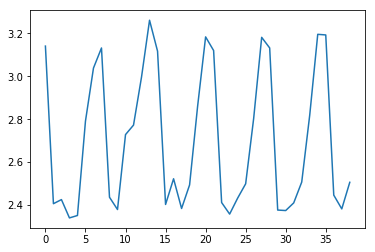

In [25]:
plt.plot(testpreds[129])

In [26]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [27]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.906660   
air_0164b9927d20bcc3_2017-04-23              1.356853   
air_0241aa3964b7f861_2017-04-23              2.168624   
air_0328696196e46f18_2017-04-23              2.353257   
air_034a3d5b40d5b1b1_2017-04-23              3.385677   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.730571  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.883949  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   7.746240  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   9.519776  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  28.537980

In [28]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [29]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [30]:
submission.to_csv("../submission/3001_lgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')